# Assignment 2: Convolutional Neural Networks
Instructions: In Assignment 2, you will learn all about the convolutional neural networks. In particular, you will gain a first-hand experience of the training process, understand the architectural details, and familiarize with transfer learning
with deep networks.

## Part 1: Convolutional Neural Networks
In this part, you will experiment with a convolutional neural network implementation to perform image classification. The dataset we will use for this assignment was created by Zoya Bylinskii, and contains 451 works of art from 11 different artists all downsampled and padded to the same size. The task is to identify which artist produced each image. The original images can be found in the `art_data/artists` directory included with the data zip file. The composition of the dataset and a sample painting from each artist are shown in Table 1.

Figure 1 shows an example of the type of convolutional architecture typically employed for similar image recognition problems. Convolutional layers apply filters to the image, and produce layers of
feature maps. Often, the convolutional layers are interspersed with pooling layers. The final layers of the network are fully connected, and lead to an output layer with one node for each of the K classes
the network is trying to detect. We will use a similar architecture for our network.

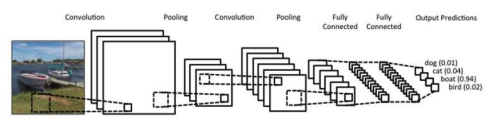

The code for performing the data processing and training the network is provided in the starter
pack. You will use PyTorch to implement convolutional neural networks. We create a dataset from the artists’ images by downsampling them to 50x50 pixels, and transforming the RGB values to lie within the range $[-0.5, 0.5]$. We provide a lot of starter code below, but you will need to modify the hyperparameters and network structure.

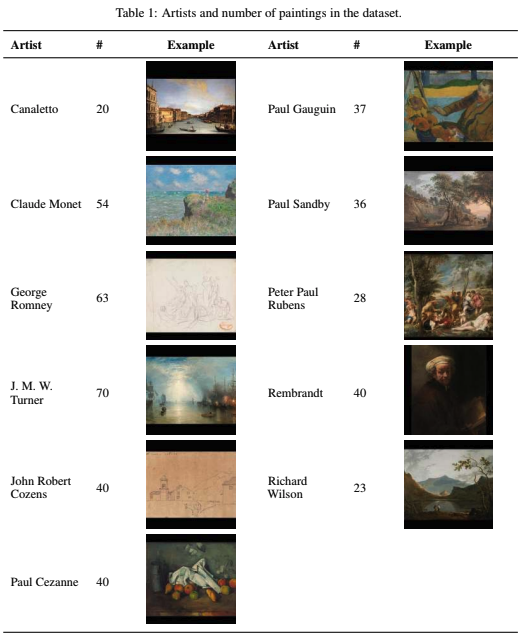

### Part 1.1: Convolutional Filter Receptive Field

First, it is important to develop an intuition for how a convolutional layer affects the feature representations that the network learns. Assume that you have a network in which the first convolutional layer
applies a 5x5 patch to the image, producing a feature map $Z_{1}$. The next layer of the network is also convolutional; in this case, a 3x3 patch is applied to the feature map $Z_{1}$ to produce a new feature
map, $Z_{2}$. Assume the stride used in both cases is 1. Let the receptive field of a node in this network be the portion of the original image that contributes information to the node (that it can, through the filters of the network, “see”). What are the dimensions of the receptive field for a node in $Z_{2}$? Note that you can ignore padding, and just consider patches in the middle of the image and $Z_{1}$. Thinking about your answer, why is it effective to build convolutional networks deeper, i.e. with more layers?

**Receptive Field of Z_2**

We can find the receptive field of Z_2 with the formula (K - 1) * L + 1 where K is the kernel (filter) size and L is the layer that we are trying to find the receptive field of. Since at the first layer K = 5 and we are trying to find the receptive field of the second layer by using the formula we have (5 - 1) * 2 - 1 = 7. Thus, Z_2 receptive field is 7x7.

**Why is it effective to build convolutional networks deeper, i.e. with more layers?**

It is effective to build deep CNNs because the receptive field increase if we have more layers. If we have bigger receptive fields then we can capture more abstract (high level) features like the whole objects such as a car. Thus, deeper networks can learn hierarchical patterns and generalize better for more complex problems.

### Part 1.2: Run the PyTorch ConvNet

Study the provided SimpleCNN class below, and take a look at the hyperparameters. Answer the following questions about the initial implementation:

1) How many layers are there? Are they all convolutional? If not, what structure do they have?
2) Which activation function is used on the hidden nodes?
3) What loss function is being used to train the network?
4) How is the loss being minimized?

**1) How many layers are there? Are they all convolutional? If not, what structure do they have?:** 

The base SimpleCNN class has four trainable layers: two convolutional layers, one fully connected layer and a final linear output layer. It also has two max-pooling layers, but max-pooling layers are optional, so the model has 6 layers at most. Not all layers are convolutional, class has 2 conv layers and 2 optional pooling layers and 2 fully connected layers.


**2) Which activation function is used on the hidden nodes?**

ReLU activation function is used after each Conv Layer and before the fully connected layer

**3) What loss function is being used to train the network?**

CrossEntropyLoss function is used.

**4) How is the loss being minimized?**

Gradients are computed by backprop and also Adam optimizer is used to minimize the loss.

Now that you are familiar with the code, try training the network. It should take between 60-120 seconds to train for 50 epochs. What is the training accuracy for your network after training? What is the validation accuracy? What do these two numbers tell you about what your network is doing?

**What is the training accuracy for your network after training?**

Best train acc: 0.6861111111111111 ≈ 68.61%

**What is the validation accuracy?**

Best val acc: 0.5384615384615384 ≈ 53.84%

**What do these two numbers tell you about what your network is doing?**

Since training accuracy is higher than validation accuracy, model learns some patterns in training data but it can't generalize it better. Also this decrease of accuracy is potential overfitting. Also lower validation accuracy might indicate that we can change some hyperparameters or regularize the model.

In [77]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image, ImageFile
import tqdm
from torch.nn import CrossEntropyLoss
import time
import random
from torchvision import transforms, utils
import numpy as np
import os
from torch import optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [78]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling= False):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        if pooling:
            self.fully_connected_layer = nn.Linear(64,64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [79]:
class LoaderClass(Dataset):
    def __init__(self,data,labels,phase,transforms):
        super(LoaderClass, self).__init__()
        self.transforms = transforms
        self.labels = labels[phase + "_labels"]
        self.data = data[phase + "_data"]
        self.phase = phase

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.data[idx]
        img = Image.fromarray(img)
        img = self.transforms(img)
        return img,torch.from_numpy(label)

In [80]:
class Trainer():
    def __init__(self,model,criterion,tr_loader,val_loader,optimizer,
                 num_epoch,patience,batch_size,lr_scheduler=None):
        self.model = model
        self.tr_loader = tr_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.num_epoch = num_epoch
        self.patience = patience
        self.lr_scheduler = lr_scheduler
        self.criterion = criterion
        self.softmax = nn.Softmax()
        self.no_inc = 0
        self.best_loss = 9999
        self.phases = ["train","val"]
        self.best_model = []
        self.best_val_acc = 0
        self.best_train_acc = 0
        self.best_val_loss = 0
        self.best_train_loss = 0
        self.batch_size = batch_size

        pass
    def train(self):
        pbar = tqdm.tqdm(desc= "Epoch 0, phase: Train",postfix="train_loss : ?, train_acc: ?")
        for i in range(self.num_epoch):
            last_train_acc = 0
            last_val_acc = 0
            last_val_loss = 0
            last_train_loss = 0
            pbar.update(1)

            for phase in self.phases:
                total_acc = 0
                total_loss = 0
                start = time.time()
                if phase == "train":
                    pbar.set_description_str("Epoch %d,"% i + "phase: Training")
                    loader = self.tr_loader
                    self.model.train()
                else:
                    pbar.set_description_str("Epoch %d,"% i + "phase: Validation")
                    loader = self.val_loader
                    self.model.eval()
                iter = 0
                for images,labels in loader:
                    iter += 1
                    images = images.to(self.model.device)
                    labels = labels.to(self.model.device)
                    self.optimizer.zero_grad()
                    logits = self.model(images)
                    softmaxed_scores = self.softmax(logits)
                    _, predictions = torch.max(softmaxed_scores,1)
                    _, labels = torch.max(labels,1)
                    loss = self.criterion(softmaxed_scores.float(),labels.long())
                    total_loss += loss.item()
                    total_acc += torch.sum(predictions == labels).item()

                    if phase == "train":
                        pbar.set_postfix_str("train acc: %6.3f," %(total_acc/ (iter*self.batch_size)) + ("train loss: %6.3f" % (total_loss / iter)))
                        loss.backward()
                        self.optimizer.step()
                    else:
                        pbar.set_postfix_str("val acc: %6.3f," %(total_acc/ (iter*self.batch_size)) + ("val loss: %6.3f" % (total_loss / iter)))


                if phase == "train":
                    if self.lr_scheduler:

                        self.lr_scheduler.step()
                end = time.time()
                if phase == "train":
                    loss_p = total_loss / iter
                    acc_p = total_acc / len(self.tr_loader.dataset)
                    last_train_acc = acc_p
                    last_train_loss = loss_p
                else:
                    loss_p = total_loss / iter
                    acc_p = total_acc / len(self.val_loader.dataset)
                    last_val_acc = acc_p
                    last_val_loss = loss_p

                    if loss_p < self.best_loss:
                        print("New best loss, loss is: ",str(loss_p), "acc is: ",acc_p )
                        self.best_loss = loss_p
                        self.no_inc = 0
                        self.best_model = self.model
                        self.best_train_acc = last_train_acc
                        self.best_train_loss = last_train_loss
                        self.best_val_loss = last_val_loss
                        self.best_val_acc = last_val_acc
                    else:
                        print("Not a better score")


                        self.no_inc += 1
                        if self.no_inc == self.patience:
                            print("Out of patience returning the best model")
                            print(
                                "Best val acc: {}, Best val loss: {}, Best train acc: {}, Best train loss: {} ".format(
                                    self.best_val_acc, self.best_val_loss, self.best_train_acc, self.best_train_loss
                                ))  # Stats of the best model
                            return self.best_model
        print("Training ended returning the best model")
        print(
            "Best val acc: {}, Best val loss: {}, Best train acc: {}, Best train loss: {} ".format(
                self.best_val_acc, self.best_val_loss, self.best_train_acc, self.best_train_loss
            ))  # Stats of the best model
        return self.best_model

In [81]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = False
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [82]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [83]:
def load_artist_data():
    data = []
    labels = []
    artists = [x for x in os.listdir(DATA_PATH) if x != '.DS_Store']
    print(artists)
    for folder in os.listdir(DATA_PATH):
        class_index = artists.index(folder)
        for image_name in os.listdir(DATA_PATH + "/" + folder):
            img = Image.open(DATA_PATH + "/" + folder + "/" + image_name)
            artist_label = (np.arange(NUM_ARTISTS) == class_index).astype(np.float32)
            data.append(np.array(img))
            labels.append(artist_label)
    shuffler = np.random.permutation(len(labels))
    data = np.array(data)[shuffler]
    labels = np.array(labels)[shuffler]

    length = len(data)
    val_size = int(length*0.2)
    val_data = data[0:val_size+1]
    train_data = data[val_size+1::]
    val_labels = labels[0:val_size+1]
    train_labels = labels[val_size+1::]
    print(val_labels)
    data_dict = {"train_data":train_data,"val_data":val_data}
    label_dict = {"train_labels":np.array(train_labels),"val_labels":np.array(val_labels)}

    return data_dict,label_dict

In [84]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=False)
optimizer = optim.Adam(model.parameters(), lr=LR)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [85]:
train_dataset = LoaderClass(data,labels,"train",transform["train"])
valid_dataset = LoaderClass(data,labels,"val",transform["val"])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0, pin_memory=True)


In [25]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler= None)
best_model = trainer_m.train()

Epoch 1,phase: Training: 2it [00:00,  5.48it/s, train acc:  0.283,train loss:  2.346]  

New best loss, loss is:  2.3782220681508384 acc is:  0.14285714285714285


Epoch 2,phase: Training: 3it [00:00,  4.02it/s, train acc:  0.357,train loss:  2.249]  

New best loss, loss is:  2.3079433043797812 acc is:  0.3076923076923077


Epoch 3,phase: Training: 4it [00:01,  3.35it/s, train acc:  0.333,train loss:  2.193]  

New best loss, loss is:  2.177764813105265 acc is:  0.34065934065934067


Epoch 4,phase: Training: 5it [00:01,  2.97it/s, train acc:  0.394,train loss:  2.149]  

New best loss, loss is:  2.1406694849332175 acc is:  0.4065934065934066


Epoch 5,phase: Training: 6it [00:02,  2.83it/s, train acc:  0.415,train loss:  2.138]  

New best loss, loss is:  2.1042749285697937 acc is:  0.4065934065934066


Epoch 6,phase: Training: 7it [00:02,  2.75it/s, train acc:  0.442,train loss:  2.098]  

New best loss, loss is:  2.1002636750539145 acc is:  0.43956043956043955


Epoch 7,phase: Training: 8it [00:02,  2.64it/s, train acc:  0.458,train loss:  2.084]  

Not a better score


Epoch 8,phase: Training: 9it [00:03,  2.61it/s, train acc:  0.512,train loss:  2.054]  

New best loss, loss is:  2.066275199254354 acc is:  0.4945054945054945


Epoch 9,phase: Training: 10it [00:03,  2.69it/s, train acc:  0.546,train loss:  2.030] 

Not a better score


Epoch 10,phase: Training: 11it [00:03,  2.71it/s, train acc:  0.469,train loss:  2.070] 

Not a better score


Epoch 11,phase: Training: 12it [00:04,  2.72it/s, train acc:  0.562,train loss:  2.004]  

Not a better score


Epoch 12,phase: Training: 13it [00:04,  2.70it/s, train acc:  0.567,train loss:  1.993]  

New best loss, loss is:  2.0550615191459656 acc is:  0.5054945054945055


Epoch 13,phase: Training: 14it [00:05,  2.73it/s, train acc:  0.504,train loss:  2.039]  

Not a better score


Epoch 14,phase: Training: 15it [00:05,  2.71it/s, train acc:  0.575,train loss:  2.001]  

New best loss, loss is:  2.0540563265482583 acc is:  0.5164835164835165


Epoch 15,phase: Training: 16it [00:05,  2.77it/s, train acc:  0.533,train loss:  2.026]  

New best loss, loss is:  2.052983601888021 acc is:  0.5164835164835165


Epoch 16,phase: Training: 17it [00:06,  2.74it/s, train acc:  0.606,train loss:  1.967]  

New best loss, loss is:  2.0496843258539834 acc is:  0.5054945054945055


Epoch 17,phase: Training: 18it [00:06,  2.73it/s, train acc:  0.604,train loss:  1.954]  

Not a better score


Epoch 18,phase: Training: 19it [00:06,  2.76it/s, train acc:  0.582,train loss:  1.992]  

Not a better score


Epoch 19,phase: Training: 20it [00:07,  2.68it/s, train acc:  0.616,train loss:  1.949]  

New best loss, loss is:  2.0460826754570007 acc is:  0.5054945054945055


Epoch 20,phase: Training: 21it [00:07,  2.69it/s, train acc:  0.625,train loss:  1.943]  

New best loss, loss is:  2.038191636403402 acc is:  0.5054945054945055


Epoch 21,phase: Training: 22it [00:07,  2.74it/s, train acc:  0.598,train loss:  1.974]  

Not a better score


Epoch 22,phase: Training: 23it [00:08,  2.71it/s, train acc:  0.621,train loss:  1.938]  

New best loss, loss is:  2.02805503209432 acc is:  0.5274725274725275


Epoch 23,phase: Training: 24it [00:08,  2.75it/s, train acc:  0.637,train loss:  1.935]  

Not a better score


Epoch 24,phase: Training: 25it [00:09,  2.79it/s, train acc:  0.601,train loss:  1.965]  

Not a better score


Epoch 25,phase: Training: 26it [00:09,  2.74it/s, train acc:  0.629,train loss:  1.930]  

Not a better score


Epoch 26,phase: Training: 27it [00:09,  2.76it/s, train acc:  0.621,train loss:  1.938]  

Not a better score


Epoch 27,phase: Training: 28it [00:10,  2.82it/s, train acc:  0.660,train loss:  1.908]  

New best loss, loss is:  2.0265543262163797 acc is:  0.5164835164835165


Epoch 28,phase: Training: 29it [00:10,  2.84it/s, train acc:  0.642,train loss:  1.928]  

New best loss, loss is:  2.0230512817700705 acc is:  0.5164835164835165


Epoch 29,phase: Training: 30it [00:10,  2.87it/s, train acc:  0.625,train loss:  1.942]  

Not a better score


Epoch 30,phase: Training: 31it [00:11,  2.85it/s, train acc:  0.621,train loss:  1.938]  

Not a better score


Epoch 31,phase: Training: 32it [00:11,  2.85it/s, train acc:  0.646,train loss:  1.913]  

Not a better score


Epoch 32,phase: Training: 33it [00:11,  2.88it/s, train acc:  0.661,train loss:  1.908]  

Not a better score


Epoch 33,phase: Training: 34it [00:12,  2.81it/s, train acc:  0.647,train loss:  1.908]  

Not a better score


Epoch 34,phase: Training: 35it [00:12,  2.78it/s, train acc:  0.656,train loss:  1.897]  

Not a better score


Epoch 35,phase: Training: 36it [00:13,  2.69it/s, train acc:  0.635,train loss:  1.915]  

New best loss, loss is:  2.0176324049631753 acc is:  0.5054945054945055


Epoch 36,phase: Training: 37it [00:13,  2.61it/s, train acc:  0.634,train loss:  1.921]  

Not a better score


Epoch 37,phase: Training: 38it [00:13,  2.64it/s, train acc:  0.629,train loss:  1.923]  

Not a better score


Epoch 38,phase: Training: 39it [00:14,  2.65it/s, train acc:  0.625,train loss:  1.923]  

Not a better score


Epoch 39,phase: Training: 40it [00:14,  2.61it/s, train acc:  0.629,train loss:  1.926]  

Not a better score


Epoch 40,phase: Training: 41it [00:14,  2.66it/s, train acc:  0.642,train loss:  1.916]  

Not a better score


Epoch 41,phase: Training: 42it [00:15,  2.70it/s, train acc:  0.654,train loss:  1.895]  

New best loss, loss is:  2.0173041025797525 acc is:  0.5054945054945055


Epoch 42,phase: Training: 43it [00:15,  2.65it/s, train acc:  0.659,train loss:  1.890]  

Not a better score


Epoch 43,phase: Training: 44it [00:16,  2.61it/s, train acc:  0.656,train loss:  1.891]  

Not a better score


Epoch 44,phase: Training: 45it [00:16,  2.65it/s, train acc:  0.625,train loss:  1.922]  

New best loss, loss is:  2.0112016002337136 acc is:  0.5274725274725275


Epoch 45,phase: Training: 46it [00:16,  2.67it/s, train acc:  0.652,train loss:  1.901]  

Not a better score


Epoch 46,phase: Training: 47it [00:17,  2.63it/s, train acc:  0.670,train loss:  1.886]  

Not a better score


Epoch 47,phase: Training: 48it [00:17,  2.61it/s, train acc:  0.659,train loss:  1.888]  

Not a better score


Epoch 48,phase: Training: 49it [00:17,  2.64it/s, train acc:  0.671,train loss:  1.878]  

Not a better score


Epoch 49,phase: Training: 50it [00:18,  2.68it/s, train acc:  0.633,train loss:  1.912]  

Not a better score


Epoch 50,phase: Training: 51it [00:18,  2.75it/s, train acc:  0.647,train loss:  1.900]  

Not a better score


Epoch 51,phase: Training: 52it [00:19,  2.71it/s, train acc:  0.649,train loss:  1.896]  

Not a better score


Epoch 52,phase: Training: 53it [00:19,  2.66it/s, train acc:  0.644,train loss:  1.903]  

Not a better score


Epoch 53,phase: Training: 54it [00:19,  2.63it/s, train acc:  0.698,train loss:  1.850]  

Not a better score


Epoch 54,phase: Training: 55it [00:20,  2.56it/s, train acc:  0.656,train loss:  1.888]  

Not a better score


Epoch 55,phase: Training: 56it [00:20,  2.52it/s, train acc:  0.625,train loss:  1.920]  

Not a better score


Epoch 56,phase: Training: 57it [00:21,  2.51it/s, train acc:  0.661,train loss:  1.883]  

Not a better score


Epoch 57,phase: Training: 58it [00:21,  2.60it/s, train acc:  0.679,train loss:  1.866]  

Not a better score


Epoch 58,phase: Training: 59it [00:21,  2.64it/s, train acc:  0.642,train loss:  1.902]  

Not a better score


Epoch 59,phase: Training: 60it [00:22,  2.70it/s, train acc:  0.621,train loss:  1.922]  

Not a better score


Epoch 60,phase: Training: 61it [00:22,  2.71it/s, train acc:  0.700,train loss:  1.854]  

Not a better score


Epoch 61,phase: Training: 62it [00:22,  2.76it/s, train acc:  0.629,train loss:  1.917]  

Not a better score


Epoch 62,phase: Training: 63it [00:23,  2.81it/s, train acc:  0.625,train loss:  1.918]  

Not a better score


Epoch 63,phase: Training: 64it [00:23,  2.84it/s, train acc:  0.675,train loss:  1.875]  

Not a better score


Epoch 64,phase: Training: 65it [00:23,  2.80it/s, train acc:  0.662,train loss:  1.884]  

Not a better score


Epoch 65,phase: Training: 66it [00:24,  2.82it/s, train acc:  0.658,train loss:  1.888]  

Not a better score


Epoch 66,phase: Training: 67it [00:24,  2.87it/s, train acc:  0.679,train loss:  1.868]  

Not a better score


Epoch 67,phase: Training: 68it [00:24,  2.87it/s, train acc:  0.650,train loss:  1.893]  

Not a better score


Epoch 68,phase: Training: 69it [00:25,  2.90it/s, train acc:  0.658,train loss:  1.888]  

Not a better score


Epoch 69,phase: Training: 70it [00:25,  2.92it/s, train acc:  0.646,train loss:  1.898]  

Not a better score


Epoch 70,phase: Training: 71it [00:25,  2.91it/s, train acc:  0.652,train loss:  1.891]  

Not a better score


Epoch 71,phase: Training: 72it [00:26,  2.86it/s, train acc:  0.664,train loss:  1.880]  

Not a better score


Epoch 72,phase: Training: 73it [00:26,  2.90it/s, train acc:  0.675,train loss:  1.869]  

Not a better score


Epoch 73,phase: Training: 74it [00:26,  2.92it/s, train acc:  0.637,train loss:  1.905]  

Not a better score


Epoch 74,phase: Training: 75it [00:27,  2.93it/s, train acc:  0.683,train loss:  1.860]  

Not a better score


Epoch 75,phase: Training: 76it [00:27,  2.93it/s, train acc:  0.646,train loss:  1.896]  

Not a better score


Epoch 76,phase: Training: 77it [00:27,  2.93it/s, train acc:  0.704,train loss:  1.839]  

Not a better score


Epoch 77,phase: Training: 78it [00:28,  2.94it/s, train acc:  0.679,train loss:  1.863]  

Not a better score


Epoch 78,phase: Training: 79it [00:28,  2.89it/s, train acc:  0.679,train loss:  1.867]  

Not a better score


Epoch 79,phase: Training: 80it [00:29,  2.90it/s, train acc:  0.633,train loss:  1.913]  

Not a better score


Epoch 80,phase: Training: 81it [00:29,  2.89it/s, train acc:  0.646,train loss:  1.896]  

Not a better score


Epoch 81,phase: Training: 82it [00:29,  2.89it/s, train acc:  0.667,train loss:  1.875]  

Not a better score


Epoch 82,phase: Training: 83it [00:30,  2.89it/s, train acc:  0.662,train loss:  1.879]  

Not a better score


Epoch 83,phase: Training: 84it [00:30,  2.90it/s, train acc:  0.654,train loss:  1.886]  

Not a better score


Epoch 84,phase: Training: 85it [00:30,  2.86it/s, train acc:  0.671,train loss:  1.874]  

Not a better score


Epoch 85,phase: Training: 86it [00:31,  2.87it/s, train acc:  0.671,train loss:  1.872]  

Not a better score


Epoch 86,phase: Training: 87it [00:31,  2.87it/s, train acc:  0.675,train loss:  1.867]  

Not a better score


Epoch 87,phase: Training: 88it [00:31,  2.88it/s, train acc:  0.637,train loss:  1.904]  

Not a better score


Epoch 88,phase: Training: 89it [00:32,  2.89it/s, train acc:  0.675,train loss:  1.867]  

Not a better score


Epoch 89,phase: Training: 90it [00:32,  2.90it/s, train acc:  0.646,train loss:  1.895]  

Not a better score


Epoch 90,phase: Training: 91it [00:32,  2.91it/s, train acc:  0.650,train loss:  1.890]  

Not a better score


Epoch 91,phase: Training: 92it [00:33,  2.86it/s, train acc:  0.675,train loss:  1.866]  

Not a better score


Epoch 92,phase: Training: 93it [00:33,  2.88it/s, train acc:  0.675,train loss:  1.865]  

Not a better score


Epoch 93,phase: Training: 94it [00:33,  2.90it/s, train acc:  0.672,train loss:  1.869]  

New best loss, loss is:  2.0052083134651184 acc is:  0.5274725274725275


Epoch 94,phase: Training: 95it [00:34,  2.93it/s, train acc:  0.676,train loss:  1.866]  

Not a better score


Epoch 95,phase: Training: 96it [00:34,  2.89it/s, train acc:  0.713,train loss:  1.831]  

Not a better score


Epoch 96,phase: Training: 97it [00:34,  2.92it/s, train acc:  0.665,train loss:  1.877]  

Not a better score


Epoch 97,phase: Training: 98it [00:35,  2.84it/s, train acc:  0.647,train loss:  1.893]  

Not a better score


Epoch 98,phase: Training: 99it [00:35,  2.70it/s, train acc:  0.692,train loss:  1.852]  

Not a better score


Epoch 99,phase: Training: 100it [00:36,  2.65it/s, train acc:  0.668,train loss:  1.875] 

Not a better score


Epoch 100,phase: Training: 101it [00:36,  2.54it/s, train acc:  0.649,train loss:  1.898] 

Not a better score


Epoch 101,phase: Training: 102it [00:36,  2.58it/s, train acc:  0.658,train loss:  1.885]  

Not a better score


Epoch 102,phase: Training: 103it [00:37,  2.68it/s, train acc:  0.664,train loss:  1.877]  

Not a better score


Epoch 103,phase: Training: 104it [00:37,  2.77it/s, train acc:  0.665,train loss:  1.879]  

Not a better score


Epoch 104,phase: Training: 105it [00:37,  2.79it/s, train acc:  0.646,train loss:  1.892]  

Not a better score


Epoch 105,phase: Training: 106it [00:38,  2.81it/s, train acc:  0.676,train loss:  1.867]  

Not a better score


Epoch 106,phase: Training: 107it [00:38,  2.84it/s, train acc:  0.680,train loss:  1.863]  

Not a better score


Epoch 107,phase: Training: 108it [00:38,  2.89it/s, train acc:  0.675,train loss:  1.868]  

Not a better score


Epoch 108,phase: Training: 109it [00:39,  2.91it/s, train acc:  0.672,train loss:  1.872]  

Not a better score


Epoch 109,phase: Training: 110it [00:39,  2.95it/s, train acc:  0.684,train loss:  1.858]  

Not a better score


Epoch 110,phase: Training: 111it [00:39,  2.95it/s, train acc:  0.703,train loss:  1.844]  

Not a better score


Epoch 111,phase: Training: 112it [00:40,  2.99it/s, train acc:  0.688,train loss:  1.854]  

Not a better score


Epoch 112,phase: Training: 113it [00:40,  3.00it/s, train acc:  0.719,train loss:  1.827]  

Not a better score


Epoch 113,phase: Training: 114it [00:40,  3.01it/s, train acc:  0.703,train loss:  1.842]  

Not a better score


Epoch 114,phase: Training: 115it [00:41,  3.02it/s, train acc:  0.667,train loss:  1.877]  

Not a better score


Epoch 115,phase: Training: 116it [00:41,  3.00it/s, train acc:  0.667,train loss:  1.874]  

Not a better score


Epoch 116,phase: Training: 117it [00:41,  2.99it/s, train acc:  0.664,train loss:  1.879]  

Not a better score


Epoch 117,phase: Training: 118it [00:42,  2.99it/s, train acc:  0.671,train loss:  1.871]  

Not a better score


Epoch 118,phase: Training: 119it [00:42,  2.99it/s, train acc:  0.688,train loss:  1.854]  

Not a better score


Epoch 119,phase: Training: 120it [00:42,  2.95it/s, train acc:  0.648,train loss:  1.893]  

Not a better score


Epoch 120,phase: Training: 121it [00:43,  2.95it/s, train acc:  0.662,train loss:  1.878]  

Not a better score


Epoch 121,phase: Training: 122it [00:43,  2.95it/s, train acc:  0.688,train loss:  1.849]  

Not a better score


Epoch 122,phase: Training: 123it [00:43,  2.97it/s, train acc:  0.650,train loss:  1.890]  

Not a better score


Epoch 123,phase: Training: 124it [00:44,  2.97it/s, train acc:  0.715,train loss:  1.830]  

Not a better score


Epoch 124,phase: Training: 125it [00:44,  3.00it/s, train acc:  0.688,train loss:  1.857]  

Not a better score


Epoch 125,phase: Training: 126it [00:44,  3.01it/s, train acc:  0.668,train loss:  1.874]  

Not a better score


Epoch 126,phase: Training: 127it [00:45,  3.01it/s, train acc:  0.688,train loss:  1.853]  

Not a better score


Epoch 127,phase: Training: 128it [00:45,  2.98it/s, train acc:  0.711,train loss:  1.829]  

Not a better score


Epoch 128,phase: Training: 129it [00:45,  3.01it/s, train acc:  0.679,train loss:  1.865]  

Not a better score


Epoch 129,phase: Training: 130it [00:46,  2.92it/s, train acc:  0.700,train loss:  1.840]  

Not a better score


Epoch 130,phase: Training: 131it [00:46,  2.88it/s, train acc:  0.649,train loss:  1.890]  

Not a better score


Epoch 131,phase: Training: 132it [00:47,  2.82it/s, train acc:  0.710,train loss:  1.831]  

Not a better score


Epoch 132,phase: Training: 133it [00:47,  2.79it/s, train acc:  0.683,train loss:  1.857]  

Not a better score


Epoch 133,phase: Training: 134it [00:47,  2.76it/s, train acc:  0.668,train loss:  1.874]  

Not a better score


Epoch 134,phase: Training: 135it [00:48,  2.68it/s, train acc:  0.692,train loss:  1.849]  

Not a better score


Epoch 135,phase: Training: 136it [00:48,  2.69it/s, train acc:  0.652,train loss:  1.891]  

Not a better score


Epoch 136,phase: Training: 137it [00:48,  2.69it/s, train acc:  0.683,train loss:  1.860]  

Not a better score


Epoch 137,phase: Training: 138it [00:49,  2.63it/s, train acc:  0.674,train loss:  1.868]  

Not a better score


Epoch 138,phase: Training: 139it [00:49,  2.63it/s, train acc:  0.688,train loss:  1.851]  

Not a better score


Epoch 139,phase: Training: 140it [00:50,  2.67it/s, train acc:  0.683,train loss:  1.857]  

Not a better score


Epoch 140,phase: Training: 141it [00:50,  2.70it/s, train acc:  0.704,train loss:  1.838]  

Not a better score


Epoch 141,phase: Training: 142it [00:50,  2.69it/s, train acc:  0.692,train loss:  1.847]  

Not a better score


Epoch 142,phase: Training: 143it [00:51,  2.73it/s, train acc:  0.667,train loss:  1.874]  

Not a better score


Epoch 143,phase: Training: 144it [00:51,  2.75it/s, train acc:  0.688,train loss:  1.852]  

Not a better score


Epoch 144,phase: Training: 145it [00:51,  2.77it/s, train acc:  0.704,train loss:  1.837]  

Not a better score


Epoch 145,phase: Training: 146it [00:52,  2.73it/s, train acc:  0.704,train loss:  1.837]  

Not a better score


Epoch 146,phase: Training: 147it [00:52,  2.76it/s, train acc:  0.688,train loss:  1.855]  

New best loss, loss is:  1.9881306290626526 acc is:  0.5384615384615384


Epoch 147,phase: Training: 148it [00:52,  2.75it/s, train acc:  0.725,train loss:  1.816]  

Not a better score


Epoch 148,phase: Training: 149it [00:53,  2.76it/s, train acc:  0.667,train loss:  1.872]  

Not a better score


Epoch 149,phase: Training: 150it [00:53,  2.73it/s, train acc:  0.721,train loss:  1.819]  

Not a better score


Epoch 150,phase: Training: 151it [00:54,  2.75it/s, train acc:  0.683,train loss:  1.856]  

Not a better score


Epoch 151,phase: Training: 152it [00:54,  2.75it/s, train acc:  0.688,train loss:  1.852]  

Not a better score


Epoch 152,phase: Training: 153it [00:54,  2.77it/s, train acc:  0.683,train loss:  1.858]  

Not a better score


Epoch 153,phase: Training: 154it [00:55,  2.73it/s, train acc:  0.704,train loss:  1.835]  

Not a better score


Epoch 154,phase: Training: 155it [00:55,  2.76it/s, train acc:  0.713,train loss:  1.828]  

Not a better score


Epoch 155,phase: Training: 156it [00:55,  2.80it/s, train acc:  0.658,train loss:  1.881]  

Not a better score


Epoch 156,phase: Training: 157it [00:56,  2.79it/s, train acc:  0.667,train loss:  1.872]  

Not a better score


Epoch 157,phase: Training: 158it [00:56,  2.76it/s, train acc:  0.692,train loss:  1.847]  

Not a better score


Epoch 158,phase: Training: 159it [00:56,  2.78it/s, train acc:  0.704,train loss:  1.835]  

Not a better score


Epoch 159,phase: Training: 160it [00:57,  2.79it/s, train acc:  0.688,train loss:  1.851]  

Not a better score


Epoch 160,phase: Training: 161it [00:57,  2.79it/s, train acc:  0.700,train loss:  1.839]  

Not a better score


Epoch 161,phase: Training: 162it [00:58,  2.77it/s, train acc:  0.717,train loss:  1.826]  

Not a better score


Epoch 162,phase: Training: 163it [00:58,  2.81it/s, train acc:  0.654,train loss:  1.889]  

Not a better score


Epoch 163,phase: Training: 164it [00:58,  2.82it/s, train acc:  0.700,train loss:  1.842]  

Not a better score


Epoch 164,phase: Training: 165it [00:59,  2.82it/s, train acc:  0.656,train loss:  1.888]  

Not a better score


Epoch 165,phase: Training: 166it [00:59,  2.77it/s, train acc:  0.662,train loss:  1.882]  

Not a better score


Epoch 166,phase: Training: 167it [00:59,  2.80it/s, train acc:  0.671,train loss:  1.878]  

Not a better score


Epoch 167,phase: Training: 168it [01:00,  2.82it/s, train acc:  0.688,train loss:  1.857]  

Not a better score


Epoch 168,phase: Training: 169it [01:00,  2.86it/s, train acc:  0.683,train loss:  1.858]  

Not a better score


Epoch 169,phase: Training: 170it [01:00,  2.81it/s, train acc:  0.713,train loss:  1.828]  

Not a better score


Epoch 170,phase: Training: 171it [01:01,  2.85it/s, train acc:  0.713,train loss:  1.827]  

Not a better score


Epoch 171,phase: Training: 172it [01:01,  2.88it/s, train acc:  0.679,train loss:  1.862]  

Not a better score


Epoch 172,phase: Training: 173it [01:01,  2.89it/s, train acc:  0.680,train loss:  1.862]  

Not a better score


Epoch 173,phase: Training: 174it [01:02,  2.84it/s, train acc:  0.665,train loss:  1.874]  

Not a better score


Epoch 174,phase: Training: 175it [01:02,  2.64it/s, train acc:  0.705,train loss:  1.836]  

Not a better score


Epoch 175,phase: Training: 176it [01:03,  2.60it/s, train acc:  0.679,train loss:  1.862]  

Not a better score


Epoch 176,phase: Training: 177it [01:03,  2.69it/s, train acc:  0.662,train loss:  1.880]  

Not a better score


Epoch 177,phase: Training: 178it [01:03,  2.71it/s, train acc:  0.654,train loss:  1.885]  

Not a better score


Epoch 178,phase: Training: 179it [01:04,  2.75it/s, train acc:  0.703,train loss:  1.839]  

Not a better score


Epoch 179,phase: Training: 180it [01:04,  2.81it/s, train acc:  0.676,train loss:  1.866]  

Not a better score


Epoch 180,phase: Training: 181it [01:04,  2.85it/s, train acc:  0.668,train loss:  1.871]  

Not a better score


Epoch 181,phase: Training: 182it [01:05,  2.82it/s, train acc:  0.696,train loss:  1.843]  

Not a better score


Epoch 182,phase: Training: 183it [01:05,  2.85it/s, train acc:  0.692,train loss:  1.848]  

Not a better score


Epoch 183,phase: Training: 184it [01:05,  2.85it/s, train acc:  0.725,train loss:  1.815]  

Not a better score


Epoch 184,phase: Training: 185it [01:06,  2.86it/s, train acc:  0.676,train loss:  1.863]  

Not a better score


Epoch 185,phase: Training: 186it [01:06,  2.82it/s, train acc:  0.696,train loss:  1.846]  

Not a better score


Epoch 186,phase: Training: 187it [01:06,  2.87it/s, train acc:  0.683,train loss:  1.857]  

Not a better score


Epoch 187,phase: Training: 188it [01:07,  2.87it/s, train acc:  0.658,train loss:  1.884]  

Not a better score


Epoch 188,phase: Training: 189it [01:07,  2.88it/s, train acc:  0.667,train loss:  1.874]  

Not a better score


Epoch 189,phase: Training: 190it [01:07,  2.84it/s, train acc:  0.713,train loss:  1.827]  

Not a better score


Epoch 190,phase: Training: 191it [01:08,  2.86it/s, train acc:  0.650,train loss:  1.891]  

Not a better score


Epoch 191,phase: Training: 192it [01:08,  2.88it/s, train acc:  0.671,train loss:  1.868]  

Not a better score


Epoch 192,phase: Training: 193it [01:09,  2.89it/s, train acc:  0.700,train loss:  1.840]  

Not a better score


Epoch 193,phase: Training: 194it [01:09,  2.85it/s, train acc:  0.688,train loss:  1.854]  

Not a better score


Epoch 194,phase: Training: 195it [01:09,  2.88it/s, train acc:  0.684,train loss:  1.855]  

Not a better score


Epoch 195,phase: Training: 196it [01:10,  2.91it/s, train acc:  0.633,train loss:  1.911]  

Not a better score


Epoch 196,phase: Training: 197it [01:10,  2.91it/s, train acc:  0.727,train loss:  1.818]  

Not a better score


Epoch 197,phase: Training: 198it [01:10,  2.86it/s, train acc:  0.668,train loss:  1.877]  

Not a better score


Epoch 198,phase: Training: 199it [01:11,  2.89it/s, train acc:  0.680,train loss:  1.861]  

Not a better score


Epoch 199,phase: Training: 200it [01:11,  2.91it/s, train acc:  0.699,train loss:  1.849]  

Not a better score


Epoch 199,phase: Validation: 200it [01:11,  2.79it/s, val acc:  0.500,val loss:  1.995]    

Not a better score
Training ended returning the best model
Best val acc: 0.5384615384615384, Best val loss: 1.9881306290626526, Best train acc: 0.6861111111111111, Best train loss: 1.8544415805650794 


### Part 1.3: Add Pooling Layers
We will now add max pooling layers after each of our convolutional layers. This code has already been provided for you; all you need to do is switch the pooling flag in the hyper-parameters to True,
and choose different values for the pooling filter size and stride. After you applied max pooling, what happened to your results? How did the training accuracy vs. validation accuracy change? What does
that tell you about the effect of max pooling on your network?

**After you applied max pooling, what happened to your results?**

Answer: Both training and validation accuracy decreased.

**How did the training accuracy vs. validation accuracy change?**

Answer: Training accuracy is approxiamtely 61.7% and validation accuracy is approximately 52.74% (for filter size 2 and stride 2). We can understant that model's ability to generalize the data decreased and model overfits the data less compared to no pooling model.

**What does that tell you about the effect of max pooling on your network?**

Answer: Max pooling reduces the spatial size and decreases the number of parameters thus providing computational efficiency and prevents overfitting by removing some features. Max pooling takes the maximum activation in each window, features with highest activations are selected and it removes less important features in the window. Because max pooling removes some of the features in the window for a task like image recognition it decreases the accuracy since the deleted features can give the model important information about the image.

I've tested the impact of pooling with different kernel sizes and strides. **Kernel size 4 and stride 2** achieved the best result with **approximately 68.06% training accuracy and 63.74% validation accuray**. The gap between training accuracy and validation accuracy is the lowest (4.32%), so we can understand that pooling downsamples the image enought the prevent overfitting while having a accurate classification. Furthermore, for smaller kernel sizes (k=2,k=3) achieved lower overall accuracy and large kernel size (k=5) with stride 2 achieved a good training accuracy but validation accuracy is not enough, thus model overfitted the data (12.17% gap), this might be because with aggresive downsampling and large kernel size model removed too many low level features and couldn't classify the images. 

To sum up, model achieved optimal performance with kernel size 4 and stride 2 with lowest train-validation gap (low overfitting) and higher training and validation accuracy than other kernel size and stride combinations.

| **Pooling?** | **Kernel Size (k)** | **Stride (s)** | **Train Acc** | **Val Acc** |
| ------------ | ------------------- | -------------- | ------------- | ----------- |
|  No pooling | –                   | –              | **~68.0%**    | **~58.0%**  |
|  Yes        | 2                   | 1              | **62.22%**    | **51.64%**  |
|  Yes        | 2                   | 2              | **61.70**     | **52.74%**  |
|  Yes        | 3                   | 1              | **66.67%**    | **61.54%**  |
|  Yes        | 3                   | 2              | **62.22%**    | **52.75%**  |
|  Yes        | 4                   | 1              | **68.33%**    | **62.63%**  |
|  Yes        | 4                   | 2              | **68.05%**   | **63.73%** |
|  Yes        | 5                   | 1              | **61.11%**    | **53.85%**  |
|  Yes        | 5                   | 2              | **67.22%**    | **55.05%**  |


In [86]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        if pooling:
            self.fully_connected_layer = nn.Linear(16, 64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [87]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [88]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=True)
optimizer = optim.Adam(model.parameters(), lr=LR)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [89]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler= None)
best_model = trainer_m.train()

Epoch 0,phase: Training: 1it [00:00, 4524.60it/s, train_loss : ?, train_acc: ?]/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1,phase: Training: 2it [00:00,  4.88it/s, train acc:  0.155,train loss:  2.395]  

New best loss, loss is:  2.392470121383667 acc is:  0.10989010989010989


Epoch 2,phase: Training: 3it [00:00,  3.80it/s, train acc:  0.158,train loss:  2.392]  

New best loss, loss is:  2.39030913511912 acc is:  0.17582417582417584


Epoch 3,phase: Training: 4it [00:01,  3.69it/s, train acc:  0.163,train loss:  2.388]  

New best loss, loss is:  2.3878794511159263 acc is:  0.1978021978021978


Epoch 4,phase: Training: 5it [00:01,  3.67it/s, train acc:  0.184,train loss:  2.380]  

New best loss, loss is:  2.3844772577285767 acc is:  0.2087912087912088


Epoch 5,phase: Training: 6it [00:01,  3.60it/s, train acc:  0.191,train loss:  2.370]  

New best loss, loss is:  2.3756751219431558 acc is:  0.2087912087912088


Epoch 6,phase: Training: 7it [00:02,  3.55it/s, train acc:  0.214,train loss:  2.344]  

New best loss, loss is:  2.3648372491200766 acc is:  0.1978021978021978


Epoch 7,phase: Training: 8it [00:02,  3.56it/s, train acc:  0.266,train loss:  2.318]  

New best loss, loss is:  2.3430768251419067 acc is:  0.2087912087912088


Epoch 8,phase: Training: 9it [00:02,  3.56it/s, train acc:  0.260,train loss:  2.301]  

New best loss, loss is:  2.33143142859141 acc is:  0.1978021978021978


Epoch 9,phase: Training: 10it [00:02,  3.58it/s, train acc:  0.257,train loss:  2.283] 

New best loss, loss is:  2.32912540435791 acc is:  0.13186813186813187


Epoch 10,phase: Training: 11it [00:03,  3.59it/s, train acc:  0.272,train loss:  2.263] 

Not a better score


Epoch 11,phase: Training: 12it [00:03,  3.53it/s, train acc:  0.263,train loss:  2.260]  

Not a better score


Epoch 12,phase: Training: 13it [00:03,  3.56it/s, train acc:  0.260,train loss:  2.262]  

Not a better score


Epoch 13,phase: Training: 14it [00:04,  3.58it/s, train acc:  0.273,train loss:  2.240]  

New best loss, loss is:  2.3282981713612876 acc is:  0.13186813186813187


Epoch 14,phase: Training: 15it [00:04,  3.56it/s, train acc:  0.309,train loss:  2.238]  

New best loss, loss is:  2.309605677922567 acc is:  0.17582417582417584


Epoch 15,phase: Training: 16it [00:04,  3.58it/s, train acc:  0.356,train loss:  2.211]  

New best loss, loss is:  2.2914313475290933 acc is:  0.23076923076923078


Epoch 16,phase: Training: 17it [00:04,  3.61it/s, train acc:  0.378,train loss:  2.199]  

New best loss, loss is:  2.2698390086491904 acc is:  0.31868131868131866


Epoch 17,phase: Training: 18it [00:05,  3.61it/s, train acc:  0.368,train loss:  2.194]  

New best loss, loss is:  2.2234400510787964 acc is:  0.34065934065934067


Epoch 18,phase: Training: 19it [00:05,  3.59it/s, train acc:  0.385,train loss:  2.174]  

New best loss, loss is:  2.2019190390904746 acc is:  0.3956043956043956


Epoch 19,phase: Training: 20it [00:05,  3.55it/s, train acc:  0.405,train loss:  2.159]  

New best loss, loss is:  2.1824754079182944 acc is:  0.4065934065934066


Epoch 20,phase: Training: 21it [00:06,  3.56it/s, train acc:  0.396,train loss:  2.159]  

New best loss, loss is:  2.1697556177775064 acc is:  0.4065934065934066


Epoch 21,phase: Training: 22it [00:06,  3.65it/s, train acc:  0.391,train loss:  2.155]  

New best loss, loss is:  2.169573187828064 acc is:  0.4065934065934066


Epoch 22,phase: Training: 23it [00:06,  3.64it/s, train acc:  0.424,train loss:  2.131]  

New best loss, loss is:  2.1436241269111633 acc is:  0.4065934065934066


Epoch 23,phase: Training: 24it [00:06,  3.48it/s, train acc:  0.414,train loss:  2.144]  

New best loss, loss is:  2.143026828765869 acc is:  0.4065934065934066


Epoch 24,phase: Training: 25it [00:07,  3.61it/s, train acc:  0.401,train loss:  2.139]  

New best loss, loss is:  2.1356116930643716 acc is:  0.4065934065934066


Epoch 25,phase: Training: 26it [00:07,  3.51it/s, train acc:  0.395,train loss:  2.139]  

New best loss, loss is:  2.1242602268854776 acc is:  0.4065934065934066


Epoch 26,phase: Training: 27it [00:07,  3.52it/s, train acc:  0.431,train loss:  2.122]  

New best loss, loss is:  2.1208289861679077 acc is:  0.4065934065934066


Epoch 27,phase: Training: 28it [00:07,  3.58it/s, train acc:  0.444,train loss:  2.104]  

New best loss, loss is:  2.120728075504303 acc is:  0.45054945054945056


Epoch 28,phase: Training: 29it [00:08,  3.64it/s, train acc:  0.450,train loss:  2.108]  

New best loss, loss is:  2.105985085169474 acc is:  0.42857142857142855


Epoch 29,phase: Training: 30it [00:08,  3.70it/s, train acc:  0.434,train loss:  2.109]  

Not a better score


Epoch 30,phase: Training: 31it [00:08,  3.74it/s, train acc:  0.467,train loss:  2.098]  

New best loss, loss is:  2.0993382930755615 acc is:  0.45054945054945056


Epoch 31,phase: Training: 32it [00:09,  3.80it/s, train acc:  0.473,train loss:  2.088]  

New best loss, loss is:  2.098650415738424 acc is:  0.4725274725274725


Epoch 32,phase: Training: 33it [00:09,  3.84it/s, train acc:  0.472,train loss:  2.089]  

Not a better score


Epoch 33,phase: Training: 34it [00:09,  3.84it/s, train acc:  0.484,train loss:  2.087]  

New best loss, loss is:  2.0954547921816506 acc is:  0.4835164835164835


Epoch 34,phase: Training: 35it [00:09,  3.86it/s, train acc:  0.478,train loss:  2.086]  

New best loss, loss is:  2.0880674719810486 acc is:  0.4725274725274725


Epoch 35,phase: Training: 36it [00:10,  3.84it/s, train acc:  0.470,train loss:  2.083]  

New best loss, loss is:  2.0841859777768454 acc is:  0.4725274725274725


Epoch 36,phase: Training: 37it [00:10,  3.86it/s, train acc:  0.476,train loss:  2.086]  

New best loss, loss is:  2.0840312242507935 acc is:  0.4725274725274725


Epoch 37,phase: Training: 38it [00:10,  3.86it/s, train acc:  0.509,train loss:  2.058]  

Not a better score


Epoch 38,phase: Training: 39it [00:10,  3.84it/s, train acc:  0.503,train loss:  2.064]  

New best loss, loss is:  2.080432176589966 acc is:  0.4835164835164835


Epoch 39,phase: Training: 40it [00:11,  3.82it/s, train acc:  0.484,train loss:  2.076]  

Not a better score


Epoch 40,phase: Training: 41it [00:11,  3.82it/s, train acc:  0.516,train loss:  2.055]  

Not a better score


Epoch 41,phase: Training: 42it [00:11,  3.78it/s, train acc:  0.491,train loss:  2.074]  

New best loss, loss is:  2.0789814790089927 acc is:  0.4835164835164835


Epoch 42,phase: Training: 43it [00:11,  3.77it/s, train acc:  0.520,train loss:  2.052]  

New best loss, loss is:  2.0687808791796365 acc is:  0.4835164835164835


Epoch 43,phase: Training: 44it [00:12,  3.75it/s, train acc:  0.530,train loss:  2.043]  

New best loss, loss is:  2.0611754059791565 acc is:  0.4945054945054945


Epoch 44,phase: Training: 45it [00:12,  3.49it/s, train acc:  0.507,train loss:  2.058]  

Not a better score


Epoch 45,phase: Training: 46it [00:12,  3.54it/s, train acc:  0.531,train loss:  2.040]  

Not a better score


Epoch 46,phase: Training: 47it [00:13,  3.63it/s, train acc:  0.497,train loss:  2.060]  

Not a better score


Epoch 47,phase: Training: 48it [00:13,  3.67it/s, train acc:  0.512,train loss:  2.048]  

New best loss, loss is:  2.0595599015553794 acc is:  0.4945054945054945


Epoch 48,phase: Training: 49it [00:13,  3.75it/s, train acc:  0.516,train loss:  2.047]  

Not a better score


Epoch 49,phase: Training: 50it [00:13,  3.77it/s, train acc:  0.516,train loss:  2.045]  

Not a better score


Epoch 50,phase: Training: 51it [00:14,  3.77it/s, train acc:  0.510,train loss:  2.051]  

Not a better score


Epoch 51,phase: Training: 52it [00:14,  3.74it/s, train acc:  0.522,train loss:  2.041]  

Not a better score


Epoch 52,phase: Training: 53it [00:14,  3.76it/s, train acc:  0.519,train loss:  2.042]  

Not a better score


Epoch 53,phase: Training: 54it [00:14,  3.77it/s, train acc:  0.527,train loss:  2.036]  

New best loss, loss is:  2.053588410218557 acc is:  0.4945054945054945


Epoch 54,phase: Training: 55it [00:15,  3.82it/s, train acc:  0.516,train loss:  2.042]  

Not a better score


Epoch 55,phase: Training: 56it [00:15,  3.81it/s, train acc:  0.515,train loss:  2.046]  

Not a better score


Epoch 56,phase: Training: 57it [00:15,  3.70it/s, train acc:  0.515,train loss:  2.041]  

Not a better score


Epoch 57,phase: Training: 58it [00:15,  3.78it/s, train acc:  0.525,train loss:  2.037]  

New best loss, loss is:  2.05166623989741 acc is:  0.4725274725274725


Epoch 58,phase: Training: 59it [00:16,  3.79it/s, train acc:  0.525,train loss:  2.033]  

Not a better score


Epoch 59,phase: Training: 60it [00:16,  3.78it/s, train acc:  0.534,train loss:  2.027]  

Not a better score


Epoch 60,phase: Training: 61it [00:16,  3.78it/s, train acc:  0.527,train loss:  2.032]  

Not a better score


Epoch 61,phase: Training: 62it [00:16,  3.82it/s, train acc:  0.544,train loss:  2.020]  

Not a better score


Epoch 62,phase: Training: 63it [00:17,  3.78it/s, train acc:  0.556,train loss:  2.002]  

New best loss, loss is:  2.042659640312195 acc is:  0.4835164835164835


Epoch 63,phase: Training: 64it [00:17,  3.67it/s, train acc:  0.519,train loss:  2.036]  

Not a better score


Epoch 64,phase: Training: 65it [00:17,  3.70it/s, train acc:  0.534,train loss:  2.025]  

New best loss, loss is:  2.039158900578817 acc is:  0.4945054945054945


Epoch 65,phase: Training: 66it [00:18,  3.76it/s, train acc:  0.528,train loss:  2.024]  

Not a better score


Epoch 66,phase: Training: 67it [00:18,  3.77it/s, train acc:  0.542,train loss:  2.016]  

Not a better score


Epoch 67,phase: Training: 68it [00:18,  3.81it/s, train acc:  0.556,train loss:  2.008]  

Not a better score


Epoch 68,phase: Training: 69it [00:18,  3.81it/s, train acc:  0.547,train loss:  2.020]  

New best loss, loss is:  2.035680631796519 acc is:  0.46153846153846156


Epoch 69,phase: Training: 70it [00:19,  3.82it/s, train acc:  0.547,train loss:  2.022]  

New best loss, loss is:  2.0354102651278176 acc is:  0.5054945054945055


Epoch 70,phase: Training: 71it [00:19,  3.72it/s, train acc:  0.553,train loss:  2.015]  

Not a better score


Epoch 71,phase: Training: 72it [00:19,  3.72it/s, train acc:  0.551,train loss:  2.025]  

New best loss, loss is:  2.026357889175415 acc is:  0.5054945054945055


Epoch 72,phase: Training: 73it [00:19,  3.58it/s, train acc:  0.554,train loss:  2.013]  

Not a better score


Epoch 73,phase: Training: 74it [00:20,  3.68it/s, train acc:  0.560,train loss:  2.006]  

Not a better score


Epoch 74,phase: Training: 75it [00:20,  3.75it/s, train acc:  0.571,train loss:  1.998]  

Not a better score


Epoch 75,phase: Training: 76it [00:20,  3.80it/s, train acc:  0.562,train loss:  2.001]  

Not a better score


Epoch 76,phase: Training: 77it [00:20,  3.80it/s, train acc:  0.562,train loss:  2.004]  

Not a better score


Epoch 77,phase: Training: 78it [00:21,  3.81it/s, train acc:  0.571,train loss:  2.002]  

Not a better score


Epoch 78,phase: Training: 79it [00:21,  3.85it/s, train acc:  0.560,train loss:  2.006]  

New best loss, loss is:  2.0203873117764792 acc is:  0.5274725274725275


Epoch 79,phase: Training: 80it [00:21,  3.86it/s, train acc:  0.550,train loss:  2.010]  

Not a better score


Epoch 80,phase: Training: 81it [00:22,  3.83it/s, train acc:  0.559,train loss:  2.006]  

Not a better score


Epoch 81,phase: Training: 82it [00:22,  3.82it/s, train acc:  0.566,train loss:  2.002]  

Not a better score


Epoch 82,phase: Training: 83it [00:22,  3.82it/s, train acc:  0.557,train loss:  2.007]  

New best loss, loss is:  2.0093567172686257 acc is:  0.5384615384615384


Epoch 83,phase: Training: 84it [00:22,  3.86it/s, train acc:  0.568,train loss:  1.992]  

Not a better score


Epoch 84,phase: Training: 85it [00:23,  3.88it/s, train acc:  0.566,train loss:  1.998]  

Not a better score


Epoch 85,phase: Training: 86it [00:23,  3.69it/s, train acc:  0.540,train loss:  2.020]  

New best loss, loss is:  2.008123278617859 acc is:  0.5604395604395604


Epoch 86,phase: Training: 87it [00:23,  3.46it/s, train acc:  0.572,train loss:  1.991]  

Not a better score


Epoch 87,phase: Training: 88it [00:23,  3.54it/s, train acc:  0.605,train loss:  1.968]  

Not a better score


Epoch 88,phase: Training: 89it [00:24,  3.29it/s, train acc:  0.559,train loss:  2.003]  

Not a better score


Epoch 89,phase: Training: 90it [00:24,  3.32it/s, train acc:  0.562,train loss:  1.997]  

Not a better score


Epoch 90,phase: Training: 91it [00:24,  3.36it/s, train acc:  0.570,train loss:  1.991]  

Not a better score


Epoch 91,phase: Training: 92it [00:25,  3.13it/s, train acc:  0.573,train loss:  1.986]  

Not a better score


Epoch 92,phase: Training: 93it [00:25,  3.22it/s, train acc:  0.592,train loss:  1.973]  

Not a better score


Epoch 93,phase: Training: 94it [00:25,  3.20it/s, train acc:  0.576,train loss:  1.988]  

Not a better score


Epoch 94,phase: Training: 95it [00:26,  3.32it/s, train acc:  0.572,train loss:  1.996]  

Not a better score


Epoch 95,phase: Training: 96it [00:26,  3.42it/s, train acc:  0.595,train loss:  1.968]  

New best loss, loss is:  2.004439969857534 acc is:  0.5384615384615384


Epoch 96,phase: Training: 97it [00:26,  3.48it/s, train acc:  0.597,train loss:  1.968]  

Not a better score


Epoch 97,phase: Training: 98it [00:26,  3.52it/s, train acc:  0.604,train loss:  1.961]  

New best loss, loss is:  2.0018449227015176 acc is:  0.5494505494505495


Epoch 98,phase: Training: 99it [00:27,  3.51it/s, train acc:  0.589,train loss:  1.974]  

New best loss, loss is:  2.0001089374224343 acc is:  0.5494505494505495


Epoch 99,phase: Training: 100it [00:27,  3.55it/s, train acc:  0.591,train loss:  1.976] 

New best loss, loss is:  1.9946661988894145 acc is:  0.5494505494505495


Epoch 100,phase: Training: 101it [00:27,  3.63it/s, train acc:  0.566,train loss:  1.993] 

Not a better score


Epoch 101,phase: Training: 102it [00:28,  3.52it/s, train acc:  0.615,train loss:  1.950]  

Not a better score


Epoch 102,phase: Training: 103it [00:28,  3.56it/s, train acc:  0.594,train loss:  1.970]  

Not a better score


Epoch 103,phase: Training: 104it [00:28,  3.62it/s, train acc:  0.602,train loss:  1.965]  

Not a better score


Epoch 104,phase: Training: 105it [00:28,  3.58it/s, train acc:  0.595,train loss:  1.971]  

Not a better score


Epoch 105,phase: Training: 106it [00:29,  3.60it/s, train acc:  0.592,train loss:  1.967]  

Not a better score


Epoch 106,phase: Training: 107it [00:29,  3.59it/s, train acc:  0.613,train loss:  1.954]  

Not a better score


Epoch 107,phase: Training: 108it [00:29,  3.59it/s, train acc:  0.592,train loss:  1.966]  

Not a better score


Epoch 108,phase: Training: 109it [00:30,  3.61it/s, train acc:  0.576,train loss:  1.979]  

New best loss, loss is:  1.9911428491274517 acc is:  0.5494505494505495


Epoch 109,phase: Training: 110it [00:30,  3.61it/s, train acc:  0.606,train loss:  1.962]  

Not a better score


Epoch 110,phase: Training: 111it [00:30,  3.69it/s, train acc:  0.599,train loss:  1.956]  

Not a better score


Epoch 111,phase: Training: 112it [00:30,  3.54it/s, train acc:  0.604,train loss:  1.960]  

New best loss, loss is:  1.9743510683377583 acc is:  0.5714285714285714


Epoch 112,phase: Training: 113it [00:31,  3.50it/s, train acc:  0.628,train loss:  1.939]  

Not a better score


Epoch 113,phase: Training: 114it [00:31,  3.57it/s, train acc:  0.609,train loss:  1.949]  

Not a better score


Epoch 114,phase: Training: 115it [00:31,  3.58it/s, train acc:  0.586,train loss:  1.965]  

New best loss, loss is:  1.9688473343849182 acc is:  0.5714285714285714


Epoch 115,phase: Training: 116it [00:31,  3.48it/s, train acc:  0.608,train loss:  1.953]  

New best loss, loss is:  1.960454781850179 acc is:  0.5714285714285714


Epoch 116,phase: Training: 117it [00:32,  3.25it/s, train acc:  0.628,train loss:  1.943]  

Not a better score


Epoch 117,phase: Training: 118it [00:32,  3.37it/s, train acc:  0.622,train loss:  1.941]  

Not a better score


Epoch 118,phase: Training: 119it [00:32,  3.39it/s, train acc:  0.628,train loss:  1.945]  

New best loss, loss is:  1.951351563135783 acc is:  0.5824175824175825


Epoch 119,phase: Training: 120it [00:33,  3.42it/s, train acc:  0.631,train loss:  1.935]  

Not a better score


Epoch 120,phase: Training: 121it [00:33,  3.54it/s, train acc:  0.628,train loss:  1.938]  

Not a better score


Epoch 121,phase: Training: 122it [00:33,  3.53it/s, train acc:  0.621,train loss:  1.937]  

New best loss, loss is:  1.9502278168996174 acc is:  0.6043956043956044


Epoch 122,phase: Training: 123it [00:34,  3.45it/s, train acc:  0.607,train loss:  1.956]  

Not a better score


Epoch 123,phase: Training: 124it [00:34,  3.28it/s, train acc:  0.628,train loss:  1.931]  

Not a better score


Epoch 124,phase: Training: 125it [00:34,  3.34it/s, train acc:  0.646,train loss:  1.920]  

Not a better score


Epoch 125,phase: Training: 126it [00:34,  3.36it/s, train acc:  0.638,train loss:  1.926]  

Not a better score


Epoch 126,phase: Training: 127it [00:35,  3.44it/s, train acc:  0.628,train loss:  1.939]  

Not a better score


Epoch 127,phase: Training: 128it [00:35,  3.42it/s, train acc:  0.644,train loss:  1.920]  

Not a better score


Epoch 128,phase: Training: 129it [00:35,  3.50it/s, train acc:  0.638,train loss:  1.918]  

New best loss, loss is:  1.9464953740437825 acc is:  0.6153846153846154


Epoch 129,phase: Training: 130it [00:36,  3.54it/s, train acc:  0.637,train loss:  1.923]  

New best loss, loss is:  1.9406883517901103 acc is:  0.6153846153846154


Epoch 130,phase: Training: 131it [00:36,  3.67it/s, train acc:  0.631,train loss:  1.931]  

New best loss, loss is:  1.9373438556989033 acc is:  0.6153846153846154


Epoch 131,phase: Training: 132it [00:36,  3.71it/s, train acc:  0.622,train loss:  1.947]  

Not a better score


Epoch 132,phase: Training: 133it [00:36,  3.66it/s, train acc:  0.637,train loss:  1.926]  

Not a better score


Epoch 133,phase: Training: 134it [00:37,  3.70it/s, train acc:  0.664,train loss:  1.910]  

Not a better score


Epoch 134,phase: Training: 135it [00:37,  3.76it/s, train acc:  0.650,train loss:  1.918]  

New best loss, loss is:  1.9330942630767822 acc is:  0.6153846153846154


Epoch 135,phase: Training: 136it [00:37,  3.77it/s, train acc:  0.661,train loss:  1.913]  

Not a better score


Epoch 136,phase: Training: 137it [00:37,  3.82it/s, train acc:  0.653,train loss:  1.913]  

Not a better score


Epoch 137,phase: Training: 138it [00:38,  3.84it/s, train acc:  0.649,train loss:  1.911]  

Not a better score


Epoch 138,phase: Training: 139it [00:38,  3.86it/s, train acc:  0.655,train loss:  1.913]  

Not a better score


Epoch 139,phase: Training: 140it [00:38,  3.88it/s, train acc:  0.666,train loss:  1.906]  

Not a better score


Epoch 140,phase: Training: 141it [00:38,  3.87it/s, train acc:  0.670,train loss:  1.904]  

New best loss, loss is:  1.9299491842587788 acc is:  0.6153846153846154


Epoch 141,phase: Training: 142it [00:39,  3.90it/s, train acc:  0.653,train loss:  1.921]  

Not a better score


Epoch 142,phase: Training: 143it [00:39,  3.87it/s, train acc:  0.658,train loss:  1.910]  

Not a better score


Epoch 143,phase: Training: 144it [00:39,  3.89it/s, train acc:  0.656,train loss:  1.910]  

Not a better score


Epoch 144,phase: Training: 145it [00:40,  3.71it/s, train acc:  0.670,train loss:  1.901]  

Not a better score


Epoch 145,phase: Training: 146it [00:40,  3.62it/s, train acc:  0.664,train loss:  1.901]  

New best loss, loss is:  1.9269128640492756 acc is:  0.6263736263736264


Epoch 146,phase: Training: 147it [00:40,  3.62it/s, train acc:  0.678,train loss:  1.894]  

Not a better score


Epoch 147,phase: Training: 148it [00:40,  3.64it/s, train acc:  0.674,train loss:  1.898]  

Not a better score


Epoch 148,phase: Training: 149it [00:41,  3.62it/s, train acc:  0.658,train loss:  1.906]  

Not a better score


Epoch 149,phase: Training: 150it [00:41,  3.65it/s, train acc:  0.653,train loss:  1.910]  

Not a better score


Epoch 150,phase: Training: 151it [00:41,  3.72it/s, train acc:  0.655,train loss:  1.907]  

Not a better score


Epoch 151,phase: Training: 152it [00:41,  3.76it/s, train acc:  0.666,train loss:  1.901]  

Not a better score


Epoch 152,phase: Training: 153it [00:42,  3.74it/s, train acc:  0.675,train loss:  1.898]  

Not a better score


Epoch 153,phase: Training: 154it [00:42,  3.75it/s, train acc:  0.670,train loss:  1.899]  

Not a better score


Epoch 154,phase: Training: 155it [00:42,  3.80it/s, train acc:  0.681,train loss:  1.888]  

New best loss, loss is:  1.9252171913782756 acc is:  0.6153846153846154


Epoch 155,phase: Training: 156it [00:42,  3.80it/s, train acc:  0.678,train loss:  1.894]  

Not a better score


Epoch 156,phase: Training: 157it [00:43,  3.65it/s, train acc:  0.669,train loss:  1.897]  

Not a better score


Epoch 157,phase: Training: 158it [00:43,  3.68it/s, train acc:  0.666,train loss:  1.900]  

New best loss, loss is:  1.916654149691264 acc is:  0.6263736263736264


Epoch 158,phase: Training: 159it [00:43,  3.72it/s, train acc:  0.678,train loss:  1.883]  

Not a better score


Epoch 159,phase: Training: 160it [00:44,  3.75it/s, train acc:  0.668,train loss:  1.894]  

Not a better score


Epoch 160,phase: Training: 161it [00:44,  3.73it/s, train acc:  0.682,train loss:  1.886]  

Not a better score


Epoch 161,phase: Training: 162it [00:44,  3.79it/s, train acc:  0.688,train loss:  1.876]  

Not a better score


Epoch 162,phase: Training: 163it [00:44,  3.81it/s, train acc:  0.662,train loss:  1.897]  

New best loss, loss is:  1.91569322347641 acc is:  0.6373626373626373


Epoch 163,phase: Training: 164it [00:45,  3.82it/s, train acc:  0.675,train loss:  1.885]  

Not a better score


Epoch 164,phase: Training: 165it [00:45,  3.76it/s, train acc:  0.670,train loss:  1.889]  

Not a better score


Epoch 165,phase: Training: 166it [00:45,  3.82it/s, train acc:  0.659,train loss:  1.899]  

Not a better score


Epoch 166,phase: Training: 167it [00:45,  3.81it/s, train acc:  0.679,train loss:  1.884]  

Not a better score


Epoch 167,phase: Training: 168it [00:46,  3.83it/s, train acc:  0.666,train loss:  1.899]  

Not a better score


Epoch 168,phase: Training: 169it [00:46,  3.83it/s, train acc:  0.669,train loss:  1.892]  

Not a better score


Epoch 169,phase: Training: 170it [00:46,  3.83it/s, train acc:  0.679,train loss:  1.884]  

Not a better score


Epoch 170,phase: Training: 171it [00:46,  3.84it/s, train acc:  0.679,train loss:  1.882]  

Not a better score


Epoch 171,phase: Training: 172it [00:47,  3.87it/s, train acc:  0.664,train loss:  1.894]  

Not a better score


Epoch 172,phase: Training: 173it [00:47,  3.84it/s, train acc:  0.666,train loss:  1.893]  

Not a better score


Epoch 173,phase: Training: 174it [00:47,  3.80it/s, train acc:  0.673,train loss:  1.881]  

Not a better score


Epoch 174,phase: Training: 175it [00:47,  3.84it/s, train acc:  0.678,train loss:  1.881]  

Not a better score


Epoch 175,phase: Training: 176it [00:48,  3.85it/s, train acc:  0.679,train loss:  1.881]  

Not a better score


Epoch 176,phase: Training: 177it [00:48,  3.87it/s, train acc:  0.691,train loss:  1.870]  

Not a better score


Epoch 177,phase: Training: 178it [00:48,  3.87it/s, train acc:  0.688,train loss:  1.872]  

Not a better score


Epoch 178,phase: Training: 179it [00:49,  3.87it/s, train acc:  0.675,train loss:  1.882]  

Not a better score


Epoch 179,phase: Training: 180it [00:49,  3.86it/s, train acc:  0.662,train loss:  1.887]  

Not a better score


Epoch 180,phase: Training: 181it [00:49,  3.86it/s, train acc:  0.670,train loss:  1.885]  

Not a better score


Epoch 181,phase: Training: 182it [00:49,  3.85it/s, train acc:  0.682,train loss:  1.881]  

Not a better score


Epoch 182,phase: Training: 183it [00:50,  3.86it/s, train acc:  0.685,train loss:  1.877]  

Not a better score


Epoch 183,phase: Training: 184it [00:50,  3.88it/s, train acc:  0.682,train loss:  1.876]  

Not a better score


Epoch 184,phase: Training: 185it [00:50,  3.89it/s, train acc:  0.679,train loss:  1.882]  

Not a better score


Epoch 185,phase: Training: 186it [00:50,  3.91it/s, train acc:  0.684,train loss:  1.874]  

New best loss, loss is:  1.915373166402181 acc is:  0.6263736263736264


Epoch 186,phase: Training: 187it [00:51,  3.87it/s, train acc:  0.673,train loss:  1.883]  

Not a better score


Epoch 187,phase: Training: 188it [00:51,  3.78it/s, train acc:  0.701,train loss:  1.862]  

New best loss, loss is:  1.9139548937479656 acc is:  0.6263736263736264


Epoch 188,phase: Training: 189it [00:51,  3.74it/s, train acc:  0.694,train loss:  1.870]  

Not a better score


Epoch 189,phase: Training: 190it [00:51,  3.74it/s, train acc:  0.675,train loss:  1.884]  

Not a better score


Epoch 190,phase: Training: 191it [00:52,  3.75it/s, train acc:  0.681,train loss:  1.877]  

Not a better score


Epoch 191,phase: Training: 192it [00:52,  3.77it/s, train acc:  0.690,train loss:  1.869]  

Not a better score


Epoch 192,phase: Training: 193it [00:52,  3.81it/s, train acc:  0.681,train loss:  1.878]  

Not a better score


Epoch 193,phase: Training: 194it [00:52,  3.82it/s, train acc:  0.678,train loss:  1.872]  

Not a better score


Epoch 194,phase: Training: 195it [00:53,  3.77it/s, train acc:  0.691,train loss:  1.869]  

Not a better score


Epoch 195,phase: Training: 196it [00:53,  3.77it/s, train acc:  0.674,train loss:  1.880]  

New best loss, loss is:  1.9138993819554646 acc is:  0.6263736263736264


Epoch 196,phase: Training: 197it [00:53,  3.76it/s, train acc:  0.684,train loss:  1.868]  

New best loss, loss is:  1.9114529291788738 acc is:  0.6263736263736264


Epoch 197,phase: Training: 198it [00:54,  3.79it/s, train acc:  0.691,train loss:  1.862]  

New best loss, loss is:  1.9107220768928528 acc is:  0.6373626373626373


Epoch 198,phase: Training: 199it [00:54,  3.78it/s, train acc:  0.675,train loss:  1.879]  

Not a better score


Epoch 199,phase: Training: 200it [00:54,  3.81it/s, train acc:  0.694,train loss:  1.863]  

Not a better score


Epoch 199,phase: Validation: 200it [00:54,  3.66it/s, val acc:  0.594,val loss:  1.920]    

Not a better score
Training ended returning the best model
Best val acc: 0.6373626373626373, Best val loss: 1.9107220768928528, Best train acc: 0.6805555555555556, Best train loss: 1.872675543246062 


### Part 1.4: Regularize Your Network!
Because this is such a small dataset, your network is likely to overfit the data. Implement the following ways of regularizing your network. Test each one individually, and discuss how it affects your results.

- __Dropout__: In PyTorch, this is implemented using the `torch.nn.dropout` class, which takes a value called the `keep_prob`, representing the probability that an activation will be dropped out. This value should be between 0.1 and 0.5 during training, and 0 for evaluation and testing. An example of how this works is available here. You should add this to your network and try different values to find one that works well.

- __Weight Regularization__: You should try different optimizers, and different weight decay values for optimizers.

- __Early Stopping__: Stop training your model after your validation accuracy starts to plateau or decrease (so you do not overtrain your model). The number of steps can be controlled through the `patience` hyperparameter in the code.

- __Learning Rate Scheduling__: Learning rate scheduling is an important part of training neural networks. There are a lot of techniques for learning rate scheduling. You should try
different schedulers such as `StepLR`, `CosineAnnealing`, etc.

Give your results for each of these regularization techniques, and discuss which ones were the most effective.

# Part 1.4.1 Dropout


| Dropout (p) | Train Acc | Val Acc | Gap |
|-------------|-----------|---------|-----|
| 0.5 | 56.94% | 54.95% | 1.99% |
| 0.4 | 60.83% | 58.24% | 2.59% |
| 0.3 | 62.22% | 58.24% | 4.00% |
| 0.2 | 61.67% | 60.44% | 1.23% |
| 0.1 | 66.40% | 60.44% | 6.00% |
| **No dropout** | **68.06%** | **63.74%** | **4.32%** |

I've applied droput before the fully connected layer and tried values for dropout probabilites from 0.1 to 0.5. I trained the model with the best pooling layer configuration which is `kernel size 4` and `stride 2` (obtained from part 1.3).

Overall, Dropout reduced the gap between the validation and training accuracy and that is a good sign for preventing overfitting but when the dropout rate was too strong (for p = 0.5) both training and validation accuracy decreased significantly, the cause might be since max pooling downsamples the images at the last layer feature map size is 1x1x16 so there are total of 16 features and with the dropout rate 0.5, 8 of these features are removed and this makes model lose so much information thus model becomes weaker and both accuracies decrease. Best generalization performance achieved in **p = 0.2**, where the gap between the training and validation accuracy is lowest (1.23%). This indicates that dropout rate **p = 0.2 regularized the model without making the model too weak.** 

To sum up, p = 0.2 provided the optimal performance while dropout reduced overfitting, overall accuracy of the model also decreased. This suggests that model was already regularized enough with max pooling and dropout removed features from already a small feature map (1x1x16) and this loss of information decreased the overall performacnce of the model.


In [90]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling= False):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        self.dropout = torch.nn.Dropout(p=0.1)
        if pooling:
            self.fully_connected_layer = nn.Linear(16,64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.dropout(x)
        x = self.final_layer(x)
        return x

In [91]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [92]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=True)
optimizer = optim.Adam(model.parameters(), lr=LR)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [93]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler= None)
best_model = trainer_m.train()

Epoch 1,phase: Training: 2it [00:00,  5.57it/s, train acc:  0.151,train loss:  2.396]  

New best loss, loss is:  2.392590324083964 acc is:  0.0989010989010989


Epoch 2,phase: Training: 3it [00:00,  4.52it/s, train acc:  0.138,train loss:  2.392]  

New best loss, loss is:  2.3912394444147744 acc is:  0.17582417582417584


Epoch 3,phase: Training: 4it [00:01,  4.17it/s, train acc:  0.164,train loss:  2.387]  

New best loss, loss is:  2.3888610204060874 acc is:  0.1978021978021978


Epoch 4,phase: Training: 5it [00:01,  3.96it/s, train acc:  0.188,train loss:  2.381]  

New best loss, loss is:  2.3837953408559165 acc is:  0.2087912087912088


Epoch 5,phase: Training: 6it [00:01,  3.80it/s, train acc:  0.224,train loss:  2.369]  

New best loss, loss is:  2.377596894900004 acc is:  0.2087912087912088


Epoch 6,phase: Training: 7it [00:01,  3.71it/s, train acc:  0.253,train loss:  2.352]  

New best loss, loss is:  2.368096709251404 acc is:  0.1978021978021978


Epoch 7,phase: Training: 8it [00:02,  3.76it/s, train acc:  0.226,train loss:  2.328]  

New best loss, loss is:  2.3525493144989014 acc is:  0.2087912087912088


Epoch 8,phase: Training: 9it [00:02,  3.81it/s, train acc:  0.247,train loss:  2.319]  

New best loss, loss is:  2.3397305409113565 acc is:  0.2087912087912088


Epoch 9,phase: Training: 10it [00:02,  3.77it/s, train acc:  0.231,train loss:  2.294] 

New best loss, loss is:  2.3314819733301797 acc is:  0.13186813186813187


Epoch 10,phase: Training: 11it [00:02,  3.80it/s, train acc:  0.263,train loss:  2.277] 

Not a better score


Epoch 11,phase: Training: 12it [00:03,  3.80it/s, train acc:  0.263,train loss:  2.276]  

Not a better score


Epoch 12,phase: Training: 13it [00:03,  3.72it/s, train acc:  0.266,train loss:  2.263]  

Not a better score


Epoch 13,phase: Training: 14it [00:03,  3.40it/s, train acc:  0.280,train loss:  2.251]  

Not a better score


Epoch 14,phase: Training: 15it [00:04,  3.44it/s, train acc:  0.303,train loss:  2.247]  

New best loss, loss is:  2.3212774197260537 acc is:  0.15384615384615385


Epoch 15,phase: Training: 16it [00:04,  3.49it/s, train acc:  0.305,train loss:  2.248]  

New best loss, loss is:  2.3053269386291504 acc is:  0.21978021978021978


Epoch 16,phase: Training: 17it [00:04,  3.36it/s, train acc:  0.326,train loss:  2.226]  

New best loss, loss is:  2.27918008963267 acc is:  0.24175824175824176


Epoch 17,phase: Training: 18it [00:05,  3.36it/s, train acc:  0.342,train loss:  2.215]  

New best loss, loss is:  2.2582170565923056 acc is:  0.27472527472527475


Epoch 18,phase: Training: 19it [00:05,  3.41it/s, train acc:  0.353,train loss:  2.195]  

New best loss, loss is:  2.2333009243011475 acc is:  0.3076923076923077


Epoch 19,phase: Training: 20it [00:05,  3.31it/s, train acc:  0.363,train loss:  2.191]  

New best loss, loss is:  2.211676836013794 acc is:  0.34065934065934067


Epoch 20,phase: Training: 21it [00:05,  3.46it/s, train acc:  0.372,train loss:  2.176]  

New best loss, loss is:  2.199993093808492 acc is:  0.3626373626373626


Epoch 21,phase: Training: 22it [00:06,  3.58it/s, train acc:  0.381,train loss:  2.167]  

New best loss, loss is:  2.198281685511271 acc is:  0.3516483516483517


Epoch 22,phase: Training: 23it [00:06,  3.62it/s, train acc:  0.395,train loss:  2.166]  

New best loss, loss is:  2.177575469017029 acc is:  0.3956043956043956


Epoch 23,phase: Training: 24it [00:06,  3.65it/s, train acc:  0.378,train loss:  2.169]  

New best loss, loss is:  2.1661232709884644 acc is:  0.4065934065934066


Epoch 24,phase: Training: 25it [00:06,  3.73it/s, train acc:  0.381,train loss:  2.164]  

Not a better score


Epoch 25,phase: Training: 26it [00:07,  3.81it/s, train acc:  0.369,train loss:  2.167]  

Not a better score


Epoch 26,phase: Training: 27it [00:07,  3.84it/s, train acc:  0.394,train loss:  2.141]  

New best loss, loss is:  2.1390779415766397 acc is:  0.3956043956043956


Epoch 27,phase: Training: 28it [00:07,  3.84it/s, train acc:  0.403,train loss:  2.143]  

Not a better score


Epoch 28,phase: Training: 29it [00:08,  3.85it/s, train acc:  0.408,train loss:  2.144]  

New best loss, loss is:  2.1368038654327393 acc is:  0.4065934065934066


Epoch 29,phase: Training: 30it [00:08,  3.89it/s, train acc:  0.402,train loss:  2.138]  

New best loss, loss is:  2.131940245628357 acc is:  0.3956043956043956


Epoch 30,phase: Training: 31it [00:08,  3.89it/s, train acc:  0.412,train loss:  2.141]  

New best loss, loss is:  2.1284250020980835 acc is:  0.4065934065934066


Epoch 31,phase: Training: 32it [00:08,  3.88it/s, train acc:  0.411,train loss:  2.141]  

New best loss, loss is:  2.1279414097468057 acc is:  0.4175824175824176


Epoch 32,phase: Training: 33it [00:09,  3.89it/s, train acc:  0.402,train loss:  2.138]  

New best loss, loss is:  2.1159051855405173 acc is:  0.4175824175824176


Epoch 33,phase: Training: 34it [00:09,  3.91it/s, train acc:  0.409,train loss:  2.142]  

Not a better score


Epoch 34,phase: Training: 35it [00:09,  3.89it/s, train acc:  0.425,train loss:  2.132]  

New best loss, loss is:  2.115256667137146 acc is:  0.42857142857142855


Epoch 35,phase: Training: 36it [00:09,  3.85it/s, train acc:  0.434,train loss:  2.118]  

Not a better score


Epoch 36,phase: Training: 37it [00:10,  3.81it/s, train acc:  0.429,train loss:  2.125]  

New best loss, loss is:  2.1138912041982016 acc is:  0.43956043956043955


Epoch 37,phase: Training: 38it [00:10,  3.85it/s, train acc:  0.423,train loss:  2.116]  

New best loss, loss is:  2.1057820320129395 acc is:  0.43956043956043955


Epoch 38,phase: Training: 39it [00:10,  3.90it/s, train acc:  0.444,train loss:  2.104]  

Not a better score


Epoch 39,phase: Training: 40it [00:10,  3.87it/s, train acc:  0.438,train loss:  2.112]  

New best loss, loss is:  2.097269614537557 acc is:  0.45054945054945056


Epoch 40,phase: Training: 41it [00:11,  3.90it/s, train acc:  0.443,train loss:  2.107]  

Not a better score


Epoch 41,phase: Training: 42it [00:11,  3.92it/s, train acc:  0.435,train loss:  2.115]  

New best loss, loss is:  2.088143249352773 acc is:  0.45054945054945056


Epoch 42,phase: Training: 43it [00:11,  3.95it/s, train acc:  0.440,train loss:  2.107]  

Not a better score


Epoch 43,phase: Training: 44it [00:11,  3.94it/s, train acc:  0.438,train loss:  2.104]  

Not a better score


Epoch 44,phase: Training: 45it [00:12,  3.94it/s, train acc:  0.472,train loss:  2.086]  

Not a better score


Epoch 45,phase: Training: 46it [00:12,  3.98it/s, train acc:  0.446,train loss:  2.091]  

Not a better score


Epoch 46,phase: Training: 47it [00:12,  4.02it/s, train acc:  0.449,train loss:  2.094]  

Not a better score


Epoch 47,phase: Training: 48it [00:12,  3.99it/s, train acc:  0.461,train loss:  2.081]  

New best loss, loss is:  2.0872305234273276 acc is:  0.46153846153846156


Epoch 48,phase: Training: 49it [00:13,  3.88it/s, train acc:  0.453,train loss:  2.094]  

New best loss, loss is:  2.0864911476771035 acc is:  0.46153846153846156


Epoch 49,phase: Training: 50it [00:13,  3.88it/s, train acc:  0.449,train loss:  2.090]  

New best loss, loss is:  2.0756956934928894 acc is:  0.45054945054945056


Epoch 50,phase: Training: 51it [00:13,  3.71it/s, train acc:  0.452,train loss:  2.084]  

New best loss, loss is:  2.0687748193740845 acc is:  0.4725274725274725


Epoch 51,phase: Training: 52it [00:13,  3.77it/s, train acc:  0.487,train loss:  2.075]  

Not a better score


Epoch 52,phase: Training: 53it [00:14,  3.69it/s, train acc:  0.475,train loss:  2.085]  

Not a better score


Epoch 53,phase: Training: 54it [00:14,  3.75it/s, train acc:  0.467,train loss:  2.090]  

Not a better score


Epoch 54,phase: Training: 55it [00:14,  3.81it/s, train acc:  0.476,train loss:  2.072]  

Not a better score


Epoch 55,phase: Training: 56it [00:14,  3.82it/s, train acc:  0.469,train loss:  2.082]  

Not a better score


Epoch 56,phase: Training: 57it [00:15,  3.78it/s, train acc:  0.503,train loss:  2.063]  

Not a better score


Epoch 57,phase: Training: 58it [00:15,  3.78it/s, train acc:  0.450,train loss:  2.089]  

Not a better score


Epoch 58,phase: Training: 59it [00:15,  3.77it/s, train acc:  0.475,train loss:  2.067]  

New best loss, loss is:  2.0560986598332724 acc is:  0.4835164835164835


Epoch 59,phase: Training: 60it [00:16,  3.79it/s, train acc:  0.493,train loss:  2.059]  

New best loss, loss is:  2.055605192979177 acc is:  0.4835164835164835


Epoch 60,phase: Training: 61it [00:16,  3.70it/s, train acc:  0.484,train loss:  2.060]  

New best loss, loss is:  2.0462606549263 acc is:  0.4725274725274725


Epoch 61,phase: Training: 62it [00:16,  3.72it/s, train acc:  0.467,train loss:  2.073]  

Not a better score


Epoch 62,phase: Training: 63it [00:16,  3.71it/s, train acc:  0.500,train loss:  2.050]  

Not a better score


Epoch 63,phase: Training: 64it [00:17,  3.70it/s, train acc:  0.464,train loss:  2.069]  

Not a better score


Epoch 64,phase: Training: 65it [00:17,  3.68it/s, train acc:  0.491,train loss:  2.055]  

Not a better score


Epoch 65,phase: Training: 66it [00:17,  3.71it/s, train acc:  0.497,train loss:  2.051]  

Not a better score


Epoch 66,phase: Training: 67it [00:17,  3.73it/s, train acc:  0.487,train loss:  2.058]  

Not a better score


Epoch 67,phase: Training: 68it [00:18,  3.74it/s, train acc:  0.509,train loss:  2.053]  

Not a better score


Epoch 68,phase: Training: 69it [00:18,  3.73it/s, train acc:  0.493,train loss:  2.064]  

Not a better score


Epoch 69,phase: Training: 70it [00:18,  3.70it/s, train acc:  0.497,train loss:  2.049]  

Not a better score


Epoch 70,phase: Training: 71it [00:19,  3.69it/s, train acc:  0.481,train loss:  2.057]  

Not a better score


Epoch 71,phase: Training: 72it [00:19,  3.72it/s, train acc:  0.497,train loss:  2.045]  

Not a better score


Epoch 72,phase: Training: 73it [00:19,  3.73it/s, train acc:  0.512,train loss:  2.041]  

Not a better score


Epoch 73,phase: Training: 74it [00:19,  3.76it/s, train acc:  0.500,train loss:  2.044]  

Not a better score


Epoch 74,phase: Training: 75it [00:20,  3.76it/s, train acc:  0.509,train loss:  2.054]  

Not a better score


Epoch 75,phase: Training: 76it [00:20,  3.78it/s, train acc:  0.534,train loss:  2.027]  

New best loss, loss is:  2.0403897563616433 acc is:  0.4725274725274725


Epoch 76,phase: Training: 77it [00:20,  3.78it/s, train acc:  0.490,train loss:  2.054]  

New best loss, loss is:  2.036182940006256 acc is:  0.4835164835164835


Epoch 77,phase: Training: 78it [00:20,  3.75it/s, train acc:  0.510,train loss:  2.047]  

Not a better score


Epoch 78,phase: Training: 79it [00:21,  3.72it/s, train acc:  0.553,train loss:  2.019]  

Not a better score


Epoch 79,phase: Training: 80it [00:21,  3.72it/s, train acc:  0.487,train loss:  2.044]  

Not a better score


Epoch 80,phase: Training: 81it [00:21,  3.72it/s, train acc:  0.536,train loss:  2.022]  

Not a better score


Epoch 81,phase: Training: 82it [00:21,  3.69it/s, train acc:  0.526,train loss:  2.036]  

Not a better score


Epoch 82,phase: Training: 83it [00:22,  3.68it/s, train acc:  0.506,train loss:  2.043]  

New best loss, loss is:  2.026116669178009 acc is:  0.4835164835164835


Epoch 83,phase: Training: 84it [00:22,  3.70it/s, train acc:  0.512,train loss:  2.032]  

Not a better score


Epoch 84,phase: Training: 85it [00:22,  3.70it/s, train acc:  0.530,train loss:  2.018]  

Not a better score


Epoch 85,phase: Training: 86it [00:23,  3.67it/s, train acc:  0.519,train loss:  2.036]  

New best loss, loss is:  2.0215946634610495 acc is:  0.4945054945054945


Epoch 86,phase: Training: 87it [00:23,  3.69it/s, train acc:  0.537,train loss:  2.032]  

New best loss, loss is:  2.021552642186483 acc is:  0.4945054945054945


Epoch 87,phase: Training: 88it [00:23,  3.72it/s, train acc:  0.512,train loss:  2.042]  

Not a better score


Epoch 88,phase: Training: 89it [00:23,  3.73it/s, train acc:  0.553,train loss:  2.014]  

New best loss, loss is:  2.0163121819496155 acc is:  0.5054945054945055


Epoch 89,phase: Training: 90it [00:24,  3.71it/s, train acc:  0.547,train loss:  2.011]  

New best loss, loss is:  2.0155709187189736 acc is:  0.5164835164835165


Epoch 90,phase: Training: 91it [00:24,  3.73it/s, train acc:  0.556,train loss:  2.012]  

Not a better score


Epoch 91,phase: Training: 92it [00:24,  3.74it/s, train acc:  0.541,train loss:  2.018]  

New best loss, loss is:  2.0005954106648765 acc is:  0.5274725274725275


Epoch 92,phase: Training: 93it [00:24,  3.77it/s, train acc:  0.541,train loss:  2.016]  

New best loss, loss is:  1.9989769856135051 acc is:  0.5494505494505495


Epoch 93,phase: Training: 94it [00:25,  3.78it/s, train acc:  0.550,train loss:  2.007]  

Not a better score


Epoch 94,phase: Training: 95it [00:25,  3.76it/s, train acc:  0.549,train loss:  2.006]  

New best loss, loss is:  1.9982292453447978 acc is:  0.5274725274725275


Epoch 95,phase: Training: 96it [00:25,  3.74it/s, train acc:  0.565,train loss:  1.995]  

Not a better score


Epoch 96,phase: Training: 97it [00:25,  3.78it/s, train acc:  0.572,train loss:  1.993]  

Not a better score


Epoch 97,phase: Training: 98it [00:26,  3.76it/s, train acc:  0.541,train loss:  2.020]  

New best loss, loss is:  1.9980205496152241 acc is:  0.5384615384615384


Epoch 98,phase: Training: 99it [00:26,  3.76it/s, train acc:  0.559,train loss:  2.007]  

New best loss, loss is:  1.9853636622428894 acc is:  0.5494505494505495


Epoch 99,phase: Training: 100it [00:26,  3.75it/s, train acc:  0.547,train loss:  2.012] 

New best loss, loss is:  1.9846347173055012 acc is:  0.5494505494505495


Epoch 100,phase: Training: 101it [00:27,  3.73it/s, train acc:  0.550,train loss:  2.003] 

New best loss, loss is:  1.984385371208191 acc is:  0.5494505494505495


Epoch 101,phase: Training: 102it [00:27,  3.77it/s, train acc:  0.548,train loss:  1.995]  

Not a better score


Epoch 102,phase: Training: 103it [00:27,  3.81it/s, train acc:  0.580,train loss:  1.979]  

New best loss, loss is:  1.980359713236491 acc is:  0.5604395604395604


Epoch 103,phase: Training: 104it [00:27,  3.65it/s, train acc:  0.562,train loss:  1.995]  

New best loss, loss is:  1.9746156533559163 acc is:  0.5714285714285714


Epoch 104,phase: Training: 105it [00:28,  3.67it/s, train acc:  0.586,train loss:  1.983]  

Not a better score


Epoch 105,phase: Training: 106it [00:28,  3.73it/s, train acc:  0.562,train loss:  1.994]  

Not a better score


Epoch 106,phase: Training: 107it [00:28,  3.39it/s, train acc:  0.559,train loss:  1.995]  

Not a better score


Epoch 107,phase: Training: 108it [00:29,  3.50it/s, train acc:  0.590,train loss:  1.974]  

New best loss, loss is:  1.9725155035654705 acc is:  0.5714285714285714


Epoch 108,phase: Training: 109it [00:29,  3.52it/s, train acc:  0.572,train loss:  1.986]  

Not a better score


Epoch 109,phase: Training: 110it [00:29,  3.60it/s, train acc:  0.566,train loss:  1.986]  

Not a better score


Epoch 110,phase: Training: 111it [00:29,  3.67it/s, train acc:  0.589,train loss:  1.982]  

Not a better score


Epoch 111,phase: Training: 112it [00:30,  3.73it/s, train acc:  0.568,train loss:  1.989]  

New best loss, loss is:  1.967620809872945 acc is:  0.5494505494505495


Epoch 112,phase: Training: 113it [00:30,  3.81it/s, train acc:  0.575,train loss:  1.984]  

Not a better score


Epoch 113,phase: Training: 114it [00:30,  3.83it/s, train acc:  0.579,train loss:  1.979]  

Not a better score


Epoch 114,phase: Training: 115it [00:30,  3.81it/s, train acc:  0.562,train loss:  2.001]  

Not a better score


Epoch 115,phase: Training: 116it [00:31,  3.77it/s, train acc:  0.580,train loss:  1.979]  

Not a better score


Epoch 116,phase: Training: 117it [00:31,  3.80it/s, train acc:  0.619,train loss:  1.960]  

New best loss, loss is:  1.9669216076533 acc is:  0.5824175824175825


Epoch 117,phase: Training: 118it [00:31,  3.79it/s, train acc:  0.581,train loss:  1.977]  

Not a better score


Epoch 118,phase: Training: 119it [00:31,  3.81it/s, train acc:  0.571,train loss:  1.981]  

New best loss, loss is:  1.9660063187281291 acc is:  0.5714285714285714


Epoch 119,phase: Training: 120it [00:32,  3.85it/s, train acc:  0.604,train loss:  1.966]  

Not a better score


Epoch 120,phase: Training: 121it [00:32,  3.87it/s, train acc:  0.565,train loss:  1.980]  

New best loss, loss is:  1.965977966785431 acc is:  0.5714285714285714


Epoch 121,phase: Training: 122it [00:32,  3.90it/s, train acc:  0.600,train loss:  1.961]  

New best loss, loss is:  1.9634944796562195 acc is:  0.5824175824175825


Epoch 122,phase: Training: 123it [00:32,  3.87it/s, train acc:  0.581,train loss:  1.980]  

Not a better score


Epoch 123,phase: Training: 124it [00:33,  3.83it/s, train acc:  0.594,train loss:  1.964]  

Not a better score


Epoch 124,phase: Training: 125it [00:33,  3.85it/s, train acc:  0.604,train loss:  1.967]  

Not a better score


Epoch 125,phase: Training: 126it [00:33,  3.91it/s, train acc:  0.608,train loss:  1.963]  

New best loss, loss is:  1.9604178071022034 acc is:  0.5824175824175825


Epoch 126,phase: Training: 127it [00:33,  3.95it/s, train acc:  0.595,train loss:  1.964]  

Not a better score


Epoch 127,phase: Training: 128it [00:34,  3.95it/s, train acc:  0.574,train loss:  1.975]  

Not a better score


Epoch 128,phase: Training: 129it [00:34,  3.99it/s, train acc:  0.613,train loss:  1.950]  

New best loss, loss is:  1.9599820772806804 acc is:  0.5714285714285714


Epoch 129,phase: Training: 130it [00:34,  4.00it/s, train acc:  0.610,train loss:  1.955]  

Not a better score


Epoch 130,phase: Training: 131it [00:34,  4.02it/s, train acc:  0.613,train loss:  1.950]  

Not a better score


Epoch 131,phase: Training: 132it [00:35,  3.98it/s, train acc:  0.586,train loss:  1.973]  

Not a better score


Epoch 132,phase: Training: 133it [00:35,  3.97it/s, train acc:  0.604,train loss:  1.961]  

New best loss, loss is:  1.9559300740559895 acc is:  0.5824175824175825


Epoch 133,phase: Training: 134it [00:35,  3.95it/s, train acc:  0.613,train loss:  1.954]  

Not a better score


Epoch 134,phase: Training: 135it [00:35,  3.97it/s, train acc:  0.597,train loss:  1.964]  

Not a better score


Epoch 135,phase: Training: 136it [00:36,  3.91it/s, train acc:  0.578,train loss:  1.969]  

Not a better score


Epoch 136,phase: Training: 137it [00:36,  3.91it/s, train acc:  0.632,train loss:  1.936]  

New best loss, loss is:  1.9537799954414368 acc is:  0.5714285714285714


Epoch 137,phase: Training: 138it [00:36,  3.82it/s, train acc:  0.628,train loss:  1.940]  

Not a better score


Epoch 138,phase: Training: 139it [00:37,  3.81it/s, train acc:  0.615,train loss:  1.942]  

Not a better score


Epoch 139,phase: Training: 140it [00:37,  3.69it/s, train acc:  0.615,train loss:  1.949]  

New best loss, loss is:  1.9484741687774658 acc is:  0.5824175824175825


Epoch 140,phase: Training: 141it [00:37,  3.60it/s, train acc:  0.622,train loss:  1.946]  

Not a better score


Epoch 141,phase: Training: 142it [00:37,  3.60it/s, train acc:  0.613,train loss:  1.942]  

New best loss, loss is:  1.9463900923728943 acc is:  0.5824175824175825


Epoch 142,phase: Training: 143it [00:38,  3.65it/s, train acc:  0.628,train loss:  1.933]  

Not a better score


Epoch 143,phase: Training: 144it [00:38,  3.72it/s, train acc:  0.625,train loss:  1.937]  

Not a better score


Epoch 144,phase: Training: 145it [00:38,  3.78it/s, train acc:  0.634,train loss:  1.937]  

Not a better score


Epoch 145,phase: Training: 146it [00:38,  3.78it/s, train acc:  0.603,train loss:  1.950]  

Not a better score


Epoch 146,phase: Training: 147it [00:39,  3.61it/s, train acc:  0.638,train loss:  1.922]  

Not a better score


Epoch 147,phase: Training: 148it [00:39,  3.59it/s, train acc:  0.613,train loss:  1.949]  

New best loss, loss is:  1.944446603457133 acc is:  0.5934065934065934


Epoch 148,phase: Training: 149it [00:39,  3.66it/s, train acc:  0.631,train loss:  1.940]  

Not a better score


Epoch 149,phase: Training: 150it [00:40,  3.77it/s, train acc:  0.637,train loss:  1.931]  

Not a better score


Epoch 150,phase: Training: 151it [00:40,  3.84it/s, train acc:  0.622,train loss:  1.939]  

Not a better score


Epoch 151,phase: Training: 152it [00:40,  3.87it/s, train acc:  0.616,train loss:  1.943]  

Not a better score


Epoch 152,phase: Training: 153it [00:40,  3.83it/s, train acc:  0.634,train loss:  1.937]  

New best loss, loss is:  1.9389485915501912 acc is:  0.5934065934065934


Epoch 153,phase: Training: 154it [00:41,  3.88it/s, train acc:  0.613,train loss:  1.937]  

Not a better score


Epoch 154,phase: Training: 155it [00:41,  3.93it/s, train acc:  0.639,train loss:  1.929]  

Not a better score


Epoch 155,phase: Training: 156it [00:41,  3.98it/s, train acc:  0.646,train loss:  1.925]  

Not a better score


Epoch 156,phase: Training: 157it [00:41,  3.96it/s, train acc:  0.655,train loss:  1.921]  

Not a better score


Epoch 157,phase: Training: 158it [00:42,  3.96it/s, train acc:  0.619,train loss:  1.945]  

Not a better score


Epoch 158,phase: Training: 159it [00:42,  3.99it/s, train acc:  0.631,train loss:  1.925]  

Not a better score


Epoch 159,phase: Training: 160it [00:42,  4.00it/s, train acc:  0.646,train loss:  1.924]  

Not a better score


Epoch 160,phase: Training: 161it [00:42,  4.00it/s, train acc:  0.652,train loss:  1.917]  

Not a better score


Epoch 161,phase: Training: 162it [00:43,  3.97it/s, train acc:  0.634,train loss:  1.927]  

Not a better score


Epoch 162,phase: Training: 163it [00:43,  3.99it/s, train acc:  0.628,train loss:  1.932]  

Not a better score


Epoch 163,phase: Training: 164it [00:43,  4.01it/s, train acc:  0.631,train loss:  1.931]  

Not a better score


Epoch 164,phase: Training: 165it [00:43,  4.00it/s, train acc:  0.656,train loss:  1.909]  

Not a better score


Epoch 165,phase: Training: 166it [00:44,  3.93it/s, train acc:  0.643,train loss:  1.930]  

Not a better score


Epoch 166,phase: Training: 167it [00:44,  3.92it/s, train acc:  0.653,train loss:  1.904]  

Not a better score


Epoch 167,phase: Training: 168it [00:44,  3.89it/s, train acc:  0.640,train loss:  1.925]  

Not a better score


Epoch 168,phase: Training: 169it [00:44,  3.89it/s, train acc:  0.649,train loss:  1.910]  

Not a better score


Epoch 169,phase: Training: 170it [00:45,  3.86it/s, train acc:  0.659,train loss:  1.904]  

New best loss, loss is:  1.9333000779151917 acc is:  0.5714285714285714


Epoch 170,phase: Training: 171it [00:45,  3.86it/s, train acc:  0.647,train loss:  1.917]  

Not a better score


Epoch 171,phase: Training: 172it [00:45,  3.85it/s, train acc:  0.647,train loss:  1.923]  

Not a better score


Epoch 172,phase: Training: 173it [00:45,  3.83it/s, train acc:  0.631,train loss:  1.918]  

Not a better score


Epoch 173,phase: Training: 174it [00:46,  3.84it/s, train acc:  0.631,train loss:  1.918]  

Not a better score


Epoch 174,phase: Training: 175it [00:46,  3.82it/s, train acc:  0.655,train loss:  1.901]  

Not a better score


Epoch 175,phase: Training: 176it [00:46,  3.84it/s, train acc:  0.628,train loss:  1.923]  

Not a better score


Epoch 176,phase: Training: 177it [00:46,  3.79it/s, train acc:  0.647,train loss:  1.906]  

New best loss, loss is:  1.9328578511873882 acc is:  0.5714285714285714


Epoch 177,phase: Training: 178it [00:47,  3.79it/s, train acc:  0.654,train loss:  1.908]  

Not a better score


Epoch 178,phase: Training: 179it [00:47,  3.67it/s, train acc:  0.631,train loss:  1.921]  

Not a better score


Epoch 179,phase: Training: 180it [00:47,  3.74it/s, train acc:  0.659,train loss:  1.913]  

Not a better score


Epoch 180,phase: Training: 181it [00:48,  3.75it/s, train acc:  0.625,train loss:  1.931]  

Not a better score


Epoch 181,phase: Training: 182it [00:48,  3.76it/s, train acc:  0.643,train loss:  1.914]  

Not a better score


Epoch 182,phase: Training: 183it [00:48,  3.81it/s, train acc:  0.655,train loss:  1.906]  

Not a better score


Epoch 183,phase: Training: 184it [00:48,  3.87it/s, train acc:  0.646,train loss:  1.910]  

Not a better score


Epoch 184,phase: Training: 185it [00:49,  3.90it/s, train acc:  0.640,train loss:  1.911]  

Not a better score


Epoch 185,phase: Training: 186it [00:49,  3.95it/s, train acc:  0.637,train loss:  1.918]  

Not a better score


Epoch 186,phase: Training: 187it [00:49,  3.91it/s, train acc:  0.661,train loss:  1.897]  

Not a better score


Epoch 187,phase: Training: 188it [00:49,  3.86it/s, train acc:  0.658,train loss:  1.906]  

Not a better score


Epoch 188,phase: Training: 189it [00:50,  3.91it/s, train acc:  0.646,train loss:  1.911]  

New best loss, loss is:  1.9172940651575725 acc is:  0.6043956043956044


Epoch 189,phase: Training: 190it [00:50,  3.93it/s, train acc:  0.646,train loss:  1.917]  

Not a better score


Epoch 190,phase: Training: 191it [00:50,  3.94it/s, train acc:  0.646,train loss:  1.902]  

Not a better score


Epoch 191,phase: Training: 192it [00:50,  3.94it/s, train acc:  0.646,train loss:  1.912]  

Not a better score


Epoch 192,phase: Training: 193it [00:51,  3.93it/s, train acc:  0.652,train loss:  1.899]  

Not a better score


Epoch 193,phase: Training: 194it [00:51,  3.97it/s, train acc:  0.674,train loss:  1.887]  

Not a better score


Epoch 194,phase: Training: 195it [00:51,  3.85it/s, train acc:  0.664,train loss:  1.893]  

Not a better score


Epoch 195,phase: Training: 196it [00:51,  3.86it/s, train acc:  0.634,train loss:  1.916]  

Not a better score


Epoch 196,phase: Training: 197it [00:52,  3.87it/s, train acc:  0.655,train loss:  1.903]  

Not a better score


Epoch 197,phase: Training: 198it [00:52,  3.87it/s, train acc:  0.649,train loss:  1.907]  

Not a better score


Epoch 198,phase: Training: 199it [00:52,  3.78it/s, train acc:  0.668,train loss:  1.892]  

Not a better score


Epoch 199,phase: Training: 200it [00:52,  3.74it/s, train acc:  0.659,train loss:  1.901]  

Not a better score


Epoch 199,phase: Validation: 200it [00:52,  3.78it/s, val acc:  0.583,val loss:  1.943]    

Not a better score
Training ended returning the best model
Best val acc: 0.6043956043956044, Best val loss: 1.9172940651575725, Best train acc: 0.6638888888888889, Best train loss: 1.9006365900454314 


# Part 1.4.2 Weight Decay 

I've trained the model with the optimal pooling configuration that I've found in part 1.3. I've tried different weight decay values and different optimizers and I've achieved the best results with Adam optimizer with the weight decay rate of 1e-3. The result is:

**Training Accuracy = 66.94% and Validation Accuracy = 62.63%**

For Adam optimizer I've tried weight decay values of 0, 1e-3 and 1e-4. Best result is achieved by using 1e-3 since the model achieved similar training-validation gap(4.31%) to the base model (4.32%).

SGD with Momentum:

First I trained the model with momentum optimizer with the same learning rate as Adam (1e-4) and got bad results as training accuracy became 15.55 and validation accuracy became 17.58. Because of this I've tried different learning rates and results are like this: 

| LR         | WD | Train Acc | Val Acc    | 
| ---------- | -- | --------- | ---------- | 
| **1e-4**   | 0  | 15.55%    | **17.58%** | 
| **1e-2** | 0  | 69.17%    | **60.43%** |

Learning rate of 1e-2 had the best accuracy for both validation and training accuracy so I continued my experiments for momentum with the learning rate of 1e-2.

I've tried the same weight decay values for sgd w/momentum as same as Adam optimizer (0, 1e-3, 1e-4). Unlike Adam, SGD with momentum showed signs of overfitting as the base model got 8.74% training-validation gap at the baseline. Applying weight decay reduced the overfitting but both validation and training accuracies decreased significantly. 

**Weight Decay with LR=1e-2:**

| Weight Decay | Train Acc | Val Acc | Gap |
|--------------|-----------|---------|-----|
| 0 | 69.17% | 60.43% | 8.74% |
| 1e-4 | 60.28% | 54.95% | 5.33% |
| 1e-3 | 62.77% | 51.65% | 11.12% |

**Adam vs SGD with Momentum**

Adam clearly outperformed Sgd with momentum across all different configurations: 

- **Best Adam**: 68.05% train, **63.73% val**, 4.32% gap
- **Best SGD**: 69.17% train, **60.43% val**, 8.74% gap

Adam's adaptive learning rate allowed efficient convergence and maintain better balance between fitting and generalizing.




In [94]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling= False):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        if pooling:
            self.fully_connected_layer = nn.Linear(16,64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [95]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [96]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=POOLING)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=Momentum, weight_decay=1e-4)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [97]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler= None)
best_model = trainer_m.train()

Epoch 1,phase: Training: 2it [00:00,  6.07it/s, train acc:  0.147,train loss:  2.396]  

New best loss, loss is:  2.3925002813339233 acc is:  0.12087912087912088


Epoch 2,phase: Training: 3it [00:00,  4.37it/s, train acc:  0.158,train loss:  2.392]  

New best loss, loss is:  2.3903818925221763 acc is:  0.17582417582417584


Epoch 3,phase: Training: 4it [00:01,  3.97it/s, train acc:  0.164,train loss:  2.388]  

New best loss, loss is:  2.388076146443685 acc is:  0.18681318681318682


Epoch 4,phase: Training: 5it [00:01,  3.80it/s, train acc:  0.174,train loss:  2.381]  

New best loss, loss is:  2.3849087953567505 acc is:  0.2087912087912088


Epoch 5,phase: Training: 6it [00:01,  3.71it/s, train acc:  0.188,train loss:  2.369]  

New best loss, loss is:  2.376694599787394 acc is:  0.2087912087912088


Epoch 6,phase: Training: 7it [00:01,  3.70it/s, train acc:  0.212,train loss:  2.347]  

New best loss, loss is:  2.3666770458221436 acc is:  0.1978021978021978


Epoch 7,phase: Training: 8it [00:02,  3.60it/s, train acc:  0.259,train loss:  2.324]  

New best loss, loss is:  2.3455159664154053 acc is:  0.2087912087912088


Epoch 8,phase: Training: 9it [00:02,  3.65it/s, train acc:  0.253,train loss:  2.306]  

New best loss, loss is:  2.333301583925883 acc is:  0.1978021978021978


Epoch 9,phase: Training: 10it [00:02,  3.56it/s, train acc:  0.257,train loss:  2.286] 

New best loss, loss is:  2.3306203285853067 acc is:  0.13186813186813187


Epoch 10,phase: Training: 11it [00:03,  3.56it/s, train acc:  0.283,train loss:  2.257] 

Not a better score


Epoch 11,phase: Training: 12it [00:03,  3.54it/s, train acc:  0.263,train loss:  2.265]  

Not a better score


Epoch 12,phase: Training: 13it [00:03,  3.59it/s, train acc:  0.266,train loss:  2.257]  

Not a better score


Epoch 13,phase: Training: 14it [00:03,  3.63it/s, train acc:  0.269,train loss:  2.248]  

Not a better score


Epoch 14,phase: Training: 15it [00:04,  3.66it/s, train acc:  0.286,train loss:  2.245]  

New best loss, loss is:  2.320388356844584 acc is:  0.13186813186813187


Epoch 15,phase: Training: 16it [00:04,  3.65it/s, train acc:  0.338,train loss:  2.221]  

New best loss, loss is:  2.305786410967509 acc is:  0.21978021978021978


Epoch 16,phase: Training: 17it [00:04,  3.67it/s, train acc:  0.358,train loss:  2.212]  

New best loss, loss is:  2.291070342063904 acc is:  0.24175824175824176


Epoch 17,phase: Training: 18it [00:05,  3.61it/s, train acc:  0.356,train loss:  2.203]  

New best loss, loss is:  2.2499234676361084 acc is:  0.2857142857142857


Epoch 18,phase: Training: 19it [00:05,  3.63it/s, train acc:  0.381,train loss:  2.180]  

New best loss, loss is:  2.2244070768356323 acc is:  0.34065934065934067


Epoch 19,phase: Training: 20it [00:05,  3.64it/s, train acc:  0.403,train loss:  2.172]  

New best loss, loss is:  2.2008002599080405 acc is:  0.38461538461538464


Epoch 20,phase: Training: 21it [00:05,  3.65it/s, train acc:  0.401,train loss:  2.158]  

New best loss, loss is:  2.183469772338867 acc is:  0.4065934065934066


Epoch 21,phase: Training: 22it [00:06,  3.65it/s, train acc:  0.394,train loss:  2.159]  

New best loss, loss is:  2.1826804876327515 acc is:  0.3956043956043956


Epoch 22,phase: Training: 23it [00:06,  3.66it/s, train acc:  0.388,train loss:  2.163]  

New best loss, loss is:  2.1561429103215537 acc is:  0.4065934065934066


Epoch 23,phase: Training: 24it [00:06,  3.62it/s, train acc:  0.414,train loss:  2.142]  

New best loss, loss is:  2.1525466044743857 acc is:  0.4065934065934066


Epoch 24,phase: Training: 25it [00:06,  3.63it/s, train acc:  0.401,train loss:  2.144]  

New best loss, loss is:  2.14293897151947 acc is:  0.4065934065934066


Epoch 25,phase: Training: 26it [00:07,  3.64it/s, train acc:  0.397,train loss:  2.138]  

New best loss, loss is:  2.130798896153768 acc is:  0.42857142857142855


Epoch 26,phase: Training: 27it [00:07,  3.66it/s, train acc:  0.424,train loss:  2.125]  

New best loss, loss is:  2.1250178813934326 acc is:  0.4065934065934066


Epoch 27,phase: Training: 28it [00:07,  3.65it/s, train acc:  0.447,train loss:  2.107]  

New best loss, loss is:  2.124824563662211 acc is:  0.46153846153846156


Epoch 28,phase: Training: 29it [00:08,  3.67it/s, train acc:  0.466,train loss:  2.110]  

New best loss, loss is:  2.108410576979319 acc is:  0.45054945054945056


Epoch 29,phase: Training: 30it [00:08,  3.68it/s, train acc:  0.441,train loss:  2.103]  

Not a better score


Epoch 30,phase: Training: 31it [00:08,  3.68it/s, train acc:  0.469,train loss:  2.096]  

New best loss, loss is:  2.1001429557800293 acc is:  0.46153846153846156


Epoch 31,phase: Training: 32it [00:08,  3.69it/s, train acc:  0.481,train loss:  2.088]  

New best loss, loss is:  2.099570353825887 acc is:  0.46153846153846156


Epoch 32,phase: Training: 33it [00:09,  3.70it/s, train acc:  0.469,train loss:  2.091]  

Not a better score


Epoch 33,phase: Training: 34it [00:09,  3.72it/s, train acc:  0.472,train loss:  2.089]  

New best loss, loss is:  2.096015691757202 acc is:  0.4725274725274725


Epoch 34,phase: Training: 35it [00:09,  3.71it/s, train acc:  0.481,train loss:  2.089]  

New best loss, loss is:  2.08911927541097 acc is:  0.4725274725274725


Epoch 35,phase: Training: 36it [00:09,  3.73it/s, train acc:  0.472,train loss:  2.087]  

New best loss, loss is:  2.083696742852529 acc is:  0.4835164835164835


Epoch 36,phase: Training: 37it [00:10,  3.71it/s, train acc:  0.487,train loss:  2.088]  

Not a better score


Epoch 37,phase: Training: 38it [00:10,  3.49it/s, train acc:  0.512,train loss:  2.060]  

Not a better score


Epoch 38,phase: Training: 39it [00:10,  3.56it/s, train acc:  0.517,train loss:  2.057]  

New best loss, loss is:  2.0804508527119956 acc is:  0.4835164835164835


Epoch 39,phase: Training: 40it [00:11,  3.50it/s, train acc:  0.469,train loss:  2.090]  

Not a better score


Epoch 40,phase: Training: 41it [00:11,  3.51it/s, train acc:  0.506,train loss:  2.058]  

Not a better score


Epoch 41,phase: Training: 42it [00:11,  3.57it/s, train acc:  0.484,train loss:  2.078]  

New best loss, loss is:  2.0797258615493774 acc is:  0.4945054945054945


Epoch 42,phase: Training: 43it [00:11,  3.59it/s, train acc:  0.512,train loss:  2.059]  

New best loss, loss is:  2.0698089599609375 acc is:  0.4945054945054945


Epoch 43,phase: Training: 44it [00:12,  3.61it/s, train acc:  0.504,train loss:  2.056]  

New best loss, loss is:  2.0623290737469993 acc is:  0.4945054945054945


Epoch 44,phase: Training: 45it [00:12,  3.49it/s, train acc:  0.503,train loss:  2.062]  

Not a better score


Epoch 45,phase: Training: 46it [00:12,  3.53it/s, train acc:  0.529,train loss:  2.040]  

Not a better score


Epoch 46,phase: Training: 47it [00:13,  3.47it/s, train acc:  0.493,train loss:  2.069]  

Not a better score


Epoch 47,phase: Training: 48it [00:13,  3.49it/s, train acc:  0.507,train loss:  2.062]  

New best loss, loss is:  2.0614692171414695 acc is:  0.4835164835164835


Epoch 48,phase: Training: 49it [00:13,  3.41it/s, train acc:  0.514,train loss:  2.054]  

Not a better score


Epoch 49,phase: Training: 50it [00:13,  3.26it/s, train acc:  0.497,train loss:  2.059]  

Not a better score


Epoch 50,phase: Training: 51it [00:14,  3.35it/s, train acc:  0.503,train loss:  2.053]  

Not a better score


Epoch 51,phase: Training: 52it [00:14,  3.45it/s, train acc:  0.524,train loss:  2.041]  

Not a better score


Epoch 52,phase: Training: 53it [00:14,  3.58it/s, train acc:  0.524,train loss:  2.037]  

Not a better score


Epoch 53,phase: Training: 54it [00:15,  3.67it/s, train acc:  0.527,train loss:  2.038]  

New best loss, loss is:  2.05526336034139 acc is:  0.4945054945054945


Epoch 54,phase: Training: 55it [00:15,  3.74it/s, train acc:  0.530,train loss:  2.033]  

Not a better score


Epoch 55,phase: Training: 56it [00:15,  3.64it/s, train acc:  0.521,train loss:  2.046]  

Not a better score


Epoch 56,phase: Training: 57it [00:15,  3.58it/s, train acc:  0.507,train loss:  2.045]  

Not a better score


Epoch 57,phase: Training: 58it [00:16,  3.57it/s, train acc:  0.523,train loss:  2.034]  

New best loss, loss is:  2.052692174911499 acc is:  0.4725274725274725


Epoch 58,phase: Training: 59it [00:16,  3.59it/s, train acc:  0.520,train loss:  2.033]  

Not a better score


Epoch 59,phase: Training: 60it [00:16,  3.57it/s, train acc:  0.541,train loss:  2.029]  

Not a better score


Epoch 60,phase: Training: 61it [00:17,  3.61it/s, train acc:  0.525,train loss:  2.031]  

Not a better score


Epoch 61,phase: Training: 62it [00:17,  3.63it/s, train acc:  0.553,train loss:  2.014]  

Not a better score


Epoch 62,phase: Training: 63it [00:17,  3.61it/s, train acc:  0.552,train loss:  2.004]  

New best loss, loss is:  2.0439583460489907 acc is:  0.4835164835164835


Epoch 63,phase: Training: 64it [00:17,  3.54it/s, train acc:  0.531,train loss:  2.028]  

Not a better score


Epoch 64,phase: Training: 65it [00:18,  3.47it/s, train acc:  0.567,train loss:  2.003]  

New best loss, loss is:  2.0417934457461038 acc is:  0.5054945054945055


Epoch 65,phase: Training: 66it [00:18,  3.22it/s, train acc:  0.537,train loss:  2.025]  

Not a better score


Epoch 66,phase: Training: 67it [00:18,  3.37it/s, train acc:  0.541,train loss:  2.020]  

Not a better score


Epoch 67,phase: Training: 68it [00:19,  3.49it/s, train acc:  0.556,train loss:  2.010]  

Not a better score


Epoch 68,phase: Training: 69it [00:19,  3.55it/s, train acc:  0.536,train loss:  2.036]  

New best loss, loss is:  2.0416548450787864 acc is:  0.4835164835164835


Epoch 69,phase: Training: 70it [00:19,  3.20it/s, train acc:  0.543,train loss:  2.030]  

New best loss, loss is:  2.039960026741028 acc is:  0.4945054945054945


Epoch 70,phase: Training: 71it [00:20,  3.20it/s, train acc:  0.549,train loss:  2.023]  

Not a better score


Epoch 71,phase: Training: 72it [00:20,  3.24it/s, train acc:  0.543,train loss:  2.028]  

New best loss, loss is:  2.0327170888582864 acc is:  0.4945054945054945


Epoch 72,phase: Training: 73it [00:20,  3.34it/s, train acc:  0.562,train loss:  2.005]  

Not a better score


Epoch 73,phase: Training: 74it [00:20,  3.35it/s, train acc:  0.559,train loss:  2.010]  

Not a better score


Epoch 74,phase: Training: 75it [00:21,  3.46it/s, train acc:  0.572,train loss:  2.001]  

Not a better score


Epoch 75,phase: Training: 76it [00:21,  3.56it/s, train acc:  0.568,train loss:  2.004]  

Not a better score


Epoch 76,phase: Training: 77it [00:21,  3.66it/s, train acc:  0.568,train loss:  2.005]  

Not a better score


Epoch 77,phase: Training: 78it [00:21,  3.74it/s, train acc:  0.568,train loss:  2.004]  

Not a better score


Epoch 78,phase: Training: 79it [00:22,  3.80it/s, train acc:  0.553,train loss:  2.007]  

New best loss, loss is:  2.0264442761739097 acc is:  0.5164835164835165


Epoch 79,phase: Training: 80it [00:22,  3.82it/s, train acc:  0.560,train loss:  2.011]  

Not a better score


Epoch 80,phase: Training: 81it [00:22,  3.86it/s, train acc:  0.560,train loss:  2.010]  

Not a better score


Epoch 81,phase: Training: 82it [00:22,  3.90it/s, train acc:  0.568,train loss:  2.004]  

Not a better score


Epoch 82,phase: Training: 83it [00:23,  3.91it/s, train acc:  0.553,train loss:  2.017]  

New best loss, loss is:  2.0175712505976358 acc is:  0.5054945054945055


Epoch 83,phase: Training: 84it [00:23,  3.86it/s, train acc:  0.577,train loss:  1.996]  

Not a better score


Epoch 84,phase: Training: 85it [00:23,  3.88it/s, train acc:  0.565,train loss:  2.004]  

Not a better score


Epoch 85,phase: Training: 86it [00:23,  3.86it/s, train acc:  0.553,train loss:  2.016]  

New best loss, loss is:  2.0166868368784585 acc is:  0.5164835164835165


Epoch 86,phase: Training: 87it [00:24,  3.80it/s, train acc:  0.575,train loss:  1.995]  

Not a better score


Epoch 87,phase: Training: 88it [00:24,  3.75it/s, train acc:  0.575,train loss:  1.995]  

Not a better score


Epoch 88,phase: Training: 89it [00:24,  3.75it/s, train acc:  0.562,train loss:  2.004]  

Not a better score


Epoch 89,phase: Training: 90it [00:25,  3.80it/s, train acc:  0.562,train loss:  2.001]  

Not a better score


Epoch 90,phase: Training: 91it [00:25,  3.82it/s, train acc:  0.591,train loss:  1.982]  

Not a better score


Epoch 91,phase: Training: 92it [00:25,  3.80it/s, train acc:  0.566,train loss:  1.995]  

Not a better score


Epoch 92,phase: Training: 93it [00:25,  3.81it/s, train acc:  0.589,train loss:  1.974]  

Not a better score


Epoch 93,phase: Training: 94it [00:26,  3.85it/s, train acc:  0.577,train loss:  1.991]  

Not a better score


Epoch 94,phase: Training: 95it [00:26,  3.88it/s, train acc:  0.569,train loss:  1.995]  

Not a better score


Epoch 95,phase: Training: 96it [00:26,  3.88it/s, train acc:  0.578,train loss:  1.979]  

New best loss, loss is:  2.015525976816813 acc is:  0.5384615384615384


Epoch 96,phase: Training: 97it [00:26,  3.85it/s, train acc:  0.591,train loss:  1.975]  

New best loss, loss is:  2.0143778324127197 acc is:  0.5274725274725275


Epoch 97,phase: Training: 98it [00:27,  3.85it/s, train acc:  0.568,train loss:  1.991]  

New best loss, loss is:  2.0112674832344055 acc is:  0.5384615384615384


Epoch 98,phase: Training: 99it [00:27,  3.89it/s, train acc:  0.592,train loss:  1.973]  

New best loss, loss is:  2.0110590060551963 acc is:  0.5384615384615384


Epoch 99,phase: Training: 100it [00:27,  3.91it/s, train acc:  0.585,train loss:  1.981] 

New best loss, loss is:  2.003596921761831 acc is:  0.5384615384615384


Epoch 100,phase: Training: 101it [00:27,  3.74it/s, train acc:  0.576,train loss:  1.987] 

Not a better score


Epoch 101,phase: Training: 102it [00:28,  3.71it/s, train acc:  0.594,train loss:  1.971]  

Not a better score


Epoch 102,phase: Training: 103it [00:28,  3.76it/s, train acc:  0.581,train loss:  1.976]  

Not a better score


Epoch 103,phase: Training: 104it [00:28,  3.79it/s, train acc:  0.588,train loss:  1.970]  

Not a better score


Epoch 104,phase: Training: 105it [00:29,  3.63it/s, train acc:  0.569,train loss:  1.983]  

Not a better score


Epoch 105,phase: Training: 106it [00:29,  3.68it/s, train acc:  0.586,train loss:  1.974]  

Not a better score


Epoch 106,phase: Training: 107it [00:29,  3.76it/s, train acc:  0.600,train loss:  1.961]  

Not a better score


Epoch 107,phase: Training: 108it [00:29,  3.79it/s, train acc:  0.584,train loss:  1.973]  

Not a better score


Epoch 108,phase: Training: 109it [00:30,  3.82it/s, train acc:  0.574,train loss:  1.981]  

Not a better score


Epoch 109,phase: Training: 110it [00:30,  3.83it/s, train acc:  0.577,train loss:  1.982]  

Not a better score


Epoch 110,phase: Training: 111it [00:30,  3.87it/s, train acc:  0.589,train loss:  1.972]  

Not a better score


Epoch 111,phase: Training: 112it [00:30,  3.91it/s, train acc:  0.580,train loss:  1.976]  

Not a better score


Epoch 112,phase: Training: 113it [00:31,  3.88it/s, train acc:  0.607,train loss:  1.956]  

Not a better score


Epoch 113,phase: Training: 114it [00:31,  3.92it/s, train acc:  0.583,train loss:  1.971]  

Not a better score


Epoch 114,phase: Training: 115it [00:31,  3.94it/s, train acc:  0.577,train loss:  1.975]  

Not a better score


Epoch 115,phase: Training: 116it [00:31,  3.95it/s, train acc:  0.598,train loss:  1.964]  

Not a better score


Epoch 116,phase: Training: 117it [00:32,  3.96it/s, train acc:  0.603,train loss:  1.959]  

Not a better score


Epoch 117,phase: Training: 118it [00:32,  3.94it/s, train acc:  0.611,train loss:  1.959]  

Not a better score


Epoch 118,phase: Training: 119it [00:32,  3.77it/s, train acc:  0.609,train loss:  1.962]  

New best loss, loss is:  1.999436895052592 acc is:  0.5274725274725275


Epoch 119,phase: Training: 120it [00:32,  3.74it/s, train acc:  0.597,train loss:  1.963]  

Not a better score


Epoch 120,phase: Training: 121it [00:33,  3.77it/s, train acc:  0.613,train loss:  1.959]  

Not a better score


Epoch 121,phase: Training: 122it [00:33,  3.62it/s, train acc:  0.613,train loss:  1.955]  

Not a better score


Epoch 122,phase: Training: 123it [00:33,  3.71it/s, train acc:  0.607,train loss:  1.963]  

Not a better score


Epoch 123,phase: Training: 124it [00:33,  3.77it/s, train acc:  0.616,train loss:  1.950]  

Not a better score


Epoch 124,phase: Training: 125it [00:34,  3.84it/s, train acc:  0.610,train loss:  1.957]  

Not a better score


Epoch 125,phase: Training: 126it [00:34,  3.86it/s, train acc:  0.601,train loss:  1.961]  

Not a better score


Epoch 126,phase: Training: 127it [00:34,  3.89it/s, train acc:  0.604,train loss:  1.963]  

Not a better score


Epoch 127,phase: Training: 128it [00:34,  3.92it/s, train acc:  0.616,train loss:  1.952]  

Not a better score


Epoch 128,phase: Training: 129it [00:35,  3.93it/s, train acc:  0.622,train loss:  1.947]  

Not a better score


Epoch 129,phase: Training: 130it [00:35,  3.91it/s, train acc:  0.613,train loss:  1.953]  

Not a better score


Epoch 130,phase: Training: 131it [00:35,  3.93it/s, train acc:  0.604,train loss:  1.955]  

Not a better score


Epoch 131,phase: Training: 132it [00:35,  3.96it/s, train acc:  0.605,train loss:  1.960]  

Not a better score


Epoch 132,phase: Training: 133it [00:36,  3.99it/s, train acc:  0.607,train loss:  1.957]  

Not a better score


Epoch 133,phase: Training: 134it [00:36,  3.98it/s, train acc:  0.625,train loss:  1.944]  

Not a better score


Epoch 134,phase: Training: 135it [00:36,  3.93it/s, train acc:  0.613,train loss:  1.950]  

New best loss, loss is:  1.9935461282730103 acc is:  0.5274725274725275


Epoch 135,phase: Training: 136it [00:36,  3.93it/s, train acc:  0.619,train loss:  1.945]  

Not a better score


Epoch 136,phase: Training: 137it [00:37,  3.92it/s, train acc:  0.634,train loss:  1.936]  

Not a better score


Epoch 137,phase: Training: 138it [00:37,  3.92it/s, train acc:  0.619,train loss:  1.945]  

Not a better score


Epoch 138,phase: Training: 139it [00:37,  3.91it/s, train acc:  0.625,train loss:  1.943]  

Not a better score


Epoch 139,phase: Training: 140it [00:38,  3.94it/s, train acc:  0.634,train loss:  1.931]  

Not a better score


Epoch 140,phase: Training: 141it [00:38,  3.96it/s, train acc:  0.622,train loss:  1.942]  

Not a better score


Epoch 141,phase: Training: 142it [00:38,  3.94it/s, train acc:  0.604,train loss:  1.959]  

Not a better score


Epoch 142,phase: Training: 143it [00:38,  3.92it/s, train acc:  0.622,train loss:  1.943]  

Not a better score


Epoch 143,phase: Training: 144it [00:39,  3.91it/s, train acc:  0.625,train loss:  1.937]  

Not a better score


Epoch 144,phase: Training: 145it [00:39,  3.92it/s, train acc:  0.625,train loss:  1.936]  

Not a better score


Epoch 145,phase: Training: 146it [00:39,  3.90it/s, train acc:  0.637,train loss:  1.926]  

New best loss, loss is:  1.9924428065617878 acc is:  0.5274725274725275


Epoch 146,phase: Training: 147it [00:39,  3.89it/s, train acc:  0.631,train loss:  1.930]  

Not a better score


Epoch 147,phase: Training: 148it [00:40,  3.89it/s, train acc:  0.631,train loss:  1.934]  

Not a better score


Epoch 148,phase: Training: 149it [00:40,  3.90it/s, train acc:  0.616,train loss:  1.945]  

Not a better score


Epoch 149,phase: Training: 150it [00:40,  3.85it/s, train acc:  0.631,train loss:  1.933]  

Not a better score


Epoch 150,phase: Training: 151it [00:40,  3.89it/s, train acc:  0.616,train loss:  1.939]  

Not a better score


Epoch 151,phase: Training: 152it [00:41,  3.89it/s, train acc:  0.616,train loss:  1.941]  

Not a better score


Epoch 152,phase: Training: 153it [00:41,  3.92it/s, train acc:  0.631,train loss:  1.930]  

Not a better score


Epoch 153,phase: Training: 154it [00:41,  3.93it/s, train acc:  0.631,train loss:  1.932]  

Not a better score


Epoch 154,phase: Training: 155it [00:41,  3.96it/s, train acc:  0.634,train loss:  1.931]  

Not a better score


Epoch 155,phase: Training: 156it [00:42,  3.94it/s, train acc:  0.625,train loss:  1.931]  

Not a better score


Epoch 156,phase: Training: 157it [00:42,  3.97it/s, train acc:  0.619,train loss:  1.939]  

Not a better score


Epoch 157,phase: Training: 158it [00:42,  3.97it/s, train acc:  0.632,train loss:  1.930]  

Not a better score


Epoch 158,phase: Training: 159it [00:42,  3.78it/s, train acc:  0.650,train loss:  1.910]  

New best loss, loss is:  1.988652229309082 acc is:  0.5494505494505495


Epoch 159,phase: Training: 160it [00:43,  3.76it/s, train acc:  0.631,train loss:  1.931]  

Not a better score


Epoch 160,phase: Training: 161it [00:43,  3.78it/s, train acc:  0.641,train loss:  1.918]  

Not a better score


Epoch 161,phase: Training: 162it [00:43,  3.79it/s, train acc:  0.646,train loss:  1.919]  

Not a better score


Epoch 162,phase: Training: 163it [00:43,  3.80it/s, train acc:  0.634,train loss:  1.927]  

New best loss, loss is:  1.983611524105072 acc is:  0.5604395604395604


Epoch 163,phase: Training: 164it [00:44,  3.80it/s, train acc:  0.637,train loss:  1.921]  

Not a better score


Epoch 164,phase: Training: 165it [00:44,  3.79it/s, train acc:  0.637,train loss:  1.923]  

Not a better score


Epoch 165,phase: Training: 166it [00:44,  3.82it/s, train acc:  0.628,train loss:  1.931]  

Not a better score


Epoch 166,phase: Training: 167it [00:44,  3.87it/s, train acc:  0.643,train loss:  1.919]  

Not a better score


Epoch 167,phase: Training: 168it [00:45,  3.92it/s, train acc:  0.622,train loss:  1.939]  

Not a better score


Epoch 168,phase: Training: 169it [00:45,  3.90it/s, train acc:  0.631,train loss:  1.931]  

Not a better score


Epoch 169,phase: Training: 170it [00:45,  3.91it/s, train acc:  0.640,train loss:  1.920]  

Not a better score


Epoch 170,phase: Training: 171it [00:45,  3.92it/s, train acc:  0.643,train loss:  1.917]  

Not a better score


Epoch 171,phase: Training: 172it [00:46,  3.94it/s, train acc:  0.647,train loss:  1.915]  

Not a better score


Epoch 172,phase: Training: 173it [00:46,  3.91it/s, train acc:  0.637,train loss:  1.922]  

Not a better score


Epoch 173,phase: Training: 174it [00:46,  3.92it/s, train acc:  0.643,train loss:  1.919]  

Not a better score


Epoch 174,phase: Training: 175it [00:47,  3.91it/s, train acc:  0.646,train loss:  1.921]  

Not a better score


Epoch 175,phase: Training: 176it [00:47,  3.92it/s, train acc:  0.646,train loss:  1.913]  

New best loss, loss is:  1.9792927900950115 acc is:  0.5604395604395604


Epoch 176,phase: Training: 177it [00:47,  3.94it/s, train acc:  0.666,train loss:  1.899]  

New best loss, loss is:  1.9753414789835613 acc is:  0.5604395604395604


Epoch 177,phase: Training: 178it [00:47,  3.92it/s, train acc:  0.652,train loss:  1.904]  

Not a better score


Epoch 178,phase: Training: 179it [00:48,  3.92it/s, train acc:  0.646,train loss:  1.915]  

New best loss, loss is:  1.9701692660649617 acc is:  0.5934065934065934


Epoch 179,phase: Training: 180it [00:48,  3.79it/s, train acc:  0.648,train loss:  1.915]  

New best loss, loss is:  1.9549510677655537 acc is:  0.5934065934065934


Epoch 180,phase: Training: 181it [00:48,  3.75it/s, train acc:  0.647,train loss:  1.914]  

Not a better score


Epoch 181,phase: Training: 182it [00:48,  3.78it/s, train acc:  0.649,train loss:  1.902]  

New best loss, loss is:  1.949950933456421 acc is:  0.6373626373626373


Epoch 182,phase: Training: 183it [00:49,  3.23it/s, train acc:  0.669,train loss:  1.905]  

Not a better score


Epoch 183,phase: Training: 184it [00:49,  2.98it/s, train acc:  0.672,train loss:  1.897]  

New best loss, loss is:  1.9404283960660298 acc is:  0.6153846153846154


Epoch 184,phase: Training: 185it [00:49,  3.05it/s, train acc:  0.641,train loss:  1.917]  

Not a better score


Epoch 185,phase: Training: 186it [00:50,  3.18it/s, train acc:  0.681,train loss:  1.890]  

New best loss, loss is:  1.9383678833643596 acc is:  0.6263736263736264


Epoch 186,phase: Training: 187it [00:50,  3.30it/s, train acc:  0.688,train loss:  1.877]  

New best loss, loss is:  1.9371812144915264 acc is:  0.6153846153846154


Epoch 187,phase: Training: 188it [00:50,  3.01it/s, train acc:  0.681,train loss:  1.883]  

Not a better score


Epoch 188,phase: Training: 189it [00:51,  3.19it/s, train acc:  0.688,train loss:  1.881]  

Not a better score


Epoch 189,phase: Training: 190it [00:51,  3.36it/s, train acc:  0.659,train loss:  1.903]  

New best loss, loss is:  1.9351919690767925 acc is:  0.6263736263736264


Epoch 190,phase: Training: 191it [00:51,  3.49it/s, train acc:  0.666,train loss:  1.894]  

New best loss, loss is:  1.9348308046658833 acc is:  0.6263736263736264


Epoch 191,phase: Training: 192it [00:51,  3.55it/s, train acc:  0.678,train loss:  1.887]  

Not a better score


Epoch 192,phase: Training: 193it [00:52,  3.63it/s, train acc:  0.667,train loss:  1.892]  

Not a better score


Epoch 193,phase: Training: 194it [00:52,  3.71it/s, train acc:  0.675,train loss:  1.886]  

Not a better score


Epoch 194,phase: Training: 195it [00:52,  3.76it/s, train acc:  0.681,train loss:  1.887]  

Not a better score


Epoch 195,phase: Training: 196it [00:53,  3.76it/s, train acc:  0.662,train loss:  1.893]  

New best loss, loss is:  1.9336763819058735 acc is:  0.6373626373626373


Epoch 196,phase: Training: 197it [00:53,  3.75it/s, train acc:  0.673,train loss:  1.885]  

New best loss, loss is:  1.9304320017496746 acc is:  0.6263736263736264


Epoch 197,phase: Training: 198it [00:53,  3.79it/s, train acc:  0.685,train loss:  1.877]  

Not a better score


Epoch 198,phase: Training: 199it [00:53,  3.83it/s, train acc:  0.669,train loss:  1.894]  

Not a better score


Epoch 199,phase: Training: 200it [00:54,  3.83it/s, train acc:  0.684,train loss:  1.879]  

Not a better score


Epoch 199,phase: Validation: 200it [00:54,  3.69it/s, val acc:  0.604,val loss:  1.938]    

Not a better score
Training ended returning the best model
Best val acc: 0.6263736263736264, Best val loss: 1.9304320017496746, Best train acc: 0.6694444444444444, Best train loss: 1.8883675647818523 


# Part 1.4.3 Early Stopping

I've trained the model with the best pooling layer configuration I found in part 1.3. I trained the model with different `PATIENCE` values (15, 10 , 5). Best result I achieved is: 

**Training Accuracy = 67.50% and Validation Accuracy = 63.73%**

| Patience | Train Acc (%) | Val Acc (%) |
| -------- | ------------- | ----------- |
| **15**   | **67.50**     | **63.73**   |
| **10**   | **67.50**     | **63.73**   |
| **5**    | **49.45**     | **51.38**   |

* For patience values 10 and 15 I achieved the same accuracy results (67.50% train, 63.73% val), which might be because of validation accuracy stopped improving around the same epoch (epoch 161) for both `PATIENCE` values, so `PATIENCE=10` was enough for model to reach it's best performance so increasing to 15 did not help. Also both values matched the baseline validation accuracy which indicates early stopping found optimal stopping point.

* When patience value is reduced the 5 both training and validation accuracy decreased significantly. This indicates that aggresive early stopping ended training too early and model **underfitted**.

In [98]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        if pooling:
            self.fully_connected_layer = nn.Linear(16, 64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [99]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = 10
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [100]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=POOLING)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [101]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler= None)
best_model = trainer_m.train()

Epoch 1,phase: Training: 2it [00:00,  6.18it/s, train acc:  0.150,train loss:  2.395]  

New best loss, loss is:  2.392470121383667 acc is:  0.10989010989010989


Epoch 2,phase: Training: 3it [00:00,  4.85it/s, train acc:  0.163,train loss:  2.391]  

New best loss, loss is:  2.39030913511912 acc is:  0.17582417582417584


Epoch 3,phase: Training: 4it [00:01,  4.20it/s, train acc:  0.174,train loss:  2.387]  

New best loss, loss is:  2.3878794511159263 acc is:  0.1978021978021978


Epoch 4,phase: Training: 5it [00:01,  3.95it/s, train acc:  0.184,train loss:  2.380]  

New best loss, loss is:  2.3844772577285767 acc is:  0.2087912087912088


Epoch 5,phase: Training: 6it [00:01,  3.77it/s, train acc:  0.194,train loss:  2.368]  

New best loss, loss is:  2.3756751219431558 acc is:  0.2087912087912088


Epoch 6,phase: Training: 7it [00:01,  3.74it/s, train acc:  0.214,train loss:  2.344]  

New best loss, loss is:  2.3648372491200766 acc is:  0.1978021978021978


Epoch 7,phase: Training: 8it [00:02,  3.44it/s, train acc:  0.264,train loss:  2.319]  

New best loss, loss is:  2.3430768251419067 acc is:  0.2087912087912088


Epoch 8,phase: Training: 9it [00:02,  3.43it/s, train acc:  0.257,train loss:  2.304]  

New best loss, loss is:  2.33143142859141 acc is:  0.1978021978021978


Epoch 9,phase: Training: 10it [00:02,  3.46it/s, train acc:  0.259,train loss:  2.280] 

New best loss, loss is:  2.32912540435791 acc is:  0.13186813186813187


Epoch 10,phase: Training: 11it [00:03,  3.54it/s, train acc:  0.262,train loss:  2.270] 

Not a better score


Epoch 11,phase: Training: 12it [00:03,  3.63it/s, train acc:  0.262,train loss:  2.264]  

Not a better score


Epoch 12,phase: Training: 13it [00:03,  3.70it/s, train acc:  0.271,train loss:  2.248]  

Not a better score


Epoch 13,phase: Training: 14it [00:03,  3.77it/s, train acc:  0.277,train loss:  2.242]  

New best loss, loss is:  2.3282981713612876 acc is:  0.13186813186813187


Epoch 14,phase: Training: 15it [00:04,  3.85it/s, train acc:  0.315,train loss:  2.234]  

New best loss, loss is:  2.309605677922567 acc is:  0.17582417582417584


Epoch 15,phase: Training: 16it [00:04,  3.89it/s, train acc:  0.351,train loss:  2.215]  

New best loss, loss is:  2.2914313475290933 acc is:  0.23076923076923078


Epoch 16,phase: Training: 17it [00:04,  3.92it/s, train acc:  0.369,train loss:  2.202]  

New best loss, loss is:  2.2698390086491904 acc is:  0.31868131868131866


Epoch 17,phase: Training: 18it [00:04,  3.89it/s, train acc:  0.369,train loss:  2.193]  

New best loss, loss is:  2.2234400510787964 acc is:  0.34065934065934067


Epoch 18,phase: Training: 19it [00:05,  3.94it/s, train acc:  0.381,train loss:  2.175]  

New best loss, loss is:  2.2019190390904746 acc is:  0.3956043956043956


Epoch 19,phase: Training: 20it [00:05,  3.96it/s, train acc:  0.370,train loss:  2.185]  

New best loss, loss is:  2.1824754079182944 acc is:  0.4065934065934066


Epoch 20,phase: Training: 21it [00:05,  3.53it/s, train acc:  0.410,train loss:  2.151]  

New best loss, loss is:  2.1697556177775064 acc is:  0.4065934065934066


Epoch 21,phase: Training: 22it [00:06,  3.46it/s, train acc:  0.397,train loss:  2.151]  

New best loss, loss is:  2.169573187828064 acc is:  0.4065934065934066


Epoch 22,phase: Training: 23it [00:06,  3.55it/s, train acc:  0.400,train loss:  2.144]  

New best loss, loss is:  2.1436241269111633 acc is:  0.4065934065934066


Epoch 23,phase: Training: 24it [00:06,  3.61it/s, train acc:  0.424,train loss:  2.135]  

New best loss, loss is:  2.143026828765869 acc is:  0.4065934065934066


Epoch 24,phase: Training: 25it [00:06,  3.58it/s, train acc:  0.406,train loss:  2.135]  

New best loss, loss is:  2.1356116930643716 acc is:  0.4065934065934066


Epoch 25,phase: Training: 26it [00:07,  3.35it/s, train acc:  0.403,train loss:  2.133]  

New best loss, loss is:  2.1242602268854776 acc is:  0.4065934065934066


Epoch 26,phase: Training: 27it [00:07,  3.46it/s, train acc:  0.431,train loss:  2.122]  

New best loss, loss is:  2.1208289861679077 acc is:  0.4065934065934066


Epoch 27,phase: Training: 28it [00:07,  3.55it/s, train acc:  0.444,train loss:  2.104]  

New best loss, loss is:  2.120728075504303 acc is:  0.45054945054945056


Epoch 28,phase: Training: 29it [00:07,  3.61it/s, train acc:  0.450,train loss:  2.108]  

New best loss, loss is:  2.105985085169474 acc is:  0.42857142857142855


Epoch 29,phase: Training: 30it [00:08,  3.66it/s, train acc:  0.434,train loss:  2.109]  

Not a better score


Epoch 30,phase: Training: 31it [00:08,  3.69it/s, train acc:  0.469,train loss:  2.095]  

New best loss, loss is:  2.0993382930755615 acc is:  0.45054945054945056


Epoch 31,phase: Training: 32it [00:08,  3.70it/s, train acc:  0.478,train loss:  2.085]  

New best loss, loss is:  2.098650415738424 acc is:  0.4725274725274725


Epoch 32,phase: Training: 33it [00:09,  3.71it/s, train acc:  0.480,train loss:  2.082]  

Not a better score


Epoch 33,phase: Training: 34it [00:09,  3.67it/s, train acc:  0.484,train loss:  2.087]  

New best loss, loss is:  2.0954547921816506 acc is:  0.4835164835164835


Epoch 34,phase: Training: 35it [00:09,  3.69it/s, train acc:  0.477,train loss:  2.086]  

New best loss, loss is:  2.0880674719810486 acc is:  0.4725274725274725


Epoch 35,phase: Training: 36it [00:09,  3.69it/s, train acc:  0.469,train loss:  2.085]  

New best loss, loss is:  2.0841859777768454 acc is:  0.4725274725274725


Epoch 36,phase: Training: 37it [00:10,  3.71it/s, train acc:  0.477,train loss:  2.085]  

New best loss, loss is:  2.0840312242507935 acc is:  0.4725274725274725


Epoch 37,phase: Training: 38it [00:10,  3.69it/s, train acc:  0.511,train loss:  2.055]  

Not a better score


Epoch 38,phase: Training: 39it [00:10,  3.58it/s, train acc:  0.514,train loss:  2.055]  

New best loss, loss is:  2.080432176589966 acc is:  0.4835164835164835


Epoch 39,phase: Training: 40it [00:11,  3.53it/s, train acc:  0.480,train loss:  2.081]  

Not a better score


Epoch 40,phase: Training: 41it [00:11,  3.54it/s, train acc:  0.510,train loss:  2.058]  

Not a better score


Epoch 41,phase: Training: 42it [00:11,  3.59it/s, train acc:  0.503,train loss:  2.060]  

New best loss, loss is:  2.0789814790089927 acc is:  0.4835164835164835


Epoch 42,phase: Training: 43it [00:11,  3.72it/s, train acc:  0.518,train loss:  2.052]  

New best loss, loss is:  2.0687808791796365 acc is:  0.4835164835164835


Epoch 43,phase: Training: 44it [00:12,  3.46it/s, train acc:  0.531,train loss:  2.042]  

New best loss, loss is:  2.0611754059791565 acc is:  0.4945054945054945


Epoch 44,phase: Training: 45it [00:12,  3.43it/s, train acc:  0.507,train loss:  2.058]  

Not a better score


Epoch 45,phase: Training: 46it [00:12,  3.49it/s, train acc:  0.531,train loss:  2.040]  

Not a better score


Epoch 46,phase: Training: 47it [00:12,  3.56it/s, train acc:  0.497,train loss:  2.060]  

Not a better score


Epoch 47,phase: Training: 48it [00:13,  3.63it/s, train acc:  0.508,train loss:  2.055]  

New best loss, loss is:  2.0595599015553794 acc is:  0.4945054945054945


Epoch 48,phase: Training: 49it [00:13,  3.50it/s, train acc:  0.516,train loss:  2.047]  

Not a better score


Epoch 49,phase: Training: 50it [00:13,  3.52it/s, train acc:  0.503,train loss:  2.056]  

Not a better score


Epoch 50,phase: Training: 51it [00:14,  3.52it/s, train acc:  0.515,train loss:  2.046]  

Not a better score


Epoch 51,phase: Training: 52it [00:14,  3.62it/s, train acc:  0.513,train loss:  2.047]  

Not a better score


Epoch 52,phase: Training: 53it [00:14,  3.61it/s, train acc:  0.530,train loss:  2.030]  

Not a better score


Epoch 53,phase: Training: 54it [00:14,  3.55it/s, train acc:  0.520,train loss:  2.041]  

New best loss, loss is:  2.053588410218557 acc is:  0.4945054945054945


Epoch 54,phase: Training: 55it [00:15,  3.55it/s, train acc:  0.516,train loss:  2.042]  

Not a better score


Epoch 55,phase: Training: 56it [00:15,  3.61it/s, train acc:  0.526,train loss:  2.034]  

Not a better score


Epoch 56,phase: Training: 57it [00:15,  3.57it/s, train acc:  0.510,train loss:  2.043]  

Not a better score


Epoch 57,phase: Training: 58it [00:16,  3.59it/s, train acc:  0.530,train loss:  2.033]  

New best loss, loss is:  2.05166623989741 acc is:  0.4725274725274725


Epoch 58,phase: Training: 59it [00:16,  3.56it/s, train acc:  0.523,train loss:  2.032]  

Not a better score


Epoch 59,phase: Training: 60it [00:16,  3.54it/s, train acc:  0.539,train loss:  2.024]  

Not a better score


Epoch 60,phase: Training: 61it [00:16,  3.56it/s, train acc:  0.527,train loss:  2.032]  

Not a better score


Epoch 61,phase: Training: 62it [00:17,  3.67it/s, train acc:  0.542,train loss:  2.021]  

Not a better score


Epoch 62,phase: Training: 63it [00:17,  3.72it/s, train acc:  0.553,train loss:  2.003]  

New best loss, loss is:  2.042659640312195 acc is:  0.4835164835164835


Epoch 63,phase: Training: 64it [00:17,  3.64it/s, train acc:  0.520,train loss:  2.034]  

Not a better score


Epoch 64,phase: Training: 65it [00:17,  3.61it/s, train acc:  0.567,train loss:  2.000]  

New best loss, loss is:  2.039158900578817 acc is:  0.4945054945054945


Epoch 65,phase: Training: 66it [00:18,  3.37it/s, train acc:  0.530,train loss:  2.021]  

Not a better score


Epoch 66,phase: Training: 67it [00:18,  3.45it/s, train acc:  0.514,train loss:  2.038]  

Not a better score


Epoch 67,phase: Training: 68it [00:18,  3.45it/s, train acc:  0.559,train loss:  2.004]  

Not a better score


Epoch 68,phase: Training: 69it [00:19,  3.51it/s, train acc:  0.547,train loss:  2.020]  

New best loss, loss is:  2.035680631796519 acc is:  0.46153846153846156


Epoch 69,phase: Training: 70it [00:19,  3.56it/s, train acc:  0.547,train loss:  2.022]  

New best loss, loss is:  2.0354102651278176 acc is:  0.5054945054945055


Epoch 70,phase: Training: 71it [00:19,  3.66it/s, train acc:  0.547,train loss:  2.020]  

Not a better score


Epoch 71,phase: Training: 72it [00:19,  3.66it/s, train acc:  0.550,train loss:  2.023]  

New best loss, loss is:  2.026357889175415 acc is:  0.5054945054945055


Epoch 72,phase: Training: 73it [00:20,  3.70it/s, train acc:  0.562,train loss:  2.004]  

Not a better score


Epoch 73,phase: Training: 74it [00:20,  3.72it/s, train acc:  0.556,train loss:  2.008]  

Not a better score


Epoch 74,phase: Training: 75it [00:20,  3.75it/s, train acc:  0.555,train loss:  2.014]  

Not a better score


Epoch 75,phase: Training: 76it [00:21,  3.55it/s, train acc:  0.562,train loss:  2.000]  

Not a better score


Epoch 76,phase: Training: 77it [00:21,  3.42it/s, train acc:  0.566,train loss:  2.000]  

Not a better score


Epoch 77,phase: Training: 78it [00:21,  3.47it/s, train acc:  0.581,train loss:  2.002]  

Not a better score


Epoch 78,phase: Training: 79it [00:21,  3.42it/s, train acc:  0.556,train loss:  2.005]  

New best loss, loss is:  2.0203873117764792 acc is:  0.5274725274725275


Epoch 79,phase: Training: 80it [00:22,  3.40it/s, train acc:  0.542,train loss:  2.014]  

Not a better score


Epoch 80,phase: Training: 81it [00:22,  3.41it/s, train acc:  0.557,train loss:  2.007]  

Not a better score


Epoch 81,phase: Training: 82it [00:22,  3.55it/s, train acc:  0.565,train loss:  2.002]  

Not a better score


Epoch 82,phase: Training: 83it [00:23,  3.67it/s, train acc:  0.557,train loss:  2.007]  

New best loss, loss is:  2.0093567172686257 acc is:  0.5384615384615384


Epoch 83,phase: Training: 84it [00:23,  3.76it/s, train acc:  0.568,train loss:  1.992]  

Not a better score


Epoch 84,phase: Training: 85it [00:23,  3.80it/s, train acc:  0.575,train loss:  1.992]  

Not a better score


Epoch 85,phase: Training: 86it [00:23,  3.81it/s, train acc:  0.553,train loss:  2.011]  

New best loss, loss is:  2.008123278617859 acc is:  0.5604395604395604


Epoch 86,phase: Training: 87it [00:24,  3.69it/s, train acc:  0.574,train loss:  1.990]  

Not a better score


Epoch 87,phase: Training: 88it [00:24,  3.70it/s, train acc:  0.586,train loss:  1.984]  

Not a better score


Epoch 88,phase: Training: 89it [00:24,  3.68it/s, train acc:  0.557,train loss:  2.002]  

Not a better score


Epoch 89,phase: Training: 90it [00:24,  3.77it/s, train acc:  0.568,train loss:  1.991]  

Not a better score


Epoch 90,phase: Training: 91it [00:25,  3.81it/s, train acc:  0.584,train loss:  1.978]  

Not a better score


Epoch 91,phase: Training: 92it [00:25,  3.80it/s, train acc:  0.577,train loss:  1.990]  

Not a better score


Epoch 92,phase: Training: 93it [00:25,  3.86it/s, train acc:  0.592,train loss:  1.973]  

Not a better score


Epoch 93,phase: Training: 94it [00:25,  3.88it/s, train acc:  0.577,train loss:  1.986]  

Not a better score


Epoch 94,phase: Training: 95it [00:26,  3.93it/s, train acc:  0.580,train loss:  1.986]  

Not a better score


Epoch 95,phase: Training: 96it [00:26,  3.96it/s, train acc:  0.590,train loss:  1.970]  

New best loss, loss is:  2.004439969857534 acc is:  0.5384615384615384


Epoch 96,phase: Training: 97it [00:26,  3.83it/s, train acc:  0.597,train loss:  1.968]  

Not a better score


Epoch 97,phase: Training: 98it [00:26,  3.82it/s, train acc:  0.591,train loss:  1.974]  

New best loss, loss is:  2.0018449227015176 acc is:  0.5494505494505495


Epoch 98,phase: Training: 99it [00:27,  3.78it/s, train acc:  0.591,train loss:  1.973]  

New best loss, loss is:  2.0001089374224343 acc is:  0.5494505494505495


Epoch 99,phase: Training: 100it [00:27,  3.77it/s, train acc:  0.592,train loss:  1.975] 

New best loss, loss is:  1.9946661988894145 acc is:  0.5494505494505495


Epoch 100,phase: Training: 101it [00:27,  3.81it/s, train acc:  0.582,train loss:  1.978] 

Not a better score


Epoch 101,phase: Training: 102it [00:28,  3.77it/s, train acc:  0.595,train loss:  1.969]  

Not a better score


Epoch 102,phase: Training: 103it [00:28,  3.83it/s, train acc:  0.589,train loss:  1.973]  

Not a better score


Epoch 103,phase: Training: 104it [00:28,  3.85it/s, train acc:  0.595,train loss:  1.969]  

Not a better score


Epoch 104,phase: Training: 105it [00:28,  3.88it/s, train acc:  0.589,train loss:  1.975]  

Not a better score


Epoch 105,phase: Training: 106it [00:29,  3.89it/s, train acc:  0.597,train loss:  1.965]  

Not a better score


Epoch 106,phase: Training: 107it [00:29,  3.85it/s, train acc:  0.613,train loss:  1.954]  

Not a better score


Epoch 107,phase: Training: 108it [00:29,  3.82it/s, train acc:  0.586,train loss:  1.969]  

Not a better score


Epoch 108,phase: Training: 109it [00:29,  3.86it/s, train acc:  0.586,train loss:  1.971]  

New best loss, loss is:  1.9911428491274517 acc is:  0.5494505494505495


Epoch 109,phase: Training: 110it [00:30,  3.91it/s, train acc:  0.598,train loss:  1.968]  

Not a better score


Epoch 110,phase: Training: 111it [00:30,  3.91it/s, train acc:  0.594,train loss:  1.961]  

Not a better score


Epoch 111,phase: Training: 112it [00:30,  3.96it/s, train acc:  0.597,train loss:  1.960]  

New best loss, loss is:  1.9743510683377583 acc is:  0.5714285714285714


Epoch 112,phase: Training: 113it [00:30,  3.89it/s, train acc:  0.628,train loss:  1.939]  

Not a better score


Epoch 113,phase: Training: 114it [00:31,  3.85it/s, train acc:  0.600,train loss:  1.956]  

Not a better score


Epoch 114,phase: Training: 115it [00:31,  3.81it/s, train acc:  0.601,train loss:  1.954]  

New best loss, loss is:  1.9688473343849182 acc is:  0.5714285714285714


Epoch 115,phase: Training: 116it [00:31,  3.86it/s, train acc:  0.613,train loss:  1.947]  

New best loss, loss is:  1.960454781850179 acc is:  0.5714285714285714


Epoch 116,phase: Training: 117it [00:31,  3.90it/s, train acc:  0.628,train loss:  1.942]  

Not a better score


Epoch 117,phase: Training: 118it [00:32,  3.94it/s, train acc:  0.622,train loss:  1.941]  

Not a better score


Epoch 118,phase: Training: 119it [00:32,  3.78it/s, train acc:  0.634,train loss:  1.937]  

New best loss, loss is:  1.951351563135783 acc is:  0.5824175824175825


Epoch 119,phase: Training: 120it [00:32,  3.81it/s, train acc:  0.658,train loss:  1.911]  

Not a better score


Epoch 120,phase: Training: 121it [00:33,  3.45it/s, train acc:  0.615,train loss:  1.949]  

Not a better score


Epoch 121,phase: Training: 122it [00:33,  3.46it/s, train acc:  0.618,train loss:  1.942]  

New best loss, loss is:  1.9502278168996174 acc is:  0.6043956043956044


Epoch 122,phase: Training: 123it [00:33,  3.48it/s, train acc:  0.622,train loss:  1.940]  

Not a better score


Epoch 123,phase: Training: 124it [00:33,  3.45it/s, train acc:  0.628,train loss:  1.930]  

Not a better score


Epoch 124,phase: Training: 125it [00:34,  3.52it/s, train acc:  0.641,train loss:  1.927]  

Not a better score


Epoch 125,phase: Training: 126it [00:34,  3.57it/s, train acc:  0.638,train loss:  1.926]  

Not a better score


Epoch 126,phase: Training: 127it [00:34,  3.57it/s, train acc:  0.628,train loss:  1.939]  

Not a better score


Epoch 127,phase: Training: 128it [00:35,  3.60it/s, train acc:  0.641,train loss:  1.924]  

Not a better score


Epoch 128,phase: Training: 129it [00:35,  3.60it/s, train acc:  0.638,train loss:  1.918]  

New best loss, loss is:  1.9464953740437825 acc is:  0.6153846153846154


Epoch 129,phase: Training: 130it [00:35,  3.60it/s, train acc:  0.642,train loss:  1.916]  

New best loss, loss is:  1.9406883517901103 acc is:  0.6153846153846154


Epoch 130,phase: Training: 131it [00:35,  3.53it/s, train acc:  0.625,train loss:  1.935]  

New best loss, loss is:  1.9373438556989033 acc is:  0.6153846153846154


Epoch 131,phase: Training: 132it [00:36,  3.55it/s, train acc:  0.622,train loss:  1.945]  

Not a better score


Epoch 132,phase: Training: 133it [00:36,  3.61it/s, train acc:  0.645,train loss:  1.920]  

Not a better score


Epoch 133,phase: Training: 134it [00:36,  3.58it/s, train acc:  0.653,train loss:  1.922]  

Not a better score


Epoch 134,phase: Training: 135it [00:37,  3.36it/s, train acc:  0.633,train loss:  1.930]  

New best loss, loss is:  1.9330942630767822 acc is:  0.6153846153846154


Epoch 135,phase: Training: 136it [00:37,  3.26it/s, train acc:  0.679,train loss:  1.901]  

Not a better score


Epoch 136,phase: Training: 137it [00:37,  3.15it/s, train acc:  0.655,train loss:  1.913]  

Not a better score


Epoch 137,phase: Training: 138it [00:37,  3.25it/s, train acc:  0.649,train loss:  1.909]  

Not a better score


Epoch 138,phase: Training: 139it [00:38,  3.29it/s, train acc:  0.655,train loss:  1.911]  

Not a better score


Epoch 139,phase: Training: 140it [00:38,  3.40it/s, train acc:  0.666,train loss:  1.906]  

Not a better score


Epoch 140,phase: Training: 141it [00:38,  3.50it/s, train acc:  0.665,train loss:  1.909]  

New best loss, loss is:  1.9299491842587788 acc is:  0.6153846153846154


Epoch 141,phase: Training: 142it [00:39,  3.44it/s, train acc:  0.658,train loss:  1.919]  

Not a better score


Epoch 142,phase: Training: 143it [00:39,  3.48it/s, train acc:  0.641,train loss:  1.923]  

Not a better score


Epoch 143,phase: Training: 144it [00:39,  3.51it/s, train acc:  0.666,train loss:  1.902]  

Not a better score


Epoch 144,phase: Training: 145it [00:39,  3.57it/s, train acc:  0.670,train loss:  1.901]  

Not a better score


Epoch 145,phase: Training: 146it [00:40,  3.52it/s, train acc:  0.664,train loss:  1.901]  

New best loss, loss is:  1.9269128640492756 acc is:  0.6263736263736264


Epoch 146,phase: Training: 147it [00:40,  3.56it/s, train acc:  0.670,train loss:  1.902]  

Not a better score


Epoch 147,phase: Training: 148it [00:40,  3.53it/s, train acc:  0.688,train loss:  1.889]  

Not a better score


Epoch 148,phase: Training: 149it [00:41,  3.47it/s, train acc:  0.653,train loss:  1.910]  

Not a better score


Epoch 149,phase: Training: 150it [00:41,  3.49it/s, train acc:  0.649,train loss:  1.914]  

Not a better score


Epoch 150,phase: Training: 151it [00:41,  3.49it/s, train acc:  0.660,train loss:  1.903]  

Not a better score


Epoch 151,phase: Training: 152it [00:41,  3.48it/s, train acc:  0.664,train loss:  1.901]  

Not a better score


Epoch 152,phase: Training: 153it [00:42,  3.51it/s, train acc:  0.681,train loss:  1.893]  

Not a better score


Epoch 153,phase: Training: 154it [00:42,  3.47it/s, train acc:  0.656,train loss:  1.908]  

Not a better score


Epoch 154,phase: Training: 155it [00:42,  3.44it/s, train acc:  0.681,train loss:  1.889]  

New best loss, loss is:  1.9252171913782756 acc is:  0.6153846153846154


Epoch 155,phase: Training: 156it [00:43,  3.48it/s, train acc:  0.678,train loss:  1.894]  

Not a better score


Epoch 156,phase: Training: 157it [00:43,  3.52it/s, train acc:  0.671,train loss:  1.894]  

Not a better score


Epoch 157,phase: Training: 158it [00:43,  3.55it/s, train acc:  0.670,train loss:  1.894]  

New best loss, loss is:  1.916654149691264 acc is:  0.6263736263736264


Epoch 158,phase: Training: 159it [00:43,  3.51it/s, train acc:  0.674,train loss:  1.886]  

Not a better score


Epoch 159,phase: Training: 160it [00:44,  3.52it/s, train acc:  0.662,train loss:  1.898]  

Not a better score


Epoch 160,phase: Training: 161it [00:44,  3.57it/s, train acc:  0.688,train loss:  1.878]  

Not a better score


Epoch 161,phase: Training: 162it [00:44,  3.64it/s, train acc:  0.688,train loss:  1.876]  

Not a better score


Epoch 162,phase: Training: 163it [00:45,  3.69it/s, train acc:  0.662,train loss:  1.897]  

New best loss, loss is:  1.91569322347641 acc is:  0.6373626373626373


Epoch 163,phase: Training: 164it [00:45,  3.73it/s, train acc:  0.673,train loss:  1.888]  

Not a better score


Epoch 164,phase: Training: 165it [00:45,  3.78it/s, train acc:  0.668,train loss:  1.891]  

Not a better score


Epoch 165,phase: Training: 166it [00:45,  3.73it/s, train acc:  0.667,train loss:  1.893]  

Not a better score


Epoch 166,phase: Training: 167it [00:46,  3.66it/s, train acc:  0.675,train loss:  1.887]  

Not a better score


Epoch 167,phase: Training: 168it [00:46,  3.68it/s, train acc:  0.666,train loss:  1.899]  

Not a better score


Epoch 168,phase: Training: 169it [00:46,  3.69it/s, train acc:  0.671,train loss:  1.889]  

Not a better score


Epoch 169,phase: Training: 170it [00:46,  3.59it/s, train acc:  0.671,train loss:  1.891]  

Not a better score


Epoch 170,phase: Training: 171it [00:47,  3.59it/s, train acc:  0.668,train loss:  1.892]  

Not a better score


Epoch 171,phase: Training: 172it [00:47,  3.60it/s, train acc:  0.688,train loss:  1.871]  

Not a better score


Epoch 171,phase: Validation: 172it [00:47,  3.61it/s, val acc:  0.604,val loss:  1.925]    

Not a better score
Out of patience returning the best model
Best val acc: 0.6373626373626373, Best val loss: 1.91569322347641, Best train acc: 0.675, Best train loss: 1.8891805876856265 


# Part 1.4.4 Learning Rate Scheduler

I've tried different schedulers and different parameters for each scheduler and the best result I got is with `CosineAnnealingLR` with paramters `T_max=50` and `eta_min=1e-6`. The results is like this:

**Train Accuracy = 66.11% and Val Accuracy = 62.63%**.

For all the schedulers with different combinations of parameters, model's performance became worse. 


In [102]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        if pooling:
            self.fully_connected_layer = nn.Linear(16, 64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [103]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [104]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=POOLING)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [105]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR

criterion = CrossEntropyLoss()
lr_scheduler_cosine = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)
#lr_scheduler_step = StepLR(optimizer, step_size=10, gamma=0.1)
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler=lr_scheduler_cosine)
best_model = trainer_m.train()

Epoch 1,phase: Training: 2it [00:00,  6.51it/s, train acc:  0.155,train loss:  2.395]  

New best loss, loss is:  2.392470121383667 acc is:  0.10989010989010989


Epoch 2,phase: Training: 3it [00:00,  4.84it/s, train acc:  0.158,train loss:  2.392]  

New best loss, loss is:  2.3903092543284097 acc is:  0.17582417582417584


Epoch 3,phase: Training: 4it [00:01,  4.27it/s, train acc:  0.164,train loss:  2.388]  

New best loss, loss is:  2.387880245844523 acc is:  0.1978021978021978


Epoch 4,phase: Training: 5it [00:01,  4.01it/s, train acc:  0.184,train loss:  2.380]  

New best loss, loss is:  2.3844813108444214 acc is:  0.2087912087912088


Epoch 5,phase: Training: 6it [00:01,  3.83it/s, train acc:  0.188,train loss:  2.370]  

New best loss, loss is:  2.375693122545878 acc is:  0.2087912087912088


Epoch 6,phase: Training: 7it [00:01,  3.76it/s, train acc:  0.217,train loss:  2.345]  

New best loss, loss is:  2.3648890256881714 acc is:  0.1978021978021978


Epoch 7,phase: Training: 8it [00:02,  3.62it/s, train acc:  0.263,train loss:  2.318]  

New best loss, loss is:  2.343168099721273 acc is:  0.2087912087912088


Epoch 8,phase: Training: 9it [00:02,  3.62it/s, train acc:  0.257,train loss:  2.304]  

New best loss, loss is:  2.3316191037495932 acc is:  0.1978021978021978


Epoch 9,phase: Training: 10it [00:02,  3.58it/s, train acc:  0.257,train loss:  2.283] 

New best loss, loss is:  2.3290470838546753 acc is:  0.13186813186813187


Epoch 10,phase: Training: 11it [00:03,  3.60it/s, train acc:  0.285,train loss:  2.253] 

Not a better score


Epoch 11,phase: Training: 12it [00:03,  3.58it/s, train acc:  0.261,train loss:  2.264]  

Not a better score


Epoch 12,phase: Training: 13it [00:03,  3.49it/s, train acc:  0.257,train loss:  2.265]  

Not a better score


Epoch 13,phase: Training: 14it [00:03,  3.48it/s, train acc:  0.270,train loss:  2.241]  

Not a better score


Epoch 14,phase: Training: 15it [00:04,  3.49it/s, train acc:  0.316,train loss:  2.231]  

New best loss, loss is:  2.311275760332743 acc is:  0.15384615384615385


Epoch 15,phase: Training: 16it [00:04,  3.47it/s, train acc:  0.347,train loss:  2.222]  

New best loss, loss is:  2.2939723332722983 acc is:  0.23076923076923078


Epoch 16,phase: Training: 17it [00:04,  3.27it/s, train acc:  0.375,train loss:  2.201]  

New best loss, loss is:  2.2727546294530234 acc is:  0.2857142857142857


Epoch 17,phase: Training: 18it [00:05,  3.33it/s, train acc:  0.358,train loss:  2.197]  

New best loss, loss is:  2.2273662090301514 acc is:  0.32967032967032966


Epoch 18,phase: Training: 19it [00:05,  3.37it/s, train acc:  0.382,train loss:  2.173]  

New best loss, loss is:  2.20475180943807 acc is:  0.3956043956043956


Epoch 19,phase: Training: 20it [00:05,  3.41it/s, train acc:  0.399,train loss:  2.167]  

New best loss, loss is:  2.183117230733236 acc is:  0.4065934065934066


Epoch 20,phase: Training: 21it [00:05,  3.41it/s, train acc:  0.408,train loss:  2.151]  

New best loss, loss is:  2.1701178550720215 acc is:  0.4065934065934066


Epoch 21,phase: Training: 22it [00:06,  3.48it/s, train acc:  0.391,train loss:  2.156]  

Not a better score


Epoch 22,phase: Training: 23it [00:06,  3.48it/s, train acc:  0.399,train loss:  2.151]  

New best loss, loss is:  2.1457864244778952 acc is:  0.4065934065934066


Epoch 23,phase: Training: 24it [00:06,  3.45it/s, train acc:  0.421,train loss:  2.137]  

New best loss, loss is:  2.144588271776835 acc is:  0.4065934065934066


Epoch 24,phase: Training: 25it [00:07,  3.49it/s, train acc:  0.397,train loss:  2.139]  

New best loss, loss is:  2.1368290185928345 acc is:  0.4065934065934066


Epoch 25,phase: Training: 26it [00:07,  3.54it/s, train acc:  0.392,train loss:  2.143]  

New best loss, loss is:  2.12652579943339 acc is:  0.4065934065934066


Epoch 26,phase: Training: 27it [00:07,  3.54it/s, train acc:  0.428,train loss:  2.122]  

New best loss, loss is:  2.123281717300415 acc is:  0.4065934065934066


Epoch 27,phase: Training: 28it [00:07,  3.55it/s, train acc:  0.469,train loss:  2.093]  

New best loss, loss is:  2.122793734073639 acc is:  0.45054945054945056


Epoch 28,phase: Training: 29it [00:08,  3.37it/s, train acc:  0.469,train loss:  2.100]  

New best loss, loss is:  2.106810430685679 acc is:  0.43956043956043955


Epoch 29,phase: Training: 30it [00:08,  3.40it/s, train acc:  0.462,train loss:  2.090]  

Not a better score


Epoch 30,phase: Training: 31it [00:08,  3.41it/s, train acc:  0.464,train loss:  2.098]  

New best loss, loss is:  2.100679039955139 acc is:  0.46153846153846156


Epoch 31,phase: Training: 32it [00:09,  3.57it/s, train acc:  0.479,train loss:  2.088]  

New best loss, loss is:  2.099275310834249 acc is:  0.4725274725274725


Epoch 32,phase: Training: 33it [00:09,  3.68it/s, train acc:  0.467,train loss:  2.090]  

Not a better score


Epoch 33,phase: Training: 34it [00:09,  3.77it/s, train acc:  0.479,train loss:  2.085]  

New best loss, loss is:  2.096700131893158 acc is:  0.4725274725274725


Epoch 34,phase: Training: 35it [00:09,  3.82it/s, train acc:  0.479,train loss:  2.090]  

New best loss, loss is:  2.0890000263849893 acc is:  0.4725274725274725


Epoch 35,phase: Training: 36it [00:10,  3.89it/s, train acc:  0.476,train loss:  2.084]  

New best loss, loss is:  2.0843616326649985 acc is:  0.4725274725274725


Epoch 36,phase: Training: 37it [00:10,  3.92it/s, train acc:  0.476,train loss:  2.087]  

Not a better score


Epoch 37,phase: Training: 38it [00:10,  3.92it/s, train acc:  0.510,train loss:  2.065]  

Not a better score


Epoch 38,phase: Training: 39it [00:10,  3.73it/s, train acc:  0.517,train loss:  2.061]  

New best loss, loss is:  2.081073582172394 acc is:  0.4835164835164835


Epoch 39,phase: Training: 40it [00:11,  3.50it/s, train acc:  0.500,train loss:  2.072]  

Not a better score


Epoch 40,phase: Training: 41it [00:11,  3.63it/s, train acc:  0.503,train loss:  2.058]  

Not a better score


Epoch 41,phase: Training: 42it [00:11,  3.70it/s, train acc:  0.494,train loss:  2.077]  

New best loss, loss is:  2.0797240932782493 acc is:  0.4835164835164835


Epoch 42,phase: Training: 43it [00:12,  3.73it/s, train acc:  0.509,train loss:  2.054]  

New best loss, loss is:  2.0699803034464517 acc is:  0.4835164835164835


Epoch 43,phase: Training: 44it [00:12,  3.80it/s, train acc:  0.518,train loss:  2.051]  

New best loss, loss is:  2.062134087085724 acc is:  0.4945054945054945


Epoch 44,phase: Training: 45it [00:12,  3.83it/s, train acc:  0.509,train loss:  2.062]  

Not a better score


Epoch 45,phase: Training: 46it [00:12,  3.87it/s, train acc:  0.527,train loss:  2.040]  

Not a better score


Epoch 46,phase: Training: 47it [00:13,  3.88it/s, train acc:  0.497,train loss:  2.063]  

Not a better score


Epoch 47,phase: Training: 48it [00:13,  3.85it/s, train acc:  0.518,train loss:  2.051]  

New best loss, loss is:  2.0607695976893106 acc is:  0.4945054945054945


Epoch 48,phase: Training: 49it [00:13,  3.86it/s, train acc:  0.515,train loss:  2.046]  

Not a better score


Epoch 49,phase: Training: 50it [00:13,  3.88it/s, train acc:  0.515,train loss:  2.049]  

Not a better score


Epoch 50,phase: Training: 51it [00:14,  3.90it/s, train acc:  0.518,train loss:  2.048]  

Not a better score


Epoch 51,phase: Training: 52it [00:14,  3.90it/s, train acc:  0.527,train loss:  2.042]  

Not a better score


Epoch 52,phase: Training: 53it [00:14,  3.91it/s, train acc:  0.524,train loss:  2.037]  

Not a better score


Epoch 53,phase: Training: 54it [00:14,  3.91it/s, train acc:  0.527,train loss:  2.038]  

New best loss, loss is:  2.055985748767853 acc is:  0.4945054945054945


Epoch 54,phase: Training: 55it [00:15,  3.92it/s, train acc:  0.516,train loss:  2.045]  

Not a better score


Epoch 55,phase: Training: 56it [00:15,  3.88it/s, train acc:  0.527,train loss:  2.037]  

Not a better score


Epoch 56,phase: Training: 57it [00:15,  3.92it/s, train acc:  0.512,train loss:  2.044]  

Not a better score


Epoch 57,phase: Training: 58it [00:15,  3.94it/s, train acc:  0.521,train loss:  2.039]  

New best loss, loss is:  2.0540058811505637 acc is:  0.4945054945054945


Epoch 58,phase: Training: 59it [00:16,  3.96it/s, train acc:  0.530,train loss:  2.029]  

Not a better score


Epoch 59,phase: Training: 60it [00:16,  3.96it/s, train acc:  0.524,train loss:  2.037]  

Not a better score


Epoch 60,phase: Training: 61it [00:16,  3.95it/s, train acc:  0.521,train loss:  2.036]  

Not a better score


Epoch 61,phase: Training: 62it [00:16,  3.98it/s, train acc:  0.551,train loss:  2.008]  

Not a better score


Epoch 62,phase: Training: 63it [00:17,  3.76it/s, train acc:  0.542,train loss:  2.019]  

New best loss, loss is:  2.04875785112381 acc is:  0.4945054945054945


Epoch 63,phase: Training: 64it [00:17,  3.81it/s, train acc:  0.537,train loss:  2.026]  

Not a better score


Epoch 64,phase: Training: 65it [00:17,  3.66it/s, train acc:  0.536,train loss:  2.030]  

New best loss, loss is:  2.0471147497495017 acc is:  0.4945054945054945


Epoch 65,phase: Training: 66it [00:17,  3.66it/s, train acc:  0.505,train loss:  2.046]  

Not a better score


Epoch 66,phase: Training: 67it [00:18,  3.30it/s, train acc:  0.507,train loss:  2.045]  

Not a better score


Epoch 67,phase: Training: 68it [00:18,  3.34it/s, train acc:  0.552,train loss:  2.009]  

Not a better score


Epoch 68,phase: Training: 69it [00:18,  3.37it/s, train acc:  0.530,train loss:  2.031]  

New best loss, loss is:  2.0465810696283975 acc is:  0.4835164835164835


Epoch 69,phase: Training: 70it [00:19,  3.45it/s, train acc:  0.523,train loss:  2.035]  

Not a better score


Epoch 70,phase: Training: 71it [00:19,  3.48it/s, train acc:  0.533,train loss:  2.022]  

Not a better score


Epoch 71,phase: Training: 72it [00:19,  3.50it/s, train acc:  0.526,train loss:  2.034]  

New best loss, loss is:  2.039343456427256 acc is:  0.4725274725274725


Epoch 72,phase: Training: 73it [00:20,  3.51it/s, train acc:  0.553,train loss:  2.011]  

Not a better score


Epoch 73,phase: Training: 74it [00:20,  3.53it/s, train acc:  0.543,train loss:  2.019]  

Not a better score


Epoch 74,phase: Training: 75it [00:20,  3.53it/s, train acc:  0.549,train loss:  2.006]  

Not a better score


Epoch 75,phase: Training: 76it [00:20,  3.52it/s, train acc:  0.566,train loss:  1.993]  

Not a better score


Epoch 76,phase: Training: 77it [00:21,  3.52it/s, train acc:  0.562,train loss:  2.008]  

Not a better score


Epoch 77,phase: Training: 78it [00:21,  3.55it/s, train acc:  0.559,train loss:  2.014]  

Not a better score


Epoch 78,phase: Training: 79it [00:21,  3.59it/s, train acc:  0.553,train loss:  2.014]  

New best loss, loss is:  2.0323350628217063 acc is:  0.5054945054945055


Epoch 79,phase: Training: 80it [00:22,  3.60it/s, train acc:  0.541,train loss:  2.021]  

Not a better score


Epoch 80,phase: Training: 81it [00:22,  3.64it/s, train acc:  0.559,train loss:  2.017]  

Not a better score


Epoch 81,phase: Training: 82it [00:22,  3.67it/s, train acc:  0.559,train loss:  2.013]  

Not a better score


Epoch 82,phase: Training: 83it [00:22,  3.69it/s, train acc:  0.547,train loss:  2.025]  

New best loss, loss is:  2.0227728883425393 acc is:  0.5054945054945055


Epoch 83,phase: Training: 84it [00:23,  3.69it/s, train acc:  0.566,train loss:  2.005]  

Not a better score


Epoch 84,phase: Training: 85it [00:23,  3.69it/s, train acc:  0.569,train loss:  2.004]  

Not a better score


Epoch 85,phase: Training: 86it [00:23,  3.69it/s, train acc:  0.556,train loss:  2.015]  

New best loss, loss is:  2.0213802258173623 acc is:  0.5054945054945055


Epoch 86,phase: Training: 87it [00:23,  3.69it/s, train acc:  0.569,train loss:  1.999]  

Not a better score


Epoch 87,phase: Training: 88it [00:24,  3.60it/s, train acc:  0.572,train loss:  1.998]  

Not a better score


Epoch 88,phase: Training: 89it [00:24,  3.62it/s, train acc:  0.533,train loss:  2.024]  

Not a better score


Epoch 89,phase: Training: 90it [00:24,  3.44it/s, train acc:  0.550,train loss:  2.012]  

Not a better score


Epoch 90,phase: Training: 91it [00:25,  3.51it/s, train acc:  0.556,train loss:  2.003]  

Not a better score


Epoch 91,phase: Training: 92it [00:25,  3.43it/s, train acc:  0.522,train loss:  2.023]  

Not a better score


Epoch 92,phase: Training: 93it [00:25,  3.31it/s, train acc:  0.568,train loss:  1.988]  

Not a better score


Epoch 93,phase: Training: 94it [00:25,  3.50it/s, train acc:  0.562,train loss:  2.004]  

Not a better score


Epoch 94,phase: Training: 95it [00:26,  3.63it/s, train acc:  0.557,train loss:  2.006]  

Not a better score


Epoch 95,phase: Training: 96it [00:26,  3.72it/s, train acc:  0.568,train loss:  1.999]  

New best loss, loss is:  2.020382563273112 acc is:  0.5274725274725275


Epoch 96,phase: Training: 97it [00:26,  3.82it/s, train acc:  0.571,train loss:  1.995]  

New best loss, loss is:  2.018672982851664 acc is:  0.5274725274725275


Epoch 97,phase: Training: 98it [00:26,  3.88it/s, train acc:  0.566,train loss:  1.993]  

New best loss, loss is:  2.0158751010894775 acc is:  0.5274725274725275


Epoch 98,phase: Training: 99it [00:27,  3.81it/s, train acc:  0.577,train loss:  1.988]  

New best loss, loss is:  2.0146533449490867 acc is:  0.5274725274725275


Epoch 99,phase: Training: 100it [00:27,  3.83it/s, train acc:  0.566,train loss:  1.997] 

New best loss, loss is:  2.010037839412689 acc is:  0.5274725274725275


Epoch 100,phase: Training: 101it [00:27,  3.83it/s, train acc:  0.568,train loss:  1.997] 

Not a better score


Epoch 101,phase: Training: 102it [00:27,  3.90it/s, train acc:  0.577,train loss:  1.991]  

Not a better score


Epoch 102,phase: Training: 103it [00:28,  3.95it/s, train acc:  0.568,train loss:  1.996]  

Not a better score


Epoch 103,phase: Training: 104it [00:28,  3.92it/s, train acc:  0.576,train loss:  1.989]  

Not a better score


Epoch 104,phase: Training: 105it [00:28,  3.84it/s, train acc:  0.568,train loss:  1.997]  

Not a better score


Epoch 105,phase: Training: 106it [00:29,  3.92it/s, train acc:  0.575,train loss:  1.991]  

Not a better score


Epoch 106,phase: Training: 107it [00:29,  3.88it/s, train acc:  0.591,train loss:  1.978]  

Not a better score


Epoch 107,phase: Training: 108it [00:29,  3.87it/s, train acc:  0.578,train loss:  1.989]  

Not a better score


Epoch 108,phase: Training: 109it [00:29,  3.82it/s, train acc:  0.559,train loss:  2.007]  

Not a better score


Epoch 109,phase: Training: 110it [00:30,  3.76it/s, train acc:  0.568,train loss:  2.000]  

Not a better score


Epoch 110,phase: Training: 111it [00:30,  3.81it/s, train acc:  0.577,train loss:  1.991]  

Not a better score


Epoch 111,phase: Training: 112it [00:30,  3.87it/s, train acc:  0.571,train loss:  1.993]  

New best loss, loss is:  2.009277661641439 acc is:  0.5384615384615384


Epoch 112,phase: Training: 113it [00:30,  3.88it/s, train acc:  0.595,train loss:  1.975]  

Not a better score


Epoch 113,phase: Training: 114it [00:31,  3.91it/s, train acc:  0.578,train loss:  1.989]  

Not a better score


Epoch 114,phase: Training: 115it [00:31,  3.83it/s, train acc:  0.575,train loss:  1.991]  

Not a better score


Epoch 115,phase: Training: 116it [00:31,  3.83it/s, train acc:  0.583,train loss:  1.985]  

New best loss, loss is:  2.00904244184494 acc is:  0.5274725274725275


Epoch 116,phase: Training: 117it [00:31,  3.88it/s, train acc:  0.594,train loss:  1.978]  

Not a better score


Epoch 117,phase: Training: 118it [00:32,  3.89it/s, train acc:  0.585,train loss:  1.988]  

Not a better score


Epoch 118,phase: Training: 119it [00:32,  3.69it/s, train acc:  0.594,train loss:  1.976]  

New best loss, loss is:  2.0037576158841452 acc is:  0.5384615384615384


Epoch 119,phase: Training: 120it [00:32,  3.72it/s, train acc:  0.574,train loss:  1.985]  

Not a better score


Epoch 120,phase: Training: 121it [00:32,  3.81it/s, train acc:  0.588,train loss:  1.982]  

Not a better score


Epoch 121,phase: Training: 122it [00:33,  3.82it/s, train acc:  0.591,train loss:  1.978]  

Not a better score


Epoch 122,phase: Training: 123it [00:33,  3.81it/s, train acc:  0.566,train loss:  2.001]  

Not a better score


Epoch 123,phase: Training: 124it [00:33,  3.81it/s, train acc:  0.584,train loss:  1.982]  

Not a better score


Epoch 124,phase: Training: 125it [00:33,  3.83it/s, train acc:  0.586,train loss:  1.981]  

Not a better score


Epoch 125,phase: Training: 126it [00:34,  3.85it/s, train acc:  0.582,train loss:  1.982]  

Not a better score


Epoch 126,phase: Training: 127it [00:34,  3.91it/s, train acc:  0.574,train loss:  1.991]  

Not a better score


Epoch 127,phase: Training: 128it [00:34,  3.90it/s, train acc:  0.582,train loss:  1.984]  

Not a better score


Epoch 128,phase: Training: 129it [00:34,  3.95it/s, train acc:  0.578,train loss:  1.981]  

Not a better score


Epoch 129,phase: Training: 130it [00:35,  3.90it/s, train acc:  0.575,train loss:  1.991]  

Not a better score


Epoch 130,phase: Training: 131it [00:35,  3.88it/s, train acc:  0.583,train loss:  1.983]  

Not a better score


Epoch 131,phase: Training: 132it [00:35,  3.91it/s, train acc:  0.574,train loss:  1.989]  

Not a better score


Epoch 132,phase: Training: 133it [00:36,  3.97it/s, train acc:  0.583,train loss:  1.984]  

Not a better score


Epoch 133,phase: Training: 134it [00:36,  4.00it/s, train acc:  0.595,train loss:  1.973]  

New best loss, loss is:  2.003718356291453 acc is:  0.5384615384615384


Epoch 134,phase: Training: 135it [00:36,  3.99it/s, train acc:  0.580,train loss:  1.982]  

New best loss, loss is:  1.997654100259145 acc is:  0.5384615384615384


Epoch 135,phase: Training: 136it [00:36,  3.98it/s, train acc:  0.586,train loss:  1.978]  

Not a better score


Epoch 136,phase: Training: 137it [00:37,  3.59it/s, train acc:  0.581,train loss:  1.983]  

Not a better score


Epoch 137,phase: Training: 138it [00:37,  3.47it/s, train acc:  0.582,train loss:  1.983]  

Not a better score


Epoch 138,phase: Training: 139it [00:37,  3.45it/s, train acc:  0.594,train loss:  1.970]  

Not a better score


Epoch 139,phase: Training: 140it [00:37,  3.52it/s, train acc:  0.591,train loss:  1.971]  

Not a better score


Epoch 140,phase: Training: 141it [00:38,  3.60it/s, train acc:  0.597,train loss:  1.968]  

Not a better score


Epoch 141,phase: Training: 142it [00:38,  3.63it/s, train acc:  0.579,train loss:  1.985]  

Not a better score


Epoch 142,phase: Training: 143it [00:38,  3.63it/s, train acc:  0.572,train loss:  1.985]  

Not a better score


Epoch 143,phase: Training: 144it [00:39,  3.65it/s, train acc:  0.584,train loss:  1.978]  

Not a better score


Epoch 144,phase: Training: 145it [00:39,  3.68it/s, train acc:  0.584,train loss:  1.975]  

Not a better score


Epoch 145,phase: Training: 146it [00:39,  3.70it/s, train acc:  0.599,train loss:  1.964]  

Not a better score


Epoch 146,phase: Training: 147it [00:39,  3.52it/s, train acc:  0.594,train loss:  1.967]  

Not a better score


Epoch 147,phase: Training: 148it [00:40,  3.58it/s, train acc:  0.584,train loss:  1.976]  

Not a better score


Epoch 148,phase: Training: 149it [00:40,  3.61it/s, train acc:  0.579,train loss:  1.980]  

Not a better score


Epoch 149,phase: Training: 150it [00:40,  3.63it/s, train acc:  0.569,train loss:  1.993]  

Not a better score


Epoch 150,phase: Training: 151it [00:41,  3.58it/s, train acc:  0.578,train loss:  1.981]  

Not a better score


Epoch 151,phase: Training: 152it [00:41,  3.63it/s, train acc:  0.584,train loss:  1.977]  

Not a better score


Epoch 152,phase: Training: 153it [00:41,  3.66it/s, train acc:  0.581,train loss:  1.978]  

Not a better score


Epoch 153,phase: Training: 154it [00:41,  3.69it/s, train acc:  0.584,train loss:  1.975]  

Not a better score


Epoch 154,phase: Training: 155it [00:42,  3.71it/s, train acc:  0.594,train loss:  1.969]  

Not a better score


Epoch 155,phase: Training: 156it [00:42,  3.73it/s, train acc:  0.588,train loss:  1.973]  

Not a better score


Epoch 156,phase: Training: 157it [00:42,  3.52it/s, train acc:  0.572,train loss:  1.986]  

Not a better score


Epoch 157,phase: Training: 158it [00:42,  3.58it/s, train acc:  0.581,train loss:  1.980]  

Not a better score


Epoch 158,phase: Training: 159it [00:43,  3.61it/s, train acc:  0.600,train loss:  1.956]  

Not a better score


Epoch 159,phase: Training: 160it [00:43,  3.66it/s, train acc:  0.581,train loss:  1.975]  

Not a better score


Epoch 160,phase: Training: 161it [00:43,  3.68it/s, train acc:  0.594,train loss:  1.966]  

Not a better score


Epoch 161,phase: Training: 162it [00:44,  3.68it/s, train acc:  0.586,train loss:  1.970]  

Not a better score


Epoch 162,phase: Training: 163it [00:44,  3.66it/s, train acc:  0.584,train loss:  1.974]  

Not a better score


Epoch 163,phase: Training: 164it [00:44,  3.68it/s, train acc:  0.605,train loss:  1.964]  

Not a better score


Epoch 164,phase: Training: 165it [00:44,  3.67it/s, train acc:  0.584,train loss:  1.976]  

Not a better score


Epoch 165,phase: Training: 166it [00:45,  3.70it/s, train acc:  0.592,train loss:  1.972]  

Not a better score


Epoch 166,phase: Training: 167it [00:45,  3.68it/s, train acc:  0.579,train loss:  1.980]  

Not a better score


Epoch 167,phase: Training: 168it [00:45,  3.67it/s, train acc:  0.569,train loss:  1.990]  

Not a better score


Epoch 168,phase: Training: 169it [00:45,  3.68it/s, train acc:  0.592,train loss:  1.974]  

Not a better score


Epoch 169,phase: Training: 170it [00:46,  3.41it/s, train acc:  0.582,train loss:  1.976]  

Not a better score


Epoch 170,phase: Training: 171it [00:46,  3.47it/s, train acc:  0.588,train loss:  1.977]  

Not a better score


Epoch 171,phase: Training: 172it [00:46,  3.53it/s, train acc:  0.594,train loss:  1.968]  

Not a better score


Epoch 172,phase: Training: 173it [00:47,  3.59it/s, train acc:  0.594,train loss:  1.970]  

Not a better score


Epoch 173,phase: Training: 174it [00:47,  3.63it/s, train acc:  0.586,train loss:  1.978]  

Not a better score


Epoch 174,phase: Training: 175it [00:47,  3.66it/s, train acc:  0.584,train loss:  1.978]  

Not a better score


Epoch 175,phase: Training: 176it [00:47,  3.69it/s, train acc:  0.597,train loss:  1.967]  

Not a better score


Epoch 176,phase: Training: 177it [00:48,  3.71it/s, train acc:  0.603,train loss:  1.962]  

New best loss, loss is:  1.9968032240867615 acc is:  0.5494505494505495


Epoch 177,phase: Training: 178it [00:48,  3.71it/s, train acc:  0.595,train loss:  1.967]  

Not a better score


Epoch 178,phase: Training: 179it [00:48,  3.67it/s, train acc:  0.588,train loss:  1.973]  

Not a better score


Epoch 179,phase: Training: 180it [00:48,  3.68it/s, train acc:  0.600,train loss:  1.968]  

Not a better score


Epoch 180,phase: Training: 181it [00:49,  3.51it/s, train acc:  0.578,train loss:  1.983]  

Not a better score


Epoch 181,phase: Training: 182it [00:49,  3.59it/s, train acc:  0.589,train loss:  1.967]  

Not a better score


Epoch 182,phase: Training: 183it [00:49,  3.59it/s, train acc:  0.579,train loss:  1.982]  

Not a better score


Epoch 183,phase: Training: 184it [00:50,  3.61it/s, train acc:  0.589,train loss:  1.975]  

Not a better score


Epoch 184,phase: Training: 185it [00:50,  3.63it/s, train acc:  0.569,train loss:  1.993]  

Not a better score


Epoch 185,phase: Training: 186it [00:50,  3.64it/s, train acc:  0.586,train loss:  1.977]  

Not a better score


Epoch 186,phase: Training: 187it [00:50,  3.62it/s, train acc:  0.605,train loss:  1.958]  

New best loss, loss is:  1.996581534544627 acc is:  0.5494505494505495


Epoch 187,phase: Training: 188it [00:51,  3.61it/s, train acc:  0.597,train loss:  1.965]  

Not a better score


Epoch 188,phase: Training: 189it [00:51,  3.65it/s, train acc:  0.586,train loss:  1.975]  

Not a better score


Epoch 189,phase: Training: 190it [00:51,  3.63it/s, train acc:  0.576,train loss:  1.980]  

Not a better score


Epoch 190,phase: Training: 191it [00:52,  3.61it/s, train acc:  0.594,train loss:  1.970]  

Not a better score


Epoch 191,phase: Training: 192it [00:52,  3.64it/s, train acc:  0.603,train loss:  1.963]  

Not a better score


Epoch 192,phase: Training: 193it [00:52,  3.46it/s, train acc:  0.578,train loss:  1.982]  

Not a better score


Epoch 193,phase: Training: 194it [00:52,  3.54it/s, train acc:  0.612,train loss:  1.957]  

Not a better score


Epoch 194,phase: Training: 195it [00:53,  3.57it/s, train acc:  0.594,train loss:  1.971]  

Not a better score


Epoch 195,phase: Training: 196it [00:53,  3.61it/s, train acc:  0.584,train loss:  1.973]  

Not a better score


Epoch 196,phase: Training: 197it [00:53,  3.63it/s, train acc:  0.600,train loss:  1.966]  

Not a better score


Epoch 197,phase: Training: 198it [00:53,  3.66it/s, train acc:  0.602,train loss:  1.961]  

Not a better score


Epoch 198,phase: Training: 199it [00:54,  3.66it/s, train acc:  0.578,train loss:  1.984]  

Not a better score


Epoch 199,phase: Training: 200it [00:54,  3.69it/s, train acc:  0.597,train loss:  1.968]  

Not a better score


Epoch 199,phase: Validation: 200it [00:54,  3.67it/s, val acc:  0.521,val loss:  2.007]    

Not a better score
Training ended returning the best model
Best val acc: 0.5494505494505495, Best val loss: 1.996581534544627, Best train acc: 0.5888888888888889, Best train loss: 1.9718727391699087 


### Part 1.5: Experiment with Your Architecture

All those parameters at the top of `SimpleCNN` still need to be set. You cannot possibly explore all combinations; so try to change some of them individually to get some feeling for their effect (if any).
Optionally, you can explore adding more layers. Report which changes led to the biggest increases and decreases in performance. In particular, what is the effect of making the convolutional layers have (a) a larger filter size, (b) a larger stride and (c) greater depth? How does a pyramidal-shaped network in which the feature maps gradually decrease in height and width but increase in depth compare to a flat architecture, or one with the opposite shape?

I changed the initial architecture of `SimpleCNN` and recorded the impact of each change on training and validation accuracy. These changes are: 
1) Changing filter size
2) Changing stride
3) Changing the depth. 

Initial Architecture:

* 2 Convolution Layers with kernel size 5 and stride 2.
* Max pooling layer with kernel size 4 and stride 2
* Single fully connected layer 
* Adam optimizer with 0 weight decay

Results for initial architecture: 

* Training Accuracy : 68.05%
* Validation Accuracy : 63.73%

1) Changing the Filter Size:

    * I tried different filter sizes such as `kernel_size=7` and `kernel_size=3`.
        * For `kernel_size=7` model achieved training accuracy of **69.16%** and validation accuracy of **62.63%** and the training time increased. Increasing the kernel size increased the receptive field of the convolutional layers and more information from the image. Validation accuracy dropped approximately 1% which indicates model started overfitting bu it can be easily corrected using regularization.

        * For `kernel_size= 3` both training and validation accuracy decreased and training time also decreased.

    
    * Updated CNN architecture:
        * 2 Convolution Layers with kernel size 7 and stride 2.
        * Max pooling layer with kernel size 4 and stride 2
        * Single fully connected layer 
        * Adam optimizer with 0 weight decay

2) Changing the stride:

    * I changed the stride and convLayers to **1 and 3**. Best training and validation accuracy is achieved when stride = 1:

        * Training Accuracy : 70.55%
        * Validation Accuracy : 64.83% 
        * Training time increased.

    * When `stride=1` convLayers preserved resolution and got more detailed features from the image. Thus, both training and validation accuracy increased.


    * When I tried `stride=3` with `kernel_size=7` after the first convolution and pooling layers, feature maps sizes became 6x6 and the second convolution layer wasn't valid, causing: `RuntimeError: kernel size can't be greater than input size`. This indicates that large stride and large kernel size is not feasible for 50x50 images.


    * Updated CNN architecture:
        * 2 Convolution Layers with kernel size 7 and stride 1.
        * Max pooling layer with kernel size 4 and stride 2
        * Single fully connected layer 
        * Adam optimizer with 0 weight decay

3) Changing the depth of network

    * I added an additional convLayer to increase the depth of the model.

    * First I trained two different models. These 2 models are:

        * Model 1) 3 convLayers with `kernel_size=7` and `stride=1`. Additionaly pooling layer with `kernel_size=2` and `stride=2`:


            * Train acc = 63.33%
            * Val acc = 62.63%

            * Model's training and validation accuracy is decreased when compared two 2 convLayer CNN (kernel size= 7 stride = 2). One thing model did well is it reduced overfitting significantly but since all the layers are working with the same number of channels, deeper layer's could not learn high level features.

        * Model 2) 3 convLayers with `kernel_size=7` and `stride=1`. Additionaly pooling layer with `kernel_size=2` and `stride=2`. Number of channels are increasing each layer:


            * Trainning Accuracy: 74.16%
            * Validation Accuracy: 67.03%

            * Pyramidical model outperformed the flat model. Because increasing number of channels allowed deeper layers to learn more abstract features.

        * Updated CNN architecture:
            * 3 Convolution Layers with kernel size 7 and stride 1.
            * 2 Max pooling layer with kernel size 4 and stride 2 and 1 Max pooling layer with kernel size 2 stride 2
            * Single fully connected layer 
            * Adam optimizer with 0 weight decay

    
The following tables summarize the effect of each architectural modification:

## Changing the Filter Size

| Filter Size        | Training Accuracy | Validation Accuracy | Notes                                       |
| ------------------ | ----------------- | ------------------- | ------------------------------------------- |
| **Baseline (5×5)** | **68.05%**        | **63.73%**          | Starting point                              |
| **7×7 Kernel**     | **69.16%**        | **62.63%**          | Larger receptive field -> slight overfitting |
| **3×3 Kernel**     | **51.11%**          | **48.35%**          | Lower receptive field -> model underfits     |

## Changing the Stride

| Stride                    | Training Accuracy | Validation Accuracy | Notes                                                   |
| ------------------------- | ----------------- | ------------------- | ------------------------------------------------------- |
| **Baseline (stride = 2)** | **68.05%**        | **63.73%**          | Default architecture                                    |
| **Stride = 1**            | **70.55%**        | **64.83%**          | Higher resolution preserved model learned better features           |
| **Stride = 3**            | —                 | —                   | Not valid (feature map shrinks to 6×6 -> kernel too big) |

## Flat Model (same channels)

| Depth Model              | Training Accuracy | Validation Accuracy | Notes                                                             |
| ------------------------ | ----------------- | ------------------- | ----------------------------------------------------------------- |
| **3 conv layers (flat)** | **63.33%**        | **62.63%**          | Underfitting: deeper layers cannot learn meaningful abstractions |


## Pyramidal Model (increasing channels)

| Depth Model                               | Training Accuracy | Validation Accuracy | Notes                                              |
| ----------------------------------------- | ----------------- | ------------------- | -------------------------------------------------- |
| **3 conv layers (16 -> 32 -> 64 channels)** | **74.16%**        | **67.03%**          | Best performance because more channels leads to richer features |





In [523]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=7,stride=1, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=7,stride=1, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        self.conv_layer3 = torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=7,stride=1, device=device)
        self.pool_layer3 = torch.nn.MaxPool2d(kernel_size=2,stride=2, padding=1)
        if pooling:
            self.fully_connected_layer = nn.Linear(64, 64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = torch.nn.functional.relu(self.conv_layer3(x))
        if self.pooling:
            x = self.pool_layer3(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [524]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [525]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=POOLING)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [526]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler=None)
best_model = trainer_m.train()

Epoch 1,phase: Training: 2it [00:00,  2.81it/s, train acc:  0.266,train loss:  2.386]  

New best loss, loss is:  2.3939433495203652 acc is:  0.13186813186813187


Epoch 2,phase: Training: 3it [00:01,  2.18it/s, train acc:  0.242,train loss:  2.304]  

New best loss, loss is:  2.3833700815836587 acc is:  0.03296703296703297


Epoch 3,phase: Training: 4it [00:02,  1.85it/s, train acc:  0.257,train loss:  2.249]  

New best loss, loss is:  2.3320709069569907 acc is:  0.15384615384615385


Epoch 4,phase: Training: 5it [00:02,  1.80it/s, train acc:  0.445,train loss:  2.156]  

New best loss, loss is:  2.2713282108306885 acc is:  0.18681318681318682


Epoch 5,phase: Training: 6it [00:03,  1.76it/s, train acc:  0.389,train loss:  2.127]  

New best loss, loss is:  2.137139320373535 acc is:  0.37362637362637363


Epoch 6,phase: Training: 7it [00:03,  1.73it/s, train acc:  0.453,train loss:  2.086]  

Not a better score


Epoch 7,phase: Training: 8it [00:04,  1.71it/s, train acc:  0.414,train loss:  2.130]  

New best loss, loss is:  2.1174780329068503 acc is:  0.45054945054945056


Epoch 8,phase: Training: 9it [00:05,  1.70it/s, train acc:  0.438,train loss:  2.093]  

New best loss, loss is:  2.0955249468485513 acc is:  0.43956043956043955


Epoch 9,phase: Training: 10it [00:05,  1.71it/s, train acc:  0.403,train loss:  2.135] 

New best loss, loss is:  2.0721083283424377 acc is:  0.4945054945054945


Epoch 10,phase: Training: 11it [00:06,  1.70it/s, train acc:  0.465,train loss:  2.080] 

Not a better score


Epoch 11,phase: Training: 12it [00:06,  1.71it/s, train acc:  0.465,train loss:  2.102]  

Not a better score


Epoch 12,phase: Training: 13it [00:07,  1.71it/s, train acc:  0.528,train loss:  2.036]  

New best loss, loss is:  2.0667638778686523 acc is:  0.4835164835164835


Epoch 13,phase: Training: 14it [00:08,  1.72it/s, train acc:  0.493,train loss:  2.053]  

New best loss, loss is:  2.058588226636251 acc is:  0.4725274725274725


Epoch 14,phase: Training: 15it [00:08,  1.73it/s, train acc:  0.479,train loss:  2.086]  

New best loss, loss is:  2.051552673180898 acc is:  0.4835164835164835


Epoch 15,phase: Training: 16it [00:09,  1.73it/s, train acc:  0.569,train loss:  2.019]  

New best loss, loss is:  2.0310749808947244 acc is:  0.5274725274725275


Epoch 16,phase: Training: 17it [00:09,  1.73it/s, train acc:  0.514,train loss:  2.043]  

Not a better score


Epoch 17,phase: Training: 18it [00:10,  1.73it/s, train acc:  0.618,train loss:  1.947]  

New best loss, loss is:  1.991808334986369 acc is:  0.5714285714285714


Epoch 18,phase: Training: 19it [00:10,  1.73it/s, train acc:  0.521,train loss:  2.017]  

Not a better score


Epoch 19,phase: Training: 20it [00:11,  1.73it/s, train acc:  0.609,train loss:  1.942]  

Not a better score


Epoch 20,phase: Training: 21it [00:12,  1.70it/s, train acc:  0.556,train loss:  2.008]  

Not a better score


Epoch 21,phase: Training: 22it [00:12,  1.71it/s, train acc:  0.590,train loss:  1.976]  

New best loss, loss is:  1.9811660846074421 acc is:  0.5824175824175825


Epoch 22,phase: Training: 23it [00:13,  1.72it/s, train acc:  0.569,train loss:  1.980]  

Not a better score


Epoch 23,phase: Training: 24it [00:13,  1.72it/s, train acc:  0.569,train loss:  1.992]  

New best loss, loss is:  1.974315623442332 acc is:  0.5824175824175825


Epoch 24,phase: Training: 25it [00:14,  1.72it/s, train acc:  0.556,train loss:  1.999]  

New best loss, loss is:  1.9431089957555134 acc is:  0.5934065934065934


Epoch 25,phase: Training: 26it [00:15,  1.74it/s, train acc:  0.535,train loss:  2.004]  

Not a better score


Epoch 26,phase: Training: 27it [00:15,  1.72it/s, train acc:  0.535,train loss:  2.011]  

Not a better score


Epoch 27,phase: Training: 28it [00:16,  1.70it/s, train acc:  0.639,train loss:  1.926]  

Not a better score


Epoch 28,phase: Training: 29it [00:16,  1.71it/s, train acc:  0.639,train loss:  1.938]  

Not a better score


Epoch 29,phase: Training: 30it [00:17,  1.70it/s, train acc:  0.618,train loss:  1.937]  

Not a better score


Epoch 30,phase: Training: 31it [00:17,  1.71it/s, train acc:  0.590,train loss:  1.967]  

Not a better score


Epoch 31,phase: Training: 32it [00:18,  1.71it/s, train acc:  0.674,train loss:  1.893]  

Not a better score


Epoch 32,phase: Training: 33it [00:19,  1.71it/s, train acc:  0.641,train loss:  1.920]  

New best loss, loss is:  1.9317259987195332 acc is:  0.6153846153846154


Epoch 33,phase: Training: 34it [00:19,  1.70it/s, train acc:  0.625,train loss:  1.939]  

Not a better score


Epoch 34,phase: Training: 35it [00:20,  1.70it/s, train acc:  0.656,train loss:  1.904]  

Not a better score


Epoch 35,phase: Training: 36it [00:20,  1.65it/s, train acc:  0.625,train loss:  1.948]  

New best loss, loss is:  1.9286451935768127 acc is:  0.6263736263736264


Epoch 36,phase: Training: 37it [00:21,  1.66it/s, train acc:  0.625,train loss:  1.954]  

Not a better score


Epoch 37,phase: Training: 38it [00:22,  1.68it/s, train acc:  0.597,train loss:  1.953]  

Not a better score


Epoch 38,phase: Training: 39it [00:22,  1.67it/s, train acc:  0.653,train loss:  1.912]  

New best loss, loss is:  1.928317904472351 acc is:  0.6153846153846154


Epoch 39,phase: Training: 40it [00:23,  1.71it/s, train acc:  0.637,train loss:  1.918]  

Not a better score


Epoch 40,phase: Training: 41it [00:23,  1.70it/s, train acc:  0.617,train loss:  1.924]  

Not a better score


Epoch 41,phase: Training: 42it [00:24,  1.62it/s, train acc:  0.646,train loss:  1.902]  

Not a better score


Epoch 42,phase: Training: 43it [00:25,  1.67it/s, train acc:  0.639,train loss:  1.924]  

Not a better score


Epoch 43,phase: Training: 44it [00:25,  1.70it/s, train acc:  0.722,train loss:  1.845]  

Not a better score


Epoch 44,phase: Training: 45it [00:26,  1.73it/s, train acc:  0.639,train loss:  1.915]  

Not a better score


Epoch 45,phase: Training: 46it [00:26,  1.78it/s, train acc:  0.613,train loss:  1.933]  

Not a better score


Epoch 46,phase: Training: 47it [00:27,  1.80it/s, train acc:  0.674,train loss:  1.884]  

Not a better score


Epoch 47,phase: Training: 48it [00:27,  1.80it/s, train acc:  0.667,train loss:  1.884]  

Not a better score


Epoch 48,phase: Training: 49it [00:28,  1.80it/s, train acc:  0.681,train loss:  1.877]  

Not a better score


Epoch 49,phase: Training: 50it [00:28,  1.81it/s, train acc:  0.632,train loss:  1.914]  

Not a better score


Epoch 50,phase: Training: 51it [00:29,  1.82it/s, train acc:  0.701,train loss:  1.851]  

New best loss, loss is:  1.9276691277821858 acc is:  0.6153846153846154


Epoch 51,phase: Training: 52it [00:30,  1.82it/s, train acc:  0.590,train loss:  1.958]  

Not a better score


Epoch 52,phase: Training: 53it [00:30,  1.83it/s, train acc:  0.705,train loss:  1.835]  

New best loss, loss is:  1.918907364209493 acc is:  0.6153846153846154


Epoch 53,phase: Training: 54it [00:31,  1.79it/s, train acc:  0.708,train loss:  1.841]  

New best loss, loss is:  1.9113051096598308 acc is:  0.6263736263736264


Epoch 54,phase: Training: 55it [00:31,  1.80it/s, train acc:  0.660,train loss:  1.900]  

Not a better score


Epoch 55,phase: Training: 56it [00:32,  1.80it/s, train acc:  0.660,train loss:  1.891]  

Not a better score


Epoch 56,phase: Training: 57it [00:32,  1.82it/s, train acc:  0.646,train loss:  1.906]  

Not a better score


Epoch 57,phase: Training: 58it [00:33,  1.80it/s, train acc:  0.696,train loss:  1.861]  

New best loss, loss is:  1.9084213376045227 acc is:  0.6263736263736264


Epoch 58,phase: Training: 59it [00:34,  1.71it/s, train acc:  0.708,train loss:  1.849]  

Not a better score


Epoch 59,phase: Training: 60it [00:34,  1.72it/s, train acc:  0.736,train loss:  1.817]  

Not a better score


Epoch 60,phase: Training: 61it [00:35,  1.73it/s, train acc:  0.711,train loss:  1.845]  

Not a better score


Epoch 61,phase: Training: 62it [00:35,  1.69it/s, train acc:  0.758,train loss:  1.795]  

Not a better score


Epoch 62,phase: Training: 63it [00:36,  1.71it/s, train acc:  0.675,train loss:  1.875]  

Not a better score


Epoch 63,phase: Training: 64it [00:36,  1.74it/s, train acc:  0.672,train loss:  1.870]  

Not a better score


Epoch 64,phase: Training: 65it [00:37,  1.72it/s, train acc:  0.669,train loss:  1.879]  

Not a better score


Epoch 65,phase: Training: 66it [00:38,  1.78it/s, train acc:  0.694,train loss:  1.859]  

New best loss, loss is:  1.9060563445091248 acc is:  0.6373626373626373


Epoch 66,phase: Training: 67it [00:38,  1.79it/s, train acc:  0.722,train loss:  1.834]  

Not a better score


Epoch 67,phase: Training: 68it [00:39,  1.79it/s, train acc:  0.694,train loss:  1.844]  

Not a better score


Epoch 68,phase: Training: 69it [00:39,  1.78it/s, train acc:  0.656,train loss:  1.895]  

Not a better score


Epoch 69,phase: Training: 70it [00:40,  1.77it/s, train acc:  0.646,train loss:  1.892]  

Not a better score


Epoch 70,phase: Training: 71it [00:40,  1.76it/s, train acc:  0.708,train loss:  1.844]  

Not a better score


Epoch 71,phase: Training: 72it [00:41,  1.78it/s, train acc:  0.667,train loss:  1.881]  

Not a better score


Epoch 72,phase: Training: 73it [00:41,  1.81it/s, train acc:  0.736,train loss:  1.821]  

New best loss, loss is:  1.903490702311198 acc is:  0.6483516483516484


Epoch 73,phase: Training: 74it [00:42,  1.83it/s, train acc:  0.662,train loss:  1.893]  

Not a better score


Epoch 74,phase: Training: 75it [00:43,  1.85it/s, train acc:  0.700,train loss:  1.851]  

Not a better score


Epoch 75,phase: Training: 76it [00:43,  1.87it/s, train acc:  0.750,train loss:  1.802]  

Not a better score


Epoch 76,phase: Training: 77it [00:44,  1.87it/s, train acc:  0.681,train loss:  1.868]  

Not a better score


Epoch 77,phase: Training: 78it [00:44,  1.86it/s, train acc:  0.688,train loss:  1.863]  

Not a better score


Epoch 78,phase: Training: 79it [00:45,  1.88it/s, train acc:  0.681,train loss:  1.870]  

Not a better score


Epoch 79,phase: Training: 80it [00:45,  1.88it/s, train acc:  0.674,train loss:  1.880]  

Not a better score


Epoch 80,phase: Training: 81it [00:46,  1.87it/s, train acc:  0.688,train loss:  1.863]  

Not a better score


Epoch 81,phase: Training: 82it [00:46,  1.88it/s, train acc:  0.644,train loss:  1.897]  

Not a better score


Epoch 82,phase: Training: 83it [00:47,  1.89it/s, train acc:  0.713,train loss:  1.838]  

New best loss, loss is:  1.9031264185905457 acc is:  0.6373626373626373


Epoch 83,phase: Training: 84it [00:47,  1.90it/s, train acc:  0.674,train loss:  1.877]  

Not a better score


Epoch 84,phase: Training: 85it [00:48,  1.88it/s, train acc:  0.694,train loss:  1.864]  

Not a better score


Epoch 85,phase: Training: 86it [00:48,  1.87it/s, train acc:  0.736,train loss:  1.818]  

Not a better score


Epoch 86,phase: Training: 87it [00:49,  1.87it/s, train acc:  0.706,train loss:  1.843]  

Not a better score


Epoch 87,phase: Training: 88it [00:49,  1.87it/s, train acc:  0.656,train loss:  1.895]  

Not a better score


Epoch 88,phase: Training: 89it [00:50,  1.80it/s, train acc:  0.669,train loss:  1.877]  

Not a better score


Epoch 89,phase: Training: 90it [00:51,  1.82it/s, train acc:  0.764,train loss:  1.783]  

Not a better score


Epoch 90,phase: Training: 91it [00:51,  1.85it/s, train acc:  0.706,train loss:  1.841]  

Not a better score


Epoch 91,phase: Training: 92it [00:52,  1.87it/s, train acc:  0.725,train loss:  1.826]  

Not a better score


Epoch 92,phase: Training: 93it [00:52,  1.88it/s, train acc:  0.675,train loss:  1.870]  

Not a better score


Epoch 93,phase: Training: 94it [00:53,  1.89it/s, train acc:  0.688,train loss:  1.859]  

Not a better score


Epoch 94,phase: Training: 95it [00:53,  1.90it/s, train acc:  0.719,train loss:  1.827]  

Not a better score


Epoch 95,phase: Training: 96it [00:54,  1.90it/s, train acc:  0.688,train loss:  1.856]  

Not a better score


Epoch 96,phase: Training: 97it [00:54,  1.90it/s, train acc:  0.719,train loss:  1.832]  

Not a better score


Epoch 97,phase: Training: 98it [00:55,  1.91it/s, train acc:  0.688,train loss:  1.860]  

Not a better score


Epoch 98,phase: Training: 99it [00:55,  1.89it/s, train acc:  0.694,train loss:  1.852]  

Not a better score


Epoch 99,phase: Training: 100it [00:56,  1.89it/s, train acc:  0.762,train loss:  1.791] 

Not a better score


Epoch 100,phase: Training: 101it [00:56,  1.89it/s, train acc:  0.722,train loss:  1.823] 

Not a better score


Epoch 101,phase: Training: 102it [00:57,  1.86it/s, train acc:  0.738,train loss:  1.809]  

Not a better score


Epoch 102,phase: Training: 103it [00:57,  1.87it/s, train acc:  0.681,train loss:  1.865]  

Not a better score


Epoch 103,phase: Training: 104it [00:58,  1.87it/s, train acc:  0.700,train loss:  1.850]  

Not a better score


Epoch 104,phase: Training: 105it [00:58,  1.88it/s, train acc:  0.674,train loss:  1.869]  

Not a better score


Epoch 105,phase: Training: 106it [00:59,  1.86it/s, train acc:  0.706,train loss:  1.844]  

Not a better score


Epoch 106,phase: Training: 107it [01:00,  1.84it/s, train acc:  0.617,train loss:  1.928]  

Not a better score


Epoch 107,phase: Training: 108it [01:00,  1.80it/s, train acc:  0.675,train loss:  1.870]  

Not a better score


Epoch 108,phase: Training: 109it [01:01,  1.79it/s, train acc:  0.694,train loss:  1.857]  

Not a better score


Epoch 109,phase: Training: 110it [01:01,  1.81it/s, train acc:  0.725,train loss:  1.827]  

Not a better score


Epoch 110,phase: Training: 111it [01:02,  1.84it/s, train acc:  0.731,train loss:  1.819]  

Not a better score


Epoch 111,phase: Training: 112it [01:02,  1.86it/s, train acc:  0.729,train loss:  1.817]  

Not a better score


Epoch 112,phase: Training: 113it [01:03,  1.86it/s, train acc:  0.688,train loss:  1.858]  

Not a better score


Epoch 113,phase: Training: 114it [01:03,  1.87it/s, train acc:  0.681,train loss:  1.865]  

Not a better score


Epoch 114,phase: Training: 115it [01:04,  1.85it/s, train acc:  0.731,train loss:  1.814]  

Not a better score


Epoch 115,phase: Training: 116it [01:04,  1.86it/s, train acc:  0.744,train loss:  1.805]  

Not a better score


Epoch 116,phase: Training: 117it [01:05,  1.88it/s, train acc:  0.757,train loss:  1.792]  

Not a better score


Epoch 117,phase: Training: 118it [01:06,  1.86it/s, train acc:  0.725,train loss:  1.820]  

Not a better score


Epoch 118,phase: Training: 119it [01:06,  1.86it/s, train acc:  0.743,train loss:  1.801]  

Not a better score


Epoch 119,phase: Training: 120it [01:07,  1.86it/s, train acc:  0.706,train loss:  1.837]  

Not a better score


Epoch 120,phase: Training: 121it [01:07,  1.85it/s, train acc:  0.675,train loss:  1.870]  

Not a better score


Epoch 121,phase: Training: 122it [01:08,  1.87it/s, train acc:  0.743,train loss:  1.799]  

Not a better score


Epoch 122,phase: Training: 123it [01:08,  1.84it/s, train acc:  0.706,train loss:  1.837]  

Not a better score


Epoch 123,phase: Training: 124it [01:09,  1.86it/s, train acc:  0.743,train loss:  1.799]  

Not a better score


Epoch 124,phase: Training: 125it [01:09,  1.84it/s, train acc:  0.694,train loss:  1.850]  

Not a better score


Epoch 125,phase: Training: 126it [01:10,  1.83it/s, train acc:  0.694,train loss:  1.848]  

Not a better score


Epoch 126,phase: Training: 127it [01:10,  1.79it/s, train acc:  0.688,train loss:  1.854]  

Not a better score


Epoch 127,phase: Training: 128it [01:11,  1.78it/s, train acc:  0.715,train loss:  1.826]  

Not a better score


Epoch 128,phase: Training: 129it [01:12,  1.79it/s, train acc:  0.694,train loss:  1.847]  

Not a better score


Epoch 129,phase: Training: 130it [01:12,  1.77it/s, train acc:  0.681,train loss:  1.860]  

Not a better score


Epoch 130,phase: Training: 131it [01:13,  1.76it/s, train acc:  0.667,train loss:  1.878]  

Not a better score


Epoch 131,phase: Training: 132it [01:13,  1.76it/s, train acc:  0.694,train loss:  1.848]  

Not a better score


Epoch 132,phase: Training: 133it [01:14,  1.79it/s, train acc:  0.701,train loss:  1.841]  

New best loss, loss is:  1.8961760799090068 acc is:  0.6373626373626373


Epoch 133,phase: Training: 134it [01:14,  1.81it/s, train acc:  0.688,train loss:  1.853]  

Not a better score


Epoch 134,phase: Training: 135it [01:15,  1.84it/s, train acc:  0.674,train loss:  1.868]  

Not a better score


Epoch 135,phase: Training: 136it [01:15,  1.86it/s, train acc:  0.688,train loss:  1.854]  

Not a better score


Epoch 136,phase: Training: 137it [01:16,  1.86it/s, train acc:  0.719,train loss:  1.822]  

Not a better score


Epoch 137,phase: Training: 138it [01:16,  1.87it/s, train acc:  0.708,train loss:  1.832]  

Not a better score


Epoch 138,phase: Training: 139it [01:17,  1.84it/s, train acc:  0.715,train loss:  1.827]  

Not a better score


Epoch 139,phase: Training: 140it [01:18,  1.80it/s, train acc:  0.750,train loss:  1.792]  

Not a better score


Epoch 140,phase: Training: 141it [01:18,  1.78it/s, train acc:  0.701,train loss:  1.840]  

Not a better score


Epoch 141,phase: Training: 142it [01:19,  1.77it/s, train acc:  0.715,train loss:  1.824]  

Not a better score


Epoch 142,phase: Training: 143it [01:19,  1.78it/s, train acc:  0.708,train loss:  1.837]  

Not a better score


Epoch 143,phase: Training: 144it [01:20,  1.77it/s, train acc:  0.742,train loss:  1.802]  

Not a better score


Epoch 144,phase: Training: 145it [01:20,  1.76it/s, train acc:  0.750,train loss:  1.794]  

Not a better score


Epoch 145,phase: Training: 146it [01:21,  1.77it/s, train acc:  0.715,train loss:  1.825]  

Not a better score


Epoch 146,phase: Training: 147it [01:22,  1.77it/s, train acc:  0.785,train loss:  1.760]  

Not a better score


Epoch 147,phase: Training: 148it [01:22,  1.77it/s, train acc:  0.750,train loss:  1.792]  

Not a better score


Epoch 148,phase: Training: 149it [01:23,  1.76it/s, train acc:  0.701,train loss:  1.844]  

Not a better score


Epoch 149,phase: Training: 150it [01:23,  1.76it/s, train acc:  0.681,train loss:  1.856]  

Not a better score


Epoch 150,phase: Training: 151it [01:24,  1.75it/s, train acc:  0.719,train loss:  1.822]  

Not a better score


Epoch 151,phase: Training: 152it [01:24,  1.73it/s, train acc:  0.703,train loss:  1.840]  

Not a better score


Epoch 152,phase: Training: 153it [01:25,  1.70it/s, train acc:  0.785,train loss:  1.762]  

Not a better score


Epoch 153,phase: Training: 154it [01:26,  1.70it/s, train acc:  0.688,train loss:  1.854]  

Not a better score


Epoch 154,phase: Training: 155it [01:26,  1.68it/s, train acc:  0.743,train loss:  1.794]  

Not a better score


Epoch 155,phase: Training: 156it [01:27,  1.69it/s, train acc:  0.736,train loss:  1.810]  

Not a better score


Epoch 156,phase: Training: 157it [01:27,  1.71it/s, train acc:  0.736,train loss:  1.814]  

Not a better score


Epoch 157,phase: Training: 158it [01:28,  1.72it/s, train acc:  0.729,train loss:  1.820]  

New best loss, loss is:  1.8938119014104207 acc is:  0.6483516483516484


Epoch 158,phase: Training: 159it [01:29,  1.74it/s, train acc:  0.711,train loss:  1.834]  

Not a better score


Epoch 159,phase: Training: 160it [01:29,  1.72it/s, train acc:  0.727,train loss:  1.820]  

Not a better score


Epoch 160,phase: Training: 161it [01:30,  1.72it/s, train acc:  0.742,train loss:  1.814]  

Not a better score


Epoch 161,phase: Training: 162it [01:30,  1.73it/s, train acc:  0.734,train loss:  1.803]  

Not a better score


Epoch 162,phase: Training: 163it [01:31,  1.73it/s, train acc:  0.757,train loss:  1.786]  

Not a better score


Epoch 163,phase: Training: 164it [01:32,  1.72it/s, train acc:  0.736,train loss:  1.807]  

Not a better score


Epoch 164,phase: Training: 165it [01:32,  1.73it/s, train acc:  0.764,train loss:  1.778]  

Not a better score


Epoch 165,phase: Training: 166it [01:33,  1.71it/s, train acc:  0.750,train loss:  1.797]  

Not a better score


Epoch 166,phase: Training: 167it [01:33,  1.72it/s, train acc:  0.722,train loss:  1.827]  

Not a better score


Epoch 167,phase: Training: 168it [01:34,  1.74it/s, train acc:  0.757,train loss:  1.785]  

Not a better score


Epoch 168,phase: Training: 169it [01:34,  1.76it/s, train acc:  0.660,train loss:  1.888]  

Not a better score


Epoch 169,phase: Training: 170it [01:35,  1.75it/s, train acc:  0.688,train loss:  1.856]  

Not a better score


Epoch 170,phase: Training: 171it [01:36,  1.76it/s, train acc:  0.736,train loss:  1.809]  

Not a better score


Epoch 171,phase: Training: 172it [01:36,  1.77it/s, train acc:  0.743,train loss:  1.805]  

Not a better score


Epoch 172,phase: Training: 173it [01:37,  1.78it/s, train acc:  0.757,train loss:  1.787]  

Not a better score


Epoch 173,phase: Training: 174it [01:37,  1.78it/s, train acc:  0.727,train loss:  1.815]  

Not a better score


Epoch 174,phase: Training: 175it [01:38,  1.73it/s, train acc:  0.688,train loss:  1.853]  

Not a better score


Epoch 175,phase: Training: 176it [01:38,  1.74it/s, train acc:  0.667,train loss:  1.878]  

Not a better score


Epoch 176,phase: Training: 177it [01:39,  1.74it/s, train acc:  0.750,train loss:  1.795]  

Not a better score


Epoch 177,phase: Training: 178it [01:40,  1.71it/s, train acc:  0.722,train loss:  1.817]  

Not a better score


Epoch 178,phase: Training: 179it [01:40,  1.70it/s, train acc:  0.734,train loss:  1.806]  

Not a better score


Epoch 179,phase: Training: 180it [01:41,  1.64it/s, train acc:  0.734,train loss:  1.806]  

Not a better score


Epoch 180,phase: Training: 181it [01:41,  1.63it/s, train acc:  0.734,train loss:  1.806]  

Not a better score


Epoch 181,phase: Training: 182it [01:42,  1.65it/s, train acc:  0.773,train loss:  1.767]  

New best loss, loss is:  1.8905784487724304 acc is:  0.6703296703296703


Epoch 182,phase: Training: 183it [01:43,  1.64it/s, train acc:  0.750,train loss:  1.796]  

Not a better score


Epoch 183,phase: Training: 184it [01:43,  1.64it/s, train acc:  0.719,train loss:  1.824]  

Not a better score


Epoch 184,phase: Training: 185it [01:44,  1.54it/s, train acc:  0.703,train loss:  1.841]  

Not a better score


Epoch 185,phase: Training: 186it [01:45,  1.47it/s, train acc:  0.727,train loss:  1.815]  

Not a better score


Epoch 186,phase: Training: 187it [01:45,  1.50it/s, train acc:  0.758,train loss:  1.790]  

Not a better score


Epoch 187,phase: Training: 188it [01:46,  1.54it/s, train acc:  0.750,train loss:  1.793]  

Not a better score


Epoch 188,phase: Training: 189it [01:47,  1.53it/s, train acc:  0.750,train loss:  1.797]  

Not a better score


Epoch 189,phase: Training: 190it [01:47,  1.57it/s, train acc:  0.771,train loss:  1.779]  

Not a better score


Epoch 190,phase: Training: 191it [01:48,  1.59it/s, train acc:  0.797,train loss:  1.757]  

Not a better score


Epoch 191,phase: Training: 192it [01:48,  1.58it/s, train acc:  0.812,train loss:  1.736]  

Not a better score


Epoch 192,phase: Training: 193it [01:49,  1.61it/s, train acc:  0.781,train loss:  1.763]  

Not a better score


Epoch 193,phase: Training: 194it [01:50,  1.60it/s, train acc:  0.789,train loss:  1.759]  

Not a better score


Epoch 194,phase: Training: 195it [01:50,  1.61it/s, train acc:  0.785,train loss:  1.766]  

Not a better score


Epoch 195,phase: Training: 196it [01:51,  1.66it/s, train acc:  0.799,train loss:  1.754]  

Not a better score


Epoch 196,phase: Training: 197it [01:51,  1.69it/s, train acc:  0.742,train loss:  1.804]  

Not a better score


Epoch 197,phase: Training: 198it [01:52,  1.68it/s, train acc:  0.764,train loss:  1.791]  

Not a better score


Epoch 198,phase: Training: 199it [01:53,  1.69it/s, train acc:  0.714,train loss:  1.832]  

Not a better score


Epoch 199,phase: Training: 200it [01:53,  1.66it/s, train acc:  0.741,train loss:  1.812]  

Not a better score


Epoch 199,phase: Validation: 200it [01:54,  1.75it/s, val acc:  0.594,val loss:  1.911]    

Not a better score
Training ended returning the best model
Best val acc: 0.6703296703296703, Best val loss: 1.8905784487724304, Best train acc: 0.7416666666666667, Best train loss: 1.8051051989845608 


### Part 1.6: Optimize Your Architecture
Based on your experience with these tests, try to achieve the best performance that you can on the validation set by varying the hyperparameters, architecture, and regularization methods. You can even (optionally) try to think of additional ways to augment the data, or experiment with techniques like local response normalization layers using `torch.nn.LocalResponseNorm` or weight normalization using the implementation [here](https://pytorch.org/docs/stable/_modules/torch/nn/utils/weight_norm.html#weight_norm). Report the best performance you are able to achieve, and the settings you used to obtain it.

Initial architecture:

* Convolutional layers: 
    1) kernel size 7 and stride 1 and no_channels = 16.
    2) kernel size 7 and stride 1 and no_channels = 32.
    3) kernel size 7 and stride 1 and no_channels = 64.

* Pooling Layers:
    1) Max pooling with kernel size 4, stride 2.
    2) Max pooling with kernel size 4, stride 2.
    3) Max pooling with kernel size 2, stride 2.

* Single fully connected layer

* Adam optimizer with weight decay = 0.

    1) Training Accuracy: 74.16%
    2) Validation Accuracy: 67.03%

**Expriment 1) Adding Weight Decay** 

Trained the model with Adam optimizer with weight decay rate 1e-3 (best result achieved at part 1.4):

   * Training Accuracy: 74.72%

   * Validation Accuracy: 67.03%

**Experiment 2) Changing the architecture**

After getting no improvements from weight decay and adding horizontal augmentation I've decided to change the model architecture to:
    
        
Convolutional layers: 
1) kernel size 7 and stride 1 and no_channels = 16.
2) kernel size 5 and stride 1 and no_channels = 32.
3) kernel size 3 and stride 1 and no_channels = 64.

Pooling Layers:
1) Max pooling with kernel size 4, stride 2.
2) Max pooling with kernel size 4, stride 2.
3) Max pooling with kernel size 2, stride 2.

Single fully connected layer

Adam optimizer with weight decay = 1e-3.

Result:

* Training Accuracy: 71.38%
* Validation Accuracy: 65.93%

I changed the architecture because my previous model used uniform large kernels (7×7) across all layers, which led to redundant feature learning—all layers captured broad patterns. Additionally, the aggressive pooling reduced spatial resolution significantly, and applying large 7×7 kernels to already small feature maps in deeper layers was inefficient and couldn't extract fine-grained details effectively.

The new architecture uses **progressively decreasing kernel sizes** (7→5→3) combined with **progressively increasing channels** (16→32→64). This design follows a hierarchical feature learning strategy:

1. **Early layers (7×7 kernels, 16 channels)**: Capture broad, low-level features like edges, textures, and basic shapes across larger receptive fields
2. **Middle layers (5×5 kernels, 32 channels)**: Learn intermediate patterns by combining low-level features into more complex shapes and structures
3. **Deep layers (3×3 kernels, 64 channels)**: Extract fine-grained, high-level features and abstract patterns specific to artistic styles by combining earlier representations

This pyramidal design in both kernel size (decreasing) and channel count (increasing) allows the network to efficiently learn the details.

**Experiment 2.1) Adding Local Response Norm**

* Added local response norm after each convolution layer and removed weight decay.

Results are: 

* Training Accuracy: 76.9%
* Validation Accuracy: 65.9%

* Training accuracy increased from 71% to 77%, but validation accuracy stayed around 66% and training time increased. This indicates that model started to overfitting. Local Response Norm did not improve generalization on this dataset, and simple weight decay was more effective.

* Applying local response norm with weight decay also did not improved the performance of the model as the model achieved 71.38% training accuracy and 65.93% validation accuracy.


**Experiment 2.2) Adding Dropout**

I added dropout after the flattening step. I tested dropout probabilities p = 0.2, 0.3, and 0.4 (without weight decay).

The best results are achieved with p = 0.3 where the **training accuracy is 75.56% and validation accuracy is 69.23%**. This suggests that model had the best balance between learning and regularization with p = 0.3. Lower dropout rate under-regularized the model

| Dropout p | Train Accuracy | Val Accuracy |
| --------: | -------------- | ------------ |
|   **0.2** | 76.94%         | 65.93%       |
|   **0.3** | 75.56%         | **69.23%**   |
|   **0.4** | 71.94%         | 64.83%       |


After achieving the highest validation accuracy with dropout I tried to apply both weight decay and dropout together. I used dropout rate p = 0.3 and weight_decay = 1e-3. The results are:

* Training Accuracy: 73.61%

* Validation Accuracy: 67.03%


The performance dropped compared to dropout alone. This shows that both methods regularized the model, so using both at the same time makes it too constrained, preventing deeper layers from learning rich features.

**Augmentation Expreiments**

* All expriments are applied one by one.


**2.3.1) Augmentation Experiment-Horizontal Flipping**

* Applied random horizontal flipping with p = 0.5.

Result: 

* Training Accuracy: 71.66%
* Validation Accuracy: 72.52%

Horizontal flipping significantly improved the validation accuracy and decreased the training accuracy. This indicates since dataset flipped in training it might have been harder for model to classify images bu in validation time horizontal flipping did not applied and classifying images became easier for the model. Small gap between validation and training accuracies shows that model generalized the data very well.

**2.3.2) Augmentation Experiment- Color Jitter**

* Adjusted brightness, contrast, saturation, and hue.

Result:

* Training Accuracy: 70.55%

* Validation Accuracy: 67.03%

After applying color jitter, training accuracy and validation accuracy decreased compared to the baseline model. This shows that introducing random changes in brightness, contrast, saturation, and hue made the classification task harder for the network. dataset is not color-invariant, and color is an important discriminative feature for identifying artist's images.



**2.3.3) Augmentation Experiment-Random Rotation**

* Applied random horizontal flipping with the change of 10 degrees.

Result: 

* Training Accuracy: 74.16%
* Validation Accuracy: 68.13%

* After applying random rotations both validation and training accuracies dropped. Applying different rotations during training time migt made the classification task harder for model and because of this diffucult task training accuracy might have dropped. Decrease in validation accuracy indicates that model becomes less confident in recognizing the original images after seeing to rotated ones.
**Summary**

I achieved the best model performance with with the model architecture that I've tried at experiment 2 + dropout rate p = 0.3 + horizontal flip.





In [630]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=7,stride=1, device=device)
        #self.lrn1 = nn.LocalResponseNorm(size=5)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1, device=device)
        #self.lrn2 = nn.LocalResponseNorm(size=5)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        self.conv_layer3 = torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1, device=device)
        #self.lrn3 = nn.LocalResponseNorm(size=5)
        self.pool_layer3 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout = nn.Dropout(p=0.3)
        if pooling:
            self.fully_connected_layer = nn.Linear(576, 64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        #x = self.lrn1(x)
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        #x = self.lrn2(x)
        if self.pooling:
            x = self.pool_layer2(x)
        x = torch.nn.functional.relu(self.conv_layer3(x))
        #x = self.lrn3(x)
        if self.pooling:
            x = self.pool_layer3(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.dropout(x)
        x = self.final_layer(x)
        return x

In [631]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = 15
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [653]:
from torch.nn.modules import transformer


seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=POOLING)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.03),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [654]:
train_dataset = LoaderClass(data,labels,"train",transform["train"])
valid_dataset = LoaderClass(data,labels,"val",transform["val"])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0, pin_memory=True)

In [655]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=-1 ,batch_size=BATCH_SIZE,lr_scheduler=None)
best_model = trainer_m.train()

Epoch 0,phase: Training: 1it [00:00, 35544.95it/s, train_loss : ?, train_acc: ?]/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1,phase: Training: 2it [00:00,  3.13it/s, train acc:  0.257,train loss:  2.389]  

New best loss, loss is:  2.392666975657145 acc is:  0.2967032967032967


Epoch 2,phase: Training: 3it [00:01,  2.44it/s, train acc:  0.273,train loss:  2.341]  

New best loss, loss is:  2.3507991631825766 acc is:  0.27472527472527475


Epoch 3,phase: Training: 4it [00:01,  2.08it/s, train acc:  0.250,train loss:  2.285]  

New best loss, loss is:  2.253212571144104 acc is:  0.37362637362637363


Epoch 4,phase: Training: 5it [00:02,  1.97it/s, train acc:  0.325,train loss:  2.221]  

New best loss, loss is:  2.182194948196411 acc is:  0.37362637362637363


Epoch 5,phase: Training: 6it [00:03,  1.85it/s, train acc:  0.362,train loss:  2.204]  

Not a better score


Epoch 6,phase: Training: 7it [00:03,  1.90it/s, train acc:  0.281,train loss:  2.241]  

New best loss, loss is:  2.1704523166020713 acc is:  0.38461538461538464


Epoch 7,phase: Training: 8it [00:04,  1.93it/s, train acc:  0.350,train loss:  2.204]  

Not a better score


Epoch 8,phase: Training: 9it [00:04,  1.93it/s, train acc:  0.394,train loss:  2.162]  

New best loss, loss is:  2.1358269254366555 acc is:  0.37362637362637363


Epoch 9,phase: Training: 10it [00:05,  1.87it/s, train acc:  0.369,train loss:  2.176] 

Not a better score


Epoch 10,phase: Training: 11it [00:05,  1.88it/s, train acc:  0.419,train loss:  2.128] 

Not a better score


Epoch 11,phase: Training: 12it [00:06,  1.87it/s, train acc:  0.396,train loss:  2.140]  

Not a better score


Epoch 12,phase: Training: 13it [00:06,  1.86it/s, train acc:  0.350,train loss:  2.189]  

New best loss, loss is:  2.1302457650502524 acc is:  0.3956043956043956


Epoch 13,phase: Training: 14it [00:07,  1.79it/s, train acc:  0.431,train loss:  2.112]  

Not a better score


Epoch 14,phase: Training: 15it [00:07,  1.82it/s, train acc:  0.412,train loss:  2.145]  

Not a better score


Epoch 15,phase: Training: 16it [00:08,  1.86it/s, train acc:  0.325,train loss:  2.205]  

Not a better score


Epoch 16,phase: Training: 17it [00:08,  1.89it/s, train acc:  0.362,train loss:  2.186]  

Not a better score


Epoch 17,phase: Training: 18it [00:09,  1.90it/s, train acc:  0.391,train loss:  2.149]  

New best loss, loss is:  2.129732926686605 acc is:  0.4175824175824176


Epoch 18,phase: Training: 19it [00:10,  1.86it/s, train acc:  0.458,train loss:  2.088]  

Not a better score


Epoch 19,phase: Training: 20it [00:10,  1.77it/s, train acc:  0.375,train loss:  2.148]  

Not a better score


Epoch 20,phase: Training: 21it [00:11,  1.71it/s, train acc:  0.417,train loss:  2.112]  

Not a better score


Epoch 21,phase: Training: 22it [00:11,  1.70it/s, train acc:  0.490,train loss:  2.070]  

New best loss, loss is:  2.1238675117492676 acc is:  0.42857142857142855


Epoch 22,phase: Training: 23it [00:12,  1.58it/s, train acc:  0.419,train loss:  2.141]  

Not a better score


Epoch 23,phase: Training: 24it [00:13,  1.67it/s, train acc:  0.425,train loss:  2.123]  

Not a better score


Epoch 24,phase: Training: 25it [00:13,  1.65it/s, train acc:  0.419,train loss:  2.125]  

Not a better score


Epoch 25,phase: Training: 26it [00:14,  1.73it/s, train acc:  0.389,train loss:  2.160]  

New best loss, loss is:  2.1162069042523703 acc is:  0.45054945054945056


Epoch 26,phase: Training: 27it [00:14,  1.76it/s, train acc:  0.396,train loss:  2.149]  

New best loss, loss is:  2.1149376233418784 acc is:  0.42857142857142855


Epoch 27,phase: Training: 28it [00:15,  1.77it/s, train acc:  0.396,train loss:  2.153]  

Not a better score


Epoch 28,phase: Training: 29it [00:15,  1.80it/s, train acc:  0.424,train loss:  2.128]  

Not a better score


Epoch 29,phase: Training: 30it [00:16,  1.76it/s, train acc:  0.389,train loss:  2.140]  

Not a better score


Epoch 30,phase: Training: 31it [00:17,  1.78it/s, train acc:  0.472,train loss:  2.062]  

New best loss, loss is:  2.1120455662409463 acc is:  0.4065934065934066


Epoch 31,phase: Training: 32it [00:17,  1.77it/s, train acc:  0.403,train loss:  2.141]  

New best loss, loss is:  2.111607253551483 acc is:  0.42857142857142855


Epoch 32,phase: Training: 33it [00:18,  1.76it/s, train acc:  0.486,train loss:  2.075]  

Not a better score


Epoch 33,phase: Training: 34it [00:18,  1.75it/s, train acc:  0.458,train loss:  2.088]  

Not a better score


Epoch 34,phase: Training: 35it [00:19,  1.72it/s, train acc:  0.424,train loss:  2.093]  

Not a better score


Epoch 35,phase: Training: 36it [00:20,  1.71it/s, train acc:  0.424,train loss:  2.123]  

New best loss, loss is:  2.107027212778727 acc is:  0.4175824175824176


Epoch 36,phase: Training: 37it [00:20,  1.75it/s, train acc:  0.456,train loss:  2.098]  

Not a better score


Epoch 37,phase: Training: 38it [00:21,  1.80it/s, train acc:  0.450,train loss:  2.093]  

Not a better score


Epoch 38,phase: Training: 39it [00:21,  1.82it/s, train acc:  0.431,train loss:  2.124]  

Not a better score


Epoch 39,phase: Training: 40it [00:22,  1.84it/s, train acc:  0.388,train loss:  2.156]  

Not a better score


Epoch 40,phase: Training: 41it [00:22,  1.86it/s, train acc:  0.391,train loss:  2.141]  

Not a better score


Epoch 41,phase: Training: 42it [00:23,  1.75it/s, train acc:  0.531,train loss:  2.026]  

Not a better score


Epoch 42,phase: Training: 43it [00:23,  1.77it/s, train acc:  0.469,train loss:  2.088]  

Not a better score


Epoch 43,phase: Training: 44it [00:24,  1.82it/s, train acc:  0.424,train loss:  2.128]  

Not a better score


Epoch 44,phase: Training: 45it [00:24,  1.84it/s, train acc:  0.475,train loss:  2.084]  

New best loss, loss is:  2.10444305340449 acc is:  0.42857142857142855


Epoch 45,phase: Training: 46it [00:25,  1.85it/s, train acc:  0.438,train loss:  2.102]  

Not a better score


Epoch 46,phase: Training: 47it [00:25,  1.84it/s, train acc:  0.494,train loss:  2.056]  

New best loss, loss is:  2.0908300081888833 acc is:  0.42857142857142855


Epoch 47,phase: Training: 48it [00:26,  1.85it/s, train acc:  0.458,train loss:  2.083]  

Not a better score


Epoch 48,phase: Training: 49it [00:27,  1.85it/s, train acc:  0.500,train loss:  2.039]  

Not a better score


Epoch 49,phase: Training: 50it [00:27,  1.82it/s, train acc:  0.492,train loss:  2.068]  

Not a better score


Epoch 50,phase: Training: 51it [00:28,  1.79it/s, train acc:  0.444,train loss:  2.086]  

Not a better score


Epoch 51,phase: Training: 52it [00:28,  1.77it/s, train acc:  0.516,train loss:  2.057]  

New best loss, loss is:  2.078799287478129 acc is:  0.45054945054945056


Epoch 52,phase: Training: 53it [00:29,  1.55it/s, train acc:  0.493,train loss:  2.065]  

Not a better score


Epoch 53,phase: Training: 54it [00:30,  1.47it/s, train acc:  0.516,train loss:  2.032]  

Not a better score


Epoch 54,phase: Training: 55it [00:30,  1.51it/s, train acc:  0.573,train loss:  2.007]  

New best loss, loss is:  2.070409377415975 acc is:  0.4725274725274725


Epoch 55,phase: Training: 56it [00:31,  1.47it/s, train acc:  0.528,train loss:  2.028]  

Not a better score


Epoch 56,phase: Training: 57it [00:32,  1.54it/s, train acc:  0.451,train loss:  2.092]  

Not a better score


Epoch 57,phase: Training: 58it [00:32,  1.59it/s, train acc:  0.562,train loss:  1.983]  

New best loss, loss is:  2.0492836038271585 acc is:  0.4945054945054945


Epoch 58,phase: Training: 59it [00:33,  1.64it/s, train acc:  0.521,train loss:  2.022]  

Not a better score


Epoch 59,phase: Training: 60it [00:34,  1.68it/s, train acc:  0.549,train loss:  2.014]  

Not a better score


Epoch 60,phase: Training: 61it [00:34,  1.70it/s, train acc:  0.535,train loss:  2.050]  

New best loss, loss is:  2.0469476779301963 acc is:  0.5054945054945055


Epoch 61,phase: Training: 62it [00:35,  1.72it/s, train acc:  0.549,train loss:  2.001]  

New best loss, loss is:  2.042008380095164 acc is:  0.5054945054945055


Epoch 62,phase: Training: 63it [00:35,  1.74it/s, train acc:  0.514,train loss:  2.041]  

New best loss, loss is:  2.032255013783773 acc is:  0.5054945054945055


Epoch 63,phase: Training: 64it [00:36,  1.76it/s, train acc:  0.507,train loss:  2.036]  

New best loss, loss is:  2.02076647679011 acc is:  0.5164835164835165


Epoch 64,phase: Training: 65it [00:36,  1.76it/s, train acc:  0.542,train loss:  2.010]  

Not a better score


Epoch 65,phase: Training: 66it [00:37,  1.71it/s, train acc:  0.535,train loss:  1.999]  

Not a better score


Epoch 66,phase: Training: 67it [00:38,  1.72it/s, train acc:  0.500,train loss:  2.067]  

Not a better score


Epoch 67,phase: Training: 68it [00:38,  1.67it/s, train acc:  0.528,train loss:  2.017]  

Not a better score


Epoch 68,phase: Training: 69it [00:39,  1.70it/s, train acc:  0.556,train loss:  1.999]  

Not a better score


Epoch 69,phase: Training: 70it [00:39,  1.73it/s, train acc:  0.521,train loss:  2.034]  

Not a better score


Epoch 70,phase: Training: 71it [00:40,  1.75it/s, train acc:  0.597,train loss:  1.954]  

Not a better score


Epoch 71,phase: Training: 72it [00:40,  1.76it/s, train acc:  0.604,train loss:  1.961]  

New best loss, loss is:  2.0196261008580527 acc is:  0.5054945054945055


Epoch 72,phase: Training: 73it [00:41,  1.76it/s, train acc:  0.583,train loss:  1.970]  

Not a better score


Epoch 73,phase: Training: 74it [00:42,  1.76it/s, train acc:  0.535,train loss:  2.021]  

Not a better score


Epoch 74,phase: Training: 75it [00:42,  1.77it/s, train acc:  0.549,train loss:  2.003]  

Not a better score


Epoch 75,phase: Training: 76it [00:43,  1.72it/s, train acc:  0.556,train loss:  2.002]  

Not a better score


Epoch 76,phase: Training: 77it [00:43,  1.74it/s, train acc:  0.556,train loss:  2.003]  

Not a better score


Epoch 77,phase: Training: 78it [00:44,  1.75it/s, train acc:  0.556,train loss:  2.003]  

Not a better score


Epoch 78,phase: Training: 79it [00:44,  1.76it/s, train acc:  0.604,train loss:  1.955]  

Not a better score


Epoch 79,phase: Training: 80it [00:45,  1.77it/s, train acc:  0.570,train loss:  1.992]  

Not a better score


Epoch 80,phase: Training: 81it [00:46,  1.75it/s, train acc:  0.556,train loss:  2.000]  

New best loss, loss is:  2.0189475417137146 acc is:  0.5164835164835165


Epoch 81,phase: Training: 82it [00:46,  1.76it/s, train acc:  0.590,train loss:  1.963]  

New best loss, loss is:  2.003233869870504 acc is:  0.5384615384615384


Epoch 82,phase: Training: 83it [00:47,  1.76it/s, train acc:  0.576,train loss:  1.994]  

Not a better score


Epoch 83,phase: Training: 84it [00:47,  1.76it/s, train acc:  0.562,train loss:  1.990]  

Not a better score


Epoch 84,phase: Training: 85it [00:48,  1.73it/s, train acc:  0.590,train loss:  1.973]  

Not a better score


Epoch 85,phase: Training: 86it [00:48,  1.70it/s, train acc:  0.535,train loss:  2.012]  

Not a better score


Epoch 86,phase: Training: 87it [00:49,  1.70it/s, train acc:  0.569,train loss:  1.970]  

Not a better score


Epoch 87,phase: Training: 88it [00:50,  1.72it/s, train acc:  0.507,train loss:  2.045]  

Not a better score


Epoch 88,phase: Training: 89it [00:50,  1.74it/s, train acc:  0.632,train loss:  1.931]  

New best loss, loss is:  1.997276206811269 acc is:  0.5274725274725275


Epoch 89,phase: Training: 90it [00:51,  1.75it/s, train acc:  0.569,train loss:  1.987]  

Not a better score


Epoch 90,phase: Training: 91it [00:51,  1.75it/s, train acc:  0.562,train loss:  1.989]  

Not a better score


Epoch 91,phase: Training: 92it [00:52,  1.75it/s, train acc:  0.618,train loss:  1.933]  

Not a better score


Epoch 92,phase: Training: 93it [00:52,  1.73it/s, train acc:  0.586,train loss:  1.969]  

Not a better score


Epoch 93,phase: Training: 94it [00:53,  1.66it/s, train acc:  0.573,train loss:  1.987]  

Not a better score


Epoch 94,phase: Training: 95it [00:54,  1.66it/s, train acc:  0.604,train loss:  1.934]  

New best loss, loss is:  1.9440152049064636 acc is:  0.6153846153846154


Epoch 95,phase: Training: 96it [00:54,  1.71it/s, train acc:  0.653,train loss:  1.912]  

Not a better score


Epoch 96,phase: Training: 97it [00:55,  1.75it/s, train acc:  0.667,train loss:  1.881]  

New best loss, loss is:  1.9211498300234477 acc is:  0.6263736263736264


Epoch 97,phase: Training: 98it [00:55,  1.76it/s, train acc:  0.618,train loss:  1.938]  

New best loss, loss is:  1.9166818261146545 acc is:  0.6153846153846154


Epoch 98,phase: Training: 99it [00:56,  1.78it/s, train acc:  0.681,train loss:  1.872]  

Not a better score


Epoch 99,phase: Training: 100it [00:56,  1.79it/s, train acc:  0.632,train loss:  1.925] 

New best loss, loss is:  1.9071739315986633 acc is:  0.6263736263736264


Epoch 100,phase: Training: 101it [00:57,  1.81it/s, train acc:  0.653,train loss:  1.900] 

Not a better score


Epoch 101,phase: Training: 102it [00:58,  1.81it/s, train acc:  0.618,train loss:  1.921]  

Not a better score


Epoch 102,phase: Training: 103it [00:58,  1.81it/s, train acc:  0.674,train loss:  1.872]  

New best loss, loss is:  1.8952943881352742 acc is:  0.6373626373626373


Epoch 103,phase: Training: 104it [00:59,  1.81it/s, train acc:  0.571,train loss:  1.973]  

Not a better score


Epoch 104,phase: Training: 105it [00:59,  1.77it/s, train acc:  0.590,train loss:  1.963]  

Not a better score


Epoch 105,phase: Training: 106it [01:00,  1.79it/s, train acc:  0.708,train loss:  1.851]  

Not a better score


Epoch 106,phase: Training: 107it [01:00,  1.80it/s, train acc:  0.590,train loss:  1.942]  

New best loss, loss is:  1.889115571975708 acc is:  0.6593406593406593


Epoch 107,phase: Training: 108it [01:01,  1.81it/s, train acc:  0.625,train loss:  1.934]  

Not a better score


Epoch 108,phase: Training: 109it [01:01,  1.81it/s, train acc:  0.653,train loss:  1.910]  

New best loss, loss is:  1.8879522681236267 acc is:  0.6483516483516484


Epoch 109,phase: Training: 110it [01:02,  1.81it/s, train acc:  0.597,train loss:  1.960]  

Not a better score


Epoch 110,phase: Training: 111it [01:03,  1.81it/s, train acc:  0.701,train loss:  1.861]  

Not a better score


Epoch 111,phase: Training: 112it [01:03,  1.82it/s, train acc:  0.674,train loss:  1.874]  

Not a better score


Epoch 112,phase: Training: 113it [01:04,  1.80it/s, train acc:  0.711,train loss:  1.860]  

New best loss, loss is:  1.8816707134246826 acc is:  0.6373626373626373


Epoch 113,phase: Training: 114it [01:04,  1.79it/s, train acc:  0.694,train loss:  1.872]  

Not a better score


Epoch 114,phase: Training: 115it [01:05,  1.81it/s, train acc:  0.639,train loss:  1.925]  

Not a better score


Epoch 115,phase: Training: 116it [01:05,  1.75it/s, train acc:  0.688,train loss:  1.865]  

Not a better score


Epoch 116,phase: Training: 117it [01:06,  1.78it/s, train acc:  0.694,train loss:  1.871]  

New best loss, loss is:  1.8741499781608582 acc is:  0.6593406593406593


Epoch 117,phase: Training: 118it [01:06,  1.79it/s, train acc:  0.694,train loss:  1.855]  

Not a better score


Epoch 118,phase: Training: 119it [01:07,  1.80it/s, train acc:  0.722,train loss:  1.828]  

Not a better score


Epoch 119,phase: Training: 120it [01:08,  1.81it/s, train acc:  0.708,train loss:  1.855]  

Not a better score


Epoch 120,phase: Training: 121it [01:08,  1.82it/s, train acc:  0.653,train loss:  1.883]  

Not a better score


Epoch 121,phase: Training: 122it [01:09,  1.83it/s, train acc:  0.715,train loss:  1.837]  

Not a better score


Epoch 122,phase: Training: 123it [01:09,  1.84it/s, train acc:  0.667,train loss:  1.902]  

New best loss, loss is:  1.8712922135988872 acc is:  0.6813186813186813


Epoch 123,phase: Training: 124it [01:10,  1.85it/s, train acc:  0.652,train loss:  1.912]  

Not a better score


Epoch 124,phase: Training: 125it [01:10,  1.79it/s, train acc:  0.708,train loss:  1.840]  

Not a better score


Epoch 125,phase: Training: 126it [01:11,  1.80it/s, train acc:  0.729,train loss:  1.841]  

Not a better score


Epoch 126,phase: Training: 127it [01:11,  1.80it/s, train acc:  0.729,train loss:  1.821]  

Not a better score


Epoch 127,phase: Training: 128it [01:12,  1.82it/s, train acc:  0.715,train loss:  1.846]  

Not a better score


Epoch 128,phase: Training: 129it [01:13,  1.82it/s, train acc:  0.694,train loss:  1.871]  

Not a better score


Epoch 129,phase: Training: 130it [01:13,  1.83it/s, train acc:  0.694,train loss:  1.874]  

Not a better score


Epoch 130,phase: Training: 131it [01:14,  1.84it/s, train acc:  0.722,train loss:  1.837]  

New best loss, loss is:  1.8653472661972046 acc is:  0.6813186813186813


Epoch 131,phase: Training: 132it [01:14,  1.79it/s, train acc:  0.757,train loss:  1.826]  

Not a better score


Epoch 132,phase: Training: 133it [01:15,  1.78it/s, train acc:  0.694,train loss:  1.866]  

Not a better score


Epoch 133,phase: Training: 134it [01:15,  1.79it/s, train acc:  0.708,train loss:  1.863]  

Not a better score


Epoch 134,phase: Training: 135it [01:16,  1.82it/s, train acc:  0.694,train loss:  1.851]  

Not a better score


Epoch 135,phase: Training: 136it [01:16,  1.84it/s, train acc:  0.675,train loss:  1.874]  

Not a better score


Epoch 136,phase: Training: 137it [01:17,  1.88it/s, train acc:  0.731,train loss:  1.835]  

Not a better score


Epoch 137,phase: Training: 138it [01:17,  1.92it/s, train acc:  0.764,train loss:  1.796]  

Not a better score


Epoch 138,phase: Training: 139it [01:18,  1.90it/s, train acc:  0.731,train loss:  1.841]  

Not a better score


Epoch 139,phase: Training: 140it [01:18,  1.92it/s, train acc:  0.769,train loss:  1.786]  

Not a better score


Epoch 140,phase: Training: 141it [01:19,  1.93it/s, train acc:  0.650,train loss:  1.889]  

New best loss, loss is:  1.8634578982988994 acc is:  0.6813186813186813


Epoch 141,phase: Training: 142it [01:19,  1.94it/s, train acc:  0.713,train loss:  1.839]  

New best loss, loss is:  1.8595116933186848 acc is:  0.6813186813186813


Epoch 142,phase: Training: 143it [01:20,  1.95it/s, train acc:  0.756,train loss:  1.812]  

Not a better score


Epoch 143,phase: Training: 144it [01:20,  1.95it/s, train acc:  0.725,train loss:  1.833]  

Not a better score


Epoch 144,phase: Training: 145it [01:21,  1.96it/s, train acc:  0.731,train loss:  1.821]  

Not a better score


Epoch 145,phase: Training: 146it [01:21,  1.97it/s, train acc:  0.744,train loss:  1.819]  

Not a better score


Epoch 146,phase: Training: 147it [01:22,  1.98it/s, train acc:  0.706,train loss:  1.852]  

Not a better score


Epoch 147,phase: Training: 148it [01:22,  1.98it/s, train acc:  0.675,train loss:  1.867]  

Not a better score


Epoch 148,phase: Training: 149it [01:23,  1.98it/s, train acc:  0.750,train loss:  1.825]  

Not a better score


Epoch 149,phase: Training: 150it [01:23,  1.95it/s, train acc:  0.688,train loss:  1.859]  

Not a better score


Epoch 150,phase: Training: 151it [01:24,  1.96it/s, train acc:  0.713,train loss:  1.850]  

Not a better score


Epoch 151,phase: Training: 152it [01:24,  1.96it/s, train acc:  0.762,train loss:  1.785]  

Not a better score


Epoch 152,phase: Training: 153it [01:25,  1.97it/s, train acc:  0.708,train loss:  1.856]  

Not a better score


Epoch 153,phase: Training: 154it [01:26,  1.96it/s, train acc:  0.706,train loss:  1.849]  

Not a better score


Epoch 154,phase: Training: 155it [01:26,  1.97it/s, train acc:  0.744,train loss:  1.819]  

Not a better score


Epoch 155,phase: Training: 156it [01:27,  1.96it/s, train acc:  0.694,train loss:  1.871]  

Not a better score


Epoch 156,phase: Training: 157it [01:27,  1.95it/s, train acc:  0.725,train loss:  1.822]  

Not a better score


Epoch 157,phase: Training: 158it [01:28,  1.96it/s, train acc:  0.738,train loss:  1.824]  

Not a better score


Epoch 158,phase: Training: 159it [01:28,  1.97it/s, train acc:  0.675,train loss:  1.879]  

Not a better score


Epoch 159,phase: Training: 160it [01:29,  1.96it/s, train acc:  0.731,train loss:  1.842]  

Not a better score


Epoch 160,phase: Training: 161it [01:29,  1.95it/s, train acc:  0.750,train loss:  1.800]  

Not a better score


Epoch 161,phase: Training: 162it [01:30,  1.93it/s, train acc:  0.750,train loss:  1.806]  

Not a better score


Epoch 162,phase: Training: 163it [01:30,  1.94it/s, train acc:  0.725,train loss:  1.821]  

Not a better score


Epoch 163,phase: Training: 164it [01:31,  1.95it/s, train acc:  0.719,train loss:  1.849]  

Not a better score


Epoch 164,phase: Training: 165it [01:31,  1.96it/s, train acc:  0.731,train loss:  1.826]  

Not a better score


Epoch 165,phase: Training: 166it [01:32,  1.97it/s, train acc:  0.713,train loss:  1.830]  

Not a better score


Epoch 166,phase: Training: 167it [01:32,  1.97it/s, train acc:  0.706,train loss:  1.842]  

Not a better score


Epoch 167,phase: Training: 168it [01:33,  1.97it/s, train acc:  0.744,train loss:  1.808]  

Not a better score


Epoch 168,phase: Training: 169it [01:33,  1.97it/s, train acc:  0.725,train loss:  1.821]  

Not a better score


Epoch 169,phase: Training: 170it [01:34,  1.98it/s, train acc:  0.794,train loss:  1.769]  

Not a better score


Epoch 170,phase: Training: 171it [01:34,  1.99it/s, train acc:  0.719,train loss:  1.831]  

Not a better score


Epoch 171,phase: Training: 172it [01:35,  1.98it/s, train acc:  0.762,train loss:  1.792]  

Not a better score


Epoch 172,phase: Training: 173it [01:35,  1.99it/s, train acc:  0.750,train loss:  1.801]  

Not a better score


Epoch 173,phase: Training: 174it [01:36,  1.99it/s, train acc:  0.731,train loss:  1.818]  

Not a better score


Epoch 174,phase: Training: 175it [01:36,  1.98it/s, train acc:  0.775,train loss:  1.779]  

Not a better score


Epoch 175,phase: Training: 176it [01:37,  1.98it/s, train acc:  0.725,train loss:  1.828]  

New best loss, loss is:  1.854326645533244 acc is:  0.6813186813186813


Epoch 176,phase: Training: 177it [01:37,  1.99it/s, train acc:  0.744,train loss:  1.812]  

Not a better score


Epoch 177,phase: Training: 178it [01:38,  1.93it/s, train acc:  0.750,train loss:  1.805]  

Not a better score


Epoch 178,phase: Training: 179it [01:38,  1.78it/s, train acc:  0.769,train loss:  1.794]  

Not a better score


Epoch 179,phase: Training: 180it [01:39,  1.83it/s, train acc:  0.719,train loss:  1.831]  

Not a better score


Epoch 180,phase: Training: 181it [01:39,  1.87it/s, train acc:  0.719,train loss:  1.830]  

Not a better score


Epoch 181,phase: Training: 182it [01:40,  1.91it/s, train acc:  0.833,train loss:  1.736]  

New best loss, loss is:  1.8520648280779521 acc is:  0.6813186813186813


Epoch 182,phase: Training: 183it [01:41,  1.81it/s, train acc:  0.778,train loss:  1.786]  

Not a better score


Epoch 183,phase: Training: 184it [01:41,  1.71it/s, train acc:  0.694,train loss:  1.842]  

Not a better score


Epoch 184,phase: Training: 185it [01:42,  1.77it/s, train acc:  0.731,train loss:  1.830]  

Not a better score


Epoch 185,phase: Training: 186it [01:42,  1.81it/s, train acc:  0.750,train loss:  1.806]  

Not a better score


Epoch 186,phase: Training: 187it [01:43,  1.83it/s, train acc:  0.762,train loss:  1.800]  

Not a better score


Epoch 187,phase: Training: 188it [01:43,  1.87it/s, train acc:  0.787,train loss:  1.770]  

Not a better score


Epoch 188,phase: Training: 189it [01:44,  1.91it/s, train acc:  0.706,train loss:  1.838]  

Not a better score


Epoch 189,phase: Training: 190it [01:44,  1.92it/s, train acc:  0.731,train loss:  1.828]  

Not a better score


Epoch 190,phase: Training: 191it [01:45,  1.93it/s, train acc:  0.762,train loss:  1.794]  

Not a better score


Epoch 191,phase: Training: 192it [01:45,  1.96it/s, train acc:  0.738,train loss:  1.820]  

Not a better score


Epoch 192,phase: Training: 193it [01:46,  1.94it/s, train acc:  0.764,train loss:  1.793]  

Not a better score


Epoch 193,phase: Training: 194it [01:46,  1.88it/s, train acc:  0.729,train loss:  1.812]  

Not a better score


Epoch 194,phase: Training: 195it [01:47,  1.74it/s, train acc:  0.740,train loss:  1.828]  

Not a better score


Epoch 195,phase: Training: 196it [01:48,  1.62it/s, train acc:  0.750,train loss:  1.806]  

Not a better score


Epoch 196,phase: Training: 197it [01:48,  1.65it/s, train acc:  0.757,train loss:  1.801]  

Not a better score


Epoch 197,phase: Training: 198it [01:49,  1.69it/s, train acc:  0.785,train loss:  1.769]  

Not a better score


Epoch 198,phase: Training: 199it [01:49,  1.74it/s, train acc:  0.744,train loss:  1.803]  

Not a better score


Epoch 199,phase: Training: 200it [01:50,  1.78it/s, train acc:  0.750,train loss:  1.795]  

Not a better score


Epoch 199,phase: Validation: 200it [01:50,  1.80it/s, val acc:  0.646,val loss:  1.871]    

Not a better score
Training ended returning the best model
Best val acc: 0.6813186813186813, Best val loss: 1.8520648280779521, Best train acc: 0.7416666666666667, Best train loss: 1.8167651995368626 


### Part 1.7: Test Your Final Architecture on Variations of the Data
In PyTorch data augmentation can be done dynamically while loading the data using what they call `transforms`. Note that some of the transforms are already implemented. You can
try other transformations, such as the ones shown in Figure 3 and also try different probabilities for these transformations. You may find [this link](https://pytorch.org/vision/stable/transforms.html) helpful. Note that the PyTorch data loader refreshes the
data in each epoch and apply different transformations to the different instances.

Now that you have optimized your architecture, you are ready to test it on augmented data!
Report your performance on each of the transformed datasets. Are you surprised by any of the results?
Which transformations is your network most invariant to, and which lead it to be unable to recognize the images? What does that tell you about what features your network has learned to use to recognize artists’ images?

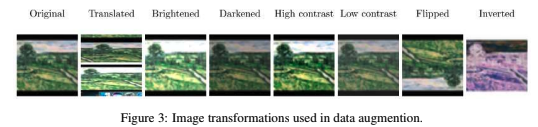

Initial Architecture:

* Convolutional layers: 
1) kernel size 7 and stride 1 and no_channels = 16.
2) kernel size 5 and stride 1 and no_channels = 32.
3) kernel size 3 and stride 1 and no_channels = 64.

* Pooling Layers:
1) Max pooling with kernel size 4, stride 2.
2) Max pooling with kernel size 4, stride 2.
3) Max pooling with kernel size 2, stride 2.

* Single fully connected layer

* Adam optimizer with weight decay = 1e-3.

* Dropout with p = 0.3

* I also applied following transformations for model to generalize better:

1) Resize images to 50x50 pixels.
2) Horizontal flipping (50% probability).
3) Random rotations (±10 degrees).
4) Color jittering (brightness, contrast, saturation, hue).
5) Normalize with mean and standard deviation.

### Performance: 

* Training accuracy: 69.44%

* Validation accuracy is 64.83%

**Augmentation Tests**

* Each test applied one by one to test the evaluate model' performance.

**Test-1: Horizontal Flipping**

* Applied random horizontal flipping with p = 0.5.

Performance: 

* Training accuracy: 62.27%

* Validation accuracy is 72.52%

**Test-2: Random Rotation**

* Applied random horizontal flipping with the change of 10 degrees.

Performance: 

* Training accuracy: 71.38%

* Validation accuracy is 70.33%

**Test-3: Color Jitter**

* Adjusted brightness, contrast, saturation, and hue.

Performance: 

* Training accuracy: 64.44%

* Validation accuracy is 69.23%


**Summary**

1. Were you surprised by any of the results?

Yes. I was surprised that all three augmentations increased validation accuracy compared to the baseline model. This indicates that the model struggled with generalization and the augmentations helped stabilize and improve its ability to classify unseen data.

2. Which transformations is your network most invariant to?

Network is most invariant to horizontal flipping. This suggest that network does not rely on the left/right composition of the artwork.

3. Which transformation caused the model to fail or drop in accuracy?

The information that caused the model to drop in accuracy the most was color jitter as it achieved the lowest validation accuracy. This indicates that model is sensetive to changes in brightness, contrast, saturation, and hue.


In [661]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=7,stride=1, device=device)
        #self.lrn1 = nn.LocalResponseNorm(size=5)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=4,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1, device=device)
        #self.lrn2 = nn.LocalResponseNorm(size=5)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=4,stride=2, padding=1)
        self.conv_layer3 = torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1, device=device)
        #self.lrn3 = nn.LocalResponseNorm(size=5)
        self.pool_layer3 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout = nn.Dropout(p=0.3)
        if pooling:
            self.fully_connected_layer = nn.Linear(576, 64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        #x = self.lrn1(x)
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        #x = self.lrn2(x)
        if self.pooling:
            x = self.pool_layer2(x)
        x = torch.nn.functional.relu(self.conv_layer3(x))
        #x = self.lrn3(x)
        if self.pooling:
            x = self.pool_layer3(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.dropout(x)
        x = self.final_layer(x)
        return x

In [662]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = True
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [675]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=POOLING)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation(10),
        #transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
        #transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['richard wilson', 'claude monet', 'paul sandby', 'peter paul rubens', 'canaletto', 'paul cezanne', 'j. m. w. turner', 'john robert cozens', 'paul gauguin', 'rembrandt', 'george romney']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [676]:
train_dataset = LoaderClass(data,labels,"train",transform["train"])
valid_dataset = LoaderClass(data,labels,"val",transform["val"])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0, pin_memory=True)

In [677]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=-1 ,batch_size=BATCH_SIZE,lr_scheduler=None)
best_model = trainer_m.train()

Epoch 0,phase: Training: 1it [00:00, 20867.18it/s, train_loss : ?, train_acc: ?]/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1,phase: Training: 2it [00:00,  3.29it/s, train acc:  0.195,train loss:  2.393]  

New best loss, loss is:  2.3930571476618447 acc is:  0.3076923076923077


Epoch 2,phase: Training: 3it [00:01,  1.83it/s, train acc:  0.258,train loss:  2.349]  

New best loss, loss is:  2.3610260486602783 acc is:  0.03296703296703297


Epoch 3,phase: Training: 4it [00:02,  1.79it/s, train acc:  0.306,train loss:  2.259]  

New best loss, loss is:  2.2593265374501548 acc is:  0.37362637362637363


Epoch 4,phase: Training: 5it [00:02,  1.81it/s, train acc:  0.326,train loss:  2.215]  

New best loss, loss is:  2.1992759704589844 acc is:  0.34065934065934067


Epoch 5,phase: Training: 6it [00:03,  1.79it/s, train acc:  0.362,train loss:  2.187]  

New best loss, loss is:  2.1759398380915322 acc is:  0.37362637362637363


Epoch 6,phase: Training: 7it [00:03,  1.80it/s, train acc:  0.330,train loss:  2.196]  

New best loss, loss is:  2.1570475896199546 acc is:  0.37362637362637363


Epoch 7,phase: Training: 8it [00:04,  1.73it/s, train acc:  0.347,train loss:  2.195]  

Not a better score


Epoch 8,phase: Training: 9it [00:05,  1.71it/s, train acc:  0.400,train loss:  2.148]  

Not a better score


Epoch 9,phase: Training: 10it [00:05,  1.74it/s, train acc:  0.361,train loss:  2.195] 

New best loss, loss is:  2.1498709122339883 acc is:  0.38461538461538464


Epoch 10,phase: Training: 11it [00:06,  1.77it/s, train acc:  0.350,train loss:  2.181] 

Not a better score


Epoch 11,phase: Training: 12it [00:06,  1.79it/s, train acc:  0.362,train loss:  2.171]  

New best loss, loss is:  2.149840235710144 acc is:  0.38461538461538464


Epoch 12,phase: Training: 13it [00:07,  1.84it/s, train acc:  0.356,train loss:  2.191]  

New best loss, loss is:  2.135256846745809 acc is:  0.4175824175824176


Epoch 13,phase: Training: 14it [00:07,  1.86it/s, train acc:  0.394,train loss:  2.145]  

New best loss, loss is:  2.1303312182426453 acc is:  0.3956043956043956


Epoch 14,phase: Training: 15it [00:08,  1.87it/s, train acc:  0.419,train loss:  2.128]  

Not a better score


Epoch 15,phase: Training: 16it [00:08,  1.91it/s, train acc:  0.419,train loss:  2.122]  

Not a better score


Epoch 16,phase: Training: 17it [00:09,  1.92it/s, train acc:  0.394,train loss:  2.143]  

Not a better score


Epoch 17,phase: Training: 18it [00:09,  1.95it/s, train acc:  0.369,train loss:  2.176]  

Not a better score


Epoch 18,phase: Training: 19it [00:10,  1.81it/s, train acc:  0.419,train loss:  2.139]  

New best loss, loss is:  2.1209604342778525 acc is:  0.4175824175824176


Epoch 19,phase: Training: 20it [00:11,  1.81it/s, train acc:  0.406,train loss:  2.152]  

Not a better score


Epoch 20,phase: Training: 21it [00:11,  1.76it/s, train acc:  0.438,train loss:  2.109]  

Not a better score


Epoch 21,phase: Training: 22it [00:12,  1.79it/s, train acc:  0.362,train loss:  2.161]  

Not a better score


Epoch 22,phase: Training: 23it [00:12,  1.83it/s, train acc:  0.388,train loss:  2.160]  

Not a better score


Epoch 23,phase: Training: 24it [00:13,  1.85it/s, train acc:  0.431,train loss:  2.117]  

Not a better score


Epoch 24,phase: Training: 25it [00:13,  1.88it/s, train acc:  0.450,train loss:  2.091]  

New best loss, loss is:  2.1147601207097373 acc is:  0.42857142857142855


Epoch 25,phase: Training: 26it [00:14,  1.90it/s, train acc:  0.464,train loss:  2.080]  

Not a better score


Epoch 26,phase: Training: 27it [00:14,  1.85it/s, train acc:  0.479,train loss:  2.065]  

Not a better score


Epoch 27,phase: Training: 28it [00:15,  1.88it/s, train acc:  0.463,train loss:  2.074]  

Not a better score


Epoch 28,phase: Training: 29it [00:15,  1.92it/s, train acc:  0.450,train loss:  2.079]  

New best loss, loss is:  2.109460711479187 acc is:  0.4175824175824176


Epoch 29,phase: Training: 30it [00:16,  1.96it/s, train acc:  0.456,train loss:  2.103]  

Not a better score


Epoch 30,phase: Training: 31it [00:16,  1.99it/s, train acc:  0.444,train loss:  2.113]  

Not a better score


Epoch 31,phase: Training: 32it [00:17,  2.01it/s, train acc:  0.469,train loss:  2.096]  

Not a better score


Epoch 32,phase: Training: 33it [00:17,  2.02it/s, train acc:  0.438,train loss:  2.098]  

Not a better score


Epoch 33,phase: Training: 34it [00:18,  2.02it/s, train acc:  0.425,train loss:  2.125]  

Not a better score


Epoch 34,phase: Training: 35it [00:18,  1.96it/s, train acc:  0.419,train loss:  2.130]  

Not a better score


Epoch 35,phase: Training: 36it [00:19,  1.96it/s, train acc:  0.431,train loss:  2.114]  

Not a better score


Epoch 36,phase: Training: 37it [00:19,  1.93it/s, train acc:  0.456,train loss:  2.093]  

Not a better score


Epoch 37,phase: Training: 38it [00:20,  1.93it/s, train acc:  0.487,train loss:  2.065]  

Not a better score


Epoch 38,phase: Training: 39it [00:20,  1.95it/s, train acc:  0.419,train loss:  2.128]  

New best loss, loss is:  2.106155971686045 acc is:  0.43956043956043955


Epoch 39,phase: Training: 40it [00:21,  1.91it/s, train acc:  0.456,train loss:  2.085]  

New best loss, loss is:  2.087743580341339 acc is:  0.42857142857142855


Epoch 40,phase: Training: 41it [00:21,  1.94it/s, train acc:  0.486,train loss:  2.065]  

Not a better score


Epoch 41,phase: Training: 42it [00:22,  1.93it/s, train acc:  0.425,train loss:  2.118]  

Not a better score


Epoch 42,phase: Training: 43it [00:22,  1.96it/s, train acc:  0.425,train loss:  2.112]  

Not a better score


Epoch 43,phase: Training: 44it [00:23,  1.95it/s, train acc:  0.444,train loss:  2.101]  

Not a better score


Epoch 44,phase: Training: 45it [00:23,  1.96it/s, train acc:  0.475,train loss:  2.064]  

Not a better score


Epoch 45,phase: Training: 46it [00:24,  1.95it/s, train acc:  0.469,train loss:  2.082]  

Not a better score


Epoch 46,phase: Training: 47it [00:25,  1.96it/s, train acc:  0.450,train loss:  2.117]  

Not a better score


Epoch 47,phase: Training: 48it [00:25,  1.97it/s, train acc:  0.481,train loss:  2.072]  

Not a better score


Epoch 48,phase: Training: 49it [00:26,  1.98it/s, train acc:  0.494,train loss:  2.064]  

Not a better score


Epoch 49,phase: Training: 50it [00:26,  1.93it/s, train acc:  0.481,train loss:  2.080]  

Not a better score


Epoch 50,phase: Training: 51it [00:27,  1.95it/s, train acc:  0.569,train loss:  2.002]  

Not a better score


Epoch 51,phase: Training: 52it [00:27,  1.97it/s, train acc:  0.487,train loss:  2.062]  

Not a better score


Epoch 52,phase: Training: 53it [00:28,  1.97it/s, train acc:  0.481,train loss:  2.060]  

Not a better score


Epoch 53,phase: Training: 54it [00:28,  1.96it/s, train acc:  0.519,train loss:  2.038]  

Not a better score


Epoch 54,phase: Training: 55it [00:29,  1.96it/s, train acc:  0.494,train loss:  2.074]  

Not a better score


Epoch 55,phase: Training: 56it [00:29,  1.96it/s, train acc:  0.500,train loss:  2.053]  

Not a better score


Epoch 56,phase: Training: 57it [00:30,  1.95it/s, train acc:  0.506,train loss:  2.049]  

New best loss, loss is:  2.069499135017395 acc is:  0.46153846153846156


Epoch 57,phase: Training: 58it [00:30,  1.95it/s, train acc:  0.537,train loss:  2.010]  

Not a better score


Epoch 58,phase: Training: 59it [00:31,  1.89it/s, train acc:  0.519,train loss:  2.036]  

New best loss, loss is:  2.0602600971857705 acc is:  0.4835164835164835


Epoch 59,phase: Training: 60it [00:31,  1.90it/s, train acc:  0.552,train loss:  2.011]  

Not a better score


Epoch 60,phase: Training: 61it [00:32,  1.71it/s, train acc:  0.507,train loss:  2.044]  

New best loss, loss is:  2.0535373091697693 acc is:  0.5054945054945055


Epoch 61,phase: Training: 62it [00:32,  1.75it/s, train acc:  0.556,train loss:  2.000]  

New best loss, loss is:  2.0412007570266724 acc is:  0.5164835164835165


Epoch 62,phase: Training: 63it [00:33,  1.81it/s, train acc:  0.494,train loss:  2.035]  

Not a better score


Epoch 63,phase: Training: 64it [00:33,  1.86it/s, train acc:  0.506,train loss:  2.038]  

New best loss, loss is:  2.031604071458181 acc is:  0.5054945054945055


Epoch 64,phase: Training: 65it [00:34,  1.89it/s, train acc:  0.525,train loss:  2.005]  

Not a better score


Epoch 65,phase: Training: 66it [00:35,  1.90it/s, train acc:  0.464,train loss:  2.079]  

Not a better score


Epoch 66,phase: Training: 67it [00:35,  1.85it/s, train acc:  0.456,train loss:  2.076]  

New best loss, loss is:  2.0305266777674356 acc is:  0.5384615384615384


Epoch 67,phase: Training: 68it [00:36,  1.87it/s, train acc:  0.506,train loss:  2.037]  

New best loss, loss is:  2.0224743684132895 acc is:  0.5494505494505495


Epoch 68,phase: Training: 69it [00:36,  1.89it/s, train acc:  0.500,train loss:  2.044]  

Not a better score


Epoch 69,phase: Training: 70it [00:37,  1.91it/s, train acc:  0.562,train loss:  1.988]  

Not a better score


Epoch 70,phase: Training: 71it [00:37,  1.93it/s, train acc:  0.519,train loss:  2.017]  

New best loss, loss is:  2.0196067492167153 acc is:  0.5494505494505495


Epoch 71,phase: Training: 72it [00:38,  1.87it/s, train acc:  0.550,train loss:  1.994]  

Not a better score


Epoch 72,phase: Training: 73it [00:38,  1.88it/s, train acc:  0.556,train loss:  2.008]  

New best loss, loss is:  2.014251490434011 acc is:  0.5164835164835165


Epoch 73,phase: Training: 74it [00:39,  1.90it/s, train acc:  0.506,train loss:  2.051]  

Not a better score


Epoch 74,phase: Training: 75it [00:39,  1.90it/s, train acc:  0.569,train loss:  1.996]  

Not a better score


Epoch 75,phase: Training: 76it [00:40,  1.91it/s, train acc:  0.588,train loss:  1.968]  

New best loss, loss is:  2.0112664500872293 acc is:  0.5274725274725275


Epoch 76,phase: Training: 77it [00:40,  1.91it/s, train acc:  0.562,train loss:  1.996]  

Not a better score


Epoch 77,phase: Training: 78it [00:41,  1.91it/s, train acc:  0.588,train loss:  1.983]  

Not a better score


Epoch 78,phase: Training: 79it [00:41,  1.88it/s, train acc:  0.650,train loss:  1.917]  

Not a better score


Epoch 79,phase: Training: 80it [00:42,  1.92it/s, train acc:  0.575,train loss:  1.997]  

New best loss, loss is:  1.9851559400558472 acc is:  0.5604395604395604


Epoch 80,phase: Training: 81it [00:42,  1.94it/s, train acc:  0.556,train loss:  1.982]  

Not a better score


Epoch 81,phase: Training: 82it [00:43,  1.96it/s, train acc:  0.619,train loss:  1.947]  

Not a better score


Epoch 82,phase: Training: 83it [00:43,  1.97it/s, train acc:  0.544,train loss:  2.001]  

Not a better score


Epoch 83,phase: Training: 84it [00:44,  1.97it/s, train acc:  0.555,train loss:  1.988]  

Not a better score


Epoch 84,phase: Training: 85it [00:44,  1.91it/s, train acc:  0.512,train loss:  2.038]  

Not a better score


Epoch 85,phase: Training: 86it [00:45,  1.93it/s, train acc:  0.562,train loss:  1.979]  

Not a better score


Epoch 86,phase: Training: 87it [00:46,  1.85it/s, train acc:  0.570,train loss:  1.990]  

Not a better score


Epoch 87,phase: Training: 88it [00:46,  1.79it/s, train acc:  0.569,train loss:  1.989]  

Not a better score


Epoch 88,phase: Training: 89it [00:47,  1.84it/s, train acc:  0.556,train loss:  1.997]  

Not a better score


Epoch 89,phase: Training: 90it [00:47,  1.88it/s, train acc:  0.581,train loss:  1.968]  

Not a better score


Epoch 90,phase: Training: 91it [00:48,  1.91it/s, train acc:  0.581,train loss:  1.975]  

Not a better score


Epoch 91,phase: Training: 92it [00:48,  1.90it/s, train acc:  0.600,train loss:  1.941]  

Not a better score


Epoch 92,phase: Training: 93it [00:49,  1.78it/s, train acc:  0.594,train loss:  1.954]  

Not a better score


Epoch 93,phase: Training: 94it [00:49,  1.83it/s, train acc:  0.588,train loss:  1.955]  

Not a better score


Epoch 94,phase: Training: 95it [00:50,  1.86it/s, train acc:  0.550,train loss:  1.988]  

Not a better score


Epoch 95,phase: Training: 96it [00:50,  1.87it/s, train acc:  0.613,train loss:  1.942]  

Not a better score


Epoch 96,phase: Training: 97it [00:51,  1.89it/s, train acc:  0.521,train loss:  2.033]  

Not a better score


Epoch 97,phase: Training: 98it [00:51,  1.89it/s, train acc:  0.575,train loss:  1.973]  

Not a better score


Epoch 98,phase: Training: 99it [00:52,  1.90it/s, train acc:  0.619,train loss:  1.951]  

Not a better score


Epoch 99,phase: Training: 100it [00:53,  1.86it/s, train acc:  0.588,train loss:  1.951] 

Not a better score


Epoch 100,phase: Training: 101it [00:53,  1.88it/s, train acc:  0.569,train loss:  1.982] 

Not a better score


Epoch 101,phase: Training: 102it [00:54,  1.90it/s, train acc:  0.613,train loss:  1.942]  

Not a better score


Epoch 102,phase: Training: 103it [00:54,  1.91it/s, train acc:  0.613,train loss:  1.951]  

Not a better score


Epoch 103,phase: Training: 104it [00:55,  1.93it/s, train acc:  0.613,train loss:  1.941]  

Not a better score


Epoch 104,phase: Training: 105it [00:55,  1.93it/s, train acc:  0.631,train loss:  1.910]  

Not a better score


Epoch 105,phase: Training: 106it [00:56,  1.94it/s, train acc:  0.618,train loss:  1.932]  

Not a better score


Epoch 106,phase: Training: 107it [00:56,  1.92it/s, train acc:  0.644,train loss:  1.906]  

Not a better score


Epoch 107,phase: Training: 108it [00:57,  1.90it/s, train acc:  0.662,train loss:  1.890]  

Not a better score


Epoch 108,phase: Training: 109it [00:57,  1.92it/s, train acc:  0.606,train loss:  1.938]  

Not a better score


Epoch 109,phase: Training: 110it [00:58,  1.97it/s, train acc:  0.588,train loss:  1.959]  

Not a better score


Epoch 110,phase: Training: 111it [00:58,  1.99it/s, train acc:  0.644,train loss:  1.912]  

Not a better score


Epoch 111,phase: Training: 112it [00:59,  2.01it/s, train acc:  0.585,train loss:  1.980]  

Not a better score


Epoch 112,phase: Training: 113it [00:59,  2.02it/s, train acc:  0.618,train loss:  1.933]  

Not a better score


Epoch 113,phase: Training: 114it [01:00,  1.97it/s, train acc:  0.625,train loss:  1.943]  

Not a better score


Epoch 114,phase: Training: 115it [01:00,  1.91it/s, train acc:  0.604,train loss:  1.950]  

Not a better score


Epoch 115,phase: Training: 116it [01:01,  1.87it/s, train acc:  0.653,train loss:  1.899]  

Not a better score


Epoch 116,phase: Training: 117it [01:01,  1.88it/s, train acc:  0.650,train loss:  1.895]  

Not a better score


Epoch 117,phase: Training: 118it [01:02,  1.91it/s, train acc:  0.619,train loss:  1.927]  

Not a better score


Epoch 118,phase: Training: 119it [01:02,  1.95it/s, train acc:  0.625,train loss:  1.938]  

Not a better score


Epoch 119,phase: Training: 120it [01:03,  1.98it/s, train acc:  0.625,train loss:  1.948]  

New best loss, loss is:  1.977232833703359 acc is:  0.5604395604395604


Epoch 120,phase: Training: 121it [01:03,  2.00it/s, train acc:  0.625,train loss:  1.927]  

Not a better score


Epoch 121,phase: Training: 122it [01:04,  2.02it/s, train acc:  0.631,train loss:  1.928]  

Not a better score


Epoch 122,phase: Training: 123it [01:04,  1.97it/s, train acc:  0.644,train loss:  1.908]  

Not a better score


Epoch 123,phase: Training: 124it [01:05,  1.99it/s, train acc:  0.688,train loss:  1.868]  

Not a better score


Epoch 124,phase: Training: 125it [01:05,  2.01it/s, train acc:  0.675,train loss:  1.890]  

Not a better score


Epoch 125,phase: Training: 126it [01:06,  2.03it/s, train acc:  0.650,train loss:  1.905]  

Not a better score


Epoch 126,phase: Training: 127it [01:06,  2.03it/s, train acc:  0.631,train loss:  1.919]  

Not a better score


Epoch 127,phase: Training: 128it [01:07,  2.04it/s, train acc:  0.637,train loss:  1.921]  

Not a better score


Epoch 128,phase: Training: 129it [01:07,  2.04it/s, train acc:  0.670,train loss:  1.878]  

Not a better score


Epoch 129,phase: Training: 130it [01:08,  2.06it/s, train acc:  0.648,train loss:  1.909]  

Not a better score


Epoch 130,phase: Training: 131it [01:08,  2.07it/s, train acc:  0.682,train loss:  1.871]  

Not a better score


Epoch 131,phase: Training: 132it [01:09,  2.06it/s, train acc:  0.669,train loss:  1.887]  

Not a better score


Epoch 132,phase: Training: 133it [01:09,  2.03it/s, train acc:  0.660,train loss:  1.891]  

Not a better score


Epoch 133,phase: Training: 134it [01:10,  1.99it/s, train acc:  0.637,train loss:  1.911]  

Not a better score


Epoch 134,phase: Training: 135it [01:10,  1.99it/s, train acc:  0.637,train loss:  1.915]  

Not a better score


Epoch 135,phase: Training: 136it [01:11,  1.97it/s, train acc:  0.713,train loss:  1.837]  

Not a better score


Epoch 136,phase: Training: 137it [01:11,  1.99it/s, train acc:  0.667,train loss:  1.892]  

Not a better score


Epoch 137,phase: Training: 138it [01:12,  1.95it/s, train acc:  0.625,train loss:  1.925]  

Not a better score


Epoch 138,phase: Training: 139it [01:12,  1.97it/s, train acc:  0.719,train loss:  1.842]  

Not a better score


Epoch 139,phase: Training: 140it [01:13,  1.96it/s, train acc:  0.631,train loss:  1.929]  

Not a better score


Epoch 140,phase: Training: 141it [01:13,  1.99it/s, train acc:  0.653,train loss:  1.896]  

Not a better score


Epoch 141,phase: Training: 142it [01:14,  2.01it/s, train acc:  0.650,train loss:  1.907]  

Not a better score


Epoch 142,phase: Training: 143it [01:14,  1.98it/s, train acc:  0.597,train loss:  1.960]  

New best loss, loss is:  1.9702773292859395 acc is:  0.5384615384615384


Epoch 143,phase: Training: 144it [01:15,  1.91it/s, train acc:  0.708,train loss:  1.841]  

Not a better score


Epoch 144,phase: Training: 145it [01:15,  1.85it/s, train acc:  0.681,train loss:  1.870]  

Not a better score


Epoch 145,phase: Training: 146it [01:16,  1.78it/s, train acc:  0.625,train loss:  1.920]  

Not a better score


Epoch 146,phase: Training: 147it [01:17,  1.65it/s, train acc:  0.648,train loss:  1.903]  

Not a better score


Epoch 147,phase: Training: 148it [01:17,  1.63it/s, train acc:  0.653,train loss:  1.901]  

Not a better score


Epoch 148,phase: Training: 149it [01:18,  1.69it/s, train acc:  0.674,train loss:  1.882]  

Not a better score


Epoch 149,phase: Training: 150it [01:18,  1.71it/s, train acc:  0.722,train loss:  1.827]  

Not a better score


Epoch 150,phase: Training: 151it [01:19,  1.75it/s, train acc:  0.660,train loss:  1.897]  

Not a better score


Epoch 151,phase: Training: 152it [01:20,  1.69it/s, train acc:  0.639,train loss:  1.912]  

Not a better score


Epoch 152,phase: Training: 153it [01:20,  1.73it/s, train acc:  0.694,train loss:  1.857]  

Not a better score


Epoch 153,phase: Training: 154it [01:21,  1.77it/s, train acc:  0.597,train loss:  1.957]  

Not a better score


Epoch 154,phase: Training: 155it [01:21,  1.80it/s, train acc:  0.646,train loss:  1.904]  

Not a better score


Epoch 155,phase: Training: 156it [01:22,  1.81it/s, train acc:  0.625,train loss:  1.921]  

Not a better score


Epoch 156,phase: Training: 157it [01:22,  1.83it/s, train acc:  0.681,train loss:  1.867]  

Not a better score


Epoch 157,phase: Training: 158it [01:23,  1.85it/s, train acc:  0.688,train loss:  1.882]  

Not a better score


Epoch 158,phase: Training: 159it [01:24,  1.76it/s, train acc:  0.653,train loss:  1.896]  

Not a better score


Epoch 159,phase: Training: 160it [01:24,  1.79it/s, train acc:  0.660,train loss:  1.890]  

Not a better score


Epoch 160,phase: Training: 161it [01:25,  1.80it/s, train acc:  0.706,train loss:  1.849]  

Not a better score


Epoch 161,phase: Training: 162it [01:25,  1.81it/s, train acc:  0.701,train loss:  1.850]  

Not a better score


Epoch 162,phase: Training: 163it [01:26,  1.82it/s, train acc:  0.681,train loss:  1.869]  

Not a better score


Epoch 163,phase: Training: 164it [01:26,  1.81it/s, train acc:  0.618,train loss:  1.925]  

Not a better score


Epoch 164,phase: Training: 165it [01:27,  1.82it/s, train acc:  0.632,train loss:  1.921]  

Not a better score


Epoch 165,phase: Training: 166it [01:27,  1.78it/s, train acc:  0.701,train loss:  1.863]  

Not a better score


Epoch 166,phase: Training: 167it [01:28,  1.80it/s, train acc:  0.650,train loss:  1.905]  

Not a better score


Epoch 167,phase: Training: 168it [01:28,  1.82it/s, train acc:  0.688,train loss:  1.863]  

Not a better score


Epoch 168,phase: Training: 169it [01:29,  1.78it/s, train acc:  0.674,train loss:  1.872]  

New best loss, loss is:  1.9600029389063518 acc is:  0.5714285714285714


Epoch 169,phase: Training: 170it [01:30,  1.79it/s, train acc:  0.644,train loss:  1.903]  

Not a better score


Epoch 170,phase: Training: 171it [01:30,  1.81it/s, train acc:  0.662,train loss:  1.889]  

Not a better score


Epoch 171,phase: Training: 172it [01:31,  1.83it/s, train acc:  0.694,train loss:  1.862]  

Not a better score


Epoch 172,phase: Training: 173it [01:31,  1.83it/s, train acc:  0.669,train loss:  1.887]  

Not a better score


Epoch 173,phase: Training: 174it [01:32,  1.84it/s, train acc:  0.729,train loss:  1.833]  

Not a better score


Epoch 174,phase: Training: 175it [01:32,  1.85it/s, train acc:  0.646,train loss:  1.908]  

Not a better score


Epoch 175,phase: Training: 176it [01:33,  1.85it/s, train acc:  0.653,train loss:  1.902]  

Not a better score


Epoch 176,phase: Training: 177it [01:33,  1.85it/s, train acc:  0.688,train loss:  1.854]  

Not a better score


Epoch 177,phase: Training: 178it [01:34,  1.85it/s, train acc:  0.681,train loss:  1.877]  

Not a better score


Epoch 178,phase: Training: 179it [01:34,  1.82it/s, train acc:  0.680,train loss:  1.868]  

Not a better score


Epoch 179,phase: Training: 180it [01:35,  1.80it/s, train acc:  0.715,train loss:  1.836]  

Not a better score


Epoch 180,phase: Training: 181it [01:36,  1.81it/s, train acc:  0.701,train loss:  1.856]  

Not a better score


Epoch 181,phase: Training: 182it [01:36,  1.78it/s, train acc:  0.708,train loss:  1.851]  

Not a better score


Epoch 182,phase: Training: 183it [01:37,  1.80it/s, train acc:  0.688,train loss:  1.866]  

Not a better score


Epoch 183,phase: Training: 184it [01:37,  1.82it/s, train acc:  0.653,train loss:  1.900]  

Not a better score


Epoch 184,phase: Training: 185it [01:38,  1.82it/s, train acc:  0.688,train loss:  1.864]  

Not a better score


Epoch 185,phase: Training: 186it [01:38,  1.83it/s, train acc:  0.674,train loss:  1.877]  

Not a better score


Epoch 186,phase: Training: 187it [01:39,  1.83it/s, train acc:  0.694,train loss:  1.857]  

Not a better score


Epoch 187,phase: Training: 188it [01:39,  1.84it/s, train acc:  0.729,train loss:  1.824]  

Not a better score


Epoch 188,phase: Training: 189it [01:40,  1.85it/s, train acc:  0.708,train loss:  1.841]  

Not a better score


Epoch 189,phase: Training: 190it [01:40,  1.85it/s, train acc:  0.667,train loss:  1.885]  

Not a better score


Epoch 190,phase: Training: 191it [01:41,  1.85it/s, train acc:  0.708,train loss:  1.839]  

Not a better score


Epoch 191,phase: Training: 192it [01:42,  1.84it/s, train acc:  0.646,train loss:  1.896]  

Not a better score


Epoch 192,phase: Training: 193it [01:42,  1.79it/s, train acc:  0.743,train loss:  1.810]  

Not a better score


Epoch 193,phase: Training: 194it [01:43,  1.80it/s, train acc:  0.625,train loss:  1.918]  

Not a better score


Epoch 194,phase: Training: 195it [01:43,  1.81it/s, train acc:  0.660,train loss:  1.883]  

Not a better score


Epoch 195,phase: Training: 196it [01:44,  1.82it/s, train acc:  0.736,train loss:  1.820]  

Not a better score


Epoch 196,phase: Training: 197it [01:44,  1.83it/s, train acc:  0.729,train loss:  1.816]  

Not a better score


Epoch 197,phase: Training: 198it [01:45,  1.75it/s, train acc:  0.708,train loss:  1.848]  

Not a better score


Epoch 198,phase: Training: 199it [01:46,  1.78it/s, train acc:  0.639,train loss:  1.916]  

Not a better score


Epoch 199,phase: Training: 200it [01:46,  1.80it/s, train acc:  0.722,train loss:  1.834]  

Not a better score


Epoch 199,phase: Validation: 200it [01:46,  1.87it/s, val acc:  0.510,val loss:  1.993]    

Not a better score
Training ended returning the best model
Best val acc: 0.5714285714285714, Best val loss: 1.9600029389063518, Best train acc: 0.6694444444444444, Best train loss: 1.8779863015465115 


## Part 2: Transfer Learning with Deep Network

In this part, you will fine-tune AlexNet model pretrained on ImageNet to recognize faces. For the sake of simplicity you may use [the pretrained AlexNet model](https://pytorch.org/hub/pytorch_vision_alexnet/) provided in PyTorch Hub. You will
work with a subset of the FaceScrub dataset. The subset of male actors is [here](http://www.cs.toronto.edu/~guerzhoy/321/proj1/subset_actors.txt) and the subset of female actors is [here](http://www.cs.toronto.edu/~guerzhoy/321/proj1/subset_actresses.txt). The dataset consists of URLs of images with faces, as well as the bounding boxes of the faces. The format of the bounding box is as follows (from the FaceScrub `readme.txt` file):

`
The format is x1,y1,x2,y2, where (x1,y1) is the coordinate of the top-left corner of the bounding box and (x2,y2) is that of the bottom-right corner, with (0,0) as the top-left corner of the image. Assuming the image is represented as a Python NumPy array I, a face
in I can be obtained as I[y1:y2, x1:x2].
`

You may find it helpful to use and/or modify [this script](www.cs.toronto.edu/~guerzhoy/321/proj1/get_data.py) for downloading the image data. Note that you should crop out the images of the faces and resize them to appropriate size before proceeding further. Make sure to check the SHA-256 hashes, and make sure to only keep faces for which the hashes match. You should set aside 70 images per faces for the training set, and use the rest for the test and validation set.

In [106]:
import os
import numpy as np
from PIL import Image

def load_cropped_data(path="/Users/ozanozak/Desktop/facescrub_cropped", image_size=28):
    all_images = {}

    actor_folders = sorted([
        f for f in os.listdir(path) 
        if os.path.isdir(os.path.join(path, f))
    ])

    print(f"Found {len(actor_folders)} actors")

    for actor_name in actor_folders:
        actor_path = os.path.join(path, actor_name)
        image_files = sorted([
            f for f in os.listdir(actor_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        images = []

        for img_file in image_files:
                img_path = os.path.join(actor_path, img_file)
                img = Image.open(img_path).convert("L")
                img = img.resize((image_size, image_size))
                arr = np.array(img)
                images.append(arr)
        all_images[actor_name] = images

    print(f"\nTotal people loaded: {len(all_images)}")
    return all_images
    

In [107]:
all_images = load_cropped_data()
print(len(all_images))                           
first_name = list(all_images.keys())[0]
first_img = all_images[first_name][0]
print(first_name, first_img.shape, first_img.dtype,
      first_img.min(), first_img.max())

Found 30 actors

Total people loaded: 30
30
Andy_Richter (28, 28) uint8 22 253


### Part 2.1: Train a Multilayer Perceptron
First resize the images to 28 × 28 pixels. Use a fully-connected neural network with a single hidden layer of size 300 units.
Below, include the learning curve for the test, training, and validation sets, and the final performance classification on the test set. Include a text description of your system. In particular, describe how you preprocessed the input and initialized the weights, what activation function you used, and what the exact architecture of the network that you selected was. You might get performances close to 80-85% accuracy rate.

**Pre-processing**

I used the new zip file. The zip file already included images that were cropped. So I only turned them to grayscale and normalized the images with mean = 0.5 and std = 0.5 for consistent input scaling. I also used horizontal flipping and random rotation on the training set.


**MLP Architecture**

* My model is taking 28x28 sized images but they are flattened so it takes 784 input units.

* My model only has one hidden layer with 300 hidden units and at the output layer it has 30 output units.


1) Optimizer: Adam with a learning rate of 1e-4.
2) Criterion: Cross-Entropy Loss.
3) Batch Size: 16.
4) Epochs: 100 with early stopping (patience = 5).
5) Initialization: Default weight initialization.

**Configs**

I tried many different configurations to prevent overfitting and increase both validation and test accuracy.

* For optimizer I used adam optimizer with weight decay rate of 1e-4. 

* For criterion I used Cross Entropy Loss

* I had a batch size of 32

* Epochs = 100

* I used dropout before the last layer with the probability = 0.2.

* I applied batch norm after the first fully connected layer.

**Results**

* Best training accuracy: 85.15%
* Best validation accuracy: 75.16%
* Test Acc: 75.60%

(I ran the MLP one last time to check if the codes were working before submitting that's why the accuracies are different. They are pretty close)

**Summary**

I trained the models with different combinations of hyperparameters, I even tried deeper networks I know we are restricted with only one hidden layer but I wanted to experiment with other architectures to see if different architectures would help to boost the test and validation accuracy, I tried different transformations with different parameters but I couldn't achive the desired 80-85% accuracy. 

Actor: Chris_Klein
Shape: (28, 28)  and dtype: uint8


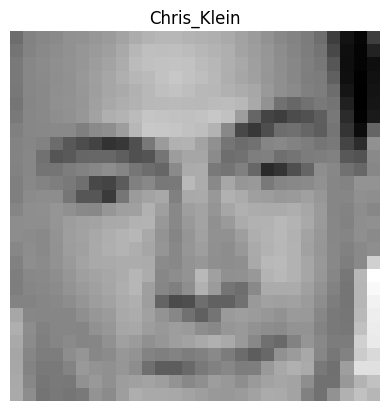

In [76]:
import matplotlib.pyplot as plt
import random

def show_random_face(all_images):
    actor = random.choice(list(all_images.keys()))
    img = random.choice(all_images[actor])

    print(f"Actor: {actor}")
    print("Shape:", img.shape, " and dtype:", img.dtype)

    plt.imshow(img, cmap="gray")
    plt.title(actor)
    plt.axis("off")
    plt.show()

show_random_face(all_images)

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
class MLP(nn.Module):
    def __init__(self, device, input_size, hidden_size, output_size, dropout_p):
        super(MLP, self).__init__()
        self.device = device
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)
        
    
        self.fc2 = nn.Linear(hidden_size, output_size)
    

    def forward(self,x):
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x


In [33]:
from torch.utils.data import Dataset

class LoaderClass(Dataset):
    def __init__(self, data, labels, transforms):
    
        self.data = data
        self.labels = labels
        self.transforms = transforms
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = Image.fromarray(img)
        img = self.transforms(img)
        
        return img, torch.tensor(label, dtype=torch.long)

In [34]:
def split_data(all_images, n_train=70):
    
    name_2_label = {name: i for i, name in enumerate(all_images.keys())}
    print(f"Target classes: {name_2_label}")

    train_data, train_labels = [], []
    val_data, val_labels = [], []
    test_data, test_labels = [], []
    
    np.random.seed(42)

    for name, images in all_images.items(): 
        label = name_2_label[name]
        images = list(images)          
        np.random.shuffle(images)


            
        train_imgs = images[:n_train]
        remaining = images[n_train:]

        validation_number = len(remaining) // 2
        val_imgs = remaining[:validation_number]
        test_imgs = remaining[validation_number:]


        train_data.extend(train_imgs)
        train_labels.extend([label] * len(train_imgs))
        
        val_data.extend(val_imgs)
        val_labels.extend([label] * len(val_imgs))
        
        test_data.extend(test_imgs)
        test_labels.extend([label] * len(test_imgs))
    
    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    val_data = np.array(val_data)
    val_labels = np.array(val_labels)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    print(f"\nDataset split:")
    print(f"Train: {len(train_data)} images")
    print(f"Val: {len(val_data)} images")
    print(f"Test: {len(test_data)} images")
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "val_data": val_data,
        "val_labels": val_labels,
        "test_data": test_data,
        "test_labels": test_labels,
        "name_to_label": name_2_label,
        "label_to_name": {v: k for k, v in name_2_label.items()}
    }

data_splits = split_data(all_images=all_images)

Target classes: {'Andy_Richter': 0, 'Angie_Harmon': 1, 'Carmen_Electra': 2, 'Cary_Elwes': 3, 'Chris_Klein': 4, 'Chris_Noth': 5, 'Dana_Delany': 6, 'Daniel_Radcliffe': 7, 'Didi_Conn': 8, 'Dina_Meyer': 9, 'Gary_Dourdan': 10, 'Gerard_Butler': 11, 'Holly_Marie_Combs': 12, 'Jason_Statham': 13, 'Julia_Louis-Dreyfus': 14, 'Kerr_Smith': 15, 'Kim_Cattrall': 16, 'Laura_Innes': 17, 'Leonardo_DiCaprio': 18, 'Lindsay_Hartley': 19, 'Loni_Anderson': 20, 'Lorraine_Bracco': 21, 'Matt_Long': 22, 'Matthew_Gray_Gubler': 23, 'Michael_Vartan': 24, 'Paul_Walker': 25, 'Peri_Gilpin': 26, 'Richard_Madden': 27, 'Teri_Hatcher': 28, 'Vanessa_Marcil': 29}

Dataset split:
Train: 1812 images
Val: 161 images
Test: 168 images


In [ ]:
import copy

from tqdm import tqdm

class Trainer:
    def __init__(self, model, criterion, tr_loader, val_loader, optimizer,
             num_epoch, patience, batch_size, device, lr_scheduler=None):
        self.model = model
        self.tr_loader = tr_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.num_epoch = num_epoch
        self.patience = patience
        self.lr_scheduler = lr_scheduler
        self.criterion = criterion
        self.softmax = nn.Softmax(-1)
        self.no_inc = 0
        self.best_loss = 9999
        self.phases = ["train","val","test"]
        self.best_model = []
        self.best_val_acc = 0
        self.best_train_acc = 0
        self.best_val_loss = 0
        self.best_train_loss = 0
        self.batch_size = batch_size
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        self.device = device
        self.best_model_state = None
        


    def train_for_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(self.tr_loader, desc="Training", leave=False):
            images = images.to(self.device)
            labels = labels.to(self.device)

            logits = self.model(images)
            loss = self.criterion(logits, labels.long())
            _ , predictions = torch.max(logits, 1)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)
            total += labels.size(0)
            correct += torch.sum(predictions == labels).item()

        epoch_loss = running_loss / total
        epoch_accuracy = 100.0 * correct / total
        
        return epoch_loss, epoch_accuracy

    
    def validation_for_one_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validation", leave=False):
                images = images.to(self.device)
                labels = labels.to(self.device)

                logits = self.model(images)
                loss = self.criterion(logits, labels.long())
                _ , predictions = torch.max(logits, 1)
                running_loss += loss.item() * images.size(0)
                total += labels.size(0)
                correct += torch.sum(predictions == labels).item()
                

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        
        return epoch_loss, epoch_acc


    def train_all_epochs(self):

        print(f"Training for {self.num_epoch} epochs")
        print(f"Device: {self.device}")
        print(f"Patience: {self.patience}")
        print("-" * 60)

        for epoch in range(self.num_epoch):
            print(f"\nEpoch {epoch + 1}/{self.num_epoch}")

            train_loss, train_accuracy = self.train_for_one_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_accuracy)
            
            val_loss, val_accuracy = self.validation_for_one_epoch()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_accuracy)

            if self.lr_scheduler:
                self.lr_scheduler.step()


            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            if val_accuracy > self.best_val_acc:
                self.best_val_acc = val_accuracy
                self.best_val_loss = val_loss
                self.best_train_acc = train_accuracy
                self.best_train_loss = train_loss
                self.best_model_state = copy.deepcopy(self.model.state_dict())
                self.no_inc = 0
                print(f"New best validation accuracy: {self.best_val_acc:.2f}%")
            else:
                self.no_inc += 1
                print(f"No improvement ({self.no_inc}/{self.patience})")


            if self.patience != -1 and self.no_inc >= self.patience:
                print(f"\n{'='*60}")
                print(f"Early stopping triggered at epoch {epoch + 1}")
                print(f"Best validation accuracy: {self.best_val_acc:.2f}%")
                print(f"{'='*60}")
                break


        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"\nLoaded best model from training")
            print(f"Best validation accuracy: {self.best_val_acc:.2f}%")
            print(f"Best validation loss: {self.best_val_loss:.4f}")
            print(f"Best training accuracy: {self.best_train_acc:.2f}%")
            print(f"Best training loss: {self.best_train_loss:.4f}")

        return {
            "train_losses": self.train_losses,
            "train_accs": self.train_accs,
            "val_losses": self.val_losses,
            "val_accs": self.val_accs,
            "best_val_acc": self.best_val_acc,
            "best_val_loss": self.best_val_loss,
            "best_train_acc": self.best_train_acc,
            "best_train_loss": self.best_train_loss
        }
            

    def test_model(self, test_loader):

        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        print("\nStarting on test set :)))))")


        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing", leave=False):
                images = images.to(self.device)
                labels = labels.to(self.device)

                logits = self.model(images)
                loss = self.criterion(logits, labels.long())
                _ , predictions = torch.max(logits, 1)


                running_loss += loss.item() * images.size(0)
                total += labels.size(0)
                correct += torch.sum(predictions == labels).item()
                

        test_loss = running_loss / total
        test_acc = 100.0 * correct / total
        
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        
        return test_loss, test_acc


    
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        epochs = range(1, len(self.train_losses) + 1)
        
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=4)
        ax1.plot(epochs, self.val_losses, 'r-s', label='Val Loss', linewidth=2, markersize=4)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(epochs, self.train_accs, 'b-o', label='Train Acc', linewidth=2, markersize=4)
        ax2.plot(epochs, self.val_accs, 'r-s', label='Val Acc', linewidth=2, markersize=4)
        ax2.axhline(y=self.best_val_acc, color='g', linestyle='--', 
                    label=f'Best Val Acc: {self.best_val_acc:.2f}%', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
    
        
        plt.show()


In [39]:
splits = split_data(all_images) 

transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

train_dataset = LoaderClass(
    splits["train_data"], 
    splits["train_labels"], 
    transform["train"]
)

val_dataset = LoaderClass(
    splits["val_data"], 
    splits["val_labels"], 
    transform["val"]
)

test_dataset = LoaderClass(
    splits["test_data"], 
    splits["test_labels"], 
    transform["test"]
)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)


Target classes: {'Andy_Richter': 0, 'Angie_Harmon': 1, 'Carmen_Electra': 2, 'Cary_Elwes': 3, 'Chris_Klein': 4, 'Chris_Noth': 5, 'Dana_Delany': 6, 'Daniel_Radcliffe': 7, 'Didi_Conn': 8, 'Dina_Meyer': 9, 'Gary_Dourdan': 10, 'Gerard_Butler': 11, 'Holly_Marie_Combs': 12, 'Jason_Statham': 13, 'Julia_Louis-Dreyfus': 14, 'Kerr_Smith': 15, 'Kim_Cattrall': 16, 'Laura_Innes': 17, 'Leonardo_DiCaprio': 18, 'Lindsay_Hartley': 19, 'Loni_Anderson': 20, 'Lorraine_Bracco': 21, 'Matt_Long': 22, 'Matthew_Gray_Gubler': 23, 'Michael_Vartan': 24, 'Paul_Walker': 25, 'Peri_Gilpin': 26, 'Richard_Madden': 27, 'Teri_Hatcher': 28, 'Vanessa_Marcil': 29}

Dataset split:
Train: 1812 images
Val: 161 images
Test: 168 images


In [40]:
LR = 0.001
HIDDEN_SIZE = 300
INPUT_SIZE = 784
OUTPUT_SIZE = 30 
BATCH_SIZE = 32
NUM_EPOCHS = 100
PATIENCE = -1

Training for 100 epochs
Device: cpu
Patience: -1
------------------------------------------------------------

Epoch 1/100


Train Loss: 3.0973, Train Accuracy: 13.69%
Val Loss: 2.4751, Val Accuracy: 32.92%
New best validation accuracy: 32.92%

Epoch 2/100


Train Loss: 2.6241, Train Accuracy: 27.76%
Val Loss: 2.1322, Val Accuracy: 42.86%
New best validation accuracy: 42.86%

Epoch 3/100


Train Loss: 2.3468, Train Accuracy: 36.59%
Val Loss: 1.8514, Val Accuracy: 51.55%
New best validation accuracy: 51.55%

Epoch 4/100


Train Loss: 2.1356, Train Accuracy: 42.38%
Val Loss: 1.7496, Val Accuracy: 52.80%
New best validation accuracy: 52.80%

Epoch 5/100


Train Loss: 2.0006, Train Accuracy: 45.64%
Val Loss: 1.7007, Val Accuracy: 54.04%
New best validation accuracy: 54.04%

Epoch 6/100


Train Loss: 1.8905, Train Accuracy: 49.23%
Val Loss: 1.5944, Val Accuracy: 55.28%
New best validation accuracy: 55.28%

Epoch 7/100


Train Loss: 1.7982, Train Accuracy: 51.38%
Val Loss: 1.5642, Val Accuracy: 61.49%
New best validation accuracy: 61.49%

Epoch 8/100


Train Loss: 1.6864, Train Accuracy: 53.26%
Val Loss: 1.5778, Val Accuracy: 56.52%
No improvement (1/-1)

Epoch 9/100


Train Loss: 1.6360, Train Accuracy: 54.30%
Val Loss: 1.3613, Val Accuracy: 65.22%
New best validation accuracy: 65.22%

Epoch 10/100


Train Loss: 1.5465, Train Accuracy: 58.50%
Val Loss: 1.3198, Val Accuracy: 64.60%
No improvement (1/-1)

Epoch 11/100


Train Loss: 1.5018, Train Accuracy: 58.39%
Val Loss: 1.2970, Val Accuracy: 65.84%
New best validation accuracy: 65.84%

Epoch 12/100


Train Loss: 1.4637, Train Accuracy: 60.60%
Val Loss: 1.2811, Val Accuracy: 65.84%
No improvement (1/-1)

Epoch 13/100


Train Loss: 1.3963, Train Accuracy: 61.42%
Val Loss: 1.2710, Val Accuracy: 67.08%
New best validation accuracy: 67.08%

Epoch 14/100


Train Loss: 1.3847, Train Accuracy: 61.53%
Val Loss: 1.2428, Val Accuracy: 68.94%
New best validation accuracy: 68.94%

Epoch 15/100


Train Loss: 1.3122, Train Accuracy: 63.30%
Val Loss: 1.2602, Val Accuracy: 67.70%
No improvement (1/-1)

Epoch 16/100


Train Loss: 1.3023, Train Accuracy: 64.24%
Val Loss: 1.2165, Val Accuracy: 67.08%
No improvement (2/-1)

Epoch 17/100


Train Loss: 1.2685, Train Accuracy: 64.96%
Val Loss: 1.1676, Val Accuracy: 69.57%
New best validation accuracy: 69.57%

Epoch 18/100


Train Loss: 1.2396, Train Accuracy: 65.56%
Val Loss: 1.1255, Val Accuracy: 70.81%
New best validation accuracy: 70.81%

Epoch 19/100


Train Loss: 1.2603, Train Accuracy: 65.18%
Val Loss: 1.1421, Val Accuracy: 69.57%
No improvement (1/-1)

Epoch 20/100


Train Loss: 1.1381, Train Accuracy: 67.77%
Val Loss: 1.2539, Val Accuracy: 63.35%
No improvement (2/-1)

Epoch 21/100


Train Loss: 1.1116, Train Accuracy: 69.59%
Val Loss: 1.1206, Val Accuracy: 68.94%
No improvement (3/-1)

Epoch 22/100


Train Loss: 1.1139, Train Accuracy: 68.93%
Val Loss: 1.1528, Val Accuracy: 67.08%
No improvement (4/-1)

Epoch 23/100


Train Loss: 1.0965, Train Accuracy: 68.98%
Val Loss: 1.1118, Val Accuracy: 72.05%
New best validation accuracy: 72.05%

Epoch 24/100


Train Loss: 1.1120, Train Accuracy: 68.49%
Val Loss: 1.1800, Val Accuracy: 68.94%
No improvement (1/-1)

Epoch 25/100


Train Loss: 1.0366, Train Accuracy: 69.87%
Val Loss: 1.0774, Val Accuracy: 70.81%
No improvement (2/-1)

Epoch 26/100


Train Loss: 0.9993, Train Accuracy: 70.75%
Val Loss: 1.1025, Val Accuracy: 70.81%
No improvement (3/-1)

Epoch 27/100


Train Loss: 0.9742, Train Accuracy: 73.12%
Val Loss: 1.2412, Val Accuracy: 62.11%
No improvement (4/-1)

Epoch 28/100


Train Loss: 0.9997, Train Accuracy: 70.92%
Val Loss: 1.1111, Val Accuracy: 69.57%
No improvement (5/-1)

Epoch 29/100


Train Loss: 0.9696, Train Accuracy: 72.08%
Val Loss: 1.2367, Val Accuracy: 63.35%
No improvement (6/-1)

Epoch 30/100


Train Loss: 0.9545, Train Accuracy: 72.90%
Val Loss: 1.2390, Val Accuracy: 65.22%
No improvement (7/-1)

Epoch 31/100


Train Loss: 0.9330, Train Accuracy: 73.23%
Val Loss: 1.1923, Val Accuracy: 70.19%
No improvement (8/-1)

Epoch 32/100


Train Loss: 0.9345, Train Accuracy: 73.40%
Val Loss: 1.1890, Val Accuracy: 65.84%
No improvement (9/-1)

Epoch 33/100


Train Loss: 0.9314, Train Accuracy: 73.57%
Val Loss: 1.1282, Val Accuracy: 72.67%
New best validation accuracy: 72.67%

Epoch 34/100


Train Loss: 0.8658, Train Accuracy: 75.77%
Val Loss: 1.1040, Val Accuracy: 69.57%
No improvement (1/-1)

Epoch 35/100


Train Loss: 0.8808, Train Accuracy: 74.39%
Val Loss: 1.1627, Val Accuracy: 71.43%
No improvement (2/-1)

Epoch 36/100


Train Loss: 0.9025, Train Accuracy: 74.17%
Val Loss: 1.0819, Val Accuracy: 68.94%
No improvement (3/-1)

Epoch 37/100


Train Loss: 0.8216, Train Accuracy: 76.38%
Val Loss: 1.1505, Val Accuracy: 69.57%
No improvement (4/-1)

Epoch 38/100


Train Loss: 0.8149, Train Accuracy: 77.10%
Val Loss: 1.0735, Val Accuracy: 72.67%
No improvement (5/-1)

Epoch 39/100


Train Loss: 0.8218, Train Accuracy: 75.61%
Val Loss: 1.1615, Val Accuracy: 70.81%
No improvement (6/-1)

Epoch 40/100


Train Loss: 0.7973, Train Accuracy: 76.10%
Val Loss: 1.1432, Val Accuracy: 71.43%
No improvement (7/-1)

Epoch 41/100


Train Loss: 0.7935, Train Accuracy: 76.77%
Val Loss: 1.0594, Val Accuracy: 72.67%
No improvement (8/-1)

Epoch 42/100


Train Loss: 0.7665, Train Accuracy: 78.20%
Val Loss: 1.0451, Val Accuracy: 68.32%
No improvement (9/-1)

Epoch 43/100


Train Loss: 0.7846, Train Accuracy: 76.93%
Val Loss: 1.1199, Val Accuracy: 68.94%
No improvement (10/-1)

Epoch 44/100


Train Loss: 0.7447, Train Accuracy: 76.71%
Val Loss: 1.1881, Val Accuracy: 67.70%
No improvement (11/-1)

Epoch 45/100


Train Loss: 0.7330, Train Accuracy: 77.81%
Val Loss: 1.1532, Val Accuracy: 67.08%
No improvement (12/-1)

Epoch 46/100


Train Loss: 0.7285, Train Accuracy: 78.37%
Val Loss: 1.1837, Val Accuracy: 70.19%
No improvement (13/-1)

Epoch 47/100


Train Loss: 0.7004, Train Accuracy: 79.42%
Val Loss: 1.1592, Val Accuracy: 70.19%
No improvement (14/-1)

Epoch 48/100


Train Loss: 0.6945, Train Accuracy: 80.52%
Val Loss: 1.0958, Val Accuracy: 69.57%
No improvement (15/-1)

Epoch 49/100


Train Loss: 0.7183, Train Accuracy: 78.37%
Val Loss: 1.1710, Val Accuracy: 68.32%
No improvement (16/-1)

Epoch 50/100


Train Loss: 0.6449, Train Accuracy: 80.96%
Val Loss: 1.1555, Val Accuracy: 68.32%
No improvement (17/-1)

Epoch 51/100


Train Loss: 0.6900, Train Accuracy: 79.14%
Val Loss: 1.1966, Val Accuracy: 68.94%
No improvement (18/-1)

Epoch 52/100


Train Loss: 0.6561, Train Accuracy: 81.24%
Val Loss: 1.0802, Val Accuracy: 70.81%
No improvement (19/-1)

Epoch 53/100


Train Loss: 0.6779, Train Accuracy: 80.68%
Val Loss: 1.0991, Val Accuracy: 67.70%
No improvement (20/-1)

Epoch 54/100


Train Loss: 0.6701, Train Accuracy: 79.86%
Val Loss: 1.1972, Val Accuracy: 68.94%
No improvement (21/-1)

Epoch 55/100


Train Loss: 0.6542, Train Accuracy: 80.13%
Val Loss: 1.1870, Val Accuracy: 67.70%
No improvement (22/-1)

Epoch 56/100


Train Loss: 0.6354, Train Accuracy: 81.02%
Val Loss: 1.1652, Val Accuracy: 65.84%
No improvement (23/-1)

Epoch 57/100


Train Loss: 0.6224, Train Accuracy: 81.13%
Val Loss: 1.2529, Val Accuracy: 67.70%
No improvement (24/-1)

Epoch 58/100


Train Loss: 0.6573, Train Accuracy: 80.24%
Val Loss: 1.1295, Val Accuracy: 67.70%
No improvement (25/-1)

Epoch 59/100


Train Loss: 0.6353, Train Accuracy: 80.85%
Val Loss: 1.1290, Val Accuracy: 68.94%
No improvement (26/-1)

Epoch 60/100


Train Loss: 0.5728, Train Accuracy: 82.51%
Val Loss: 1.1601, Val Accuracy: 67.08%
No improvement (27/-1)

Epoch 61/100


Train Loss: 0.5843, Train Accuracy: 83.06%
Val Loss: 1.1676, Val Accuracy: 70.19%
No improvement (28/-1)

Epoch 62/100


Train Loss: 0.5855, Train Accuracy: 82.67%
Val Loss: 1.1357, Val Accuracy: 72.67%
No improvement (29/-1)

Epoch 63/100


Train Loss: 0.6028, Train Accuracy: 81.95%
Val Loss: 1.1611, Val Accuracy: 70.19%
No improvement (30/-1)

Epoch 64/100


Train Loss: 0.5758, Train Accuracy: 82.17%
Val Loss: 1.0237, Val Accuracy: 74.53%
New best validation accuracy: 74.53%

Epoch 65/100


Train Loss: 0.5537, Train Accuracy: 82.84%
Val Loss: 1.0442, Val Accuracy: 72.05%
No improvement (1/-1)

Epoch 66/100


Train Loss: 0.5708, Train Accuracy: 82.89%
Val Loss: 1.1908, Val Accuracy: 72.05%
No improvement (2/-1)

Epoch 67/100


Train Loss: 0.5691, Train Accuracy: 82.51%
Val Loss: 1.2486, Val Accuracy: 68.94%
No improvement (3/-1)

Epoch 68/100


Train Loss: 0.5445, Train Accuracy: 83.44%
Val Loss: 1.0721, Val Accuracy: 73.29%
No improvement (4/-1)

Epoch 69/100


Train Loss: 0.5194, Train Accuracy: 84.44%
Val Loss: 1.0894, Val Accuracy: 72.67%
No improvement (5/-1)

Epoch 70/100


Train Loss: 0.5475, Train Accuracy: 83.22%
Val Loss: 1.1817, Val Accuracy: 72.67%
No improvement (6/-1)

Epoch 71/100


Train Loss: 0.5232, Train Accuracy: 84.71%
Val Loss: 1.1449, Val Accuracy: 72.67%
No improvement (7/-1)

Epoch 72/100


Train Loss: 0.5367, Train Accuracy: 83.83%
Val Loss: 1.1311, Val Accuracy: 72.05%
No improvement (8/-1)

Epoch 73/100


Train Loss: 0.5341, Train Accuracy: 85.21%
Val Loss: 1.2157, Val Accuracy: 72.05%
No improvement (9/-1)

Epoch 74/100


Train Loss: 0.5164, Train Accuracy: 84.49%
Val Loss: 1.2171, Val Accuracy: 72.67%
No improvement (10/-1)

Epoch 75/100


Train Loss: 0.4975, Train Accuracy: 84.44%
Val Loss: 1.2043, Val Accuracy: 72.05%
No improvement (11/-1)

Epoch 76/100


Train Loss: 0.5193, Train Accuracy: 84.38%
Val Loss: 1.2371, Val Accuracy: 72.05%
No improvement (12/-1)

Epoch 77/100


Train Loss: 0.5124, Train Accuracy: 84.60%
Val Loss: 1.2765, Val Accuracy: 67.70%
No improvement (13/-1)

Epoch 78/100


Train Loss: 0.4784, Train Accuracy: 86.15%
Val Loss: 1.1748, Val Accuracy: 68.94%
No improvement (14/-1)

Epoch 79/100


Train Loss: 0.4966, Train Accuracy: 85.87%
Val Loss: 1.2192, Val Accuracy: 73.29%
No improvement (15/-1)

Epoch 80/100


Train Loss: 0.4979, Train Accuracy: 84.88%
Val Loss: 1.2820, Val Accuracy: 71.43%
No improvement (16/-1)

Epoch 81/100


Train Loss: 0.4722, Train Accuracy: 85.98%
Val Loss: 1.2709, Val Accuracy: 74.53%
No improvement (17/-1)

Epoch 82/100


Train Loss: 0.4784, Train Accuracy: 86.81%
Val Loss: 1.1078, Val Accuracy: 73.91%
No improvement (18/-1)

Epoch 83/100


Train Loss: 0.4939, Train Accuracy: 84.38%
Val Loss: 1.2553, Val Accuracy: 70.19%
No improvement (19/-1)

Epoch 84/100


Train Loss: 0.4500, Train Accuracy: 86.42%
Val Loss: 1.1462, Val Accuracy: 72.67%
No improvement (20/-1)

Epoch 85/100


Train Loss: 0.4607, Train Accuracy: 86.87%
Val Loss: 1.1772, Val Accuracy: 70.19%
No improvement (21/-1)

Epoch 86/100


Train Loss: 0.4465, Train Accuracy: 86.70%
Val Loss: 1.1515, Val Accuracy: 72.05%
No improvement (22/-1)

Epoch 87/100


Train Loss: 0.4883, Train Accuracy: 85.65%
Val Loss: 1.2574, Val Accuracy: 71.43%
No improvement (23/-1)

Epoch 88/100


Train Loss: 0.4530, Train Accuracy: 86.59%
Val Loss: 1.2588, Val Accuracy: 69.57%
No improvement (24/-1)

Epoch 89/100


Train Loss: 0.4599, Train Accuracy: 86.98%
Val Loss: 1.2573, Val Accuracy: 70.81%
No improvement (25/-1)

Epoch 90/100


Train Loss: 0.4746, Train Accuracy: 86.59%
Val Loss: 1.1796, Val Accuracy: 72.67%
No improvement (26/-1)

Epoch 91/100


Train Loss: 0.4669, Train Accuracy: 85.93%
Val Loss: 1.2320, Val Accuracy: 69.57%
No improvement (27/-1)

Epoch 92/100


Train Loss: 0.4620, Train Accuracy: 85.76%
Val Loss: 1.1097, Val Accuracy: 73.91%
No improvement (28/-1)

Epoch 93/100


Train Loss: 0.4509, Train Accuracy: 86.87%
Val Loss: 1.2888, Val Accuracy: 69.57%
No improvement (29/-1)

Epoch 94/100


Train Loss: 0.4252, Train Accuracy: 87.80%
Val Loss: 1.1251, Val Accuracy: 73.91%
No improvement (30/-1)

Epoch 95/100


Train Loss: 0.4396, Train Accuracy: 86.09%
Val Loss: 1.1966, Val Accuracy: 72.67%
No improvement (31/-1)

Epoch 96/100


Train Loss: 0.4328, Train Accuracy: 87.14%
Val Loss: 1.1262, Val Accuracy: 69.57%
No improvement (32/-1)

Epoch 97/100


Train Loss: 0.4276, Train Accuracy: 87.36%
Val Loss: 1.2088, Val Accuracy: 69.57%
No improvement (33/-1)

Epoch 98/100


Train Loss: 0.4091, Train Accuracy: 88.08%
Val Loss: 1.0941, Val Accuracy: 73.29%
No improvement (34/-1)

Epoch 99/100


Train Loss: 0.3955, Train Accuracy: 87.75%
Val Loss: 1.2508, Val Accuracy: 72.67%
No improvement (35/-1)

Epoch 100/100


Train Loss: 0.4140, Train Accuracy: 88.25%
Val Loss: 1.2601, Val Accuracy: 72.05%
No improvement (36/-1)

Loaded best model from training
Best validation accuracy: 74.53%
Best validation loss: 1.0237
Best training accuracy: 82.17%
Best training loss: 0.5758

Starting on test set :)))))


Test Loss: 1.3567, Test Acc: 73.81%


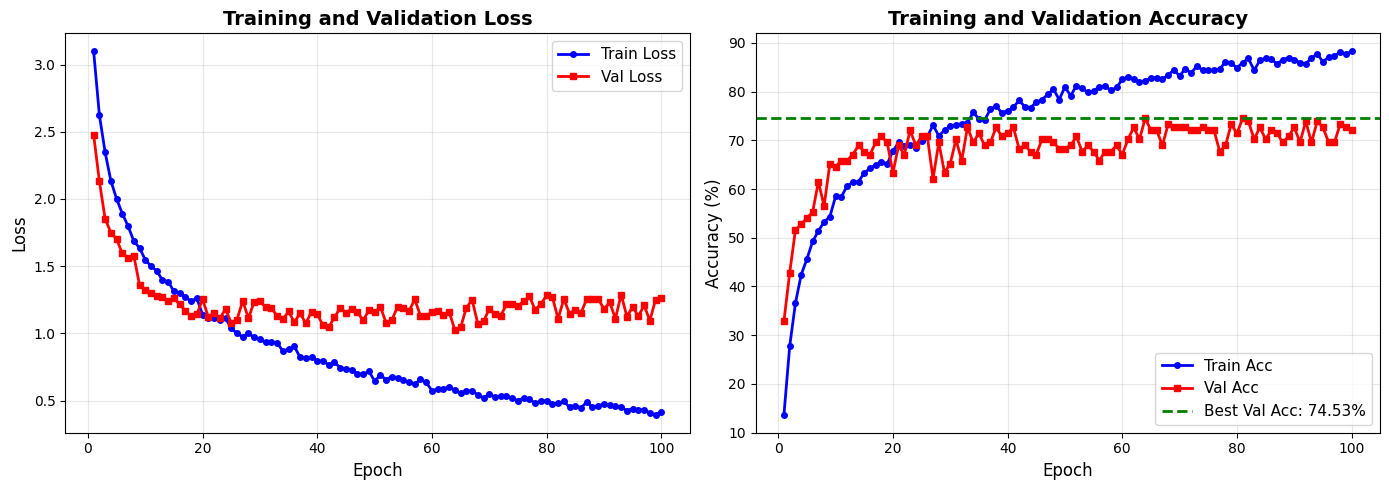

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(device, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, dropout_p=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)



trainer = Trainer(
    model=model,
    criterion=criterion,
    tr_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epoch=NUM_EPOCHS,
    patience=PATIENCE,
    batch_size=32,
    device=device
)


history = trainer.train_all_epochs()

test_loss, test_acc = trainer.test_model(test_loader)

trainer.plot_metrics()


### Part 2.2: AlexNet as a Fixed Feature Extractor
Extract the values of the activations of AlexNet on the face images. Use those as features in order to perform face classification: learn a fully-connected neural network that takes in the activations of the units in the AlexNet layer as inputs, and outputs the name of the person. Below, include a description of the system you built and its performance. It is recommended to start out with only using the `conv4` activations. Using `conv4` is sufficient here.

**Pre-proccesing**

* I first converted the images to RGB and resized the images to 224x224.

* I applied ImageNet normalization, finally froze the layers of AlexNet after Conv4

**AlexNet Architecture**

* After the pre-trained ALexNet model, I trained my own task classifier which had relu activation function and dropout with dropout rate of 0.5. 

* I used Adam optimizer with learning rate = 1e-4 without weight decay.

* I initialized the weights of the fully-connected layers using Xavier Uniform initialization:

**Results**

* Best training accuracy: 95.25%

* Best validation accuracy: 88.82%   

* Test Loss: 0.4134, Test Acc: 87.50%

**Summary**

* Since we used a pretrained AlexNet model, compared to the MLP I trained with limited data it give a good boost to both validation and test accuracies as they are increased approximately 10 percent. Structures that are the most influential for network to classify the images are captured with the help of con4 layer. 

* Initialization of the weights kept the gradient more stable. Prevented the activions from exploading/vanishing.



In [34]:
import torchvision.models as models
import torch.nn as nn
import torch

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, device, hidden_size, output_size):
        super().__init__()
        self.device = device

        alexnet = models.alexnet(pretrained=True)

        self.feature_extractor = nn.Sequential(*list(alexnet.features.children())[:10])

        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        

        self.fc1 = nn.Linear(256 * 13 * 13, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, output_size)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [1]:
def load_cropped_data_alexnet(path="/Users/ozanozak/Desktop/facescrub_cropped", n_train = 70, image_size = 224):

    train_data, train_labels = [], []
    val_data, val_labels = [], []
    test_data, test_labels = [], []
    
    np.random.seed(42)

    classes = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(path, class_name)
        images = [
            os.path.join(class_folder, f)
            for f in os.listdir(class_folder)
            if f.lower().endswith((".jpg", ".png"))
        ]


        np.random.shuffle(images)

        train_files = images[:n_train]
        remaining = (len(images) - n_train) // 2
        val_files = images[n_train:remaining+n_train]
        test_files = images[remaining+n_train:]

        for file in train_files:
            img = Image.open(file).convert("RGB")
            img = img.resize((image_size, image_size))
            train_data.append(np.array(img))
            train_labels.append(class_idx)

        for file in val_files:
            img = Image.open(file).convert("RGB")
            img = img.resize((image_size, image_size))
            val_data.append(np.array(img))
            val_labels.append(class_idx)

        for file in test_files:
            img = Image.open(file).convert("RGB")
            img = img.resize((image_size, image_size))
            test_data.append(np.array(img))
            test_labels.append(class_idx)

    print(f"Training samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")
    print(f"Test samples: {len(test_data)}")

    data_dict = {
        "train_data": np.array(train_data),
        "val_data": np.array(val_data),
        "test_data": np.array(test_data),
    }

    label_dict = {
        "train_labels": np.array(train_labels),
        "val_labels": np.array(val_labels),
        "test_labels": np.array(test_labels),
    }


    return data_dict, label_dict


In [98]:
data, labels = load_cropped_data_alexnet()

print("Train data:", data["train_data"].shape)
print("Train labels:", labels["train_labels"].shape)
print("Val data:", data["val_data"].shape)
print("Test data:", data["test_data"].shape)

Training samples: 1812
Validation samples: 161
Test samples: 168
Train data: (1812, 224, 224, 3)
Train labels: (1812,)
Val data: (161, 224, 224, 3)
Test data: (168, 224, 224, 3)


In [99]:
LR = 1e-4
HIDDEN_SIZE = 300
OUTPUT_SIZE = 30 
BATCH_SIZE = 16
NUM_EPOCHS = 20
PATIENCE = -1

In [100]:
transform = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
}
train_dataset = LoaderClass(data["train_data"], labels["train_labels"], transform["train"])
val_dataset   = LoaderClass(data["val_data"],   labels["val_labels"],   transform["val"])
test_dataset  = LoaderClass(data["test_data"],  labels["test_labels"],  transform["test"])


train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)


/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for 20 epochs
Device: cpu
Patience: -1
------------------------------------------------------------

Epoch 1/20


Training:   0%|          | 0/114 [00:00<?, ?it/s]/Users/ozanozak/Desktop/assignment_2_541/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 3.7042, Train Accuracy: 13.74%
Val Loss: 2.3876, Val Accuracy: 34.78%
New best validation accuracy: 34.78%

Epoch 2/20


Train Loss: 2.2868, Train Accuracy: 35.54%
Val Loss: 1.7758, Val Accuracy: 49.69%
New best validation accuracy: 49.69%

Epoch 3/20


Train Loss: 1.6185, Train Accuracy: 51.93%
Val Loss: 1.1750, Val Accuracy: 71.43%
New best validation accuracy: 71.43%

Epoch 4/20


Train Loss: 1.0439, Train Accuracy: 67.60%
Val Loss: 0.9067, Val Accuracy: 75.16%
New best validation accuracy: 75.16%

Epoch 5/20


Train Loss: 0.8319, Train Accuracy: 74.72%
Val Loss: 0.7371, Val Accuracy: 84.47%
New best validation accuracy: 84.47%

Epoch 6/20


Train Loss: 0.5879, Train Accuracy: 82.40%
Val Loss: 0.6279, Val Accuracy: 86.34%
New best validation accuracy: 86.34%

Epoch 7/20


Train Loss: 0.4353, Train Accuracy: 87.09%
Val Loss: 0.6549, Val Accuracy: 85.09%
No improvement (1/-1)

Epoch 8/20


Train Loss: 0.3943, Train Accuracy: 87.25%
Val Loss: 0.6799, Val Accuracy: 82.61%
No improvement (2/-1)

Epoch 9/20


Train Loss: 0.3302, Train Accuracy: 89.62%
Val Loss: 0.6941, Val Accuracy: 81.37%
No improvement (3/-1)

Epoch 10/20


Train Loss: 0.2393, Train Accuracy: 92.99%
Val Loss: 0.6100, Val Accuracy: 86.96%
New best validation accuracy: 86.96%

Epoch 11/20


Train Loss: 0.2744, Train Accuracy: 91.56%
Val Loss: 0.6620, Val Accuracy: 83.85%
No improvement (1/-1)

Epoch 12/20


Train Loss: 0.2015, Train Accuracy: 93.98%
Val Loss: 0.6676, Val Accuracy: 86.96%
No improvement (2/-1)

Epoch 13/20


Train Loss: 0.1394, Train Accuracy: 96.03%
Val Loss: 0.5444, Val Accuracy: 88.20%
New best validation accuracy: 88.20%

Epoch 14/20


Train Loss: 0.1573, Train Accuracy: 94.87%
Val Loss: 0.6145, Val Accuracy: 86.96%
No improvement (1/-1)

Epoch 15/20


Train Loss: 0.1496, Train Accuracy: 95.92%
Val Loss: 0.5883, Val Accuracy: 86.34%
No improvement (2/-1)

Epoch 16/20


Train Loss: 0.1563, Train Accuracy: 95.20%
Val Loss: 0.6036, Val Accuracy: 85.09%
No improvement (3/-1)

Epoch 17/20


Train Loss: 0.1379, Train Accuracy: 95.31%
Val Loss: 0.5866, Val Accuracy: 87.58%
No improvement (4/-1)

Epoch 18/20


Train Loss: 0.1321, Train Accuracy: 96.03%
Val Loss: 0.5810, Val Accuracy: 87.58%
No improvement (5/-1)

Epoch 19/20


Train Loss: 0.1264, Train Accuracy: 95.86%
Val Loss: 0.6661, Val Accuracy: 86.34%
No improvement (6/-1)

Epoch 20/20


Train Loss: 0.1401, Train Accuracy: 95.25%
Val Loss: 0.6203, Val Accuracy: 88.82%
New best validation accuracy: 88.82%

Loaded best model from training
Best validation accuracy: 88.82%
Best validation loss: 0.6203
Best training accuracy: 95.25%
Best training loss: 0.1401

Starting on test set :)))))


Test Loss: 0.4134, Test Acc: 87.50%


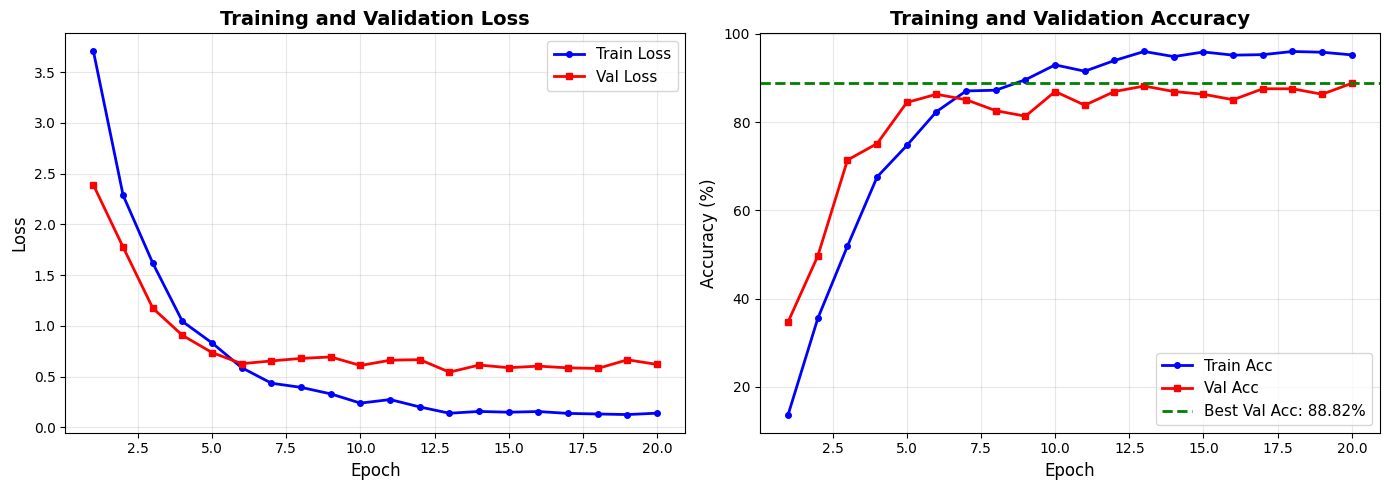

In [ ]:
model = AlexNet(device=device, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

trainer = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, device=device)
history = trainer.train_all_epochs()

test_loss, test_acc = trainer.test_model(test_loader)

trainer.plot_metrics()


### Part 2.3: Visualize Weights
Train two networks the way you did in Part 2.1. Use 300 and 800 hidden units in the hidden layer. Visualize 2 different hidden features (neurons) for each of the two settings, and briefly explain why they are interesting. A sample visualization of a hidden feature is shown below. Note that you probably need to use L2 regularization while training to obtain nice weight visualizations.

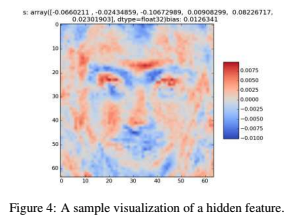

**Pre-process and MLP**

* I used the 28x28 grayscale images. I used random horizontal flipping.

* I trained two single hidden layer MLPs (300 and 800 units)

**Results**

* I obtanined approximately 70% test accuracy for both MLPs.

* Neurons at MLP with 300 units tend to learn more coarse features. Because the hidden layer is smaller compared to the other MLP (with 800 hidden units), neurons might tend to capture more general template with less details.

* Visualizations from MLP with 800 units tend to be sharper. Since the model has more hidden units it captures more high level features.

* What I found interesting is even though I tried the visualize images using a MLP, the visualizations are recognizable face shapes.

* L2 regularization helped to prevent noisy weights in order to get a better, smoother visualization.

* Additionally, I also wanted to visualize the iamges with size 224x224x3. The results I got was much more interpretable, clearer. Face structure of the images can be seen better compared to grayscale inputs. This might be because RGB images provide more information about the images such as color and more detailed texture cues. This helps neurons to learn more structured and meaningful features. Since neurons learn more structured features the visualization of faces are more clearer.

In [70]:
class MLP(nn.Module):
    def __init__(self, device, input_size, hidden_size, output_size, p_dropout = 0.1):
        super(MLP, self).__init__()
        self.device = device

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p_dropout)

        self.fc2 = nn.Linear(hidden_size, output_size)
    

    def forward(self,x):
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [71]:
import os
import numpy as np
from PIL import Image

def load_cropped_data(path="/Users/ozanozak/Desktop/facescrub_cropped", image_size=28):
    all_images = {}

    actor_folders = sorted([
        f for f in os.listdir(path) 
        if os.path.isdir(os.path.join(path, f))
    ])

    print(f"Found {len(actor_folders)} actors")

    for actor_name in actor_folders:
        
        actor_path = os.path.join(path, actor_name)
        
        if not os.path.isdir(actor_path):
            print(f"Skipping non-directory: {actor_path}")
            continue


        image_files = sorted([
            f for f in os.listdir(actor_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        images = []
        
        for img_file in image_files:
                img_path = os.path.join(actor_path, img_file)
                
                try:
                    # Load image
                    img = Image.open(img_path).convert("L")
                    
                   
                    img = img.resize((image_size, image_size))
                    
                    # Convert to numpy array
                    arr = np.array(img)
                    
           
                    images.append(arr)
                    
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue
    
        all_images[actor_name] = images
    print(f"\nTotal people loaded: {len(all_images)}")

    return all_images
    

In [73]:
splits = split_data(all_images) 

transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

train_dataset = LoaderClass(
    splits["train_data"], 
    splits["train_labels"], 
    transform["train"]
)

val_dataset = LoaderClass(
    splits["val_data"], 
    splits["val_labels"], 
    transform["val"]
)

test_dataset = LoaderClass(
    splits["test_data"], 
    splits["test_labels"], 
    transform["test"]
)

BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)


Target classes: {'Andy_Richter': 0, 'Angie_Harmon': 1, 'Carmen_Electra': 2, 'Cary_Elwes': 3, 'Chris_Klein': 4, 'Chris_Noth': 5, 'Dana_Delany': 6, 'Daniel_Radcliffe': 7, 'Didi_Conn': 8, 'Dina_Meyer': 9, 'Gary_Dourdan': 10, 'Gerard_Butler': 11, 'Holly_Marie_Combs': 12, 'Jason_Statham': 13, 'Julia_Louis-Dreyfus': 14, 'Kerr_Smith': 15, 'Kim_Cattrall': 16, 'Laura_Innes': 17, 'Leonardo_DiCaprio': 18, 'Lindsay_Hartley': 19, 'Loni_Anderson': 20, 'Lorraine_Bracco': 21, 'Matt_Long': 22, 'Matthew_Gray_Gubler': 23, 'Michael_Vartan': 24, 'Paul_Walker': 25, 'Peri_Gilpin': 26, 'Richard_Madden': 27, 'Teri_Hatcher': 28, 'Vanessa_Marcil': 29}

Dataset split:
Train: 1812 images
Val: 161 images
Test: 168 images


In [74]:
LR = 5e-4
INPUT_SIZE = 28 * 28
OUTPUT_SIZE = 30
HIDDEN_SIZES = [300, 800]
BATCH_SIZE = 16
NUM_EPOCHS = 50
PATIENCE = -1

In [75]:
models = []
histories = []

for hidden_size in HIDDEN_SIZES:
    print("\n" + "="*60)
    print(f"Training MLP with {hidden_size} hidden units")
    print("="*60)

    model = MLP(device, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, p_dropout=0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-2)



    trainer = Trainer(
        model=model,
        criterion=criterion,
        tr_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epoch=NUM_EPOCHS,
        patience=PATIENCE,
        batch_size=32,
        device=device
    )

    history = trainer.train_all_epochs() 
    test_loss, test_acc = trainer.test_model(test_loader)
    models.append(model)
    histories.append(history)
    



Training MLP with 300 hidden units
Training for 50 epochs
Device: cpu
Patience: -1
------------------------------------------------------------

Epoch 1/50


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Train Loss: 3.1902, Train Accuracy: 10.82%
Val Loss: 2.7479, Val Accuracy: 27.33%
New best validation accuracy: 27.33%

Epoch 2/50


Train Loss: 2.7733, Train Accuracy: 21.30%
Val Loss: 2.3738, Val Accuracy: 42.86%
New best validation accuracy: 42.86%

Epoch 3/50


Train Loss: 2.5067, Train Accuracy: 30.35%
Val Loss: 2.2775, Val Accuracy: 33.54%
No improvement (1/-1)

Epoch 4/50


Train Loss: 2.3177, Train Accuracy: 35.82%
Val Loss: 2.0595, Val Accuracy: 45.34%
New best validation accuracy: 45.34%

Epoch 5/50


Train Loss: 2.1722, Train Accuracy: 40.51%
Val Loss: 1.9010, Val Accuracy: 50.31%
New best validation accuracy: 50.31%

Epoch 6/50


Train Loss: 2.0596, Train Accuracy: 43.21%
Val Loss: 1.9352, Val Accuracy: 44.10%
No improvement (1/-1)

Epoch 7/50


Train Loss: 1.9647, Train Accuracy: 46.52%
Val Loss: 1.8566, Val Accuracy: 46.58%
No improvement (2/-1)

Epoch 8/50


Train Loss: 1.8943, Train Accuracy: 49.78%
Val Loss: 1.9399, Val Accuracy: 44.72%
No improvement (3/-1)

Epoch 9/50


Train Loss: 1.8446, Train Accuracy: 49.89%
Val Loss: 1.7845, Val Accuracy: 51.55%
New best validation accuracy: 51.55%

Epoch 10/50


Train Loss: 1.7942, Train Accuracy: 52.48%
Val Loss: 1.7285, Val Accuracy: 60.25%
New best validation accuracy: 60.25%

Epoch 11/50


Train Loss: 1.7440, Train Accuracy: 53.15%
Val Loss: 1.7347, Val Accuracy: 50.31%
No improvement (1/-1)

Epoch 12/50


Train Loss: 1.7054, Train Accuracy: 54.36%
Val Loss: 1.7610, Val Accuracy: 53.42%
No improvement (2/-1)

Epoch 13/50


Train Loss: 1.6835, Train Accuracy: 54.86%
Val Loss: 1.7419, Val Accuracy: 47.83%
No improvement (3/-1)

Epoch 14/50


Train Loss: 1.6444, Train Accuracy: 56.95%
Val Loss: 1.7080, Val Accuracy: 55.28%
No improvement (4/-1)

Epoch 15/50


Train Loss: 1.6233, Train Accuracy: 56.35%
Val Loss: 1.5965, Val Accuracy: 57.14%
No improvement (5/-1)

Epoch 16/50


Train Loss: 1.5916, Train Accuracy: 57.34%
Val Loss: 1.6868, Val Accuracy: 53.42%
No improvement (6/-1)

Epoch 17/50


Train Loss: 1.5829, Train Accuracy: 59.05%
Val Loss: 1.6567, Val Accuracy: 55.28%
No improvement (7/-1)

Epoch 18/50


Train Loss: 1.5568, Train Accuracy: 58.77%
Val Loss: 1.5157, Val Accuracy: 56.52%
No improvement (8/-1)

Epoch 19/50


Train Loss: 1.5444, Train Accuracy: 59.27%
Val Loss: 1.6206, Val Accuracy: 55.90%
No improvement (9/-1)

Epoch 20/50


Train Loss: 1.5230, Train Accuracy: 59.55%
Val Loss: 1.4986, Val Accuracy: 59.63%
No improvement (10/-1)

Epoch 21/50


Train Loss: 1.4803, Train Accuracy: 61.64%
Val Loss: 1.5097, Val Accuracy: 59.01%
No improvement (11/-1)

Epoch 22/50


Train Loss: 1.4815, Train Accuracy: 61.15%
Val Loss: 1.5336, Val Accuracy: 57.76%
No improvement (12/-1)

Epoch 23/50


Train Loss: 1.5019, Train Accuracy: 59.22%
Val Loss: 1.6999, Val Accuracy: 47.20%
No improvement (13/-1)

Epoch 24/50


Train Loss: 1.4517, Train Accuracy: 61.75%
Val Loss: 1.5520, Val Accuracy: 52.80%
No improvement (14/-1)

Epoch 25/50


Train Loss: 1.4242, Train Accuracy: 62.36%
Val Loss: 1.4479, Val Accuracy: 62.11%
New best validation accuracy: 62.11%

Epoch 26/50


Train Loss: 1.4159, Train Accuracy: 63.30%
Val Loss: 1.5536, Val Accuracy: 56.52%
No improvement (1/-1)

Epoch 27/50


Train Loss: 1.4023, Train Accuracy: 62.97%
Val Loss: 1.4129, Val Accuracy: 60.25%
No improvement (2/-1)

Epoch 28/50


Train Loss: 1.3984, Train Accuracy: 63.30%
Val Loss: 1.5383, Val Accuracy: 57.14%
No improvement (3/-1)

Epoch 29/50


Train Loss: 1.3995, Train Accuracy: 63.36%
Val Loss: 1.4519, Val Accuracy: 57.76%
No improvement (4/-1)

Epoch 30/50


Train Loss: 1.3781, Train Accuracy: 63.36%
Val Loss: 1.5052, Val Accuracy: 59.63%
No improvement (5/-1)

Epoch 31/50


Train Loss: 1.3541, Train Accuracy: 65.78%
Val Loss: 1.4019, Val Accuracy: 63.98%
New best validation accuracy: 63.98%

Epoch 32/50


Train Loss: 1.3470, Train Accuracy: 64.90%
Val Loss: 1.5460, Val Accuracy: 54.04%
No improvement (1/-1)

Epoch 33/50


Train Loss: 1.3632, Train Accuracy: 65.23%
Val Loss: 1.5432, Val Accuracy: 54.04%
No improvement (2/-1)

Epoch 34/50


Train Loss: 1.3394, Train Accuracy: 65.18%
Val Loss: 1.4181, Val Accuracy: 58.39%
No improvement (3/-1)

Epoch 35/50


Train Loss: 1.3240, Train Accuracy: 66.00%
Val Loss: 1.5204, Val Accuracy: 58.39%
No improvement (4/-1)

Epoch 36/50


Train Loss: 1.3308, Train Accuracy: 65.84%
Val Loss: 1.4740, Val Accuracy: 60.87%
No improvement (5/-1)

Epoch 37/50


Train Loss: 1.3049, Train Accuracy: 67.55%
Val Loss: 1.4443, Val Accuracy: 63.35%
No improvement (6/-1)

Epoch 38/50


Train Loss: 1.3078, Train Accuracy: 66.72%
Val Loss: 1.4674, Val Accuracy: 59.01%
No improvement (7/-1)

Epoch 39/50


Train Loss: 1.3168, Train Accuracy: 65.95%
Val Loss: 1.4580, Val Accuracy: 60.25%
No improvement (8/-1)

Epoch 40/50


Train Loss: 1.3016, Train Accuracy: 66.94%
Val Loss: 1.5388, Val Accuracy: 57.76%
No improvement (9/-1)

Epoch 41/50


Train Loss: 1.2868, Train Accuracy: 67.27%
Val Loss: 1.4474, Val Accuracy: 63.35%
No improvement (10/-1)

Epoch 42/50


Train Loss: 1.2788, Train Accuracy: 66.17%
Val Loss: 1.4225, Val Accuracy: 59.01%
No improvement (11/-1)

Epoch 43/50


Train Loss: 1.2815, Train Accuracy: 67.00%
Val Loss: 1.4355, Val Accuracy: 61.49%
No improvement (12/-1)

Epoch 44/50


Train Loss: 1.2760, Train Accuracy: 66.83%
Val Loss: 1.6401, Val Accuracy: 55.28%
No improvement (13/-1)

Epoch 45/50


Train Loss: 1.2615, Train Accuracy: 67.16%
Val Loss: 1.3924, Val Accuracy: 60.87%
No improvement (14/-1)

Epoch 46/50


Train Loss: 1.2667, Train Accuracy: 68.05%
Val Loss: 1.3558, Val Accuracy: 64.60%
New best validation accuracy: 64.60%

Epoch 47/50


Train Loss: 1.2597, Train Accuracy: 68.43%
Val Loss: 1.3505, Val Accuracy: 63.35%
No improvement (1/-1)

Epoch 48/50


Train Loss: 1.2636, Train Accuracy: 66.67%
Val Loss: 1.5409, Val Accuracy: 55.28%
No improvement (2/-1)

Epoch 49/50


Train Loss: 1.2586, Train Accuracy: 67.00%
Val Loss: 1.5028, Val Accuracy: 57.14%
No improvement (3/-1)

Epoch 50/50


Train Loss: 1.2495, Train Accuracy: 68.65%
Val Loss: 1.4481, Val Accuracy: 59.01%
No improvement (4/-1)

Loaded best model from training
Best validation accuracy: 64.60%
Best validation loss: 1.3558
Best training accuracy: 68.05%
Best training loss: 1.2667

Starting on test set :)))))


Test Loss: 1.5052, Test Acc: 67.86%

Training MLP with 800 hidden units
Training for 50 epochs
Device: cpu
Patience: -1
------------------------------------------------------------

Epoch 1/50


Train Loss: 3.1789, Train Accuracy: 10.71%
Val Loss: 2.7031, Val Accuracy: 29.81%
New best validation accuracy: 29.81%

Epoch 2/50


Train Loss: 2.7707, Train Accuracy: 21.85%
Val Loss: 2.4446, Val Accuracy: 32.92%
New best validation accuracy: 32.92%

Epoch 3/50


Train Loss: 2.5055, Train Accuracy: 32.12%
Val Loss: 2.2557, Val Accuracy: 39.75%
New best validation accuracy: 39.75%

Epoch 4/50


Train Loss: 2.3217, Train Accuracy: 36.15%
Val Loss: 2.1255, Val Accuracy: 42.24%
New best validation accuracy: 42.24%

Epoch 5/50


Train Loss: 2.1690, Train Accuracy: 40.07%
Val Loss: 2.0112, Val Accuracy: 42.86%
New best validation accuracy: 42.86%

Epoch 6/50


Train Loss: 2.0530, Train Accuracy: 44.21%
Val Loss: 1.8957, Val Accuracy: 51.55%
New best validation accuracy: 51.55%

Epoch 7/50


Train Loss: 1.9613, Train Accuracy: 46.69%
Val Loss: 1.9068, Val Accuracy: 45.96%
No improvement (1/-1)

Epoch 8/50


Train Loss: 1.8935, Train Accuracy: 50.06%
Val Loss: 1.8694, Val Accuracy: 44.10%
No improvement (2/-1)

Epoch 9/50


Train Loss: 1.8396, Train Accuracy: 49.83%
Val Loss: 1.8223, Val Accuracy: 49.07%
No improvement (3/-1)

Epoch 10/50


Train Loss: 1.7925, Train Accuracy: 52.15%
Val Loss: 1.8225, Val Accuracy: 49.69%
No improvement (4/-1)

Epoch 11/50


Train Loss: 1.7560, Train Accuracy: 52.65%
Val Loss: 1.7664, Val Accuracy: 47.83%
No improvement (5/-1)

Epoch 12/50


Train Loss: 1.7056, Train Accuracy: 54.42%
Val Loss: 1.6442, Val Accuracy: 57.14%
New best validation accuracy: 57.14%

Epoch 13/50


Train Loss: 1.6704, Train Accuracy: 55.52%
Val Loss: 1.6871, Val Accuracy: 52.17%
No improvement (1/-1)

Epoch 14/50


Train Loss: 1.6386, Train Accuracy: 56.62%
Val Loss: 1.8476, Val Accuracy: 43.48%
No improvement (2/-1)

Epoch 15/50


Train Loss: 1.6152, Train Accuracy: 58.11%
Val Loss: 1.6829, Val Accuracy: 49.69%
No improvement (3/-1)

Epoch 16/50


Train Loss: 1.6050, Train Accuracy: 56.51%
Val Loss: 1.6502, Val Accuracy: 48.45%
No improvement (4/-1)

Epoch 17/50


Train Loss: 1.5728, Train Accuracy: 58.77%
Val Loss: 1.6077, Val Accuracy: 52.80%
No improvement (5/-1)

Epoch 18/50


Train Loss: 1.5598, Train Accuracy: 59.38%
Val Loss: 1.5869, Val Accuracy: 57.76%
New best validation accuracy: 57.76%

Epoch 19/50


Train Loss: 1.5252, Train Accuracy: 59.05%
Val Loss: 1.5644, Val Accuracy: 61.49%
New best validation accuracy: 61.49%

Epoch 20/50


Train Loss: 1.4989, Train Accuracy: 62.31%
Val Loss: 1.5390, Val Accuracy: 55.90%
No improvement (1/-1)

Epoch 21/50


Train Loss: 1.5038, Train Accuracy: 60.71%
Val Loss: 1.5866, Val Accuracy: 58.39%
No improvement (2/-1)

Epoch 22/50


Train Loss: 1.4803, Train Accuracy: 61.09%
Val Loss: 1.6221, Val Accuracy: 57.14%
No improvement (3/-1)

Epoch 23/50


Train Loss: 1.4625, Train Accuracy: 61.20%
Val Loss: 1.4868, Val Accuracy: 57.14%
No improvement (4/-1)

Epoch 24/50


Train Loss: 1.4422, Train Accuracy: 61.87%
Val Loss: 1.5693, Val Accuracy: 57.14%
No improvement (5/-1)

Epoch 25/50


Train Loss: 1.4432, Train Accuracy: 62.36%
Val Loss: 1.6184, Val Accuracy: 56.52%
No improvement (6/-1)

Epoch 26/50


Train Loss: 1.4155, Train Accuracy: 62.53%
Val Loss: 1.5784, Val Accuracy: 57.14%
No improvement (7/-1)

Epoch 27/50


Train Loss: 1.4061, Train Accuracy: 63.47%
Val Loss: 1.4859, Val Accuracy: 55.90%
No improvement (8/-1)

Epoch 28/50


Train Loss: 1.3997, Train Accuracy: 63.25%
Val Loss: 1.6204, Val Accuracy: 50.93%
No improvement (9/-1)

Epoch 29/50


Train Loss: 1.3872, Train Accuracy: 63.96%
Val Loss: 1.4884, Val Accuracy: 57.14%
No improvement (10/-1)

Epoch 30/50


Train Loss: 1.3633, Train Accuracy: 64.62%
Val Loss: 1.5546, Val Accuracy: 57.14%
No improvement (11/-1)

Epoch 31/50


Train Loss: 1.3647, Train Accuracy: 64.96%
Val Loss: 1.4955, Val Accuracy: 59.63%
No improvement (12/-1)

Epoch 32/50


Train Loss: 1.3514, Train Accuracy: 65.07%
Val Loss: 1.5907, Val Accuracy: 57.14%
No improvement (13/-1)

Epoch 33/50


Train Loss: 1.3371, Train Accuracy: 65.34%
Val Loss: 1.5293, Val Accuracy: 58.39%
No improvement (14/-1)

Epoch 34/50


Train Loss: 1.3288, Train Accuracy: 65.89%
Val Loss: 1.5261, Val Accuracy: 56.52%
No improvement (15/-1)

Epoch 35/50


Train Loss: 1.3133, Train Accuracy: 67.49%
Val Loss: 1.5040, Val Accuracy: 60.25%
No improvement (16/-1)

Epoch 36/50


Train Loss: 1.3089, Train Accuracy: 66.00%
Val Loss: 1.5296, Val Accuracy: 55.28%
No improvement (17/-1)

Epoch 37/50


Train Loss: 1.3099, Train Accuracy: 66.11%
Val Loss: 1.5438, Val Accuracy: 56.52%
No improvement (18/-1)

Epoch 38/50


Train Loss: 1.3122, Train Accuracy: 65.62%
Val Loss: 1.4979, Val Accuracy: 60.25%
No improvement (19/-1)

Epoch 39/50


Train Loss: 1.2911, Train Accuracy: 67.88%
Val Loss: 1.4526, Val Accuracy: 57.76%
No improvement (20/-1)

Epoch 40/50


Train Loss: 1.3020, Train Accuracy: 66.50%
Val Loss: 1.3882, Val Accuracy: 63.35%
New best validation accuracy: 63.35%

Epoch 41/50


Train Loss: 1.2928, Train Accuracy: 66.50%
Val Loss: 1.4141, Val Accuracy: 60.87%
No improvement (1/-1)

Epoch 42/50


Train Loss: 1.2769, Train Accuracy: 67.38%
Val Loss: 1.4515, Val Accuracy: 62.73%
No improvement (2/-1)

Epoch 43/50


Train Loss: 1.2782, Train Accuracy: 67.05%
Val Loss: 1.4839, Val Accuracy: 60.87%
No improvement (3/-1)

Epoch 44/50


Train Loss: 1.2577, Train Accuracy: 67.60%
Val Loss: 1.4263, Val Accuracy: 61.49%
No improvement (4/-1)

Epoch 45/50


Train Loss: 1.2656, Train Accuracy: 66.45%
Val Loss: 1.4970, Val Accuracy: 62.11%
No improvement (5/-1)

Epoch 46/50


Train Loss: 1.2533, Train Accuracy: 69.54%
Val Loss: 1.4681, Val Accuracy: 60.87%
No improvement (6/-1)

Epoch 47/50


Train Loss: 1.2380, Train Accuracy: 68.60%
Val Loss: 1.5514, Val Accuracy: 57.76%
No improvement (7/-1)

Epoch 48/50


Train Loss: 1.2561, Train Accuracy: 69.43%
Val Loss: 1.4901, Val Accuracy: 60.25%
No improvement (8/-1)

Epoch 49/50


Train Loss: 1.2205, Train Accuracy: 70.14%
Val Loss: 1.4951, Val Accuracy: 59.63%
No improvement (9/-1)

Epoch 50/50


Train Loss: 1.2461, Train Accuracy: 67.94%
Val Loss: 1.4699, Val Accuracy: 58.39%
No improvement (10/-1)

Loaded best model from training
Best validation accuracy: 63.35%
Best validation loss: 1.3882
Best training accuracy: 66.50%
Best training loss: 1.3020

Starting on test set :)))))


Test Loss: 1.5274, Test Acc: 70.24%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_weights(model, num_neurons=2):
    weights = model.fc1.weight.data.cpu().numpy()
    selected = np.random.choice(weights.shape[0], num_neurons, replace=False)

    height = width = int(np.sqrt(weights.shape[1])) 

    fig, axes = plt.subplots(1, num_neurons, figsize=(4*num_neurons, 4))

    for i, neuron in enumerate(selected):
        w = weights[neuron].reshape(height, width)

        axes[i].imshow(w, cmap="viridis")
        axes[i].set_title(f"Neuron {neuron}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

300 Hidden Units


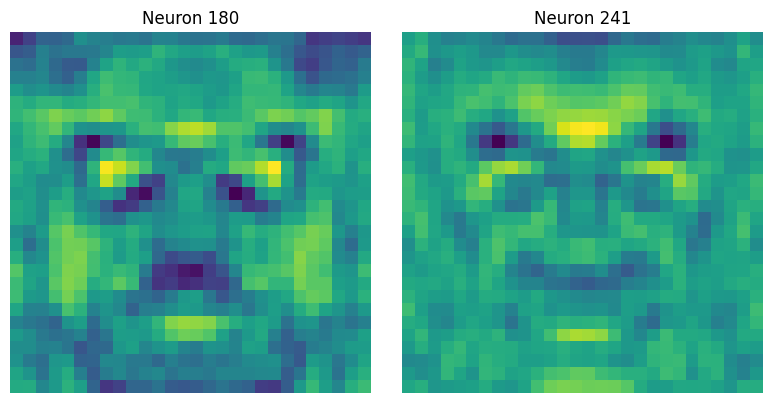

800 Hidden Units


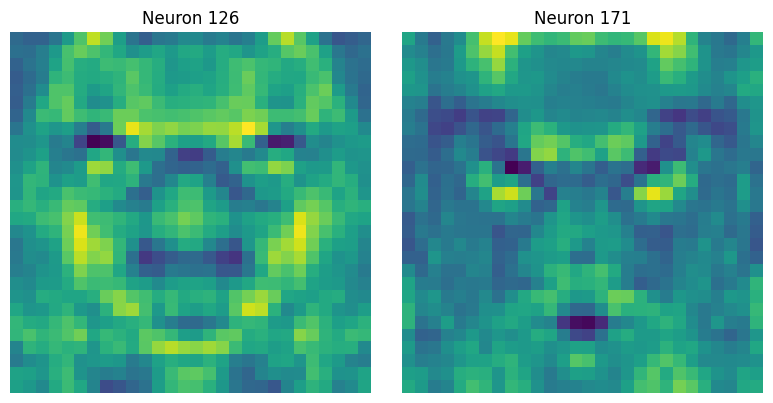

In [444]:
for i, model in enumerate(models):
    print(f"{HIDDEN_SIZES[i]} Hidden Units")
    visualize_weights(model)

In [411]:
LR = 1e-4
INPUT_SIZE = 224 * 224 * 3
OUTPUT_SIZE = 30
HIDDEN_SIZES = [300, 800]
BATCH_SIZE = 16
NUM_EPOCHS = 50
PATIENCE = 5

In [412]:
data, labels = load_cropped_data_alexnet()

print("Train data:", data["train_data"].shape)
print("Train labels:", labels["train_labels"].shape)
print("Val data:", data["val_data"].shape)
print("Test data:", data["test_data"].shape)

Training samples: 1812
Validation samples: 161
Test samples: 168
Train data: (1812, 224, 224, 3)
Train labels: (1812,)
Val data: (161, 224, 224, 3)
Test data: (168, 224, 224, 3)


In [413]:
transform = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
}
train_dataset = LoaderClass(data["train_data"], labels["train_labels"], transform["train"])
val_dataset   = LoaderClass(data["val_data"],   labels["val_labels"],   transform["val"])
test_dataset  = LoaderClass(data["test_data"],  labels["test_labels"],  transform["test"])


train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)


In [414]:
models = []
histories = []

for hidden_size in HIDDEN_SIZES:
    print("\n" + "="*60)
    print(f"Training MLP with {hidden_size} hidden units")
    print("="*60)

    model = MLP(device, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, p_dropout=0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-2)



    trainer = Trainer(
        model=model,
        criterion=criterion,
        tr_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epoch=NUM_EPOCHS,
        patience=PATIENCE,
        batch_size=32,
        device=device
    )

    history = trainer.train_all_epochs() 
    models.append(model)
    histories.append(history)

    



Training MLP with 300 hidden units
Training for 50 epochs
Device: cpu
Patience: 5
------------------------------------------------------------

Epoch 1/50


Train Loss: 5.3656, Train Accuracy: 11.31%
Val Loss: 3.7935, Val Accuracy: 18.63%
New best validation accuracy: 18.63%

Epoch 2/50


Train Loss: 3.6530, Train Accuracy: 23.18%
Val Loss: 4.0686, Val Accuracy: 25.47%
New best validation accuracy: 25.47%

Epoch 3/50


Train Loss: 3.2930, Train Accuracy: 31.40%
Val Loss: 3.3951, Val Accuracy: 41.61%
New best validation accuracy: 41.61%

Epoch 4/50


Train Loss: 2.3597, Train Accuracy: 43.76%
Val Loss: 3.9923, Val Accuracy: 39.75%
No improvement (1/5)

Epoch 5/50


Train Loss: 2.4902, Train Accuracy: 47.63%
Val Loss: 4.2294, Val Accuracy: 39.13%
No improvement (2/5)

Epoch 6/50


Train Loss: 1.7122, Train Accuracy: 55.24%
Val Loss: 3.9640, Val Accuracy: 46.58%
New best validation accuracy: 46.58%

Epoch 7/50


Train Loss: 2.1315, Train Accuracy: 55.19%
Val Loss: 3.9170, Val Accuracy: 45.96%
No improvement (1/5)

Epoch 8/50


Train Loss: 1.6351, Train Accuracy: 61.37%
Val Loss: 3.5783, Val Accuracy: 49.07%
New best validation accuracy: 49.07%

Epoch 9/50


Train Loss: 1.5431, Train Accuracy: 69.54%
Val Loss: 3.8921, Val Accuracy: 47.20%
No improvement (1/5)

Epoch 10/50


Train Loss: 1.6025, Train Accuracy: 66.00%
Val Loss: 3.8972, Val Accuracy: 50.93%
New best validation accuracy: 50.93%

Epoch 11/50


Train Loss: 1.2606, Train Accuracy: 73.12%
Val Loss: 3.3853, Val Accuracy: 51.55%
New best validation accuracy: 51.55%

Epoch 12/50


Train Loss: 1.2916, Train Accuracy: 74.17%
Val Loss: 3.7542, Val Accuracy: 47.83%
No improvement (1/5)

Epoch 13/50


Train Loss: 1.1447, Train Accuracy: 75.11%
Val Loss: 3.5276, Val Accuracy: 49.69%
No improvement (2/5)

Epoch 14/50


Train Loss: 0.9801, Train Accuracy: 78.70%
Val Loss: 4.7095, Val Accuracy: 47.20%
No improvement (3/5)

Epoch 15/50


Train Loss: 1.1646, Train Accuracy: 74.83%
Val Loss: 3.6673, Val Accuracy: 57.76%
New best validation accuracy: 57.76%

Epoch 16/50


Train Loss: 0.9853, Train Accuracy: 81.57%
Val Loss: 3.2667, Val Accuracy: 59.63%
New best validation accuracy: 59.63%

Epoch 17/50


Train Loss: 0.8470, Train Accuracy: 83.55%
Val Loss: 3.5735, Val Accuracy: 52.80%
No improvement (1/5)

Epoch 18/50


Train Loss: 0.8720, Train Accuracy: 81.29%
Val Loss: 4.4028, Val Accuracy: 53.42%
No improvement (2/5)

Epoch 19/50


Train Loss: 1.6765, Train Accuracy: 72.41%
Val Loss: 4.1481, Val Accuracy: 48.45%
No improvement (3/5)

Epoch 20/50


Train Loss: 1.3129, Train Accuracy: 80.35%
Val Loss: 4.0224, Val Accuracy: 54.66%
No improvement (4/5)

Epoch 21/50


Train Loss: 1.0103, Train Accuracy: 81.90%
Val Loss: 3.9168, Val Accuracy: 50.31%
No improvement (5/5)

Early stopping triggered at epoch 21
Best validation accuracy: 59.63%

Loaded best model from training
Best validation accuracy: 59.63%
Best validation loss: 3.2667
Best training accuracy: 81.57%
Best training loss: 0.9853

Training MLP with 800 hidden units
Training for 50 epochs
Device: cpu
Patience: 5
------------------------------------------------------------

Epoch 1/50


Train Loss: 5.4642, Train Accuracy: 11.98%
Val Loss: 4.5486, Val Accuracy: 17.39%
New best validation accuracy: 17.39%

Epoch 2/50


Train Loss: 3.7940, Train Accuracy: 19.48%
Val Loss: 4.1573, Val Accuracy: 29.81%
New best validation accuracy: 29.81%

Epoch 3/50


Train Loss: 3.3283, Train Accuracy: 31.07%
Val Loss: 3.7642, Val Accuracy: 37.27%
New best validation accuracy: 37.27%

Epoch 4/50


Train Loss: 2.6510, Train Accuracy: 42.44%
Val Loss: 3.4935, Val Accuracy: 40.37%
New best validation accuracy: 40.37%

Epoch 5/50


Train Loss: 2.2137, Train Accuracy: 50.28%
Val Loss: 4.2538, Val Accuracy: 44.72%
New best validation accuracy: 44.72%

Epoch 6/50


Train Loss: 2.0372, Train Accuracy: 52.32%
Val Loss: 3.6428, Val Accuracy: 48.45%
New best validation accuracy: 48.45%

Epoch 7/50


Train Loss: 1.9919, Train Accuracy: 58.50%
Val Loss: 4.0699, Val Accuracy: 42.24%
No improvement (1/5)

Epoch 8/50


Train Loss: 1.9072, Train Accuracy: 61.98%
Val Loss: 3.5424, Val Accuracy: 47.83%
No improvement (2/5)

Epoch 9/50


Train Loss: 1.3499, Train Accuracy: 69.21%
Val Loss: 2.8503, Val Accuracy: 56.52%
New best validation accuracy: 56.52%

Epoch 10/50


Train Loss: 1.2616, Train Accuracy: 71.36%
Val Loss: 3.4339, Val Accuracy: 49.07%
No improvement (1/5)

Epoch 11/50


Train Loss: 1.4285, Train Accuracy: 71.52%
Val Loss: 4.0966, Val Accuracy: 50.31%
No improvement (2/5)

Epoch 12/50


Train Loss: 0.9484, Train Accuracy: 76.60%
Val Loss: 3.3597, Val Accuracy: 59.01%
New best validation accuracy: 59.01%

Epoch 13/50


Train Loss: 1.2037, Train Accuracy: 76.16%
Val Loss: 3.9366, Val Accuracy: 55.28%
No improvement (1/5)

Epoch 14/50


Train Loss: 1.2610, Train Accuracy: 76.43%
Val Loss: 4.8241, Val Accuracy: 53.42%
No improvement (2/5)

Epoch 15/50


Train Loss: 1.3922, Train Accuracy: 73.07%
Val Loss: 3.4813, Val Accuracy: 59.63%
New best validation accuracy: 59.63%

Epoch 16/50


Train Loss: 0.9512, Train Accuracy: 82.12%
Val Loss: 4.1370, Val Accuracy: 59.01%
No improvement (1/5)

Epoch 17/50


Train Loss: 0.8495, Train Accuracy: 80.74%
Val Loss: 3.6274, Val Accuracy: 62.73%
New best validation accuracy: 62.73%

Epoch 18/50


Train Loss: 0.7575, Train Accuracy: 85.15%
Val Loss: 3.7571, Val Accuracy: 59.01%
No improvement (1/5)

Epoch 19/50


Train Loss: 1.8123, Train Accuracy: 75.50%
Val Loss: 3.7203, Val Accuracy: 57.14%
No improvement (2/5)

Epoch 20/50


Train Loss: 0.7506, Train Accuracy: 83.39%
Val Loss: 3.5112, Val Accuracy: 57.76%
No improvement (3/5)

Epoch 21/50


Train Loss: 0.6866, Train Accuracy: 85.43%
Val Loss: 3.7552, Val Accuracy: 58.39%
No improvement (4/5)

Epoch 22/50


Train Loss: 0.6963, Train Accuracy: 84.77%
Val Loss: 3.4574, Val Accuracy: 57.14%
No improvement (5/5)

Early stopping triggered at epoch 22
Best validation accuracy: 62.73%

Loaded best model from training
Best validation accuracy: 62.73%
Best validation loss: 3.6274
Best training accuracy: 80.74%
Best training loss: 0.8495


In [417]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_weights(model, no_neurons=2, input_height=224, input_width=224, input_channels=3):
    weights = model.fc1.weight.data.cpu().numpy()
    random_neurons = np.random.choice(weights.shape[0], no_neurons, replace=False)

    fig, axes = plt.subplots(no_neurons, input_channels, figsize=(no_neurons * 3, 3 * input_channels))

    for i, neuron in enumerate(random_neurons):
        weight = weights[neuron].reshape(input_channels, input_height, input_width)

        for j in range(input_channels):
            axes[i, j].imshow(weight[j], cmap="viridis")
            axes[i, j].set_title(f"Neuron {neuron}, Channel {j+1}", fontsize=10)
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

300 Hidden Units


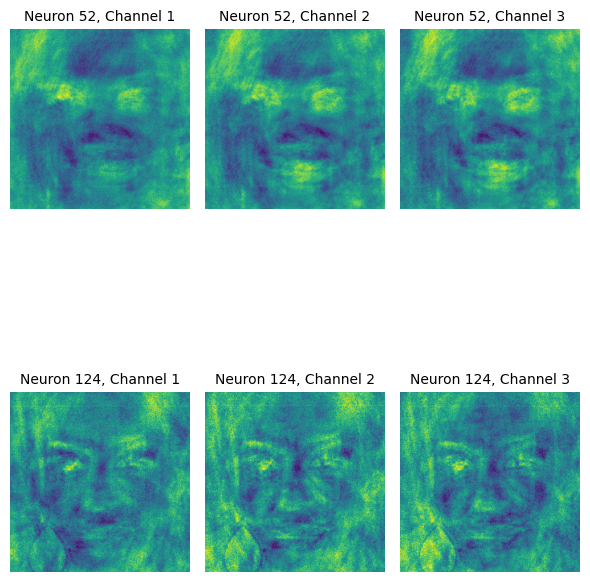

800 Hidden Units


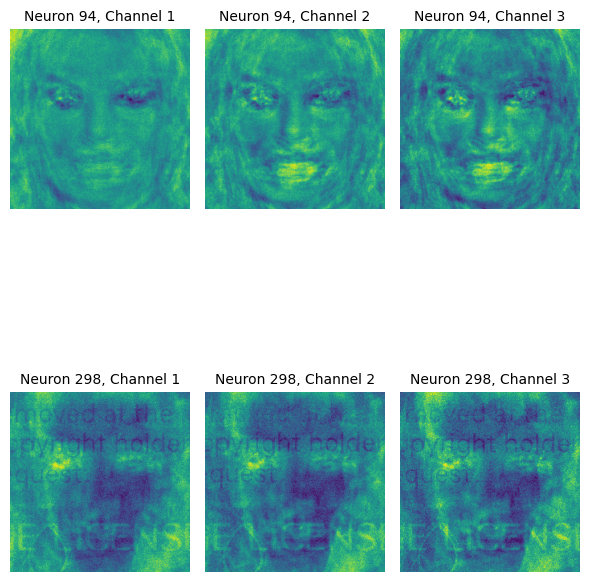

In [418]:
for i, model in enumerate(models):
    print(f"{HIDDEN_SIZES[i]} Hidden Units")
    visualize_weights(model)

### Part 2.4: Finetuning AlexNet
Train two networks the way you did in Part 2.1. Use 300 and 800 hidden units in the hidden layer. Visualize 2 different hidden features (neurons) for each of the two settings, and briefly explain why they are interesting. A sample visualization of a hidden feature is shown in Figure 4. Note that you probably need to use L2 regularization while training to obtain nice weight visualizations.

**Answer**

* The visualizations are really hard to interpret since there is no face structure.

* I think since the fully connected layer is mixes the inputs from all 256 channels and spatial positions, the weights represent more mixed global features rather than details of the image. Thus, result looks noisy.

In [42]:
LR = 1e-4
HIDDEN_SIZES = [300, 800]
OUTPUT_SIZE = 30 
BATCH_SIZE = 16
NUM_EPOCHS = 20
PATIENCE = -1
import torchvision.models as tv_models


In [43]:
from torchvision.models import AlexNet_Weights

class AlexNet(nn.Module):
    def __init__(self, device, hidden_size, output_size):
        super().__init__()
        self.device = device
        

        base = tv_models.alexnet(pretrained=True)
        
       
        self.feature_extractor = nn.Sequential(*list(base.features.children())[:10])
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False 
        

        self.fc1 = nn.Linear(256 * 13 * 13, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        
    def forward(self, x):
        x = x.to(self.device)
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [44]:
def load_cropped_data_alexnet(path="/Users/ozanozak/Desktop/facescrub_cropped", n_train = 70, image_size = 224):

    train_data, train_labels = [], []
    val_data, val_labels = [], []
    test_data, test_labels = [], []
    
    np.random.seed(42)

    classes = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(path, class_name)
        images = [
            os.path.join(class_folder, f)
            for f in os.listdir(class_folder)
            if f.lower().endswith((".jpg", ".png"))
        ]


        np.random.shuffle(images)

        train_files = images[:n_train]
        remaining = (len(images) - n_train) // 2
        val_files = images[n_train:remaining+n_train]
        test_files = images[remaining+n_train:]

        for file in train_files:
            img = Image.open(file).convert("RGB")
            img = img.resize((image_size, image_size))
            train_data.append(np.array(img))
            train_labels.append(class_idx)

        for file in val_files:
            img = Image.open(file).convert("RGB")
            img = img.resize((image_size, image_size))
            val_data.append(np.array(img))
            val_labels.append(class_idx)

        for file in test_files:
            img = Image.open(file).convert("RGB")
            img = img.resize((image_size, image_size))
            test_data.append(np.array(img))
            test_labels.append(class_idx)

    print(f"Training samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")
    print(f"Test samples: {len(test_data)}")

    data_dict = {
        "train_data": np.array(train_data),
        "val_data": np.array(val_data),
        "test_data": np.array(test_data),
    }

    label_dict = {
        "train_labels": np.array(train_labels),
        "val_labels": np.array(val_labels),
        "test_labels": np.array(test_labels),
    }


    return data_dict, label_dict


In [45]:
data, labels = load_cropped_data_alexnet()

print("Train data:", data["train_data"].shape)
print("Train labels:", labels["train_labels"].shape)
print("Val data:", data["val_data"].shape)
print("Test data:", data["test_data"].shape)

Training samples: 1812
Validation samples: 161
Test samples: 168
Train data: (1812, 224, 224, 3)
Train labels: (1812,)
Val data: (161, 224, 224, 3)
Test data: (168, 224, 224, 3)


In [46]:
transform = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
}
train_dataset = LoaderClass(data["train_data"], labels["train_labels"], transform["train"])
val_dataset   = LoaderClass(data["val_data"],   labels["val_labels"],   transform["val"])
test_dataset  = LoaderClass(data["test_data"],  labels["test_labels"],  transform["test"])


train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)


AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=43264, out_features=300, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=300, out_features=30, bias=True)
)
Training for 20 epochs
Device: cpu
Patience: -1
------------------------------------------------------------

Epoch 1/20


Train Loss: 3.6475, Train Accuracy: 9.71%
Val Loss: 2.6023, Val Accuracy: 26.09%
New best validation accuracy: 26.09%

Epoch 2/20


Train Loss: 2.4460, Train Accuracy: 27.70%
Val Loss: 1.6555, Val Accuracy: 55.28%
New best validation accuracy: 55.28%

Epoch 3/20


Train Loss: 1.7238, Train Accuracy: 47.30%
Val Loss: 1.1219, Val Accuracy: 75.78%
New best validation accuracy: 75.78%

Epoch 4/20


Train Loss: 1.2188, Train Accuracy: 63.52%
Val Loss: 0.9105, Val Accuracy: 78.88%
New best validation accuracy: 78.88%

Epoch 5/20


Train Loss: 0.8679, Train Accuracy: 73.12%
Val Loss: 0.8357, Val Accuracy: 80.12%
New best validation accuracy: 80.12%

Epoch 6/20


Train Loss: 0.6763, Train Accuracy: 78.42%
Val Loss: 0.7129, Val Accuracy: 85.71%
New best validation accuracy: 85.71%

Epoch 7/20


Train Loss: 0.5126, Train Accuracy: 84.27%
Val Loss: 0.7329, Val Accuracy: 83.85%
No improvement (1/-1)

Epoch 8/20


Train Loss: 0.4411, Train Accuracy: 86.20%
Val Loss: 0.5782, Val Accuracy: 88.82%
New best validation accuracy: 88.82%

Epoch 9/20


Train Loss: 0.3647, Train Accuracy: 88.85%
Val Loss: 0.6001, Val Accuracy: 86.34%
No improvement (1/-1)

Epoch 10/20


Train Loss: 0.3156, Train Accuracy: 90.62%
Val Loss: 0.6784, Val Accuracy: 82.61%
No improvement (2/-1)

Epoch 11/20


Train Loss: 0.2651, Train Accuracy: 92.11%
Val Loss: 0.6493, Val Accuracy: 83.23%
No improvement (3/-1)

Epoch 12/20


Train Loss: 0.2586, Train Accuracy: 91.23%
Val Loss: 0.5752, Val Accuracy: 88.20%
No improvement (4/-1)

Epoch 13/20


Train Loss: 0.2079, Train Accuracy: 93.27%
Val Loss: 0.5881, Val Accuracy: 86.96%
No improvement (5/-1)

Epoch 14/20


Train Loss: 0.1811, Train Accuracy: 94.76%
Val Loss: 0.6404, Val Accuracy: 87.58%
No improvement (6/-1)

Epoch 15/20


Train Loss: 0.1927, Train Accuracy: 93.98%
Val Loss: 0.6529, Val Accuracy: 86.34%
No improvement (7/-1)

Epoch 16/20


Train Loss: 0.1660, Train Accuracy: 94.98%
Val Loss: 0.5351, Val Accuracy: 89.44%
New best validation accuracy: 89.44%

Epoch 17/20


Train Loss: 0.1458, Train Accuracy: 95.42%
Val Loss: 0.5391, Val Accuracy: 87.58%
No improvement (1/-1)

Epoch 18/20


Train Loss: 0.1490, Train Accuracy: 95.31%
Val Loss: 0.5902, Val Accuracy: 88.20%
No improvement (2/-1)

Epoch 19/20


Train Loss: 0.1371, Train Accuracy: 95.53%
Val Loss: 0.6609, Val Accuracy: 86.96%
No improvement (3/-1)

Epoch 20/20


Train Loss: 0.1404, Train Accuracy: 95.42%
Val Loss: 0.6131, Val Accuracy: 86.96%
No improvement (4/-1)

Loaded best model from training
Best validation accuracy: 89.44%
Best validation loss: 0.5351
Best training accuracy: 94.98%
Best training loss: 0.1660

Starting on test set :)))))


Test Loss: 0.6016, Test Acc: 83.93%
Test loss: 0.6016, Test acc: 83.93%


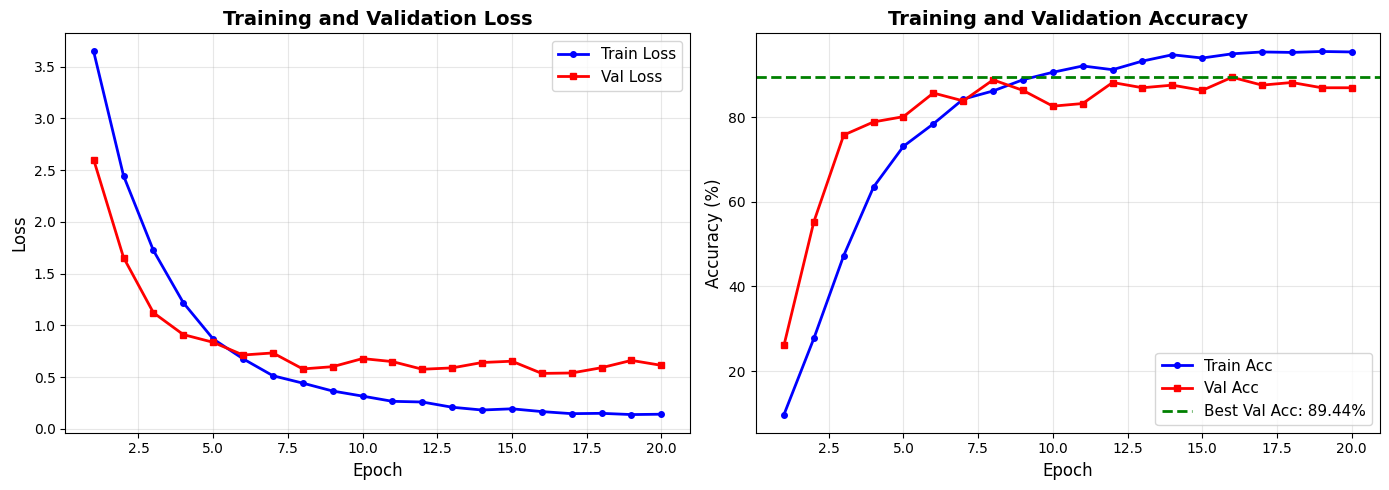

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=43264, out_features=800, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=30, bias=True)
)
Training for 20 epochs
Device: cpu
Patience: -1
------------------------------------------------------------

Epoch 1/20


Train Loss: 4.1065, Train Accuracy: 23.73%
Val Loss: 1.5330, Val Accuracy: 62.73%
New best validation accuracy: 62.73%

Epoch 2/20


Train Loss: 1.2590, Train Accuracy: 63.85%
Val Loss: 0.8924, Val Accuracy: 77.02%
New best validation accuracy: 77.02%

Epoch 3/20


Train Loss: 0.6313, Train Accuracy: 81.79%
Val Loss: 0.6820, Val Accuracy: 84.47%
New best validation accuracy: 84.47%

Epoch 4/20


Train Loss: 0.3613, Train Accuracy: 89.07%
Val Loss: 0.6343, Val Accuracy: 83.23%
No improvement (1/-1)

Epoch 5/20


Train Loss: 0.2707, Train Accuracy: 92.44%
Val Loss: 0.6445, Val Accuracy: 83.85%
No improvement (2/-1)

Epoch 6/20


Train Loss: 0.1228, Train Accuracy: 97.02%
Val Loss: 0.5890, Val Accuracy: 83.85%
No improvement (3/-1)

Epoch 7/20


Train Loss: 0.1111, Train Accuracy: 96.96%
Val Loss: 0.5189, Val Accuracy: 87.58%
New best validation accuracy: 87.58%

Epoch 8/20


Train Loss: 0.1286, Train Accuracy: 96.74%
Val Loss: 0.7708, Val Accuracy: 78.88%
No improvement (1/-1)

Epoch 9/20


Train Loss: 0.1112, Train Accuracy: 96.69%
Val Loss: 0.6728, Val Accuracy: 85.71%
No improvement (2/-1)

Epoch 10/20


Train Loss: 0.0716, Train Accuracy: 97.96%
Val Loss: 0.7441, Val Accuracy: 80.12%
No improvement (3/-1)

Epoch 11/20


Train Loss: 0.0861, Train Accuracy: 97.41%
Val Loss: 0.5425, Val Accuracy: 86.96%
No improvement (4/-1)

Epoch 12/20


Train Loss: 0.1035, Train Accuracy: 96.80%
Val Loss: 0.6123, Val Accuracy: 85.09%
No improvement (5/-1)

Epoch 13/20


Train Loss: 0.0473, Train Accuracy: 98.68%
Val Loss: 0.5795, Val Accuracy: 85.09%
No improvement (6/-1)

Epoch 14/20


Train Loss: 0.0814, Train Accuracy: 98.23%
Val Loss: 0.4664, Val Accuracy: 88.82%
New best validation accuracy: 88.82%

Epoch 15/20


Train Loss: 0.1053, Train Accuracy: 96.30%
Val Loss: 0.4900, Val Accuracy: 89.44%
New best validation accuracy: 89.44%

Epoch 16/20


Train Loss: 0.0916, Train Accuracy: 97.35%
Val Loss: 0.5569, Val Accuracy: 86.34%
No improvement (1/-1)

Epoch 17/20


Train Loss: 0.0884, Train Accuracy: 97.57%
Val Loss: 0.5659, Val Accuracy: 86.34%
No improvement (2/-1)

Epoch 18/20


Train Loss: 0.0837, Train Accuracy: 97.41%
Val Loss: 0.6508, Val Accuracy: 86.96%
No improvement (3/-1)

Epoch 19/20


Train Loss: 0.0680, Train Accuracy: 98.07%
Val Loss: 0.7118, Val Accuracy: 86.34%
No improvement (4/-1)

Epoch 20/20


Train Loss: 0.0525, Train Accuracy: 98.79%
Val Loss: 0.6389, Val Accuracy: 86.34%
No improvement (5/-1)

Loaded best model from training
Best validation accuracy: 89.44%
Best validation loss: 0.4900
Best training accuracy: 96.30%
Best training loss: 0.1053

Starting on test set :)))))


Test Loss: 0.5331, Test Acc: 83.93%
Test loss: 0.5331, Test acc: 83.93%


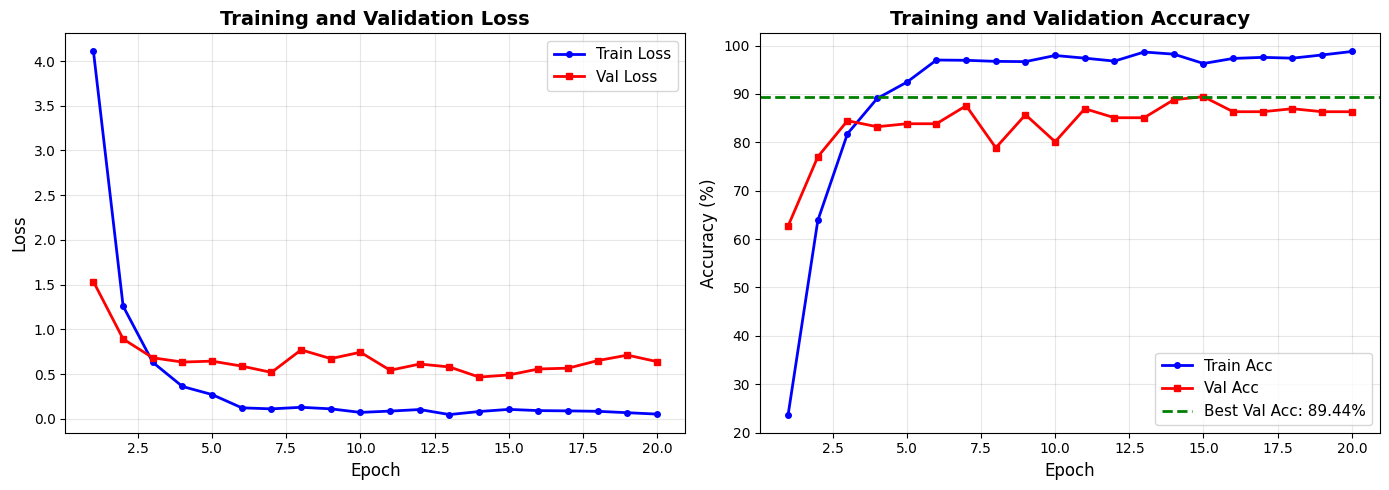

In [47]:
trained_models = {}

for hidden_size in HIDDEN_SIZES:

    model = AlexNet(device=device, hidden_size=hidden_size, output_size=OUTPUT_SIZE)
    print(model)
    opt = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model, criterion, train_loader, val_loader, opt, num_epoch=NUM_EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, device=device)
    history = trainer.train_all_epochs()
    test_loss, test_acc = trainer.test_model(test_loader)
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")
    trainer.plot_metrics()

    trained_models[hidden_size] = model


In [50]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_weights(model, no_neurons, feature_map_channels = 256, max_channels=3):
    W = model.fc1.weight.detach().cpu().numpy()
    hidden_size, in_features = W.shape

    feat_channels = 256
    feat_size = int(np.sqrt(in_features // feat_channels)) 

    no_neurons = min(no_neurons, hidden_size)
    selected = np.random.choice(hidden_size, no_neurons, replace=False)

    channels_to_show = min(max_channels, feat_channels)

    fig, axes = plt.subplots(no_neurons, channels_to_show,
                             figsize=(2.5 * channels_to_show, 2.5 * no_neurons))

    if no_neurons == 1:
        axes = np.expand_dims(axes, axis=0) 

    for row, neuron in enumerate(selected):
        w_img = W[neuron].reshape(feat_channels, feat_size, feat_size)

        for col in range(channels_to_show):
            ax = axes[row, col]
            ax.imshow(w_img[col], cmap="inferno")
            ax.set_title(f"Neuron {neuron} | Channel {col+1}", fontsize=8)
            ax.axis("off")

    plt.tight_layout()
    plt.show()



300 Hidden Units


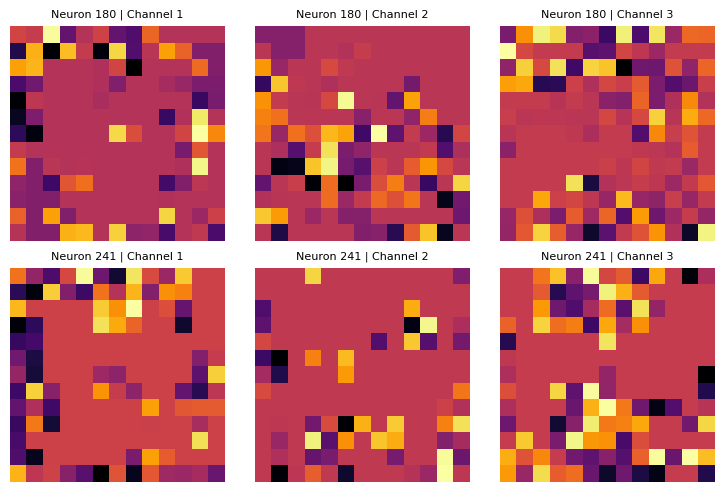

800 Hidden Units


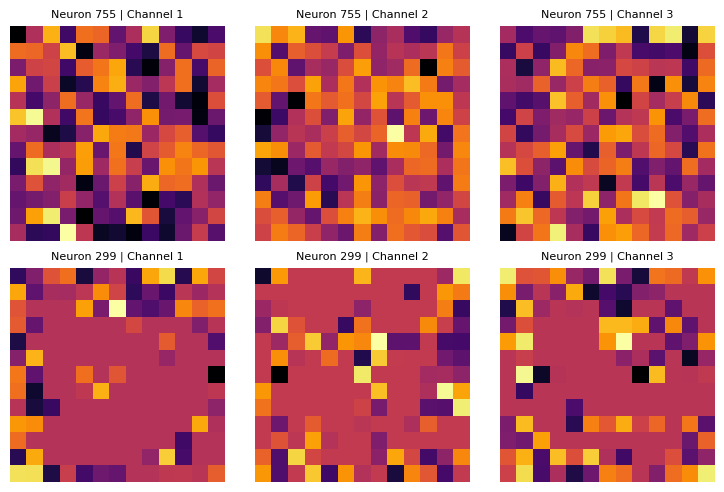

In [51]:
for hidden_size, model in trained_models.items():
    print(f"{hidden_size} Hidden Units")
    visualize_weights(model, no_neurons=2, max_channels=3)


### Part 2.5: Bonus: Gradient Visualization
Here, you will use [Utku Ozbulak’s PyTorch CNN Visualizations Library](https://github.com/utkuozbulak/pytorch-cnn-visualizations/) to visualize the important parts of the input image for a particular output class. In particular, just select a specific picture of an actor, and then using your trained network in Part 2.4, perform Gradient visualization with guided backpropagation to understand the prediction for that actor with respect to the input image. Comment on your results.

## Guided Backprop

* Guided backprop visualizes the pixels that influenced the neuron the most. In my case it seems that eyes are the most important features for model to understand the image as it is clearly visible and other parts are darker compared to eyes.

In [52]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.model.eval()     
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def backward_hook(module, grad_in, grad_out):
            modified_grad = torch.clamp(grad_in[0], min=0.0)
            return (modified_grad,)

        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                self.hooks.append(module.register_backward_hook(backward_hook))

    def generate_gradients(self, input_image, target_class):
        self.model.zero_grad()
        output = self.model(input_image)        
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1.0
        output.backward(gradient=one_hot)
        grads = input_image.grad.data[0].cpu().numpy() 
        return grads


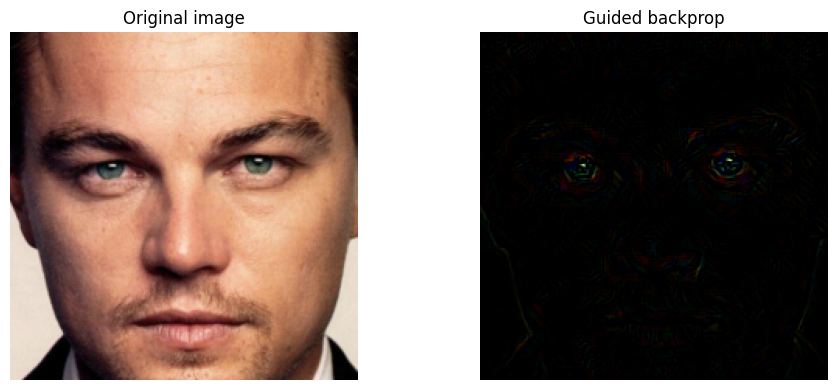

In [68]:
alex_model = trained_models[800].to(device)
images, labels = next(iter(test_loader)) 
images, labels = images.to(device), labels.to(device)
idx = 0  
img_path = "/Users/ozanozak/Desktop/facescrub_cropped/Leonardo_DiCaprio/39176.jpg"
img = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_img = transform(img).unsqueeze(0).to(device)
input_img.requires_grad_(True)
with torch.no_grad():
    logits = alex_model(input_img)
target_class = logits.argmax(dim=1).item()
GBP = GuidedBackprop(alex_model)
guided_grads = GBP.generate_gradients(input_img, target_class)
target_class = labels[idx].item()                
input_img.requires_grad_(True)
GBP = GuidedBackprop(alex_model)
guided_grads = GBP.generate_gradients(input_img, target_class)
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

orig = input_img.detach().cpu().numpy()[0]  
orig_denorm = (orig * std + mean)
orig_denorm = np.clip(orig_denorm, 0, 1)
orig_denorm = np.transpose(orig_denorm, (1,2,0))  

grads = guided_grads
grads = np.maximum(grads, 0)
grads /= (grads.max() + 1e-8)
grads = np.transpose(grads, (1,2,0))        

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(orig_denorm)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Guided backprop")
plt.imshow(grads)        
plt.axis("off")
plt.tight_layout()
plt.show()



## What to Turn In
You have two **options** for submission:
1) Provide all the relevant answers to questions, images, figures, etc, in this Jupyter notebook, convert the jupyter notebook into a PDF, and upload the PDF.
2) Write all the answers to the questions and any relevant figures in a LaTeX report, convert the report to a PDF, and upload a zip file containing both the jupyter notebook and the report.

## Grading
The assignment will be graded out of `100` points: `0` (no submission), `20` (an attempt at a solution), `40` (a partially correct solution), `60` (a mostly correct solution), `80` (a correct solution), `100` (a correct solution with lots of detail and analysis). The grading depends on both the content and clarity of your report.